In [1]:
#IMPORT STATEMENTS{
 "cells": [
  {
   "cell_type": "code",
   "execution_count": 110,
   "id": "58f093d6-5c7b-4434-aa97-4f132926c9ee",
   "metadata": {},
   "outputs": [],
   "source": [
    "#IMPORT STATEMENTS\n",
    "import selenium\n",
    "import random\n",
    "import numpy as np\n",
    "import warnings\n",
    "warnings.filterwarnings('ignore')  # supress scikit 'future warnings'\n",
    "import pandas as pd\n",
    "from sklearn import preprocessing\n",
    "from sklearn.neighbors import KNeighborsClassifier\n",
    "from sklearn.model_selection import train_test_split\n",
    "from sklearn.preprocessing import MinMaxScaler\n",
    "from sklearn.linear_model import LogisticRegression\n",
    "from sklearn.linear_model import LinearRegression\n",
    "from sklearn.metrics import confusion_matrix\n",
    "from sklearn.model_selection import GridSearchCV\n",
    "from scipy.optimize import linear_sum_assignment\n",
    "import matplotlib         \n",
    "from matplotlib import pyplot as plt\n",
    "from scipy.stats import norm\n",
    "from scipy.stats import norm, kurtosis\n",
    "from sklearn import linear_model\n",
    "from sklearn.linear_model import Ridge\n",
    "from sklearn.metrics import mean_squared_error\n",
    "from sklearn.ensemble import GradientBoostingRegressor\n",
    "from sklearn.preprocessing import PolynomialFeatures\n",
    "from sklearn.pipeline import make_pipeline\n",
    "from sklearn.linear_model import LinearRegression\n",
    "from sklearn.discriminant_analysis import LinearDiscriminantAnalysis\n",
    "from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis\n",
    "from sklearn import svm\n",
    "from sklearn.svm import SVC\n",
    "from sklearn.preprocessing import StandardScaler\n",
    "from sklearn.preprocessing import StandardScaler\n",
    "from sklearn.pipeline import make_pipeline\n",
    "from sklearn.ensemble import GradientBoostingClassifier\n",
    "from sklearn.ensemble import RandomForestClassifier\n",
    "from scipy.interpolate import make_interp_spline, BSpline\n",
    "from scipy import stats\n",
    "import math\n",
    "import pickle\n",
    "import random\n",
    "import copy\n",
    "import itertools\n",
    "from dataclasses import dataclass\n",
    "random.seed(42)\n",
    "import torch\n",
    "import torch.nn as nn\n",
    "#from basketball_reference_scraper import ask_matches\n",
    "from basketball_reference_scraper.teams import get_roster, get_team_stats, get_opp_stats, get_roster_stats, get_team_misc\n",
    "from basketball_reference_scraper.players import get_stats, get_game_logs, get_player_headshot, get_player_suffix, lookup"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 90,
   "id": "394846b6-ba2e-4916-a5ce-43e5cae14724",
   "metadata": {},
   "outputs": [],
   "source": [
    "# Data processing and modification cell\n",
    "# This entire cell essentially modifies the data into a format\n",
    "# that is usable for the rest of the code\n",
    "# Takes data from scraper and puts it into necessary format\n",
    "\n",
    "import os\n",
    "# assign directory\n",
    "directory = 'Player_CSV'\n",
    " \n",
    "def true_to_one(input):\n",
    "    if input:\n",
    "        return 1\n",
    "    else:\n",
    "        return 0\n",
    "\n",
    "def home_to_one(input):\n",
    "    if input == \"HOME\":\n",
    "        return 1\n",
    "    else:\n",
    "        return 0\n",
    "\n",
    "def win_to_one(input):\n",
    "    if input == \"WIN\":\n",
    "        return 1\n",
    "    else:\n",
    "        return 0\n",
    "\n",
    "def convert_df(dataframe):\n",
    "    df = dataframe\n",
    "    df['active'] = df['active'].apply(true_to_one)\n",
    "    df['location'] = df['location'].apply(home_to_one)\n",
    "    df['outcome'] = df['outcome'].apply(win_to_one)\n",
    "    df = df.drop(columns=['date', 'team', 'opponent'])\n",
    "    return df\n",
    "\n",
    "X = []\n",
    "# iterate over files in\n",
    "# that directory\n",
    "for filename in os.listdir(directory):\n",
    "    f = os.path.join(directory, filename)\n",
    "    # checking if it is a file\n",
    "    if os.path.isfile(f):\n",
    "        player_df = pd.read_csv(f)\n",
    "        player_df = convert_df(player_df)\n",
    "        player_np = player_df.to_numpy()\n",
    "        player_np = np.transpose(player_np)\n",
    "        if np.shape(player_np)[1] >= 10:\n",
    "            X.append(player_np)\n",
    "        #print(player_np)\n",
    "        \n",
    "#print(X)\n",
    "\n",
    "fantasy_score_arr = np.array([0,1,0,0,0,0,2,-1,1,0,1,-1,1,1,2,4,4,-2,0,0])\n",
    "fantasy_score_arr = np.reshape(fantasy_score_arr, (20,1))"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 91,
   "id": "3c5384bc-5edc-4f17-ae38-829b8e9d2a26",
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "8304\n",
      "43695\n",
      "(20, 10)\n"
     ]
    }
   ],
   "source": [
    "\"\"\"\n",
    "count = 0\n",
    "for arr in X:\n",
    "    if np.shape(arr)[1] > 82:\n",
    "        count += 1\n",
    "\"\"\"\n",
    "#print(count)\n",
    "#print(X[0])\n",
    "\n",
    "X_mod = []\n",
    "\n",
    "for arr in X:\n",
    "    splits = np.shape(arr)[1]//10\n",
    "    for i in range(splits):\n",
    "        X_mod.append(arr[:, i:i+10])\n",
    "\n",
    "print(len(X))\n",
    "print(len(X_mod))\n",
    "\n",
    "print(np.shape(X_mod[32892]))"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 113,
   "id": "af80587d-9eef-4865-89f3-a5ab3b115498",
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "(9, 20)\n",
      "43695\n",
      "43695\n"
     ]
    }
   ],
   "source": [
    "train_seq_in = []\n",
    "train_seq_out = []\n",
    "list_in_seq = []\n",
    "list_hidden_seq = []\n",
    "list_out_seq = []\n",
    "\n",
    "for example in X_mod:\n",
    "    train_seq_in.append(example[:, :-1].T)\n",
    "    train_seq_out.append(example[:, 1:].T)\n",
    "    \n",
    "    check1 = np.zeros((1, np.shape(example[:, :-1].T)[0], np.shape(example[:, :-1].T)[1]))\n",
    "    check_hide = np.zeros((1, np.shape(example[:, :-1].T)[0], np.shape(example[:, :-1].T)[1]))\n",
    "    check2 = np.zeros((1, 9, 1))\n",
    "    \n",
    "    \n",
    "    check1[0] = example[:, :-1].T\n",
    "    pre_score_arr = example[:, :-1].T\n",
    "    post_score_arr = np.reshape(np.dot(pre_score_arr, fantasy_score_arr), (9,1))\n",
    "    check2[0] = post_score_arr[:]\n",
    "    \n",
    "    \n",
    "    list_in_seq.append(torch.Tensor(check1))\n",
    "    list_hidden_seq.append(torch.Tensor(pre_score_arr))\n",
    "    list_out_seq.append(torch.Tensor(check2))\n",
    "    \n",
    "print(np.shape(train_seq_in[0]))\n",
    "print(len(train_seq_in))\n",
    "print(len(train_seq_out))\n",
    "\n",
    "train_seq_in = torch.Tensor(train_seq_in)\n",
    "train_seq_out = torch.Tensor(train_seq_out)\n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 114,
   "id": "0c9912e4-9453-4b03-a52d-85b80a18219e",
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "tensor([[[  1.0000,   0.0000,  -1.0000,  ...,   0.0000,   0.0000,   0.0000],\n",
      "         [  1.0000,   2.0000,   4.0000,  ...,   0.0000,   0.0000,   1.7000],\n",
      "         [  1.0000,   2.0000,   2.0000,  ...,   0.0000,   0.0000,   1.7000],\n",
      "         ...,\n",
      "         [  1.0000,  11.0000, -13.0000,  ...,   2.0000,   4.0000,   7.0000],\n",
      "         [  1.0000,   3.0000,  -8.0000,  ...,   1.0000,   2.0000,   0.1000],\n",
      "         [  1.0000,   0.0000,  -2.0000,  ...,   0.0000,   0.0000,   3.1000]],\n",
      "\n",
      "        [[  1.0000,   2.0000,   4.0000,  ...,   0.0000,   0.0000,   1.7000],\n",
      "         [  1.0000,   2.0000,   2.0000,  ...,   0.0000,   0.0000,   1.7000],\n",
      "         [  1.0000,   5.0000,   1.0000,  ...,   0.0000,   3.0000,   4.1000],\n",
      "         ...,\n",
      "         [  1.0000,   3.0000,  -8.0000,  ...,   1.0000,   2.0000,   0.1000],\n",
      "         [  1.0000,   0.0000,  -2.0000,  ...,   0.0000,   0.0000,   3.1000],\n",
      "         [  1.0000,   2.0000,  -7.0000,  ...,   0.0000,   1.0000,   1.9000]],\n",
      "\n",
      "        [[  1.0000,   2.0000,   2.0000,  ...,   0.0000,   0.0000,   1.7000],\n",
      "         [  1.0000,   5.0000,   1.0000,  ...,   0.0000,   3.0000,   4.1000],\n",
      "         [  1.0000,  12.0000,   3.0000,  ...,   2.0000,   3.0000,  12.0000],\n",
      "         ...,\n",
      "         [  1.0000,   0.0000,  -2.0000,  ...,   0.0000,   0.0000,   3.1000],\n",
      "         [  1.0000,   2.0000,  -7.0000,  ...,   0.0000,   1.0000,   1.9000],\n",
      "         [  1.0000,   0.0000,  -1.0000,  ...,   2.0000,   0.0000,   0.0000]],\n",
      "\n",
      "        ...,\n",
      "\n",
      "        [[  1.0000,  19.0000,  13.0000,  ...,   0.0000,   3.0000,  18.1000],\n",
      "         [  1.0000,   0.0000,  -7.0000,  ...,   1.0000,   2.0000,  -4.3000],\n",
      "         [  1.0000,  13.0000,  -9.0000,  ...,   1.0000,   1.0000,  10.2000],\n",
      "         ...,\n",
      "         [  1.0000,  15.0000,  -8.0000,  ...,   1.0000,   3.0000,  14.6000],\n",
      "         [  1.0000,  20.0000,  13.0000,  ...,   1.0000,   0.0000,  18.9000],\n",
      "         [  1.0000,  10.0000, -10.0000,  ...,   1.0000,   3.0000,   4.8000]],\n",
      "\n",
      "        [[  1.0000,   0.0000,  -7.0000,  ...,   1.0000,   2.0000,  -4.3000],\n",
      "         [  1.0000,  13.0000,  -9.0000,  ...,   1.0000,   1.0000,  10.2000],\n",
      "         [  1.0000,   4.0000,  -6.0000,  ...,   2.0000,   3.0000,  -2.0000],\n",
      "         ...,\n",
      "         [  1.0000,  20.0000,  13.0000,  ...,   1.0000,   0.0000,  18.9000],\n",
      "         [  1.0000,  10.0000, -10.0000,  ...,   1.0000,   3.0000,   4.8000],\n",
      "         [  1.0000,   6.0000,   4.0000,  ...,   3.0000,   1.0000,   2.2000]],\n",
      "\n",
      "        [[  1.0000,  13.0000,  -9.0000,  ...,   1.0000,   1.0000,  10.2000],\n",
      "         [  1.0000,   4.0000,  -6.0000,  ...,   2.0000,   3.0000,  -2.0000],\n",
      "         [  1.0000,  18.0000,   6.0000,  ...,   1.0000,   2.0000,  20.4000],\n",
      "         ...,\n",
      "         [  1.0000,  10.0000, -10.0000,  ...,   1.0000,   3.0000,   4.8000],\n",
      "         [  1.0000,   6.0000,   4.0000,  ...,   3.0000,   1.0000,   2.2000],\n",
      "         [  1.0000,  25.0000,  -2.0000,  ...,   0.0000,   5.0000,  21.5000]]])\n",
      "torch.Size([43695, 9, 20])\n",
      "torch.Size([1, 9, 20])\n"
     ]
    }
   ],
   "source": [
    "print(train_seq_in)\n",
    "print(train_seq_in.size())\n",
    "print(list_in_seq[0].size())"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 115,
   "id": "c5daa2b2-d051-4cb1-9e81-241da26f6c9c",
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Epoch: 1/11............. Average Loss: 242.6631\n",
      "Epoch: 2/11............. Average Loss: 244.8998\n",
      "Epoch: 3/11............. Average Loss: 245.8988\n",
      "Epoch: 4/11............. Average Loss: 245.9532\n",
      "Epoch: 5/11............. Average Loss: 245.9475\n",
      "Epoch: 6/11............. Average Loss: 245.9533\n",
      "Epoch: 7/11............. Average Loss: 245.9533\n",
      "Epoch: 8/11............. Average Loss: 245.9533\n",
      "Epoch: 9/11............. Average Loss: 245.9533\n",
      "Epoch: 10/11............. Average Loss: 245.9533\n",
      "Epoch: 11/11............. Average Loss: 245.9533\n"
     ]
    }
   ],
   "source": [
    "class Model(nn.Module):\n",
    "    def __init__(self, input_size, output_size, hidden_dim, n_layers):\n",
    "        super(Model, self).__init__()\n",
    "\n",
    "        # Defining some parameters\n",
    "        self.hidden_dim = hidden_dim\n",
    "        self.n_layers = n_layers\n",
    "\n",
    "        #Defining the layers\n",
    "        # RNN Layer\n",
    "        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   \n",
    "        # Fully connected layer\n",
    "        self.fc = nn.Linear(hidden_dim, output_size)\n",
    "    \n",
    "    def forward(self, x):\n",
    "        \n",
    "        batch_size = x.size(0)\n",
    "\n",
    "        # Initializing hidden state for first input using method defined below\n",
    "        hidden = self.init_hidden(batch_size)\n",
    "\n",
    "        # Passing in the input and hidden state into the model and obtaining outputs\n",
    "        out, hidden = self.rnn(x, hidden)\n",
    "        \n",
    "        # Reshaping the outputs such that it can be fit into the fully connected layer\n",
    "        out = out.contiguous().view(-1, self.hidden_dim)\n",
    "        out = self.fc(out)\n",
    "        \n",
    "        return out, hidden\n",
    "    \n",
    "    def init_hidden(self, batch_size):\n",
    "        # This method generates the first hidden state of zeros which we'll use in the forward pass\n",
    "        # We'll send the tensor holding the hidden state to the device we specified earlier as well\n",
    "        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)\n",
    "        return hidden\n",
    "    \n",
    "# Instantiate the model with hyperparameters\n",
    "model = Model(input_size=20, output_size=1, hidden_dim=20, n_layers=1)\n",
    "\n",
    "# Define hyperparameters\n",
    "n_epochs = 11\n",
    "lr=0.03\n",
    "\n",
    "# Define Loss, Optimizer\n",
    "criterion = nn.MSELoss()\n",
    "optimizer = torch.optim.Adam(model.parameters(), lr=lr)\n",
    "        \n",
    "for epoch in range(1, n_epochs + 1):\n",
    "    epoch_loss = 0\n",
    "    for index, in_seq in enumerate(list_in_seq):\n",
    "        #print(in_seq.size())\n",
    "        out_seq = list_out_seq[index]\n",
    "        optimizer.zero_grad() # Clears existing gradients from previous epoch\n",
    "        output, hidden = model(in_seq)\n",
    "        \n",
    "        #print(output.size())\n",
    "        #print(in_seq)\n",
    "        #print(out_seq)\n",
    "        loss = criterion(output, out_seq.float())\n",
    "        \n",
    "        #print(output)\n",
    "        #print(out_seq)\n",
    "        #print(loss)\n",
    "        \n",
    "        loss.backward() # Does backpropagation and calculates gradients\n",
    "        optimizer.step() # Updates the weights accordingly\n",
    "        \n",
    "        epoch_loss += loss.item()\n",
    "        \n",
    "        #if index%10000 == 0:\n",
    "    avg_epoch_loss = epoch_loss/len(list_in_seq)\n",
    "    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')\n",
    "    print(\"Average Loss: {:.4f}\".format(avg_epoch_loss))      \n",
    "        \n",
    "        \n",
    "        \n",
    "        \n",
    "        \n",
    "        \n",
    "        "
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 116,
   "id": "ea129bd9-ff93-47b9-a3df-b0896ba42613",
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Epoch: 1/10............. Average Loss: 12.0081\n"
     ]
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAXAAAAD4CAYAAAD1jb0+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAArV0lEQVR4nO3dd3wUZf4H8M83ISH0mkAEJSAdpBl6UWmCqOB55892wnkn6ukdnuj98BQLFtDz+KmnZy+gImClnbTQEYFQgvQaioQk9JBASHl+f+zsZrM7uztbZncn+bxfL17ZnZ2defZh9zvPPFWUUiAiIuuJiXQCiIgoMAzgREQWxQBORGRRDOBERBbFAE5EZFFVwnmyhg0bqpSUlHCekojI8jZt2nRSKZXouj2sATwlJQXp6enhPCURkeWJyGG97axCISKyKAZwIiKLYgAnIrIoBnAiIotiACcisigGcCIii2IAJyKyKAbwCPnxlyyczr8c6WQQkYUxgEfAqQuFePjLzfjTtI2RTgoRWRgDeAQUldgW0fj17MUIp4SIrIwBnIjIohjAiYgsigGciMiiGMCJiCyKAZyIyKIYwImILIoBnIjIohjAiYgsigE8AhRUpJNARBUAA3gECSTSSSAiC2MAJyKyKAZwokro1IVCZJ3jXDxWV8XITiKSCSAPQAmAYqVUqojUBzALQAqATAB3KKXOmJNMIgqla19aCgDInDIiwimhYPhTAr9BKdVFKZWqPZ8AIE0p1QpAmvaciIjCJJgqlJEApmmPpwEYFXRqiIjIMKMBXAFYLCKbRGSstq2RUioLALS/SXpvFJGxIpIuIum5ubnBp5iIiAAYrAMH0FcpdVxEkgAsEZHdRk+glPoAwAcAkJqayg7QREQhYqgErpQ6rv3NAfA9gB4AskUkGQC0vzlmJZKIiNz5DOAiUkNEatkfAxgKYDuAuQBGa7uNBjDHrEQWl5Qi71KRWYcPO8X7EIpypaUKBZeLI50M8sFICbwRgDUikgFgA4AFSqmFAKYAGCIi+wAM0Z6b4tEZW3DN84vNOnzECAdiUpT615I9aP/sorAWnHLzCjF9XWbYzlcR+KwDV0odBNBZZ/spAIPMSJSrhTtOhOM0RKT5YctxAMDZgiLUSogLyzkfnbEZ6w+dRp+rG6BlUq2wnNPqOBKTiKLC2QJbab+4lHWMRjGAE4VBcUkpzlegdhyKDgzgJikqKcVL83fiTP7lSCeFosDjszPQqQK241BkMYCbZNGOE/hozSG8OH9npJNCUWBuxvFIJ4EqIAZwk5Ro9XiRrs/bduws9udciGgaiMgcDOAhknepCMfOFEQ6GW5ufXstBk9dGelkkJPle3Jw8XJJpJPhVSS6uHKlKv8xgIfIzf9eg36vLje0b7R/Tb9OP4p3VxyIdDIqpD0n8vCHTzfimR+2RzopUYsrVRlndC4U8uHwKf9L39H6NX3ym20AgIevvzrCKal47ANjMk/lRzglVBGwBE5EhuVdKkJ+IYfYRwsGcJNwvhMKVubJfMzfFl29V655fjGufWlJpJNBGgZwk3G+E9KjDFzhh76xCo/O2BKG1Hh3Jv8ynvg6w9HweqmoNMIp0pcyYQEmzatc3XYZwMPkpjdX4/Z3f4p0MiLi9UV78NHqg5FORlTw54J+uTjygVIpYOqSvfhm0zHMTj9q+rmC9cnaQ8EfxELYiBkmO7PORzoJEfP28v0AgD/1bxHyY584dwn1asShapXYkB/bCg6fykfd6vGoUy20E07pXWjCdTfpfJ6jpwtQr0Y8alZlqNLDEjhZVmmpQq/JaRj31dZIJyVirvvnCtz05upIJ8M0/V9bjjs/WBfpZEQtBnCyLPsd9+Kd1ptuePORsyE71q9nL4bsWNFo+6++715HvrM2DCmJPgzgJglkVJlSCnmXipAyYQH+ucjwsqNkUZeKons0ppVkHD0b6SREBAO4yfSqDT31QJix4Yhj5aEPV0W+Mebo6eibGsD62C2JQocBPILEpVVo8Y7sCKVEX//XjE0NQBVXOOcn4dAJ/zGAE5EbvflIwjU4jfcoxjGAV3IlpQor9uQYGlgSbayYZiviYLToxQDuh9cX7cHvP14f6WToSs88jZQJC5CbV+jX+z5ecxBjPt2IJTvDU32zYFsWTpy7FNJjulZFWYXz9Sfr3EVknavYvUko9CpUAFdK4bvNx1BUYs4ItreX78fqfScNpsWUJHj00Wpbo2d65mm/3mefRTHbz8AfiOKSUjwyYzPueN93v97LxaU4WxD9y9G9MG+HX13YPF1rek9eht6Tl4UoVeFXcLkYxSb97sizChXA52Ycx+OzMwKay/rQyXw8OmNzyIcvW7V0aAb74kRGSpoPTE9Hl0nRP2nSp2szK20XNmftn12Eh7/c7PH1y8WlmPDtNmSfD+3dV2VXoQL42QLbXMsnL/hfmpzw7TbM35aFTYfPhDpZhrFGt8zKvbmRToIprFZt7096vVXDpe3KxsyNR/HsnLKFLEpLFVImLMA72lQLbNPwX4UK4EQUGmbdODr3brGvF/vG0r1hOXdFxABeAR3MvWCoofCttH34cv2RMKTIu42Zp1Ea4cWfPVm4/QSGv7k6ZOlzDk7RsAYkZ4m0NgbwCDDzTlEBGPivleg1Oc3nvq4ln2CN+XQDnvruF7/es3x3Dn733jp89lOm3+czM/wdOVWA/TkX8NisLdiVdR6FUTC1qxleWrDL8ALLVqrimJ1+FF0nLY7agkGoVMgAHg3fMyNp8GcSov05efjPiv0eX9e77Vy8I7yTPK3Yk4uvNvhXoj+m5cGB3AsBn9eMO+4B/1yOwVNXmnDkMntO5EXFnN/T12V6fd2KNRrPfL8dZwqKcKm4pEIHccMBXERiRWSLiMzXntcXkSUisk/7W8+8ZHq3am8u8guLHUFs/aFT2HMiL6hjvrN8P7aGoHeBry//1qNn8eEq37ext7+7Dq8t3OPXBEhjP99keF8KD+cL+23/+QkvzNsRucRoKmJ8u6x1aWz/7CI8NmtrZBNjIn9K4OMA7HJ6PgFAmlKqFYA07XnYHT1dgPs+2YAnvs5wbNubfQE3vrEqqOP+c9EejArRFJXHznieFGrUO2vx8n93eXzdjjPXVUyuvZ7OXyrCGoNjDbxZujMb57ReWdFk4Y4TKPFwxTDrOjI3o/y6ojnnL0Vl3gTCUAAXkaYARgD4yGnzSADTtMfTAIwKacq8OHwqH/d89DPyC4uRf9m2QvbB3Pxwnb6c42cv4vVFe7zu89evjK1raKU6xmAUldi6j325/nCkk+KT/b9k6Bsrg/rR2+8OffWw+PMXm3Hvx+txOr9sENPy3Tl+nSs3rxB/mp6Oh74I/A7MnkwzvpG+72yDq7R5cb73dTF7vJKG7q8sDeocRmzURkcfPmVebDJaAn8DwN8BOFfYNVJKZQGA9jdJ740iMlZE0kUkPTc3NH17X124G2v3n8KKPWXH25OtX2VyubgUl4pKcKmoxGtJOFAPTE93LBnmSUkY47Kna8D3W44FdLxAvoBKKUz5cTf255T/P3HtdfGf5f4PuAo3e+Pl0dMXsWqf+X3T92l55lw3vnyPfwG8sNh2t3YkiOmA7QPQgilU5BcW6945mt1N8OM1vqdiDkfbw3ebbb+5tftPmXYOnwFcRG4GkKOUCuhyrpT6QCmVqpRKTUxMDOQQhn27yT1IDXtzFdpOXIgHP9+Efq+WTY96qagEw95YhQ2HbEPPA/2a5hcWB/jO0PL1o/jbrAy3bUZHiS74Jcvr6/tzyjdA5uYV4r2VB3DvRxvKbV93ILRf5Epyw2I6s7ozdnhuEQb9y3NDcKS7UfaenBbyeXnCzUgJvC+AW0UkE8BMAANF5AsA2SKSDADaX/+KCSbIOHbObZu9asV1ZN++7AvYfSIPk+bvwMwNRxyBPFSlg8oSW378JQuDp67Ewu1lQd7+2UtdIqzR7mr+iraBH5kn89Hv1WXICeOw8cLiEvz23Z+w5UjwI4mVUjh00v2uK5DvtJGeVnpT15rlEafh/lnnLmGeS/241fgM4Eqpp5RSTZVSKQDuBLBMKXUvgLkARmu7jQYwx7RUhtDa/e4NRP9e5r0KJCgu381oreeeFkA/bACO/tu7g+z144mRai9vWaqUcqvKMdtnP2Xi2JmLmL+t7KJmdojae+IC0g+fwUSnoepGuQbQvdnl76j07tRW7s3FQZ2unyWlCucvubcVXA7RRFdKqaB+Q77uJq0mmH7gUwAMEZF9AIZoz6Pe3K3HUXDZc7VH1rmLyNP5AgYjy6kUsnB7dC7A61oNYsSZ/MtYf8i/2Q89UbD9+Ns882O50YHO1V7OTl0o9NgIuj8nzzGt7owNRzB46iq/qm889ZKoLIxUbYz+ZAMG6lSPPDtnOzo9v9hRD283buZWIyf2qc+UZUh9ydYAeSD3Ah6bucW02UetoIo/OyulVgBYoT0+BWBQ6JMUOnqBelb6UcxKP4p5j/YDYFvxukndao7X/zYrAy0a1jB8Dtfv3Nr9J3HuYvkLQI7TVK2/nr2Ijk3qGD5+OCmlDNeLz1h/BP/43r9Rl7rnc3qef7kYhcWleGmB726V42ZuxRqduykAGDx1FeJjY7D35eH4RatWyzyVj95XNzCUrrfS9hnaLxo5r+Aeirs95yMYWfLvhy2/AnDvHunM1zfM21cwy6nO+vHZGcg4ehaj+6T4TFdFZfmRmN7qz9o/uyigYx7Uqf8z6p6P1uPPXqbVNFswDUPNn/ovdp8477ZdLw54C97hqCU6le99rvDLJaXo8OzCgG7dPc0PE85yeaaBnj/HPdQv+zuFsdHvzLqDxu9i7v7Q88InnGI5dCwfwMkmkIYgvXdsOXI26LQ4jh/h32n+5RLHFMPebDp8JuoWI1jgo/48J+8S+kzxvgBEiVK4EEAvqWFvrPb7PXZGLgXHz4a+mjKUPl+X6ejUEO0YwE0SqcbKSNXfhrMnQSA8/XdkHD2L29/9CW8aqDbZfPgMvk4/GtD5y/pVB/R2N6d93IEAQPb5QnR8bpGhi9O5gqKQrIBUYKCn0Z+/3Ixb3w7NKGczTJyzw9CqUdHAUgHcHpyMfEl8CVfpMNyBzUg9pb9CdTHydZRH/Kh62pVVVtXj7f/SV+7bV4jZleW7p8pnP2XiyW+2GUkeANsAnC6TFuOp77YF/S3YcyIPfSanGQrcrkoM/P91nrQ4oBWQbvn3moCG/h86mR/UxWzT4dM4E0BeVDSWCuD2rm7OIzAD9cD09KCPAZStKekq2JDnWndr9HhmdJM6ejo8t7xG1xsNVH5hMcbPznAMiZ/2UyZ2HHev8/e1otPk/+4ydFFbve8kzhYU4asNgZXa7U6cv4T/W7IXx89dwgo/R2UaEUwh45dfz2HCd8Yvah4SAKWUoXp/u9vfXecYaWrkt7F8dw5eXuA+xN5+8d+XnRc1g/L84VcvlEibNH9nyJbaygrTCKxgSvrpmaeRmlI/dIkxQC8uzUo/im82H8MnY7rjuta+R9MabRQL5CJ3/2cbkVwnwfD+zueYvu4wvt18DA1rxeOp4e3w3NzAZgJ8f9VB/HVQK9So6v7z+XDVQd2xBv5yzsNFTndVO46fx2+6ue8/c6PvaXxPXShE3erxiI0p/6WM9IhIAPji58OOWRHNuGf9w2cbvb4+5P9WoUdKfcx+qLcJZzePpUrggPuIykg3lIWSa/DMzSt01Eva527weLtqcj6UlCqM/mRDubSUO73O+bPPFxpexNZbgXb7r2UjbJftzgl4FSF7oApFtZan793L/92FfV761Lu+78jpgnKDlXylzdM8H77y5FxBEa59aSkmG5j50lm4mnKcG89PXrgccFtDMDZkWqPh0pnlArjV+dOF6uEvN7vVS3oavBLIpPXFATZ4/muJ99kXnd369hrHY71PbiQ7bv73Gt87eRCu6/vT3//i1v9fj2tALLhcojtYyVsgLylVXmdG1Hvn2Yu2gsBiLwsPA8B7KyM/wdjYz9Px5DfbkHXO+IInlZWlqlDI5oV5O9C8YQ3c1zvFse3HMI7wPHbG+w/LOUhln/denxwur/x3l48udQovzNuBqxNrGj6m84pHX64/grhYz+WhUN4pPj93Bz7/2fhUvM4XA18zFE75cXfA6fLXziz39gcAjq6fby4N/4AqM+YJN7OKytIl8H8u2h22umxnJy8UYtNhH7dbJt56fro2E8/OKau/NdpL5P2VB/DTgZO4/d2fghp+vD/bvYpg6pLQrq/pDyNVIkb6Q3+6NhPP/GBsLpHFO7Lduh6Gq+vovG3hm4DJ27QTwfLV5XXmxrJqFLP66bv+l3WetDiERzf//s/SJfDMUwWGF0sIpVHvrMWxMxeROWWEz31D/V+4XafXxBaDS79NdipdeaqbNlJa8DT3ui+RbyqzCUVp2ErLdC3bnY2HvvDcRdPbBdDMyZ+OeOjBpWf3iTyPU1AsMvHuc/eJ8xj2xmqsevIGXNWgOg6fyke1uFgk1TbekG4mS5fAAURkIhtfVQjeHAlydY7cPPcqieJwrhhhwL+XGbv1DVWBNVQz3ZnJaMOpo6E1hFd+b8Hb+Zx6zFwQeLzTMoj+Llrh7H0Da8oGavZG2xoDi3faLhLX/XMFerySZtr5/GX5AB4uS3w0/hg1bZ3/y4h5uzVXSukuZBFJnvo9e+ozHwrROk2vO2PpnB7A98QMa/afCmpuIKPORGiNSqv3YrN0FQoQvl4GoRr4442nktC8bZ5vY38+eBqzItDlKhBpu0I/StTuqw1H0aN5PSTWKn9rG86w7vXiHMZAEcqgtCvrPHaZPIV2OJY3q6hYAkd0XIUXbj/hce08T/X87688EPbRY68uDLyXgusqL/6k/WcfM+Et252DwVNX4Y73ApvDwjIFeBO8ttB4t1Cy+XDVQaRMWBDpZDCAm8XfrkOBrCA+OYxdvuzeXRF4P2HXKWDzCoudGrK859edH/xs6BxGGlij4HodFCMzLIZTuApA0TTU/WVtQNS5giLdKZjDxfJVKPkmrbMYKmZ/uZcGWC3hqcQZ7pKoPw1QUxf7X1JMNzi6Lm23uUu6llUTWP3y4e7oae+N+hMNds30xYwOCzM3HtVd/9Oo295di4O5+YZ6pJnB8gG8snPuK+uP/q/pL1UWzd4KYO3S85fcS22HfQxmMZf3K2S0T8sbCH8GHYXb/pwLHpcTnG+gv7190fRIYRUKfJc6PU3u3uHZhSakJrKioT3AbAu8NApH2okwrmRP3j06I/xjTPzFAA4g18f0oZ4mdw+0+iaaG8zM7PdLwE6dgVihZu+7TBUfA7hJ7LMmzk631o9p4pzApli1mnDO+eEsHPn7f0sjN62BWeZs/dXj3CnR6PHZW7HShLnbXbEO3CT//cXz8N6dWec8vlZZhfuuJBpm3SPjPlx9CB+u1p9K10w7jtt+q3ojoL35bvOvZiTHDQN4BPga2lwZBdoYW4ZVPxR667X2r/dXHfRrpkpnZhZOWIWCitixq/Ip5Gg+Mtnfvw1y6TgTMIBThWD2epoVyfusPqowGMCJKplIjOAlczCAw/vtd04e++USkXefr8tESanCFz8fDuvkXGzE9KHHy9Ez9y8RRaeXFuxCfJUYPPPDdsdC5OHAEjgRUQicv2ibtiGck435DOAikiAiG0QkQ0R2iMgL2vb6IrJERPZpf+uZn1wiIrIzUgIvBDBQKdUZQBcAw0SkF4AJANKUUq0ApGnPiYgoTHwGcGVjn64rTvunAIwEME3bPg3AKDMSSERE+gzVgYtIrIhsBZADYIlSaj2ARkqpLADQ/iZ5eO9YEUkXkfTc3NwQJZuIyBpy/ByG7w9DAVwpVaKU6gKgKYAeItLR6AmUUh8opVKVUqmJiYkBJpOIKHp564r8Vto+087rVy8UpdRZACsADAOQLSLJAKD9NX/qLSIiC8oMYtUfb4z0QkkUkbra42oABgPYDWAugNHabqMBzDElhUREFnf96yugTJjVyshAnmQA00QkFraAP1spNV9E1gGYLSJ/BHAEwO9CnjoiIouwL3TsSW5eIZJqJ4T0nD4DuFJqG4CuOttPARgU0tQQEVlcOCc25khMIiKLYgAnIrIoBnAiojAwo2qFAZyIyKIYwImILIoBnIjIohjAiYhCKD3zdNjOxQBORBRCGcfO6W43YSAmAzgRkVUxgBMRhcHuE+dDfkwGcCKiMPhhy68hPyYDOBFRGHAgDxEROTCAExFZFAM4EZFFMYATEVkUAzgRURhwIA8RETkwgBMRWRQDOBGRRTGAExGFAQfyEBGRAwM4EZFFMYATEVkUAzgRkUUxgBMRhYEyYSQPAzgRkUUxgBMRWZTPAC4iV4rIchHZJSI7RGSctr2+iCwRkX3a33rmJ5eIiOyMlMCLAYxXSrUD0AvAIyLSHsAEAGlKqVYA0rTnRESkIyIDeZRSWUqpzdrjPAC7ADQBMBLANG23aQBGmZA+IiLywK86cBFJAdAVwHoAjZRSWYAtyANI8vCesSKSLiLpubm5QSaXiIjsDAdwEakJ4FsAjymlzht9n1LqA6VUqlIqNTExMZA0EhGRDkMBXETiYAveXyqlvtM2Z4tIsvZ6MoAcc5JIRER6jPRCEQAfA9illJrq9NJcAKO1x6MBzAl98oiIKggTWjGrGNinL4DfA/hFRLZq2/4BYAqA2SLyRwBHAPwu9MkjIiJPfAZwpdQaAOLh5UGhTQ4RUcWkTCiCcyQmEZFFMYATEYUBV6UnIrKoPdl5IT8mAzgRURgczM0P+TEZwImILIoBnIjIohjAiYgsigGciMiiGMCJiCyKAZyIyKIYwImILIoBnIjIohjAiYgsigGciMiiGMCJiCyKAZyIyKIYwImILIoBnIjIohjAiYgsigGciMiiGMCJiCyKAZyIyKIYwImILIoBnIjIohjAiYgsigGciMiiGMCJiCyKAZyIyKJ8BnAR+UREckRku9O2+iKyRET2aX/rmZtMIiJyZaQE/hmAYS7bJgBIU0q1ApCmPSciojDyGcCVUqsAnHbZPBLANO3xNACjQpssIiLyJdA68EZKqSwA0P4mhS5JRERkhOmNmCIyVkTSRSQ9NzfX7NMREVUagQbwbBFJBgDtb46nHZVSHyilUpVSqYmJiQGejoiIXAUawOcCGK09Hg1gTmiSQ0RERhnpRvgVgHUA2ojIMRH5I4ApAIaIyD4AQ7TnREQURlV87aCUusvDS4NCnBYiIvIDR2ISEVkUAzgRkUUxgBMRWRQDOBGRRTGAExFZFAM4EZFFMYATEVkUAzgRkUUxgBMRWRQDOBGRRTGAExFZFAM4EZFFMYATRZH/Sb0y0kkgC2EAt7DaCT4nk4yo/q0a+v2et+7qakJKrOOV31wT6SSQhVgigFeLi43YuevXiI/YuX1pWKsq/j6sTaSTUU7Xq+o6Hl/X2v8VmK6sVw0A0DKppttrrRu5b/PH3T2vQv0a8XhxVMegjhMKbRrVMuW4DWtWLff8o/tS0fnKunjh1g6Obav/foPXY1zfJhGv3d4JL47s4HW/UJv/l34hP+YzI9rhP/d0C/lxA3FV/eohP6YlAngorHzy+oDet3Bc/4De9+B1LQztN+OBnrrb7+vdzOd7v/xTT/z5+pZoUrea22vv3RuaL61eIPXm+z/3dTwWEbfXM54biswpI3Bts3pej1OjqvvdRXwV/a/rvEd9//Azp4zAK7ddg80Th+D3vXznLQA8f0t7fDw6Fa/ebisVd76ybrnXlz9xPd66qyueGt7W63Ga1quGWi53S80a6P+YBcAnY1INpU9ParN6GNMnxfF8cPtGmPNIX/xP97KqGZ3/lnI++0MP3NH9SlSP932Hd02TOph2fw+f+718m/5Fc+yAst9JxyZ1HBfX2JiyRHZqWge7Xxzm9fjNG9bQ3d6tWT3cdE2y43mwhYBgjOxyRciPaakA3sXlB6TnLwNb6m5PqpUQ0DmTant/n16gTGlQHU8Nb2fo+HWqxTked25aBwCwc9KNeOHWDnhwgPtF4OPRth93xya1kVzHFrjtX4yezes79hvUrpFj21id47h6oH9zZDw3FBv+MQhf/LEnvnmoN/4ysCXm/6UfPv1Dd0OfxZVSqtxzkbLP++adXfDHfs3R4YraAR3bWf2a8eik5Z0eT8HSmV7VzR3dr8Sgdo1QK8GW5h4p5S86zRvWwK2dr8CD112NN+/sAsD2Hb21s+3/I3PKCEy/vwe+e7gPBrZNKvfeBi4lZQBYO2EgYmIEA9s2Kre9wxW10cCPO8HntdL2bV2bOLYlxMXqXugBILlOAl77bSfDx894biiev6U9YgSYfn8PDGjV0GeB5Z6ezdA9pR7+OqhVue0ThpW/+P2+VzNkThmBetVtn7dFwxr48L5UJHi5C//PPd3wo0tBKz42BrtfHIZuV5X/P3P+vdn3CxeXn0NIWCqAz3igJ9KfGey23fl2tF9L93rXYR0aGz5H1SoxOPjKTbqv6d32DuuYjO4uP+yvxvYq97xR7apoUrca/vW7zuW2X51YAx2uKAs8PzzSFwdfuQnV46tARDBheFs8Nrj8F95eChzZuezHOW5wK7z2206YObYX5j3aD7PG9kJcbAwyp4zArAd7o6pWcn1scCus+d8b8MTQ1uWOufvFYXh6RHvUqRaHpNoJ6NeqIVJT6mP80DZIiItFu8beg2zd6nFeX7fb9MwQx+Om9apj4s3tMU77QbdtbMtb+0VpsEvAA4C37/J8V3F1oueSlV5d/F8G2u5c7PnprUpjWIfGeHFkB4wf2gYL/toPA1onYsFfy5f6R3Zpgg3/GITvHu6Dt+7qiswpIwAAA1onIql2Al69vROW/G2AY397ifwvA1viqvq2vNALsBNvbo9Px3RH95T6uq+5StFKorsmDcPrLt83Z66383cYaDxd/LcB+Pqh3qhTLQ5j+jbHwckjUK9GPEQETw1vh28f7u3Yd+Fj7neuXz/Ux2MBq7FbQckW7WY+2AuNdApRuyYNw4K/9sP0+3vgpmuSdQO8t6Dv4ONuxNVXD/Qq9//oj1ITInh0t4Jp+rdqiMU7sxEbI+Xq+P42uDW2HTuLmglVsCc7D8/f0t5RYh7cLglP3tgWZwouo1eLBrhUVOLx+C2TamJ/zgXH85gYQYMa8aip/cgeuu5qvLfyAAa3T8Ke7DzHfvZb3ffuvRbXvrTUsd0ehOxqVq2CtPHXAwDGf50BAJj7aF+0dQmMIlLu9lZE8Njg1ri751Xo8XIaAFsd556XhpUrOVStEuv4AV6jUxK9rWsTvLfyAEZ1aYKm9aqjapWyL3ZCXIzPL3rjOgnInDICE3/Yjs9/Puz2uqffQGunoNjn6ga67QlDOzRG5pQRKC4pRXGpQkJcLLZMHII61eLwryV7HfvtmjQM1eLL0vnuPd3w8JebAQBVYgSv/64zLhWV4MftJwAAo7pcgXt6NUPj2gloXMc9AIwf2gbjh7bB8bMX8XX6MbRuVBPLxl+Hw6cL8OTXGTh54bJj35gYwe97pwAAOlxRB9M9VBl4u1tLiItFq0a10KJhDdzR/Ur0b9UQH6w6iFFdm2D8UPd2jLmP9sWJc5cw1KXw8e493fDeqoPIOHoW3ZzaGwCgenwsxmsXZ+e8snvulvaYOGc7EmtVxdt3d8WkeTuRfviM4Xae1j7q7a9tVh+/PD8UABx3La7itO9ti8QaGDeoFWJixHGxc2aPdeLh21UtPrZc4cfV1Qar/lIaVMfe7Au+d9S0TKqJopJSw/s7S9b5HgbLEgH8rbu6IuvcpXKBp1ZCFYzTSqcXL5fg7h5XoWeLBgCApY9fh5QG1VHFwO3RoLZJiI0RRwC3H3PTxLLS4oThbXFL52S0a1wb7yw/4Nhuv9VtULMqMp4dip8PnUJpqftV9uPRZVUQ793bDdN+OoxOTesa/fhu1T/O+WBEi8Sa2Pdy2V3FfX2a4dzFIry9fD/u79vcr2PZrf/HIOQXFiM98wzeTNuHMwVFbvsMcGrEnPFAL7fXnVWJjYH9Y9VzCSh9WzZwBKQ5j/TFvpwLGO5Ur2kvob1777VYvS8X5y8WY0SnZBhxRd1qjv/zFok10SKxJmY/2BtLd2UbqgP217Inrnc81gtcdp2a1kWnpv4du1/Lho4AqWdoh8aOC0KnpnXxzcN98NWGI47qnadvaofuTtVw/Vo1hIh/t/7OgdvTe1c8cT0a1U7QvcjYffGnnvg6/Rga1nS/uHhqhH3khqvRpnFtVI+LLdeYbjS9RiTWqors85f8eo/dvQbbXvxhiQCeEBdbrpFi88QhiIstuzJXi491BG/AWMPb0PaN0KxBdTwwoAXiY2PQe8uvGNMnRbfhDYDXqz0A1Kkehxs9VNWkOKV9WMdkDOtYPrhUj49FwWXPdwihVrVKLJ64sQ2euDHwHiz2oNkisSY2HzmDmRuPOl77dEx3R71zz+b1sf7Q6aDSW9vpR9b5yrpujYnO+rfyv+eLqxaJNTHWS5VMRXJXj6scjx9waStpVDsBhyaPwPZfzyG/sNjvY//vsLaY8uNut+0pHhocnbVLro1nb3GvIgKAKz305njyRu+NyXqM1KC8fFtHPP39dsdzvSodV2P6pOCznzLLn8tX63EALFUHble/RrzfV86qVWLQo3l9fHRfKjKnjMAH96Xi6RHtkVQrAXWrx+MPfZubksFGrPr7DUgbf53XfWIik7RyhrRvpLt90siO+Oi+VKzQSpc3tE1CCy0AfjKmO5Y+HlidoV0rk7rcWckf+qYAAK5NqYf7tcfNG9bA8ieudzQytw9Bg7Cejk3qlCsgGfXQdVeHNB37Xh6OAx7ap4x6/Xed8ZtutvajWzpfodsjZ+odnR0dA0Z2uQL39HQvOX8yJhWJtdwbogFgRKdk/O8w/y8mgbBECTwURASzH+zte8cIaFizqlv/XVdLH78O24+fD1OK9A1onQgR4IH+5Utq8VViMNhDcK9RtQpaJgUWgDOnjEB65mlDvY8qup4tGjiqXEZ2aYKRXWxBqG71eDRvWAPzHu1nWgCPFt6qh3yZ80hfVIuPRbMGNTD1ji6ODgXHzlxE/9eWO/ZrXDsBv+nWFGcKijBn63GP7QMD2zbC73udx1SndhpHOmPEZ1fNUKk0ATwSbu6UjPnbskJyLHv9bKQdmuy53tYMqTq9L8idXuN1NOjVoj5+PhhcFVoouFa72e+2natjZo7thRZa9Y69V4xzz6C7ehib5mBAAAPYAsUAbqK37+6Gt++OdCoqrun390CJTqMxRY9Px/TAqfzCSCfDqxaJNdA6qRZ6OVUT3XRNY3w8OhU3tLE18O59aTiquNRjOnddnf1gb+zKOo9RXZugTrU4lJYqtGlUq1yvNTOI62ALM6Wmpqr09PSwnc8M42ZuwZytx/HkjW3wyA36fVqJqHJImbAAnZvWwRwPo4G7TlqMMwVF+HFcf7RLDryKS0Q2KaXchugygBMRBaiopBQxIuWG/jvbn3MBabuy8WCQDbqeAjirUIiIAuSrYbVlUk2/5xPyhyW7ERIRUZABXESGicgeEdkvIhNClSgiIvIt4AAuIrEA3gEwHEB7AHeJiP7QKSIiCrlgSuA9AOxXSh1USl0GMBPAyNAki4iIfAkmgDcBcNTp+TFtWzkiMlZE0kUkPTc3N4jTERGRs2ACuF6/Gbc+iUqpD5RSqUqp1MTE8I1QIiKq6IIJ4McAOI8tbQrgeHDJISIio4IJ4BsBtBKR5iISD+BOAHNDkywiIvIlqJGYInITgDcAxAL4RCn1so/9cwG4L+liTEMAJwN8b0XGfHHHPNHHfNFnhXxpppRyq4MO61D6YIhIut5Q0sqO+eKOeaKP+aLPyvnCkZhERBbFAE5EZFFWCuAfRDoBUYr54o55oo/5os+y+WKZOnAiIirPSiVwIiJywgBORGRRlgjgFX3aWhH5RERyRGS707b6IrJERPZpf+s5vfaUlhd7RORGp+3Xisgv2mtvibZyq4hUFZFZ2vb1IpIS1g8YABG5UkSWi8guEdkhIuO07ZU9XxJEZIOIZGj58oK2vVLnC2CbIVVEtojIfO15xc8TpVRU/4NtkNABAC0AxAPIANA+0ukK8WccAKAbgO1O214DMEF7PAHAq9rj9loeVAXQXMubWO21DQB6wzZPzY8Ahmvb/wzgPe3xnQBmRfozG8iTZADdtMe1AOzVPntlzxcBUFN7HAdgPYBelT1ftLQ+DmAGgPna8wqfJxFPgIH/lN4AFjk9fwrAU5FOlwmfM8UlgO8BkKw9TgawR+/zA1ik5VEygN1O2+8C8L7zPtrjKrCNOpNIf2Y/82cOgCHMl3J5Uh3AZgA9K3u+wDYXUxqAgU4BvMLniRWqUAxNW1sBNVJKZQGA9jdJ2+4pP5poj123l3uPUqoYwDkADUxLeYhpt6tdYSttVvp80aoKtgLIAbBEKcV8sU3p8XcApU7bKnyeWCGAG5q2thLxlB/e8smyeSgiNQF8C+AxpdR5b7vqbKuQ+aKUKlFKdYGt1NlDRDp62b3C54uI3AwgRym1yehbdLZZMk+sEMAr67S12SKSDADa3xxtu6f8OKY9dt1e7j0iUgVAHQCnTUt5iIhIHGzB+0ul1Hfa5kqfL3ZKqbMAVgAYhsqdL30B3CoimbCtDDZQRL5AJcgTKwTwyjpt7VwAo7XHo2GrA7Zvv1NrFW8OoBWADdotYp6I9NJazu9zeY/9WL8FsExplXnRSvsMHwPYpZSa6vRSZc+XRBGpqz2uBmAwgN2oxPmilHpKKdVUKZUCW3xYppS6F5UhTyJdCW+wgeIm2HohHADwdKTTY8Ln+wpAFoAi2K70f4Stfi0NwD7tb32n/Z/W8mIPtFZybXsqgO3aa2+jbKRtAoCvAeyHrZW9RaQ/s4E86QfbLeo2AFu1fzcxX9AJwBYtX7YDeFbbXqnzxekzXY+yRswKnyccSk9EZFFWqEIhIiIdDOBERBbFAE5EZFEM4EREFsUATkRkUQzgREQWxQBORGRR/w8Gk5avaMdniQAAAABJRU5ErkJggg==\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Epoch: 2/10............. Average Loss: 10.1728\n"
     ]
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAXAAAAD4CAYAAAD1jb0+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAAuBklEQVR4nO3dd3wUZf4H8M+XQAgQqgkYCBI6ghQxQgQV6SieKPaKnidn17OCep6KCp5n92c9PbGgYjs4ARGjYAHB0HsPJZSEkgCBEJI8vz92drN9Z3dndmc2n/frxSu7s7Ozzw67333m+zRRSoGIiOynVrwLQEREkWEAJyKyKQZwIiKbYgAnIrIpBnAiIpuqHcsXS0tLU1lZWbF8SSIi21u8ePE+pVS69/aYBvCsrCzk5eXF8iWJiGxPRLb5284UChGRTTGAExHZFAM4EZFNMYATEdkUAzgRkU0xgBMR2ZSuboQikg/gMIBKABVKqWwRaQbgcwBZAPIBXKGUOmhOMYmIyFs4NfCBSqleSqls7f44ALlKqY4AcrX7RDG1uegI5m/eF+9iEMVFNCmUUQAma7cnA7g46tIQhWnwC/NwzbsL410MorjQG8AVgO9FZLGIjNW2tVBK7QYA7W9zf08UkbEikicieUVFRdGXmIiIAOgfSt9fKbVLRJoDmCMi6/S+gFLqHQDvAEB2djaX/yEiMoiuGrhSapf2txDANwD6ANgrIhkAoP0tNKuQRETkK2QAF5EGItLQeRvAMACrAEwHMEbbbQyAaWYVkoiIfOlJobQA8I2IOPefopT6TkT+ADBVRG4GsB3A5eYVk4iIvIUM4EqpLQB6+tm+H8BgMwpFZCVKKTw9Yy2u7XsK2qWnxrs4RC4ciUkUwpZ9pXjv16245UPOZU/WwgBOpJNiHyqyGAZwIiKbYgAnIrIpBnAiIptiACcisikGcCIim2IAJyKyKQZwIiKbYgAnIrIpBnCKu6XbD2JVQUm8ixEQB/CQVTGAJ6DKKoWscTPw9rzN8S6KLpe8MR8XvvZrvIsRmsS7AESeGMAT0PGKSgDAyz9sjHNJiMhMDOBERDbFAE5EZFMM4ERENsUATrZVeLgs3kUgiisGcLKtyipr9e/7deM+ZI2bYekukZRYGMCJDPLD2r0AgEVbD8S5JFRTMIAThWHj3sPYXXIs3sUgAqBvVXqiGq46VTP0pZ8BAPmTRsarMEQurIET6cSBmGQ1DOAJTME6jXwnKqtwqOyEocfkHCVU0zGAJyCxYF3x7k+XoscT38e7GEQJhQGcYmLWqj3xLgJRwmEAJ4pAeUUV+k/6ET+s2RvW89btOYQPF+SbUyiqcRjAY2jvoTL0fPJ7bNh7ON5FsYVFWw9Ytk914eEyFBQfwz+mrw7reSNe/gWPTwvvOUSBMIDH0Her9qDk2Al8/Pu2eBfFFq54ewGueHuBIcc6Wl6BDxfkQ7HlkxII+4GTbYUTiifNWocPF2zDjgNHcdt5HdCsQbJp5SKKFdbAqUY4UFoOAHj3l63oPWEOdh48atprSRSdgI4cr8CIl3/G6l2cT4VCYwAn2/KXDikoPoZJs9aFTJXsKtY/k6G/Qy3fEX6A/WldYch9Fm7Zj3V7DuOF7zeEfXyqeXQHcBFJEpGlIvKtdr+ZiMwRkY3a36bmFZMSRZXJMwjeOWUJ3pq3Gat3HTL82OJWtb5jypKwn79gy34ji0MUVg38HgBr3e6PA5CrlOoIIFe7TwAuf2s+vsjbEe9iWFK7R2ZiV7F5k0GVV1SZdmw2gNLyHcW4+9OlpldE9NIVwEUkE8BIAP922zwKwGTt9mQAFxtaMhv7I/8gHvxyhc92BgCHb5YWoO34Gdh7SF8aY+n2g1G/ZjRnPpqcdk2hlLLs53vhlv149+cthhxr7Ed5mL58FwoPHzfkeNHSWwN/GcBDANyrNy2UUrsBQPvb3N8TRWSsiOSJSF5RUVE0ZU0YNT0e/Oe3fCgF/LZpn679VwVIh1g0XtRIf/7gD7QdPzPexfDrynd+xzMz14be0YZCBnARuRBAoVJqcSQvoJR6RymVrZTKTk9Pj+QQRBE5WFqOjRw0FRM/rWflLB701MD7A7hIRPIBfAZgkIh8DGCviGQAgPY3dBM7UQyNeOVn1/zdZgmWNthVfAwVlebl5IlCBnCl1HilVKZSKgvAVQB+VEpdB2A6gDHabmMATDOtlFRjlBw7gVGv/4qt+0qjPtbeQ/HLUx4oLUe/ST9iwrdrXNu8U2eVVQp7SjzbAZgWonBE0w98EoChIrIRwFDtPpEOgaPUnDV7sXxnCV77caPb7tFFtUKdjaWRqqxS+HLxTo9FlouPOgYO/bwxcJ5/4sy1yJmYi31HfH9oano7CekTVgBXSs1VSl2o3d6vlBqslOqo/TVt1qFdxceQNW4GVu6sHjxRerwCR8srzHpJU7By5eCMx/n7SpE1boYpx3bX59ncgCf/hAEpjikLt+GBL5bjozDnuPlpvSPr6Az2ROGyxUhM5wd9yqLtrm3d/jEbvSfMiVeRoiI1pF9aybETQRsRv125O4al8bVg8350fHRWyBkPQ10A7C/1DMA143+XrMAWATyQshPWaSDaUnQEy3YUx7sYljL6jd9Ma0Rcs+sQjkc5aGf+Zkd643edIyRryg8vhWaV5Qo5G6FBBr0wDwBXK3e3uSj6hkh/Cg+V4YJXf0FOu2aGHnfJ9oNon5aKxvXrRH0sv1/vEPH/5w1FKGevFUuz2nKFtq6BU3BW7dEQbbGciyMv2V6s+znLd4bed/Qb83H9+wtd95VSUXcD1Pt1X7GzGDe8vwjPzHAMOLFCZf+XjUXIGjcDqwqCT9z1zIw1QR+3isEvzI13EQzHAB4nb8/bjLx8c9p9rfDl10NvMQMG/DB+CXYe1Df/ygq3hvKHv1qBDo/O0v8ibsKdK+PgUcePUoGJ88SEK3eto+3pjxCf03d/2RqL4kTNrCvCeGIAjyH3GvHEWetw2VvGrDZjNWUnKvHJwihXHQoQ/175YSN+1DEtqx4LNgfPfU/N2xnxsZ+fvR6A/h8OsialFLLGzcD7v1rzR4oB3EIKD5fhyf+ttv3ovee+W4dHv1kV8PFgoxdD1cpf+mEDnp25znGcKJMxedvMmyTL+eMQeU7buMsopRSmLNyOEq2Wb2WHyk5Yas1Y54XU0xZNEzGAW8ij36zCf37Lx7wN1fNKfLpoO/LDGJVYXlEV99z3gdLg/ZrNLJ7eYx87UWnIMXeX+A4SUmGUIxZWFpTgkW9W4sEvl8e7KCFd8+7vGGby9AeJhAE8BrbuKw1a69xx4Cj+/csWj5F8gKPmNP7rlbj4jd90vU7h4TJ0emwWJi/Ij6a4AICzJuZi6Ivzoj6OEfTURWd69SkPVfN1//8I9YP30QJHOijQD6neH8xgPRjMnIrV2d0y1A+rFawqMH4hjkTGAG6y+Zv3YeC/5uKLxTtRfMz/Jey1/16Ip2esDfgFK9Z56bvjgCPfOm3ZrsgK62Z3SRk2Fh6J+jjB6G1U+nJJARZvOxB0ncjbP/FcIWf0G/OjKps7Z869IoyGSTMCclVV9L1iKDJVCjhcZr0UFAO4yTZpQXDlzhK8muuY36PK68t95HiF3+3ROl5RhVUFJbrWYjSSET8g7pbvKMalby7AyFd/Dbmv3uljf9+ivwdQuMF4/Z7DKC0PI0Wj8/B/m7os4l4xdvP3/wZuQ4mX7k9877od7zSlEwO4hbh3YTPKha/9ips++MPw4waip6FM7xVFJPTWkt+at9mw1/TutvnZH/qW0wt3ZKfRP4xWFu68MrFitS66DOBxEI/PQKx6IBh9FRGMUS/l/aU8XqG/9hwN5/qdVmv0dLLqEmlUjQHcgsz4lV+mYyRiIKsKqtM/sRLP0LHjwLGwglckcW7voTJsP3AUAPCLnylnrVTTs1BRyAsDeA1zrLwSo9/4DWsCrDPpz4Wv/YoX52wwsVTVwglc4TQqhmPIi/Pw8g/6f7Be0fnj5v7e+j6b67p9KEDjNkXujAlzcOmbxjVkWxUDOIBhL83DbR9HtOSn7eRtO4Al24vxrJ9FXu+csgRP/S/yAQvlFVVRzxAYjS1FxvWambaswLBjWUVNSojsLy3HYgMGalkdAziADXuPYNaqPaa+Riymn9x50HFJHmnu8tsVu/H+b4GHDH/w29agXakGvTAXORNzAz5uNueMkOEyO9Xr3UddD/cLkbz8A1EtfGFkCuSlORsMX4TDyqyePmIAN5m/D8DkBea0sN/z2TIAwLo9vl3pjGiQeuJ/a4J27zJi3g9nVuSbpYlTA/aX4/YR5L/HSr1P9KaLKDZsFsCNryqN/3pFxM/dXHQEX+Tp6zIWCT0xN9zBHc4ufOURpjoCDUYywqqCEjzwhfWHe4frU7eVpOKJvUoSjy0WdDBzEvVPF0UegEe8/DNOVCpcnt3ata30ePTrdHq/32ANe2M/ysMPawvx8c19dR37ue8cE0EtMmkq22iEWtrMTIWHzV34GIjf5XikPVoY7gOzyrmxWQ3cWk5U+v43dvvH7JiW4Qdtzubr3lsYdD/ncPBw56kO5OcNjsn+95q84nssbNl3BH2eCZy7N+KM6V22zUqcFXarLiW3uegIHvlmpc8cQmay2pmwRQCP9/pz5RVVGPivufhx3d64liMaHxqcd3eOlEuEdUCd/bHd5e/33RaN//tpU8DHPv9jh89oWSvFTCuVxd3tHy/BlIXbsbHQOtPPxpotArjTwdL49JctPFyGrftK8ff/rjb82Nt1BAqjUperCkqwy2360/V+GjtjVRYriXd82mPRq5ilO8zrhld4qMyQdKO771fvQf9JP+JEDZrwy1YB/LvV5nb1i4dzn/8pZq914Wuek0H9sNa+VxR2o6snipf/Li1A0eHjJpQmtIOl5aZO7drn2Vxc9Lrn59HZDTZSf5+2CgXFx7D/iPWnzTWKLRoxre67VaH7+SZKzbW6r7nn9iMG16ZiKVb/NeEsIrH/SDnu/XwZemQ2Rs/MJoa8fjjv88b/LPK4v6nwCK5829glAL2nE77pP7GbdC1RMIAb4NaPlwR+MJIEYryv6YPwDtwC4Inpq/HB/Pyoj/3G3MB54ngy6r8jnB/xE1rDnDGNxOG/g01uc8E/Pm01LurZEvtNXhDCzpWAeLFVCiXerNKP9lh5JbLGzcD/lltjgIcRwRsA9tWgS99QCuOcF/eez3y6RT5rRtlVfAwTZ601rFdWvDCAuwk0l0ak3aicfa5DCffou0ocIx5finKCKefK6eGw98c9vsLp7uZvrc1EF239KJzn3/PZUrw9bwtWFBg/B38s1cgA/oc2t8S+I54NRFe8/buhr/Pm3OgWDfD+PK7eVYKtYSxwbK7ECeVG94YIxKqLFCQaPfWtSEciO1nlatyWATzajvvv/rwFAPDBb/ke28tOVOK/SwtQFkZjUygLDRjA4fxAjnz1Vwz819yoj2ckPVcnn1lkKHkgB2O02AXF38It+1FQrG/OnsoqhUqvQG21QU22C+AD/zUXuQZ1f3vda3DFkeMVuPfzZZjwbeRTqnr7dkX4M9HF0uVvmT9n8rivV5r+GmaKZ11LT0Xv2xW7MOTFeSHzuRapNAYUiwF7V77zOwY+P1fXvv0m5cZ8ZHW4QgZwEUkRkUUislxEVovIk9r2ZiIyR0Q2an+bml9cYOu+Ur9D2I0UqOU/mlcN57mhfuON/CL+kR/eYA1r1T+M4Z1Ks5v7py7HpsIjKA84gMXxgamoSuwBLs6vRajUZeDz5GnvoeO6Ui2VVSpujaF6auDHAQxSSvUE0AvACBHJATAOQK5SqiOAXO2+Ja3cWYKscTMinuDd7KAVcfesOEZTq9fmwpFI78Uf59S8Rg/MKTtRieKj+j67xUfLMf7rlUHTk0ZNWufeK8qMypi39o/MxCVv/GbgEfULGcCVg7N7Rh3tnwIwCsBkbftkABebUUAjzNvgmMjJOZfJku3FMS/DVJ0rlQPWy7O58/7gW7ek5HTomDmNtJe+OR+9npqja98Xvt+ATxdtxxeLd5pSlkA2B+hZ5qxZG/X5Xb4zPr1ZdOXARSRJRJYBKAQwRym1EEALpdRuAND+Ng/w3LEikicieUVFRQYVOzqRXjLvLinDDj8TH+lhyvqNCV5zJP/KK6osMehldRjrqlbpuMyJNAceyRWUv0VPopU1bkZUSxJGQlcAV0pVKqV6AcgE0EdETtP7Akqpd5RS2Uqp7PT09AiL6UnPh8EskSyPRfZmtT7Z17z7O06zeONaLHhfqMYjLHinaIItSWiGsHqhKKWKAcwFMALAXhHJAADtb6HRhQuk0G2Cn3//sgX3TV0Wq5eOi4AfTJPyFwd05ORZ+Y8Nf+c5z60t5+EvVxiykPTqXSVh9Y0uCbIyU0HxsYhmugym9HgFhr/0M1YanKqINls5+g3ze3EFo6cXSrqINNFu1wMwBMA6ANMBjNF2GwNgmkll9OHer/jpGWvx9RL/6yduKjyMuz5dGnWvlVinpOOdV+49IXBe07tsFk7XJ4xgA4A+d1vSL9APfahJtLbtL8XIV3/FMzP0X/73fPL7gI/1n/Qjhr/8s+5jOQWrQS/ZfhDr9x7WPbrZqcSkPv7OsurtU24WPZNZZQCYLCJJcAT8qUqpb0VkAYCpInIzgO0ALjerkN6t0xsL/TdMeLv/ixVYvqMYg7s093ucYKb+sQMtm9TD2R3T4tZLwSqjvcje5qwJPm7CecW1bGcJVhWU+Ew7bKgYf6Zv+yTIRHMwd7nGWAgZwJVSKwCc7mf7fgCDzSiU0VbtCu+ya8n2YtdSZfmTRppRJF3W7nZchrKWW3OF0794+vICXHnmKVG9nnPpPaPxM2wOW4zEjHaE1t5D4fU6CZYD3lIUu7lI/vS6/5qQFRZi4NVBbIQzrcPDX8V/xOvR8sh7x0Qf5MP/TObvt8rcQpGxRQCP55SP3q99qCz282YoBXy4IN91f9IsRx4wHpWaLftKPRqSWLOKn9kRrFAV7ao3oUSy8pCTd52g7EQl1u42b1UgANiw139j60GT5z43ii0CuFFEwq85tntkpuEt6pF4Msb9S4O59t/GztpIgQX7tP71o8VhH+/s56qX8Mtduxelxyss26PovqnLcP4rv3j0eInVAudrQvxwnPPPnyIeE2KkGhXAAeDdX7aE/Zyl232H4Js5K6Dej6j3klSxZNUvPemzuegIbp6ch4e/WuHaFouLqVdyN+muRDnn6Tl+otKnsXF3yTGfwTiRLAgSzXuO5ArIaLZYUk3Pf7dSKuQQ9C8X7zRsUIaZ83K/8dMmDOhkzKAns9m9FT/RVFRWoUoBybWD182cc6Bv2+9ZizT7f3PfkeNYuqPY72PhVAou/j9j5h75fcsBQ44TL7aogev5wZ7sZ1kv7w+j1UbUBeJviDLDZM0U7v97h0dnodNjszBnzV5d0y6Xlldg3nrzp7hw/6HfXRze97Cg+Bg+mO85wjHcjgmBLMr3H8Dt0kZvixq4Huv36usbHi27/MdSzXbLh3kAQneD3VJUildyNxr2unp+cPxVtvxxfteuf2+RJeZ+icTB0nJMzduBTi0a4rzO6YZPVJcwAdxp8vx8TM3bgRl3nxPvokRMKeUz9a3Venvwhyw2vBcXNsJlb873GI5vVc5J50IF749+34bLzsiMRZHC/h4++OUKV7ff/7umN0b2yDC0PLYI4OH0HPnH9NWGv/6b86oniI9FK3hpeSUufdNzjgXHJagFo6bFflgotGDB28iKwuaiI2ifnuqzPZrvkL9QMGXhdkxZaM1l+9y7HQeamzwa9siB69in0mu1EaWUYd3/zF4BiMgKREJ3nwvH4BfmYdFW3xxzNFdve2zSjhUrtgjgenzlNaHVB/PzQ07iQ9V6PRV4cqJgCg7GdzIfMlb+PmP7Nm/d52ibcq/ZR1MdslIuPFQ+e09Jma6ZPaNhixSKHt4r1U9fvsuU14lb7tfkVEVxmLO2OU/DY/9dZXxhyLb0NNIFSokWHdbXs2RNGAtJ6FFeURWy22UkcibmGn5Mb7aogUcSNMtOJNYCruHM1UwUqVg0lkdTByo8fBwXvPqLYWUBgE6PzfKb6jGaGXU/WwTwSJg9h0JNkTVuRryLQDFkVgB3H7W41G1N2m37S1Ghc5V4M93/xTKP+3oaWid8G//pLWwRwI1YcYSIgjMjdjuvngMNvBnw/Fw8OzO8RRrMsrvkGIqP2mMSKydb5MDDXYWDzMfpZBPPEreacaS8fwTKK6twvCJ4Z4IFW/ZH/brRUgo4a+KPqFcnCWsnjDDlNcKZGlgvWwRwIorMpsLYzqTpnYJ5fNpqPP/d+piWIRqheq7pTTH56+64McDUtdFgAA8T0zlkJ0NeDH9tSqMdtlDXv0CMvKD853frTJ3szh0DeJjmbSgKeUlIRPodP1Fpqf7d0Xpj7ubQOxnEFo2YVtP5se/iXQRDvftz+HOkE/kzY+XusJ+zZV8pTvvHbBNKk/gYwAnPzFwb7yJQgvjaa0S0XXiPmLRLG31CBXAzWnnJv2jWPiSymlhMu8GBPCE8Po3Duomo5kioAG7kTGpEVDNtKgy8OIzVUisJFcCJiKI15MV58S6CbgzgFLZDZYnT5YsoHFZbGSuhAjhXSCciM+04EPn892akXxIqgK8sKIl3EYiIYiahAjgRkREs1lYZEAM4EZFNMYATEXn5pwlTWMdlII+ItBaRn0RkrYisFpF7tO3NRGSOiGzU/jY1oXxERDG32uB1N82ipwZeAeB+pdSpAHIA3CEiXQGMA5CrlOoIIFe7T0REMRIygCuldiullmi3DwNYC6AVgFEAJmu7TQZwsUllJCIiP8LKgYtIFoDTASwE0EIptRtwBHkAzQM8Z6yI5IlIXlFRUZTFJSIiJ90BXERSAXwF4F6llO4EkVLqHaVUtlIqOz09PZIyEhHZnhnryOoK4CJSB47g/YlS6mtt814RydAezwBQaHjpiIgoID29UATAewDWKqVedHtoOoAx2u0xAKYZXzwiIgpEz5qY/QFcD2CliCzTtj0CYBKAqSJyM4DtAC43pYRERORXyACulPoVCDhL1GBji0NERHpxJCYRUQxwSTUiInJhACcisikGcCIim2IAJyKKBa7IQ0RETgzgREQ2xQBORGRTDOBERDbFAE5EFAPKhFZMBnAiIptiACcisikGcCIim2IAJyKyKQZwIqIYMGFFNQZwIqJYOFHJXihERLZUFa9FjYmIKDpxW5WeiIiiwxV5iIhsqoqNmERE9sQUChERuTCAExHFAPuBExHZFGcjJCKyKdbAiYhsigGciMimmEIhIrIp1sCJiGyKAZyIyKaYQiEiIpeQAVxE3heRQhFZ5batmYjMEZGN2t+m5haTiMje4jUXygcARnhtGwcgVynVEUCudp+IiAKIy3zgSqmfARzw2jwKwGTt9mQAFxtbLCKixGKl2QhbKKV2A4D2t3mgHUVkrIjkiUheUVFRhC9HRGRvtpyNUCn1jlIqWymVnZ6ebvbLERFZkpW6Ee4VkQwA0P4WGlckIqLEY6VuhNMBjNFujwEwzZjiEBElpsoq44+ppxvhpwAWAOgsIjtF5GYAkwAMFZGNAIZq94mIKAAzcuC1dbzo1QEeGmxwWYiIEta6PYcNPyZHYhIR2RQDOBGRTTGAExHFQP3kJMOPyQBORBQDYsIxGcCJiGLASkPpiYgozhjAiYhiIC6zERIRUfTSG9Y1/JgM4EREMdC4Xh3Dj8kATkRkUwzgREQx0KxBsuHHZAAnIoqBurU5kIeIyJY4EpOIyKb+1LOl4cdkACfLWvPUcFxyequQ+z028lRDXm/+uEGGHCeYhikhZ3CmBJVkQrS1XQC/sV9WvIvg4bbz2se7CLZ1ZlZTfPjnPq77J7k18jx/WQ/UT66Nl67shVpBJpG4c2AH/OWcdmG97jkd0/DfO/r7bG/ZpB7WTRiBqX89S/exXrqyJ7ZOvED3/rPvPVf3vkSh2C6Am7GqRTQeHtEl3kWwpGFdW4Tc54tb++HcTtULXTv/Z686szUuz27t2t6xecOAx7ihXxuP+3cP7ui6fVP/LEy/szpQt0trgImju+ONa3ujZ2ZjPDyiC0b2yPB4fkqdJPRp2wwNdOQrX7mqFy45PRMiwacpuqbvKQCA7DZN0aJRSsjjEunF6zkyRY/Mxvh+zV5d+z4wrBP+9f0G1/0Q8TCo+4Z2Ql7+AczfvB8A0L1VY9wzuCNq1xJcnt0aJzeuDqDOq6dOzTfiyPETHsdpVK8OSssrXfeHdm2BOW7vZ0S3k3GRW06zfnISjrrt7875dkbpSAdR4hIT5iO0XQ08JTkJs+45B++NyY53UVxaNakX7yIAAN69wfOcxCvd1OXkhmjdrL7P9oGd0/3sXS3Q1ZV7QL9jYHt8d+85SEt1pFucX4pXruqFxy/sCgC4f1hnAEC/9mkQEfxtaCfcNbijR/B2d8+Qjnh0ZFePbVeeWX0FsPapEXj7ujNc998bk403r+vtUfOec98ATP5zH9Sr41tzT9Xy3im1q79uwdJC4Ugy6kDkEk0FItZsEcCHul2O164lODWjETq1CHxZbYZ3rj/DZ1uXkx1luLpPa5/HwpV1km/AC9dQr7TFSREOHOh9ShP8786zXZf+4bgiOxOvX3O6R+0UANqmNcD7N57puv+bW4OhMxA2THEMNQ424OHB4V3Q5eRGePXq09G/w0mufUf1aoU/n90WAHBGm6ZY9eRwn/MRjnvcUjH1kpNQyy1QDj61hU/apFWTehjQKR0Kvj9C9w7uhHHnd8Ho3pmubal1jbn4re/nB4Mi16lFKrZOHGnOwU34YbBFAH/1qtN9tsWrNd89KCZrNarbzusQ9XHDnehmxt1nh9ynbXqDiMry9e390T2zcUSft39e1hMdmjeEiGDp34e6tn/8l74eQc/fVcvIHhmYNLq7Rx4bAAZoeXL3uST6tU/DJ3/JCVgDjTZAiggyvGrsbdMaYMip4f8o1EtOwq0D2iOpliCpluCJP3XFN3f0NySIN0ut/jyemdXU5/H7h3ZCQ4N+LNz1zGxs+DH1aGTy9/77vw0w9fhGs0UAr5echAeGdfLY1qR+Mn68fwDWPz0CbdMiC1TerssJXON0XgaLCJK1/kA57U4C4LiM9fflCUePzCZh7Z/ZpD4WPTrYZ/svDw103R7ZPQNPXtTN72W9GdwbJAGgaYNkvDcmG1Nu6asrzSQArupzis+ItYdGdMGN/bIw577Y9uCYefc5+MHtNX964Dz8O0TqTk8b+43926J9eioeuUBf98fWzfyfuzsGtseUW3Jc97+4tZ9veQDk3j8AV2Q7av+3Dgjea2rCxafpKhPgaOfwx8ysTqAG40/+0tfQ1zHiqnpQl+Ye92v0ijyNtNpXo5TqWli79FTUrZ2EuweHXwN+89rePjWsYV1P9rtfesO66NA81bXNmVo42a1HQXLt6E5lTruTkPfYEEzRPoih+j8rKDRvmIKm9T1nOHPPPYsIxvTLwtoJI3SXw/0K49q+jh4es+45B03qB59JLX/SSI8ugU6DT22Bfu3TXPdfv+Z0jD/fs+fOJae3QsvGKbjqTP8/oEm1BE9c1A3NG8a2B0fTBsnoEKQHjB5nd0gL+Ng1fU/BhFHdfLZ/eetZ+HN/RzqoQ/NU3DWo+oqkjZZqm/vAeXhweBefH0bvyoxSQPNGKZg0ugdeu/p0PDS8c8D/y7ZpDXB9Tht9qScRjOye4fehRY8OwZXZvgGwUUptnJnVFB/cdKafZ+mT3aYp7h7c0aN3EQD0D3Keg3GmQb21bBx9u9b7N56Jv2hpPbPYJoBf0+cUPDWqmyvP6a5rRnVN4Nq+p/h0Ybt3SEefX0PH8xq5bl/aOxN1/PS0P797Bv54dAj8pDY9Nr14RS+PPuFf394P3Vo28n1SEGmpddGvQxryJ43ES1f28nncve+ys6b36tW+6aWnLz4Nb3vl7Jc9PtRnP39y2p/kut21ZSPkTxqJUzMauWoP79+YjZv6Z+k6lj8X9miJv3rVAls2qYf54wfjFAPaAeLtcq2mO6Lbyfht3CB8HKJmmOXn6rF9eir6d3D8P5zSrD4uP6M6dz7j7nPw68MD/T4PAHLvG4B3b8jGo1rt3vkZrFVL8KeeLVGrluDbu8722+biTIu8e0M21jw1PGi5g9Um01Lr+vxf9sxsjBVPDMcXt/bDeZ0d38XMpo4gmVLH93sXqMF70qU9cN/QTuiR2cTnRyKS9Mr/7job6yaMwDvXn+HxHbnJK868clUv1+26WmXtUbcrKO+KlNNjF3Z1/SDWrmV8uLVNAK+dVAs3nJXlN8h2PrkhZt97Ln64bwCeuaQ73rkhGwvGD8L5pzlq1IO7tPBoQAMc+dQn3Wo/TevX0dX6HGifFo1S8PCILq4aUO9TmuLbu87G939zXIJnNq2HRy7wrHmmpSbjgWGdcNkZma48bzCtmtTD7HvPxdhz2wWtEV+X0wbDu3leTTSp79kwmHv/AI8PpVPzELn4Xq2b4t4hnYLuU5M9edFpWP3kcLx1/Rm60kbndEzHp25pEMBR809Ldfw/dGyR6kobtGpSD6l1ayOzqWdw3PjM+Vj++DAAjkA9tGsL3HJuO/zy0EAM8VObzmxaH3O0QD9/3CD0at0EAHD9WVmufeon+w+Gw7s5jicSftrP3bQ7+uPjmx0/bil1kjD73nMx5qw2rvf5n5v6uD7j7vn2um7BftKl3fHmtb2x4gnHe596q/4BWE51kmohpU4ShnU72eM7klq3NvInVTdmjurluCK+qX8WRvdu5VOWuwZ19Ehfups4ujvuHNgB/dwqR0ZJmH7gnb0uhTIa18Mb1/bGrpIyny/Sm9f2Rj+vSy4Rz8vPiaO74+JewdMY/mL5V7f1w9Z9pdoxBZ1aNMTUv56FtmkNUEuAZ2euc+2b95i+WvHo3q3w9ZIC1EtOQueGDT1yp86riJf91NiDaZ+e6qpJAMDWiRfg6yUFPgNb/DGqB0UiSqolaBDm+Tmr/Ul46cqeeC13E766zZHH7tm6CT4fm4PebRxtKwsfGRxwMqQ6SbXQuL5vxcZfV07353inSoJVYESA1U8Ox9rdhzB7taM/vJ6G92YNknGgtBzt01M9tvds3QRHyysAADltT0Lnkxvi9oEdMHnBNp/U5pvXnYF+k370UybB+W5pnKyTQreFzXvwPMxevQfPz16PE5XhDQp0BvTKKoVHLjgVxUdPAFgNAGhQN8njfL94RU/X7bTUunhgeOewXkuvhP4miohH8L5/aCfM21Dk8Z/uNOK0k9GiUQpGds/AjJW7Ua9OEuoF+MK003p3tPRTw2rWINmnG1yfts1ctxeMH4QB/5yLD/6sLw9489lt8fCILvjbkE5+A+dJqXU9agrBrHxiGNbtOYx0rXbnXk4RwaVul+re3D/qSbUE1+e0wUe/b0OH5ql46Ypeul6fArvk9Exccrrn+e/brrrGZuYIzlvOaYc7pixB+7TUgPtc3ecU1E+u7boaSKmd5NEuFMiVZ7ZGTruT0Cermc9j9ZNr44f7znVdUbRolIJXrurlajcYemoLfLF4J5rW19cdNsWtsb5OkngE6OSkWiivrEKTeskYe2573OB2tRFMx+ap2Fh4xGNbUi1Bw5Q6aJhSBxNGdcPfp632uRpx7zJqpoQO4N7uGtwRd3l1UevVugmW7SjGGW0cHzBntzTv2kjTBslo0agunvhTN4w47WR0bN4QZ0VwSZTRuB42PHO+rn3dA3Ow2pReDVPq4Ey3L1L95NpY//QIVIRRE/GupF2f0wbd49SljIwxskcGRvbwrQRcmd0an+ftwLwHz3NVVnplNsFdgzrguhxHumPKX/rizXmbcay8Erec2w4HSst9jhMsPejdSDzK7ar32dHdcf+wzh4VqZQQc2qP7t0KxyuqUFmp8N3qPQAcA7H6PvsDyiurqo+js2fWp2NzsH7P4YCPX5fTBud3z3ClvGKtRgVwfz7/aw7KK6pC7lcnqRYWPjLEdT+S4G1FdWsnQc8Vv3f3ODuNVqPIPHdZDzx3WQ+PbbVqiWukKwD065Dmk44EqnszRTqYDHB855yjZ+f87Vws2LI/ZG+vF7WrwbITlejy9+8AOLohX9izJaYs3O6Rt9YjLbUu0joEDs4iErfgDTCAawGs+tf4upw2mL58F/q2TYwAbTRn4HZe0jc1YZkosr8rslujbp1auKinMfO/dGzREB3DGH2dUicJn43NwZLtBwEAT13UDQ8N76y75h2pvw5o5zddZBaJ5ex+2dnZKi8vL2avR8bJeTYXew6VYfnjw9C4fh1UVFZh1qo9uLBHRsjZ+IgoOiKyWCnlM4osqm6EIjJCRNaLyCYRGRfNscjaPh2bg4dGdEZjrWtX7aRa+FPPlgzeRHEUcQAXkSQA/wfgfABdAVwtIl2DP4vsqm1aA9xuwJwvRGScaGrgfQBsUkptUUqVA/gMwChjikVERKFEE8BbAdjhdn+nts2DiIwVkTwRySsqKori5YiIyF00Adxf8tOnRVQp9Y5SKlsplZ2eHnq4OBER6RNNAN8JwH02mUwAu6IrDhER6RVNAP8DQEcRaSsiyQCuAjDdmGIREVEoEQ/kUUpViMidAGYDSALwvlJqtWElIyKioKIaiamUmglgpkFlISKiMNhmPnAiIvIU06H0IlIEYFuET08DsM/A4iQKnhdfPCf+8bz4Z4fz0kYp5dONL6YBPBoikudvLoCajufFF8+Jfzwv/tn5vDCFQkRkUwzgREQ2ZacA/k68C2BRPC++eE7843nxz7bnxTY5cCIi8mSnGjgREblhACcisilbBPBEX/lHRN4XkUIRWeW2rZmIzBGRjdrfpm6PjdfOxXoRGe62/QwRWak99qpoy+WISF0R+VzbvlBEsmL6BiMgIq1F5CcRWSsiq0XkHm17TT8vKSKySESWa+flSW17jT4vgGORGRFZKiLfavcT/5wopSz9D455VjYDaAcgGcByAF3jXS6D3+O5AHoDWOW27Z8Axmm3xwF4TrvdVTsHdQG01c5NkvbYIgBnwTHV7ywA52vbbwfwlnb7KgCfx/s96zgnGQB6a7cbAtigvfeafl4EQKp2uw6AhQByavp50cp6H4ApAL7V7if8OYl7AXT8p5wFYLbb/fEAxse7XCa8zyyvAL4eQIZ2OwPAen/vH47JxM7S9lnntv1qAG+776Pdrg3HqDOJ93sO8/xMAzCU58XjnNQHsARA35p+XuCYzjoXwCC3AJ7w58QOKRRdK/8koBZKqd0AoP1trm0PdD5aabe9t3s8RylVAaAEwEmmldxg2uXq6XDUNmv8edFSBcsAFAKYo5TieQFeBvAQgCq3bQl/TuwQwHWt/FODBDofwc6Tbc+hiKQC+ArAvUqpQ8F29bMtIc+LUqpSKdULjlpnHxE5LcjuCX9eRORCAIVKqcV6n+Jnmy3PiR0CeE1d+WeviGQAgPa3UNse6Hzs1G57b/d4jojUBtAYwAHTSm4QEakDR/D+RCn1tba5xp8XJ6VUMYC5AEagZp+X/gAuEpF8OBZXHyQiH6MGnBM7BPCauvLPdABjtNtj4MgBO7dfpbWKtwXQEcAi7RLxsIjkaC3nN3g9x3msywD8qLRknlVp7+E9AGuVUi+6PVTTz0u6iDTRbtcDMATAOtTg86KUGq+UylRKZcERH35USl2HmnBO4p2E19lAcQEcvRA2A3g03uUx4f19CmA3gBNw/NLfDEd+LRfARu1vM7f9H9XOxXporeTa9mwAq7THXkf1SNsUAF8A2ARHK3u7eL9nHefkbDguUVcAWKb9u4DnBT0ALNXOyyoAj2vba/R5cXtP56G6ETPhzwmH0hMR2ZQdUihEROQHAzgRkU0xgBMR2RQDOBGRTTGAExHZFAM4EZFNMYATEdnU/wPgrmut3JU8lQAAAABJRU5ErkJggg==\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Epoch: 3/10............. Average Loss: 9.0873\n"
     ]
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAXAAAAD4CAYAAAD1jb0+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAAtTUlEQVR4nO3dd3wUZf4H8M+TRiiRGiBSDFVBqocUEVGaCHqid+ehpyKKnufZ9fxFQQTRk7Odd3Y8VFTsgoj0Lj0khtAhAUInTUIK6Xl+f+zsZsvM7uzstGf3+3698sru7OzMs8/OfueZ53nmeRjnHIQQQsQTZXUCCCGEaEMBnBBCBEUBnBBCBEUBnBBCBEUBnBBCBBVj5s5atWrFk5OTzdwlIYQILz09vYBznui93NQAnpycjLS0NDN3SQghwmOMHZNbTlUohBAiKArghBAiKArghBAiKArghBAiKArghBAiKArghBAiKArghBAiKArghBDiR20dx7c7TqCmts7qpPigAE4IIX58lXocz/ywC59uybE6KT4ogBNCiB9FF6oAAOek/3ZCAZzYztxNR3GssMzqZBBiexTAia0UV1Rj1s/7cMdH261OCiG2RwGc2AqX2olKKqqtTQghAqAATgghgqIATixTXVuH2jpudTIIEZbqAM4Yi2aMZTDGfpaet2CMrWKMZUn/mxuXTBKOuk1dhhv+84vVySBEWMGUwB8DsN/teQqANZzzbgDWSM8JCcqh3FKrk0CIsFQFcMZYewDjAfzPbfHNAOZJj+cBmKBrygghhPiltgT+FoBnALjfS9qGc34GAKT/rfVNGiGEEH8CBnDG2I0A8jjn6Vp2wBh7gDGWxhhLy8/P17IJEsDponI8u2C3LcdqIIQYR00JfCiA3zPGcgB8DWAEY+wLALmMsSQAkP7nyb2Zcz6Hcz6Acz4gMdFnUmWig5QFu/FV6nFsyi6wOikh46BeKYSoFTCAc86f5Zy355wnA5gIYC3n/E4APwGYJK02CcAiw1JJ/OLcEfQYYxanRD/h9FlI+DpdVI5V+3It238o/cBnAxjNGMsCMFp6TgghIamqqUOdRfcHPP1dJuZuOir7GpdJ0k1vb8L9n6UZnCplMcGszDlfD2C99LgQwEj9k0QIiWTdpy3DXYMvwawJvUzf9/fpJwEA913dSdX6hWXWjlBId2ISQmzn823HrE6CDzvW6gVVAieEEAI8t3A3rrvU+p7TFMAJISRIX24/ji+3H7c6GVSFQgghoqIATgghgqIALmNhxkmcPHfB6mQEzYZtLEGT66pFiB1szi7E0QJ7TfVHAdxLbR3HE99k4o/vb7U6KRHNji3+xHjcwjN4oH3vPFGE615fb05iVKIAriCvpMLqJEQ0KokTs/2864zrcbUg4wpRACe2QiVvYpXz5fXzsHabuszClKhHAZzY3n9WZyE5ZQkqa2qtTgohtkIBnNjeJ1scY1NcqKQALqoLVTU4ez5wtSRVnQWHAjghxHC3fbgVg19Zo3p9qkpThwK4wHKLK/BD+kkqtRDb23OqWNV6oh7KGcfPWbJfCuACm/RxKp76LhNF5Y4R0T7aeATDXl1rcaoICZ2dCuBqxqa/5b0tJqTEF42FIrDjvzluNjp1rhwAsDErDGbkEbUIRsKWlX3TA6ESuCBW7D2L0W9uQK3bQPcXqhyNeucuVCu9TVhUByq28+XV2H3yvNXJMIRSQE8/9pvJKaEArshu59ynv8tEVl4pSitrAq77U+ZpnC4qNyFVhMi7a+523PTOJquTYYj31h+WXf6H97d6FLDMEBEBfPfJ8/gp87Sqde18uaTWo19l4E8f0FAAIiupEPuqapeApW+1V30/ZpxSfK243NzvLSIC+E3vbMKjX2UE9R7Rr+DPFos/FEB+SSVqausirl58y+EC9J6xEr8cyrc6KRHhgw2HcSi3xOpkaBIRAdzOthwuwJR5OyybxNWuLlTV4sqXV+P5RXtdyyKlXjwtx9ElbUeO+XWqVjPzCri6tg4pP+zC7GUHMOHdzabtV08RGcA/3XzUNsPF/vWzdKzen4fSqsB125GkqsYxmNDKvWctTgmxgpque6FadyAPX+84AQCorFEevMqMtGgVcQG8sLQSMxbvw91zU61OCiHEix2vQ72vCuwUzyMugNdKX0Zxhf8Srx0PJEIihdkxsraOY+Mh8e6jCOsbedYfzEOU2+nyhUV70Lt9M7/vsW3gdkvYtiOFyLJho8vCjJPo1joBvdo11bwN2+Y/CXvLVVbXHcotNTgl6gkTwPNKKvDENzvxzu1XoHnjOJRW1uCzrTl48JouiIqSP1/f88kOj+fzth4DcMxnvbLKGtTUcjRtFOtaZkYJ4ONNR1Giol+3O8aAiXO2BV5Pa6JC8MQ3mQCAnNnjDdn+4szTGN69NTq2bGTI9ok4svNKseVwAe4ekmx1UiwlTBXK3E1HsTm70NXo8PKS/Xh1+UGs3Bd6I9fgV9ag74srPZbVceNm5SksrcRLP+/Diz/vM2T74er5RXsx/u2NVieDGEhtJ5Sb39mE6W49lLQIVI0qAmECuDfnHYn+Wo/9KSitdD0ucfsi956uHzVt2sI9GlPn3/RFe/G/TUcN2Xa44fBsNCqxwY+Ocx4WN3zZWaCGwrKq0MeGf29ddsjbsJqwAdwom7PrGzLqDPqRVsnMt0fxwMH9xOpkt7zp9OxSPGfQyV2rGT/txS3vidmX2SpqDyvqRmiAxSpvjSfy/r3qEPafUTdGs5mcN7HY3Vepx61OgodPt+Qg43iR1ckQihFh2eyyhrAB3CiRcGlcWVOL/6zJwq0WjWHsj40LO0QgF6pqsP5gni7bsnNMoAAuiGAPITWB0OyR09RYvS/X6iS49HphBcb8e4Pr+Z5T58N2iNRw89yC3bjnkx3Izguty5/dx+IRphthOAnlgAjHAupD89Px7h1XgDGGNQcCl5pq6ziiFbqO6qm0ssajz++Nb4fn8Kjh6EhBGQBHF2GtKmtqcem05ZreW1VTh482HsGUYZ3QICZacxoCoRK4F88Gi3AMl/azdPfZoK4G3lp9yMDUGCPlh11ITllidTIsFygPuHStyWzw26uo1tbDDQA+25qD11YcxFyDe5uJE8Cl33euymFS88JgONVQ2OEHoAe5nkDbj4g3Sp/z/gXin+vrNuHwDVRkuPfTHQHWUOacLatch+6O/ogTwCWfbslRtd7Af64xNiF6s3E9m57Kq2rxdepx1Q1DtbURkjHEdtKP2b9HFNWBe7Fri7Nd0xWsV5btx2dbj6FN03irk0IiXDhcowpXAjfaAj/TJeUVV+DdddmWBlPVNxXY9Oh03qhzodLz0rK4ogbvrM3yWZ8jfE5eJDg7cn4TdqYcs1AJ3MuR/DLF1x77eie2HinE8O6JIY24FzH1JUF4/sc9WLL7jNXJIDbinNfVqMHRTKlnN/inTiVwP7wLu2XSrDnuPSY45/hww2EUXahS3E5ucUXA1uhfT5zzO/FysMdBlZ8xYqwo0C7dfQYPfp6u+LpS8C6V6QbGw/wEKMoFx9epx7HnlLj94v0V1kJl1gUwBfAQpR79Da8sO4CUH3YrrvPA5+mY9fM+HCtUPmAmf7JD1cTLwRwYqUcD9NYwsZrlofm/qh5vmTjYtBYMgKN/dcqC3Yb1jbfzZ7eTgAGcMRbPGEtljGUyxvYyxmZKy1swxlYxxrKk/80NTamNvlFnAenNlQfx9lrHiGZyJUWn4vJqAOrufHxERRBXy7nfcCNKCTWc7TxRZMh2jRpAzixmt9eoKYFXAhjBOe8LoB+AsYyxwQBSAKzhnHcDsEZ6bhy3fJFr7DKD9znkv2uzsSnb/zRMpZU1OFqg/lKNBuky1u6T55GcsgRbDxdanZSwUSMzuqZW/1nt+G1rHSbam9ing8ACBnDu4LyfOFb64wBuBjBPWj4PwAQjEijn9ZX1d+LpecLzV2+s1avLD/gsE7yQYTo9h/Pccthxwl2n00BHdmPFKInZ+fpNMaZXNZtdLtiNbq9RVQfOGItmjO0EkAdgFed8O4A2nPMzACD9b63w3gcYY2mMsbT8/Hydku3fUo29GbpPW+bxXOkgCOYyKdQ7sTjnqLPhoFNWotxQ9uwC5bYYEQRbuAn0W9x5/BySU5a4uv9W1dShurYOs5f5Fqz0ZNaomqq6EXLOawH0Y4w1A7CQMdZL7Q4453MAzAGAAQMGmPLbW2XUiHYhfitaSpK3vr8FGceL0CjOuAFxjBbqqIfUD9zh2QW70a11E9x7dSe/69XU1mHbkd9wdbdWPq9tzMpHQnws+nVoZlAq7eWjjY7eX6+tOIghXVri1ve2oHNiY0N7oJgpqF4onPMiAOsBjAWQyxhLAgDpf3hekwKoqK5FcsoSZPppuFGKzaGGHucg/SLHMLmGqRw/PXJCceZ8OSprjB1/IlS1dVzTfKtfpR6XnUf1xG8XPJ7/d2027py73VVd5O6uuamY8K59Z+4xssqhotpxXIRL8AbU9UJJlEreYIw1BDAKwAEAPwGYJK02CcAig9Lolxk/Vrlpvox019ztiuNOiz7hgXNOy9dWHNR923V1HENeWauqO6ZVzpwvR5fnlmLgy2vwXZo+A1w98c1Oj+dHpDrpglLlexO0qK3j+HnXaWGr9D7YcMTqJOhOTQk8CcA6xtguADvgqAP/GcBsAKMZY1kARkvPTTftR+PmJly5L1e2Dlvr4as29m7MKsD//bBL417sTY8rCaUqlek/OY4Fw6rQdLByb33atgfqp28zn2/NwcNfZmD825twXmUX1QEvrcaMn0KbPV4L5xHifqXzyyFz2uDMFLAOnHO+C0B/meWFAEYakahgVBs8Wt387ccwtldbze93jzXO0rNdyi+CF+Z9fLHNXvNUynnBgGBWrWM3Pn9ySxxXovvPFOOh+b+qek9BaaXsCKKnisqxau9Z3DPUf31+qIyOD4HQrfSSYPIh3AKTXurqOH4rq7+stsuJJFiFZVV4bcWBkC7lw6lhNFPAad4mfZyKGYv3Ib/E3OpJs5g1k70wATwYdv1p1tRx5JdUYq2KacP04J0PY976BVfMWoUz582d7ELvWHms8ALeXXc44E1UckRvQzDDkfxSbDti7I1OziqYcDqRAsDY/2zEmv3mVeGFRQAP5k5Hs7m3qj/1bSaufHl1SNsLpYHOOcHrmfPlIaXBLmoVfvxqQsJHG4/i7o9T9U1QmBjxxgZMnLNN9fpFF/QbskH0eJ5fUolHvsrwO7SGnsIigF/3+no89nUGltl8OFI9xo9YvV/s3ppmlIDVBoFwbNQKlb8pC5W+uolztmFTVvBXQ8Gqrq3zGf3QjgH/QlUt3l9/2JR9hUUAB4BFO0/jbyobVoLxU+ZpXP2vdR7LrDhoQukfO2XeDkxdGPodejW1dZi6cLfpJXgzs5tzjtX7ckO+tN92pNDV71ir+dvNb5Qd/Iq2qQgzjhs//diryw/gxrc3ITtPnEkejD52hQngwRTc9Czk7RKwgcjb6v15ugSDjdkFmL/9uPC3a7u799MdHr04vks7iSmfpamahFgpyB8tKMPEOdswdWFoXVwLy/Ttx62G1SVaf/t3Ntaq6d8eKU0dwgRwu1Msben0g7D6hwVA82ex8wQMaw/kue52BYDT0tWFmpOUUpVYSYWjTpimAwtO0YUqnCoK/uruzPlyJKcsMWyIWzujAK6THTnnQh64Sm+KYyvbN55a4rYPt2p6X42JdyTuyBHrpp9A3A/NnIIynC+vlh0mQI2NUv37F9uO6ZE0oQgTwIP5qZwOoo72r5+nBZ8YhdSY1fKs1ke/yN867Ey93GXmk9/uxJcW1L2ahZl4cR1qHbg75/yQegmmHeOTzUeRnVfqtwE6lMbpa19fjxvf3qhpDPDSqvrf3PfpJ3HNq+v8rG2+k+eMbS8SJoCr9W3aCWw7or60smKvsX02rSzsarmkXPDrKTyn0OCpR1WIlgParDsN9eIMRFl52sbJDrWnjppv6VCuurRxzjFz8T7dB8Dy/ownflNxXMh8sMmf7PB4ftxrYC+rGT1BS9gF8Ge+D88xRKxWXVuH00WOLmahxBctffYrqv0H8P9tPOLq424H3icctT1azpdX41xZlW7tHf6+p/Kq4K4W7XR16f650o8Z3/vFzsIugJvBmm6E+tl7OvieNdMX7TV04DCtqmvr8NKS/bj1PeOGSFVq26iurcPizNPgnOP79JOu9byrab5R0aMFAPrOXIn+s1aFllgAp1U0BL68dL/rsdqBqaxWLDUO6zXdWjiI6ABeZkKpQq9bhbVM96a0538uDX42krUHtFc1GXnCc267XMf6Zm89pi93BQ93b6/JxiNfZWDm4n14+rtMvLTEtxHufHk1Xl+p79C5gW5Yc/aq8Zcn58ocn2fdwTz0nblSduxwwPO78zduiRljfxw46+jV8136Sc99G75n+4roAH7re1s0vc/ocSLsYPx/N1qdhMA4ZAOrpk1xjh8zTimW7s7L3C5+Vrpr0Xl34AmZ+v27P07VfVzuv83/FWkqeqV4VyfmyFRfpUpD2rp3pZTDGPBt2km/64RqyS51d1J7F4rsVL1jtogO4Ac19tMNZhznH3dqa8QoqQw9MIUyldne08XYfqQQA15a5erX7ORe2qqprUNZZQ02WHRbejCNa+sO5CmOFb45uxCPf7NT0y3QaVI97C+H8n0ajv3N4hQK58QYwdD7SiAUoVyVeZf2Zy7W1v0wHER0ALczVa3yBntj1SEUlFZh7+lij+XuP58nvs3E5S+swCSLBoYKplfL5E93IFWh5KpXSf6eT1JNHfHwzv9tV73uBbe6fLWlVsObe1Tklehj1nyr08xLcoQJ4OE27KQaai6TQ1FZU4eDZ9VdhSj1n1bTTUqEIVyX7zlr+j71yBYtQ+pqYeVXqHbyCLsysmecMAE8Ev39S+MP3BV7zQ9cdnRMx0mW1Qa7Og4kpyxBcsoSUwoowQbhYNKk+SQdeeUyXVEAt7HcYuNnK4mJdvzyOOdB93RR+wM3LDYx94ehlREDzWpjxFWE+2zyZ/0M4yrnh1+Db1D09xnkvsu312YHvQ890hLwvfolQ3gUwHXkfVCKULp9dflBFFdU47Otx9B92rKg3vuhwq367jjnps8AZCWtJyulE9C/lst3+dxwMPR6Yc65q9H23XW+jbc/7jxly6pLEarkvB3JN+ZGM2ECuFlzzOnpr5+nW50EVbYeLgxqsl3nV6GmO+Unm3Nw3evrNaYsvKkZmkDfiQE8f0MZbj1kAvWjD/T7C+YKKKegLGznwlQy4o0NhgwJEXBWeuLLhoWSkMyTmTXcm9bzZyT0mTea3KBYJZU1mDJP3UBsdXUcjPl+h4EG2zqSX6a6aieY4yPY0R/FK7rJUxwdNATClMDtxM7jW5vJ7ieyiupavLM2S5eSTzBXgHpfLV72/HLZ5atVTp7b+bmlmDhnm6ZA+OS3mRre5V+eW+m7RGV3xrNe1XACXpAbgkrgOuJSr4KhXVviiVHdrU5OxOv/4iqUV9eiuKIGz43rEdK2Rr6x3meZnSfT9rb96G8Y07NN0O9zNmwbFS9HvrFB1XoPflFfHUmxu54wJXA7NaYESsrm7EL8Uefxmy2h+Dlt+BOSSZKzXneOisbWQAKNiOjEOVddOtQ63KxWIpda3e8GFrE9zChUAtfARucSUzB4xkfb/H6C+B62m1gXrzZ7imTGVzGSlq6WarPYzENiYcYpE/dmb8KUwEWQG2RfXrvQekJSepudrpacghm/Jlz5tN2o+JoOS1cJlp60g9x3nYlT3VmNAriO7v9My/Rs1lNqlK2VAnFxkAMnvb+hvuubbUrrJgk2r+RU1BgzNK6WEriII/3NTw3fKQG9UQDXUbjdsOKc7URunGt/FmfWDwtql8kCzKyu8B78S40ct1v59e37XW+5941lOp5cjTxRBzvyYmFpZcSUHCiAk4BOKMwzqKaqJJj5SYPlHIcb8J3wIjllicfzjzcfNSwd3nI0jKsycc42A1ISPg7ni9Pjx0zCBPCPNpr3AwxEpH7g6w7khbyNOu7Z8m+XKu43Vh2yOgkRI1D1S6hj0RBtqBeKBkaWKvU2+dMdgVcKkpobSD7YcBjJLRvrvm8R2OUEF6waA271tkJJRU3YfJZAKIATQ8xeFvy8m+FC1OrXrlODG8zMruZuss/VujsjTuwUwDVSmqlcRFoOrOSUJWgYG61/YsKAMNUJwXzvgnykSCNMHbjdFJSGz2hqan7Hp4p8py5TGsHusEFDZ4pClDaSPaf9j4EejIwT53TbFlGPSuBEd8FODBFuRKkD/+dS9dVcgb7TpbsdXRRLK2ts03U0ElAAJ4ToptcLK6xOQkShKhTiM1QnIUQMFMAJjivcqEPEN/Dl1abtqzaCxiCxi4ABnDHWgTG2jjG2nzG2lzH2mLS8BWNsFWMsS/rf3PjkEkKCkWfi1GXvrjNuEmQiT00JvAbAU5zzHgAGA/g7Y6wngBQAazjn3QCskZ5HDFEaqggxy66T+vVqIeoEDOCc8zOc81+lxyUA9gNoB+BmAPOk1eYBmGBQGm1py+ECq5NAbIraFIhZgqoDZ4wlA+gPYDuANpzzM4AjyANorfCeBxhjaYyxtPz8/BCTax8pC3ZbnQRiUz6j/hFiENUBnDHWBMAPAB7nnKseL5NzPodzPoBzPiAxMVFLGgkhAsgroSsPs6kK4IyxWDiC93zO+QJpcS5jLEl6PQlA6MPeEUKERXXg5lPTC4UBmAtgP+f8TbeXfgIwSXo8CcAi/ZNHCCFEiZo7MYcCuAvAbsbYTmnZcwBmA/iWMXYfgOMA/mRICgkhhMgKGMA555ugPBbZSH2TQwghRC0h7sTMziuxOgmEEGI7QgTwW9/bYnUSCCHEdoQI4MVBzkpNCCGRQIgATgghxBcFcEIIERQFcEIIERQFcEIIERQFcEIIERQFcEIIMYERcwhQACeEEEFRACeEEEFRACeEEEFRACeEEEFRACeEEEFRACeEEEFRACeEEEFRACeEEEFRACeEEEFRACeEEEFRACeEEBNw6H8vPQVwQggRFAVwQggRFAVwQggRFAVwQggRFAVwQggxQVZuqe7bpABOCCEmWLM/V/dtUgAnhBBBUQAnhBBBUQAnhBBBUQAnhBBBUQAnhBBBUQAnhBAT6D8SCgVwQggRFgVwQggRFAVwQggRFAVwQggRFAVwQggRFAVwQggRFAVwQggRVMAAzhj7mDGWxxjb47asBWNsFWMsS/rf3NhkEkKI2LgBHcHVlMA/BTDWa1kKgDWc824A1kjPCSGEmChgAOec/wLgN6/FNwOYJz2eB2CCvskihBASiNY68Dac8zMAIP1vrbQiY+wBxlgaYywtPz9f4+4IIYR4M7wRk3M+h3M+gHM+IDEx0ejdEUKILXEDRkPRGsBzGWNJACD9z9MvSYQQEn4Oni3RfZtaA/hPACZJjycBWKRPcgghJDwVllXpvk013Qi/ArAVwKWMsZOMsfsAzAYwmjGWBWC09JwQQoiJYgKtwDm/XeGlkTqnhRBCSBDoTkxCCDGBVTfyEEIICRHNyEMIIcSFAjghhJjBgDoUCuCEEGICqkIhhBDiQgGcEEJMQL1QCCFEULnFFbpvkwI4IYSYIK+kUvdtUgAnhBBBUQAnhBBBUQAnhBBBUQAnhBBBUQAnhBBBUQAnhBBBUQAnhBBBUQAnhBBBUQAnhBBBUQAnhBBBUQAnRBCzb+1tdRJICGKimO7bpABOiCAuahjrenxL/3YWpoRo0Tmxse7bpABOSJCaNIhBkwYxAddLbtlIt32OvKw1bujV1vX833/up9u2iTluG9BB921SABdAfKx+X9OoHq2RM3u84uu//OM63fYVrvbMvB57Zl7vd52hXVuiT/tmuu1z7j1XgjGGcb3b4qFru+i2XWKeu4ck675NCuACODDrBl220zguGnPuGuCzfOMz9UGbhVBN97tLmmt/syAyp49Rtd5Hdw/AlGGddN//e3/5HZ4Ze1nI25l4pWdp8Mspg0LeplYGVA3bUlyM/uE2YgN4dAhHzTXdE4N+T6smDTTt6x/XX6rpfXJioqMQJfO5O7Sov9RvEEJp/907rtD8Xjv54+/aK77WtFGs4mvuGsXFID42Wq8kyfrgzt+pWq/tRfE+y/4y6BKP51d1baVLmrRoFBe4OorIi9gA/q8/9NH83slDk4Na/8Y+SXh6THdN+9IjCKTc4CixjezRWnGdxQ9fjeWPD0PrBN8fu1oN44wNWLL7DJA/91yVbNi+D8waa9i21Rjbqy12zwh8RfDBXb6BvlubJkYkSRMGYNr4HlYnQ0gRG8D9Xe4nNfUfxK67tDUW/X2o6n31btcUV3ZqoXp9fy5tkxD0ex4Y1hnbnh2J2bcqn7R6t2+Ky9peFNR2x/Rso/jaJW4NeAsfuiqo7QajS2v/Lft3Du7o8bxpQ/kSdPvmDV2PvfP4zdv6yr5H6eTqDOwXxasrrYciQWEfR18Z53qs9Jmvv1z5+zPTRQ1jMWVYZ922N1y6QvZ3JaVEKa/sSogAnj5tlKr1/AUUdzmzx6NTq8bYPWOMbHesv6loJOrboZmrX+ePCsE8LiYKK5+4BvcP64xWjbVVoXi7+6pLAq/kJSqKoW3TeI86uLRpo7D6yWuwJWWE5rTcf039j25YN89L8FVPDMfih6/GD3+7KqTqqkDuGBg4P9xLyk0axCBn9ng8N86zHnl8nyTX48lDkz1OOmMub4tgOAN72wAFAb1cFO9ZBdGhRUMwt8aMTq0a45+39PYp5X4o0x7itPTRYar3/8af+uKzeweiS5Dd5No3b4gXb74cXz8wOKj3qTW+d1LQPYH+eYtYfe2FCOAtFeqP3euH06eNwnt/CVwH696ZPiE+FncM6uizzuUX+5ZE5apAMqaPRub0MejXoZni/rq3SUBUFEPTRrH45oHBPnXacvuX89X9g5Fyw2VgUB8MmzaU/3yAo06+a+sEXNysoc9rPZOUS+IZz4/GjqmjsP/FsWjgdkL4/L76RrCE+BjExUShd/um+N0lzT3SHBetfMgN7drS7+cBgJv7Xezx/I5BHZEQ778ONT42Gq/+0XH14WxYvHtIMgZIV2EdWzRCO7d8YIyhf8f6KzQ1XQaVzJrQK+A6nVvVB75RPeoLIeN6O04c/Ts28/v+XTM8e8Q4Zz+/7tJExEY78v6OQR0xZVhn1Q1pPWV+A0pG9WiDa7onIko6adxzVTIuaxv4SnHT/43A3UOSXW0wu7yqg250O6m6a9WkgboqF+Z5XKoxvk8ScmaP19yeM/Iy+WrKQN+hVkIEcCWJboG9ZZMGiPETHJy8DxLnwe6ua6LvwffwiG4+yxLiY12NWt4lUAA+oXZQ55YY7XWVkCTTwDTr5stdj8f3dhzEQ7q0xIPD668MrkwO3OMj84UxmkoUX3j1SJg8NBnzpwzCfVd3QrNGsUhMaICGcdGyeQcAUFoOYO+L9cHGu8fLozJ57O7N2/riLbf+z33bNwUA7J7hv0sf4OiDmzN7PCYPdQTw+NhovC81Ak4Z1gl3DrrEdUJyT5YzeM/8/eX4ZPKVfveRM3u8TxfNm2SC0K4ZY/DoiK74392OEvAjI7u6XvvfpPpScfvmjZA5fQy+fzBwFVQPmZPuJ5MHIuvlcR7L/juxH3q3a+o6kS5/fBh+fX40AKBra2314o0beFYl3TGoI757cAjWPX2tx/KXJvRSvFoFfKuc+rZv5joBuUubNgpThnVWbOB39re+rG2CRwN9MMYrnDzkNJLafmKjGR4dKX8Mz7o58IlcC6Gbf+Ua5RIaxKCkskbxPd4t3twtCrVqEoenx1yquqeBu8/vG4SpC3fjmu6JSG7ZGG+tPoS/DtfWX/euIcm4S6HPqDPodUlsgh055xS34QxuWrRoHOfx/IWbHCeUoQF6Kih1Qby4Wf1JKjY6Cs0axaLoQjVemtALUxfucb02sFMLxMVEoaqmDgCwd+b1uPyFFa7Xb73CUafZr0Mz7DxRhOk31Z/o5Azr1gqXtFS+rE9MaIAj/xwHxhyl7t0zrkfRhSpXT50tKSNcP85JCo2h3zwwGH+es01xH+5XH6/+oQ+GdW+Fi+Jj8eQYR/BZ/eRwdG3dBE98k+la7+kx3fH6ykOIj4lSfSy2a9YQ+88UA5AvlDiN7ZWEsb3qg5N7u8fyx4ah34urUOrn97Pt2ZEY/Moaj2XOglOrJg2QlVeK2OgoJMTHetTPb3zmOrRv7qjamTWhl8dVh5JxfZKw69R5LM48Lft6lMIBN75PEsb3Ub7Xwds/rr8Ur604qHp9b/teHIt9p4vRqkkcEhMa4KnR3bEw4xSOFJRp3qZawgTwhPgYlFQ4DqxxvdtiyrDOslUrqVNH4e21Wdh8uBAT+l2MmYv3uV6Tq+/u6FZHtuapa12NGD/87SqcL6/CvZ+muXo6zLt3IPKKKxTT+LJbafd9lV28AODW/u2wIOMUAODff5ZvMHPq3c4RmK+9NBFf7zgBwBGoNmYVeKx3hU59shc/fLXia87L8Q4tHNUP8TGOfPqzVx/jlk3qAyUAjL28Lb7eccLnB8gYw6392+HrHScw/caeaKxQdSH3u/3LoI6Yv/04AOCp0d3x5ys7oLXM1Y03926VcTFRHu+Rq17yNqhz4Gofpys7tUBSU89tOku9s2/t7eoZ8sA1XVBTxz2uuALzE7VViol2tNkczC3xWN4j6SJMHpqMq7q0RNum8fj2r0Nw24dbfd7/zh39sWpfLjq5BeeE+BjcMaijR0n4rsHK7RaN4qJxoaoWgOOkNPP3lyOpaTzSj51D+jHPAktHjaVrdz8/cjV6tWsadADPmT0eD81Px8Gzjrxyr3J6ZGQ3bMwuoADubtljw3D1v9YBcNzM4PTJ5CvR3u2H1jAu2uNGh8lDOyE5ZYnidpOaNsT8KYNQWFbl0QLt7KWS+txINJAC03AN/b8DuSzpIjwysht2nijC+D5JuKW//5bzXu2a4sCssR49IAZ3bukRwFc/eY3fkmcwevspyfdIugizJvRyVfPExUTh4EtjERvlW5XlHiidfeIT4mPQvU0THMot9Vnfu0vimqeG+03ny7f0xtbDhThSUIZxfZJUBW8zuFcvdPJT6pw4sL6tIi4mCo+P0tbtFABeCWHQq4ubNXSduLakjMBVs9fiqi4tPW4D76NwTLRs0sDjcwDqqrfcpU8bjTdXHUSZFMRbNI7Dc+N6yJ4wxvVui3uHdsLHm4+6lsk1iKZNG4UBL60G4KiLzjhe5HqtV7vgr1Sd1U/uccib8/fZM+kiNGkQY1i3TWECePvm8mfb6y5V7tvsjStcW/qrGtA7EHh3yHDWia/1qi/0x3lw3D6wI75KPY6b+12MB4d3QZfnlgIAurYOvquhVt6lKefJzp9HR3ZDx5aNML53EpKaxuMP729FtwD1r10S61+fcdPlmL5oj2xjs93EREf5HbpAbx/dPUDTjWZyLm7WEBv+ca1HAy/g2X1y+ePqe6uo0TAuGlPH9/RZ3ljmHgPGGAZ2ao6PNx/F9Ze3UexV4ywwXNKyERY+NNRVoNs5fbTftPzyj+tw4KyjWuqBz9Ndy1c+cU3Az/H6n/rgi63H8Pio7rI3z+lFmAAOADNu6unRO0BEXRKb4JERXfH22uyQt/XShF742/Auiie3UDw6oiuGX6r/FQfgKGE6S3Q9k5oioUGM4u3hj4zoil+8qof6dmiGRTJVO0O7tsKRgjJT+l+725wyAuVSidEqz47rgbLKWlU9eYIR6Eou2HsHtHrtT31dpWh3113WGr/vezH+7wb/wwss+vtQVzXO5/cNRGJCAzRrFOf3PR1bNnJVsSYmNEBxeTU+u3cgklXU37dOiHe1cxiJKZVKjTBgwACelpZm2v6c3lp9CG+tzsKEfhfjrYn9Td+/HGcpQM/S2ZPf7MSCjFOmlvj0tvVwIW7/aBvWPjUcnRODu+ysrq3DmaIKj3YNYozklCVoHBeNvS+adzdqQWklYqPUN+wGo9vUpaiu5bb97TDG0jnnPpcYERHAC0orcd1r6/Hl/YP91umayYgAXlfHUcs5YlV0pyQkFFsOFyC5ZWNVDb0iOF1UjjPnK2w7IFtEB3A7+j79JDo0bxhULwZCSGRSCuBC1YGHEy3jNBBCiLuQrrUZY2MZYwcZY9mMsRS9EkUIISQwzQGcMRYN4F0ANwDoCeB2xphv/x9CCCGGCKUEPhBANuf8COe8CsDXAG7WJ1mEEEICCSWAtwNwwu35SWmZB8bYA4yxNMZYWn5+fgi7I4QQ4i6UAC53e5FPlxbO+RzO+QDO+YDERGNuDCGEkEgUSgA/CcB91KL2AOSHDSOEEKK7UAL4DgDdGGOdGGNxACYC+EmfZBFCCAlEcz9wznkNY+xhACsARAP4mHO+V7eUEUII8cvUOzEZY/kAjml8eysABQHXijyUL74oT+RRvsgTIV8u4Zz7NCKaGsBDwRhLk7uVNNJRvviiPJFH+SJP5HyhUY8IIURQFMAJIURQIgXwOVYnwKYoX3xRnsijfJEnbL4IUwdOCCHEk0glcEIIIW4ogBNCiKCECODhPu44Y+xjxlgeY2yP27IWjLFVjLEs6X9zt9eelfLiIGPserflv2OM7ZZe+y9jjEnLGzDGvpGWb2eMJZv6ATVgjHVgjK1jjO1njO1ljD0mLY/0fIlnjKUyxjKlfJkpLY/ofAEcQ1wzxjIYYz9Lz8M/Tzjntv6D4y7PwwA6A4gDkAmgp9Xp0vkzXgPgCgB73Ja9CiBFepwC4F/S455SHjQA0EnKm2jptVQAQ+AYaGwZgBuk5Q8B+EB6PBHAN1Z/ZhV5kgTgCulxAoBD0meP9HxhAJpIj2MBbAcwONLzRUrrkwC+BPCz9Dzs88TyBKj4UoYAWOH2/FkAz1qdLgM+Z7JXAD8IIEl6nATgoNznh2MogyHSOgfclt8O4EP3daTHMXDcdcas/sxB5s8iAKMpXzzypBGAXwEMivR8gWMwvTUARrgF8LDPExGqUFSNOx6G2nDOzwCA9L+1tFwpP9pJj72Xe7yHc14D4DwAYWZTli5X+8NR2oz4fJGqCnYCyAOwinNO+QK8BeAZAHVuy8I+T0QI4KrGHY8gSvnhL5+EzUPGWBMAPwB4nHNe7G9VmWVhmS+c81rOeT84Sp0DGWO9/Kwe9vnCGLsRQB7nPF3tW2SWCZknIgTwSB13PJcxlgQA0v88ablSfpyUHnsv93gPYywGQFMAvxmWcp0wxmLhCN7zOecLpMURny9OnPMiAOsBjEVk58tQAL9njOXAMbXjCMbYF4iAPBEhgEfquOM/AZgkPZ4ERx2wc/lEqVW8E4BuAFKlS8QSxthgqeX8bq/3OLf1RwBruVSZZ1fSZ5gLYD/n/E23lyI9XxIZY82kxw0BjAJwABGcL5zzZznn7TnnyXDEh7Wc8zsRCXlidSW8ygaKcXD0QjgMYKrV6THg830F4AyAajjO9PfBUb+2BkCW9L+F2/pTpbw4CKmVXFo+AMAe6bV3UH+nbTyA7wBkw9HK3tnqz6wiT66G4xJ1F4Cd0t84yhf0AZAh5cseANOl5RGdL26f6VrUN2KGfZ7QrfSEECIoEapQCCGEyKAATgghgqIATgghgqIATgghgqIATgghgqIATgghgqIATgghgvp/L8BPI1zEGIUAAAAASUVORK5CYII=\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Epoch: 4/10............. Average Loss: 8.7597\n"
     ]
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAXAAAAD4CAYAAAD1jb0+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAAtJ0lEQVR4nO3dd3wUZf4H8M83hYReA4aiIQciiBAgJ01RQBRFBT17OfQ89TzPs56/qIdnQUW8O3tD8cSG5VTkiCIQQDoh9BIglBDAkIRAGiH9+f2xs5sts2V2p+yz+32/Xnlld3Z25tnZne8881QSQoAxxph8YqxOAGOMseBwAGeMMUlxAGeMMUlxAGeMMUlxAGeMMUnFmbmzLl26iJSUFDN3yRhj0tu4ceNxIUSS+3JTA3hKSgpycnLM3CVjjEmPiA6pLeciFMYYkxQHcMYYkxQHcMYYkxQHcMYYkxQHcMYYkxQHcMYYkxQHcMYYkxQH8ChS29CIb3IOg4cQZiwymNqRh1nr1cV5eO+X/WibGIeJA5OtTg5jLEScA48iJZW1AIDKmgaLU8IY0wMHcMYYkxQHcMYYkxQHcMYYkxQHcMYYkxQHcMYYkxQH8CgiwO2/GYskHMCjiRK/icjadDDGdMEBPApx+GYsMnAAZ4wxSXEAZ4wxSXEAZ4wxSXEAjyLcBoWxyMIBPApxIxTGIkPAAZyIYoloMxEtUJ53IqLFRJSn/O9oXDIZY4y505IDfxBArtPzDABZQoi+ALKU54wxxkwSUAAnop4AJgH40GnxZABzlMdzAEzRNWVMdzwTD2ORJdAc+GsAHgfQ5LSsmxCiEACU/13V3khE9xBRDhHllJSUhJJWphMuA2csMvgN4ER0JYBiIcTGYHYghJglhEgXQqQnJSUFswnGGGMqApkTczSAq4noCgCJANoR0WcAiogoWQhRSETJAIqNTCgLHRegMBZZ/ObAhRBPCCF6CiFSANwEYKkQ4jYA8wFMVVabCuAHw1LJdEU8GgpjESGUduAzAEwgojwAE5TnjDHGTBJIEYqDEGI5gOXK41IA4/VPEmOMsUBwT0zGGJMUB3AAdQ1N2FRw0upkMMaYJhzAAbz4Yy6ufWcN9hZVWp0UQ3E/Hsa8m5tdgJSMTDQ0NvlfOUxwAAewq7ACAHDiVJ3FKTGWPX5zRx7GPL2YaRsppLq+0eKUBE7aAD7omZ9x++z1mt5TUFqN9QdKDUpRZKipb+Qu94xJQtoAXlHTgJV5xzW9Z8wry3DjrHUGpUh+RRU1OGfaQny0Ot/qpDAmjeyDJ1BV22DJvqUN4Ex/R05WAwAyt/1qcUpYNNtbVInC8tNWJyMgpVW1uOH9tXhw7mZL9q+pHThjjBnt0ldXAADyZ0yyOCX+nVbKy3cfs6YBBOfAGYsgq/KOo7Km3upkSE2mKiDpAvix8hqcrpOnlpgxsxRX1OC22evx4JdbDN2PEAIbD50I6r1l1XWY9MZK5B8/pXOqdCBh6yzpAviIl7Jwm8bWJ8zG3rqElHaEP20vxM1cqRsx7Lfz+4qrDN3Pp+sO4XfvrsWSXUWa3/vTjmPY+WsF3vtlvwEpiz7SBXAA2HjI2F6Tp+saUVxRo8u2NhecxLFyfbYVKkc7cOX/fZ9vwlqdm1WmZGTib99s1XWbLLzYLxBHy+SoaDTD0bLTeG3JXtOb4EoZwI1206y1OP/FLF22dc07a3DRK8t02ZYsvtl4xLJ9nzxVh+EvLsGOo+WWpYGFt21HynD4RLXu231tSR7Kqs2tf+AArmLrEX1P/tqG8Oqa29gUXC4hK7cIC3cc0zk1+lq57ziKKmr5Fp15dfVbq3HhzMjIVHEAj0IPfbUlqPfdNScHf/osqJn1GItIZPG4FBzANSqrrsN3m2xFBEUVNaiRaNwE5l9NfSNSMjLxydp8q5MStvaXGFtJajluRhi5HvpqCx75eiv2l1Rh+ItZuP/zTVYnSTcytX81ir0M8+1l+yxOSfhavS8yxxOSsBUhB3Ct7C1Kautt5dpZuyWayznAAG31bSGTA/9MrMcBnEUUvZpxFVXU6rIdmZyua8Qna/N1bQpX22Arkvp49cGQt7Vm/3GkZGTiYBh0Anrq++1Iyci0OhkcwK1QXFHjaAny341HkJKRidqGRpSfrje0G7SQqXAvRNF4F7H+QHC9I+1m/JSLp3/YiSW5xSiqqEGFDr/FitO2UfreCrBIylf5+rzNRwEA2QeDK8J5MytPt6D7+foCXbYTKg7gJiutqsX5L2bh5YW7AcDxv7y6HoOfXYRBzy6yMnnMya5fK/DEd9txQJJKu8e/3RbS+08o5f/VdQ0Y/mIWxr6yXIdUqVPL5G8uOInx//pFdf1bP1yHBdsKQ9rnnLWHQnq/GquzCRzA3azZp22Mca1OVttm/cnKVe+GLGNFYkVNPXKVWY1kc/hENf69WL0H3RVvrMTc7ALDxxYJV6V+ZqgKJnj5es8d/9ng9bXV+0pRbdIYSFruVJftsbYOjAM44Kjcq65rcBkWUgiBD1Yc8DvVWnFleHSVt8qtH6zH5a+vtDoZQbn30414IysP+0usL1dl1gqm2O3oSdfhBMwuueMA7uQPH+dgx6/NvTAX7SrCCz/m4nfvrvF5G53x7XYzkhe2todRt/Wdv2q7E6htsOfqJLz1sVoU1jOEGw7ggMt93S6nAHDvp7ZehwePn8I4L2VzAFAvySzWMhbPaDVrxQEA4CGHWVSQKoCvNrh8moWvmvpGDsom+WVvidVJYAGSKoB/ueGw6vKUjEy89FOuqWl5N4IGS6pvbAr7u4i05xah/9MLddnW4RPVeHe5+vfHpQLAd5uOWp0EU+wrrsJbS/OsTkZIpArgvrz/ywFT9/e/reE38e//tv6KUz5mx/ZWhNJ/2kKMmrHUoFTpo6ZevwvM1I+y8fLC3SgKcMz3aAnqVn/M8tPmDsV6w/tr8c9Fe1FV2+DohwFoK2q0+rcRMQE82u04Wo4H5m7Gk99rr1BtaBIoqayNmmq8U3W2i5zziRpJ9QPR1GHLm21HyrBm33Gsd5mwxPW41DoNRPe1l7v7cMez0lvE1ylWUFqNMzu30rS9KiXnXajD7D9W58SMkrmtEGPPSXJZFo09NvUSrkdu8a4i3P1JjuN5ILPbNwQ5Rr7VpM+Byzeno/+f/RiDZvDxlzNzzoU2Ngnc+Z9stxyMPNzj8tbDZbj/i02YNm+nNQlipgnLCZMNIlUAV+stp/ecjqH6fvMRZIbY5defO/+TjWfmqwei7UfKQ541h8jW5X/ZnhL8Ze7mgN8X6DgTJZW1eOK77agzcaai5jsUnscxHIRSzPPvxXuxYJu+dVBGFKFtP1LumDvAKFIFcBk8/NVW3P+F9jHCtfx+lu0pwcdr8lVfO13fGPaz5jy3YBfmZhdg4U7rp2eTZZyTcBRM6ZMeJVZFFbX4yxeBZyyMRG531M7Pr3prFR752tgJvqMygDeEUZM5vcoRA21REQ7Mnrnb2TGn41RSWYtAij7DtayX6Ud4eax9OzwrvVfBVDgdPH4KJZWuYzs3RlKTA8V/VudbnQTdHCipwugZS3Hj+2sN2HZz+aj7cKlHy06HfXt4I80Pw6ax4c7qOnCpArg/pVW1OHyi2mXZ2H8ux/AXlxi+77s/yfFZBtwkaS23FW77cD2Olp3G+oPex7euqW/E3+dtR1m1+kBjgZxXzi0PKmrqMXrGUjz9Q+RWcpZX12NTwUndtudefCAzK+8KQxFRATz9hSW4cKZnCw4zYufiXerDw9q98KO2nqL7iiv9r6RRML9R97sXM9QFkAv+btNRfLauAK/8vCfo/Uz9KNvx2D4I1lKZpsjT6LbZ63HtO2usTkbAVu+zzcBztMx/xXN1XYPTwGTqtPz+D5RUSXE35jeAE1EiEWUT0VYi2klEzyrLOxHRYiLKU/53NDqx/q6SVl1EV+b5H6PlW4210QePV/tfyUkgt3LBHh6jZiEvKq9BTb3vk660qla15UiT8mXr9ZVHcs7bzopRIwMtE1abiWqmMtnJxkP+7xoGPP0zLnt1hdfXn5m/0+/45nbHymsw7l+/YPqCXX7XfXOptZNfB5IDrwUwTggxGEAagIlENAJABoAsIURfAFnKcxakR91qqz9ceQDbjpRZkxg3Rg0i9cKPuS4dLtQMm74EI19q7ua/eFeR+YNaWV3Q6cfmgpN+L4RWO17lO3h+v9lz/JWtR7RdcPJLvWd6vLXaUmMvlvNVhBcu/AZwYWPPgsUrfwLAZABzlOVzAEwxIoFm81dRqlvPPbeMySq3kRbXHzyBq99arc++AmRFOWAgdy/O7v4kB/+Yv0PzfsI7BAfv8IlqXPPOGkybF/gxMfN7lqWc3GVYhRC3VVxR47h7MFpAZeBEFEtEWwAUA1gshFgPoJsQohAAlP9dvbz3HiLKIaKckhIepjLMM3MAlJMujNN5+AR3xrGzt6TZoXEiC2acx/67De94Ge1SbwEFcCFEoxAiDUBPAOcT0cBAdyCEmCWESBdCpCclJfl/gw9acr91DU1e56vbeOgkUjIycahUW5fbjG+3STv3YyDMypfpcRfjL60yXChlF8ox1uMm4FRtAz5bdyjoO4pTXoriQkkbgVwGyTKapsGshBBlRLQcwEQARUSULIQoJKJk2HLnhtLyRc34aTc+Wn1Q9bX/5tgqFFfvK8VZnVsHHLm8jUceCKPvWvWIVzdJN65MWN8ohC0hrLvABVOk4u0d0zN3YW72YfxdQ/GRN7KO4BhIK5QkIuqgPG4J4BIAuwHMBzBVWW0qgB8MSqNmBaXVyNeYu7YzO4ddWeN9/G7Gwlko14CSqlqkPbcIY2YuQ/bBE1gQxPhBpX4qRqNBIDnwZABziCgWtoD/tRBiARGtBfA1Ed0FoADA9QamEwBQG+DgRxf9cxnG9lMtkg87p0283ZK0r4LlOJcfPG8ZqeV7bPVhZdX1uMFPj1sz7hZkPTf8BnAhxDYAQ1SWlwIYb0Si1JRX1/vtLGMn65cRisDKlSPowITwJcvSMqK0qhad2yTovl0zfwVWdAQLlUzFKdL0xLzlQ/3KZz2+HjnOZ+bE/h16u255BGnJvuN1B0oxbPqSkIcGdhZsTvbDlQcw5LlFuqVDKzMuuC6DWSlPiAiNTQLXvrMay700iLCaNAF8p47NpOydBk56GUfDCETApoKTaJRlTJQwTqZzIPJ2csuUi3JXWVOPvyrjsG/I196ZRO870OmZuThZ7dlTMpgLwhaDO6fpPebQyeo6bCoo8+ho54uZvzxpArgRQhlHQ6uy6npc+84azFxo26eZX3JBaTXWhdnEF6aTKJ4/M38Xin0UPczbfBRXvL4y6O1bOXDTF+sLDN3+L3n69TVpbGpyDNkQriI2gIfroES7jxnTysVXZmjMK8u0NxH0scHXl+Rp21bgmw5LZje5cx/m1t1DX23BLrfWUs5B+chJ9Y5Osh13Oy0TpNQHOcuTWk/MvUVV+N274T34V8QGcGacV5fstXT/a/ZH+d2Eky2Hy0LeRkNjE3ZYMNCVEbJyg8u4ORe55TgVWwXV69fETDsH8CgS5neDujKzpcnxqlr8tN2YeVD9fWdPfa+9E4v7Jmf+vAdXvrlK83a0CnTO1FBUB9EsNyvXtXVbSCMMmnybwwHcIserwrd5VXb+CXyw4oBh29ejSMJfYDOz2OOujzfgvs83oVyloi+ceGtqGuyol7I0x/TnwS+3+F0nXIdm4ABuMnv5pN49MPUeD/yDlerDEISbcDixDivfaUNT+E8AoKdAxok3++sJdn963Z2u3X8c2UG0HAoWB3CJhNNkzNIJIZJsLigLaL36RjnKqPQKVv/dqG2SEjNY/Q386bPAK1z1wAHcID9tL8Tkt0Mfz/ud5fsw7PnFWLq7CH2e+km3yqYBTy/UZTvB8Db5wKKdx5CSkel38H8gtKZwehdfnVBmehnxUpau2/VH6zFQu4ZV1zUEdLyDZXZA/V+UTczMARwwpHPNfZ9vwlYdWgjMXLgHpafqHLXrm71ss6pWW+VNtcZZbfRsv7uvWP3WO5h2+d4y1u6zs2Q6DZbUEOL3/dGqgyF9t+XV9UjJyMTn6w/5XVdAQAihOgvRq4tDbw109VurvX4fLPxxAEdgc+6FO6NHUXzy++26bcuM8cDdj8fnOlyAVuUdR+a2Qjy3YFdId1f2SXo/XasewF3aJAvgk7WH0P/phfjVbXLfr3OCK8JwbjIXicF7ztp8l+eHT/ifX9b/3UwYVLao4AAuseLKGvzmyR+xuSCwC5B7ALCKnkFDtynuAnDb7PWaOpUEoqlJYMmuIp8BJFNpoljgIxDtPlbpd1/BHKpQfzNWhD33jkwXzlxmQSrMEfUBXOusPHpavU/bfJCAbSZ3u7X7S9HYJPDR6vyA3hvISa5GLbasP1Dq8+Sud6pw3Xq4DNs1TlAbCeZtPoohzy3yWfn8RXYB/vhJTlhWCALA6JeX+l2noqYee7z8towsA9fz2i1rH4moD+AXvbLcsn3f+uF6ze95a1lgnQyMLlK5cdY6jP3ncq+vOw8jOvnt1bjqLVtHkUo/3cRlN+iZnx0VadN+2IGT1fVep+4CgMJy20WwqKJG9fWP1+Tr3vpIS7AKZN1bP1iPy15bEXyCwoCsvXujJoBbOYCPFbab0DU60Ak2nJ33jHnDkuYfN//uqqKmAdMzd7ksa2oSmL3qoKP1jdacY0GYT+Jsxm/NaGslHewtagK4npVwzHru1+PGJoGZC3e7LLvYxx2Cmb7ffBTPL9iFN7JCGwTMXbgNmfvPn/dgx9FyXPXmKlTX2TqqGVkGbmae7HhVLfKKgiuCNFLUBPC52cFPSBzuwrF+3OzQkpVbhHeW7zd5r4GxB7NQe9+6B6xg7oBCsclPZflby/bhxR9zsf1oecCdn2Qy4dXwKyaKmgAebcIxqPuTF0LrlHCaKCPQnGGg6zkXuTg3eS3TOPZKqGOXXPuO69CqvoqC6hqb8Pn6QwijryUiBTKpMWOafZVdgOGpnTG6TxdDtm92XDgYTHm6kkh7oG1UInYorSfCa3xq7x/k/V/2Y92BExjbL8nE9EQfKXLgMk6MaoZwrpd9Y+m+oFrZaGVWM3BfLW7cuafpw1W2gcF8Tcpt5ndpxr7sFy29B21jrqTIgd81Z4PVSQhrakHMrA4uT/mpHHbuBTdFh7FhghEuTRfdi3n2FFVij2rFmOt6umVgZCxXYz5JkQM/Vq7eRpZZz18XdedecHrMHmNXfjrwoJz23GLd9huIcL4zMgsfg2Z/nbvZsMkspAjgzFpGN1c7crJac2cVe5O8QCrmwqmCMxR6fQ9Gfp/hMD57uJlv4AiJUhShMHW+TkT7eWRvwhbOLnh5Ge4cnWJ1MiIex9bII0UOnK/qvvk6PLfPzjYtHaFYlad9XBhn4fgbqax1vXia2Rt4Q/4J1SFozWLG97HIR6VwtJAigLPgRcJQuaHYfczYMWG0zIPpK3z/a/FeXP+efk0Er39vLf72363q6TDhOhKpZeDh1huTA7gktOZowjFHaoWJr600dPvHTwXeQoQc/9W/nA35vi+27/2ibaJp9wHNzOy5GW7d/PVSpqHy3AxSBPBImf06FF9t8BwKIFJzOVpE04Vqxd4Sq5Pggqh5cgrHMj5XTSVFAGe+J8w1c1KDcBO9nzx4el737//c9wQXnMcwFgdwidnntaxXaYInW0yXLb3BsAczf59VrzurmvomfLDiABqbBPaXGDN1Wp1bscwqZZKSvUW2/UXaMM7h9nG4GaHEXltiawu9wGnCXiNsNWE2ncIyOTtrabnumH3yHy07jRd+zMXRstP4eE2+7tsnAPl+ZrSK5rtDM0iRA+ffgLrTJrXxnjZvh+H7cG9yJzNvcbr8dL0lOVL34B1KGtzfW+2nqaK3qdaYPqQI4Ew7rkwKT+F2C67VNzna5u6siqALMxB+RUIcwCNUUUUNlu8ptjoZhiu0eJwcb0UEx6vCdwTNJmFLn32KNy3CdfLlaCVFGTjnJbV76afd/leKAJnbC3FziL049VZSWYv06UusToZXs1cewBtLA5sc2112/gnH4/DKi5pjX0kVhqd2tjoZDpwDl1g0nkBq/E31xVwtztXnziwax+l/6vsdOHmqzupkOPgN4ETUi4iWEVEuEe0kogeV5Z2IaDER5Sn/OxqfXMY85Ug0XIAAUGFxb75wK8eVzcyf91idBIdAcuANAB4VQvQHMALA/UQ0AEAGgCwhRF8AWcpzxqKK1uI9IQSm/bDT6+vDX1yC4ijM2cpkbrbvMfDN5DeACyEKhRCblMeVAHIB9AAwGcAcZbU5AKYYlEZuS+oFHxU5VdV6z4EXVdRi+1Hj292zyKCpDJyIUgAMAbAeQDchRCFgC/IAuuqeOuYT3wjLiUswmF4CDuBE1AbAtwAeEkIEPEYnEd1DRDlElFNSEl6D8bBIIsf9CMdupqeAAjgRxcMWvD8XQnynLC4iomTl9WQAqlXbQohZQoh0IUR6UlKSHmlmCn+94KKFlZVyXLrHrBRIKxQCMBtArhDi304vzQcwVXk8FcAP+ifPngajtswixZJc82dnKauuw6uL92p+n9VFKFbvn+knkI48owHcDmA7EW1Rlj0JYAaAr4noLgAFAK43JIWM+UFEWLu/1PT9TvthJ/6nccLaU7UNHmNom21PmM0qw4LnN4ALIVbBewHjeH2To45z4MwXq4pQtAZvAEh7brEBKWHRSoqu9Iz5sjLMutIzZhYputI3mTeVH2OMSUOKAN7YxLUujDHmTooAzmXgjDHmSYoAzhhjzJMUAZwz4Iwx5kmOAM5lKIwxyRVV6D97lCQB3OoUMMZYaH41oAOXFAGcMcaYJykCOOfAGWPMkxwBnKsxGWPMgxQB/GR1+Ewiyhhj4UKKAF5Z02B1EhhjLOxIEcAZY4x54gDOGGOS4gDOGGOS4gDOGGOS4gDOGGOS4gDOGGOS4gDOGGOS4gDOGGOS4gDOGGOS4gDOGGOS4gDOGGOS4gDOGGMmEAZskwM4Y4yZQBgQwTmAM8aYKfSP4BzAGWNMUhzAGWPMBFyEwhhjzIEDOGOMmYBboTDGGHPgAM4YYyZYsbdE921yAGeMMRMcOH5K921yAGeMMRM0NXE7cMYYk1KTAe0IOYAzxpgJDMiAcwBnjDEzLN1drPs2/QZwIvqIiIqJaIfTsk5EtJiI8pT/HXVPGWOMRZBGi8rAPwYw0W1ZBoAsIURfAFnKc8YYYybyG8CFECsAnHBbPBnAHOXxHABT9E0WY4wxf4ItA+8mhCgEAOV/V28rEtE9RJRDRDklJfo3ZGeMsWhleCWmEGKWECJdCJGelJRk9O4YYyxqBBvAi4goGQCU//pXrzLGGPMp2AA+H8BU5fFUAD/okxzGGGOBCqQZ4VwAawH0I6IjRHQXgBkAJhBRHoAJynPGGGMmivO3ghDiZi8vjdc5LYwxxjTgnpiMMSYpDuCMMSYpDuCMMSYpDuCMMSYpDuCMMSYpDuCMMSYpDuCMMWaCdol+W21rxgGcMcZM0L1DS923yQGcMcZMwHNiMsaYpAyI3xzAGWPMDJwDZ4wxSXEOnDHGJMU5cMYYk1QjB3DGGJNTU5P+2+QAzhhjJhCcA2eMMTlxEYpJ7r6wt9VJYIxFmLgY/cMtB3AVw87qZHUSGGMR5r6Lf6P7NjmAO1n88Bj8NqUjLuzbxeqkMGaIgT3aWZ2EqNWqRazu25QigGf+9QLD99E2MQ59u7XFN38ahdYJcXjn1qGG71NPfxnbB2/dMgR/ukj/q3yg7rqAi57CnRGdSVhgorYjz7nd2xu+j9SkNi7Przgv2fH475P6G77/UFzSvyseu6wfrhzUHQ+O74uOreJN3f/gXh2w9R+X4sxOrUzdrxU++cP5VieBSaqXAeeHFAHcFD4uj3+8MBWzp6abmJjAzZ6ajg9+35y2li1i8ezkgS7rjD+nq6FpGNKrA9q3NPei4ex/fzH+Ds0u7cwOpu3LCGbkwL/443DjdyKhAd31L77iAK44r6fvXH6n1i1MSok24/t3AxG5LLtqUDI+dArqQwwOOmd1ti7n/fpNaTivZ3v82YAKIjWJcf7LMb+42zOAPXv1uUYkx3Jq3316CjcCMAsHcAALHrgAT1/peYL9cP9ofPfnUQCAIWd2NDtZHuJiyP9KAIgIlwzoZnBqmk0dmaLs17RdOkwceAYAoGvbBI/XHhzfV9d9bZ42AS3ifJ8yfbo2F8Wl9eqAwUrGoHOb8MgAPH3VAADQraL+icvPwa7nLnM83zv9cr/HKFpxRx6DDOzRXvVHN7hXBww1MHDHBhiQAeAfVw3AE1e4lsX36uR7hg97rXeHVsYFj27tEhCj4XPoLUHJEbvfhQBA/+S2huzzmiE9vL52RrtEx+OEuBj07GjLoep57r5+U5rfdXKfm+h43DLedozuHZOKEamdkT9jEq4b1hMAcOWgZNX3q/nD6N6Ydfswt6WEVi3iHHeokR68U7u0xrVDeuD2EWdZnRQAgP6TtJlgYI92qGtowt6iKquTEpKrBiVj3pZfA1p3woBuSGqbgOcX7HIsuybNeyABgO3PXIbvNx/FtUN64O/zdmhK2/hzuiJrd7HPdebdPxppvTp4ff3Nm4egVYtYvLN8PzYeOqlp/1qp5f5H/kbf5qAtlQviqzem4dUb0zD+X8uxv+SUZ1pAzk90tfHvl2Bl3nG/67VsEYtrh/bAmL5JSE/piP0lp3DR2UmO1y/p3w2j+3TG3y7rhwXbCv1u74Pfp2OCyl1dcnvbBWvRw2NQXFGr4ZOou+zcbvh5Z1HI2/GlZ8eWOHLydFDvXfrYxY7Hn6475Hf920aciYITp7FibwniY6O4I8/N55/peNwyPhZ3jLI1WWubENw1qHeX1gCA5U5fiJkG9mjncrsdiIS4WPwmqbXj+UOXnO1z/dgYwnXDeiImhjQ3i5x9x299vr4mY5xH8O7XrTnHu++Fy3HV4O4Y378bvr1vlGP5lqcnaEqHs4eVzzvpvGQ8dUV/fHXPCMdrCSo5v/Yt4zF1pH45pcR4/+Xfzrlz50y3ALDkkYswJa27S/q06twmAQLq2Xn37/jfN6RhypAe6NmxlUvwBoDWCXH4/I8jcFZn2++pW7vmIqhHJzT/riaeewYeGNdHNXj/cP9oDFZ+A13aJLhU0n15zwg8dUV/XK/k9NV0UGkt1VHlbvGxS33/zrU4+NIVWPV/43TZ1u7nJ6rckTTb8NQlmD7lPMy6fRiWPnpRQL8fraQJ4M9Pbi6jFqI5x+Xc3E+Lt28ZiuwnxyOlS2v/KyvGObXmOLtbc/D90imQ+PPblI646OwkvHLdYNx3cR/HNuNj1bNqN6TbToA2yoXK+dTVUnRxqdsJ+OQV53hd94VrbK1YLunvvRxdbYLW4amd8cbNQ7A6YxzivOQ2OrRq4Thxn5t8ruOW27lM9u1bPC82E889A/delIpHJ5yNV29Mw91jUjE8tbPjdXLL6trLxJ+dPBAbnrrE6+e4Mb2X19fs/nHVALx642CP5Zeeayt/d2518bthPWH/WmLINQPep2sb9OjYfNympHX3+F4CMa6f7T3ORSkxFPy5sHf65S5B7Y7RKY7H790+DI9e2s9l/fVPjseih8c4greaEamdcfeYVK9NSzdPm4DBPT3fr/ab/su4vgG1pFryyBiX7/qjO9LxjFLmb2cvanNuaju6T2cEIzE+1vEbcPf85HORpPwGE+NjPZop60WaAO4cEJwHRicCVj4+FoDtS9n+zKXYM32ix/sB4D9OucoWcTHo6lReGQjnHM6ihy9yPE5NCvwiMDK1M+b84Xz0T26H2BjCVYNtJ90jE/o5Poez6VPOwy9/u9hRjm2vMPR18qiJi43B4xObT8R7xnhvtXHrcFuu9aVrz8M9Y1I17efqwd3RQyW4T7tyAD66w9Yy5pfHxuK924bh9yNTsHf65cifMQmf3mULghf27YJJg5JdAuszVw3Ae7cPQ2J8LB4Y39dnOau9otf5+CS1TcDlA9VPtLHn2HKml53bTXW7fx3fF3eO7o1rhnjmJB+7tB82/v0SjOpju/jYL8LpKZ1wx6gU/PuGNI/3OJeF+/v9dfFS8dm+VTzyZ0zCZKcitFEhFBe1iItBfGwMRqR2Qpc2LdA20fedQbd2iTi7W2D1C96K/ju2boG3bx2Kb+8biTUZzRePC/u4fg77XdbrNw/x2Eb39q7Hr0/Xto6gCQDjzumGO0Y3dy5rl9h8t36d052Bez3Xd38e5ci8DPLTOs1ZX6c76i5tPCvVjSBlGbhA88EaemZH9OrUClufvhRxsYTWSk41pXMr5JdWu7xv7Dld0btLaxw8fiqoFhOJ8bGY+btBjmZ5X987EkfLqn2/yU1rtyKfKWk9EEOESeclo7C8xmP9FnExjttcwJbL+sf8nfi/y/p5rOvPyFT1nMbjE/th5sI9HsuT2ibgSeU2uHVCHIiAkS8t1bxfwLWXZvtW8Y7WI87yZ0xyPH7p2vOwYNuvOFXXqFpB6c3Vad3RvX1L3OmUiwSAd28bhlV5x3Hb7PUuy+2B6LJzz8Cy3SUAbL+dr+8dieq6Rp93aLExhM7KiTrnD+cjVVk3NobwjNJs8I8XpuLnncccxz7F6bv844W9sedYJRbt8izzvXdMKh659GxU1zZiy+EytE2MUy1yyJ8xCcv2FDuC0LonxuN4VXBl0V/eM9LxeMzZSVixtySo7fhjLwZskxDnGHfo9ZvS8OCXWzw67dnvstq4nTdtE+Lw04NjMPi5RR7bX5MxTvVi7FxkmXF5f/zhgt44VduIpDYJeHPpPsdrQ8/siBevGYjk9ol4fGI/vLt8P77acNhvc9xv/zwKg55ZhKFndlD9fRtBzgAubLmclY+PRU/llrS924976aMXo/x0PYY8v1jXfd/w2+ac4fm9OwHohJJK9RNmwQMX4Mo3VwGwlZfNXnUQdzrlCADbLZ09J9VOyfncOToFc7MLUFPvOQJ8UtsEl0AXqm7tEvDni/ugsVHgX4v3qq7TN8Dclp5iYgjXDO2Bz9YVBHaxdRRbEB7zcnFL6eJ6O//ajWlITWqDPdMnIiEuFhnfbgcA/PzwGEfrlkC5lzHbpfXqgLwXrnA8vz69Jx7/dhuGnNkBCXGxGNSzAzL/egFufH8d7rqgNw6VnsK8Lb+i3xltkRAXi4S4WIz1U3wwtl/z62e0T8QZ7bXdWap5/7ZhKKrwzFBode3QHvhs3SF8e98o1NQ3QgDo1tYzfZPTeuDKQd1dWmZtnqZeX9ImIQ7bn7U1XbxnTCpmrTjg8rp78d61Q3vgu01HXZbFxhCS29vWq2uwnWdEwE3K+d21XSKen2IrSnx84jl4fKL3Ike7donxup6bgZAygNv56poaE0No3zIeF/btggMlp/D8FFuOyN4WU8/GAc4/ui/uHo5bPrDl8gb2aI9enVri8InTSIyPxf1j+/jcTvtW8djw1CXo1LoFbjn/TKwIoLWBFv2T2yE1qTVuUSqEP/h9umNwo9+PSvEawK2m13fVs2Mr/PdPI7EktxgX90vCCCV3pzVYh4KIsOSRMTijfXOQObd7e+xQAtJDX25W1jMtSapatojVVD/kTc+OrZDtow7CmXuz2o5eOs/ZjxUAPDCuD2atOOCzGPPFa87D4RPVmHblANXXW8TFmB549SJlAL/OR822s5gYcpStutNyW+5Pp9Yt8OiEszFpULJHZcWPf70Qp2obA96WvQyvb7e2uud8E+NjsfTRix3PnVsWtG8ZjwUPXIAz/fSqfOzSszH0LHM6NXVubTsW7QJorWEvUjvfTy/A9JROXnsKTji3GzK3FSLW4OjZp6v37/WO0b0xb8uvGK1zE0jZnBFg/VTbxHgseWSMo729msT4WHzzp1FeXw/Vir+NRV2jAfOlBYCM6B3kTXp6usjJyQn6/e8u34+XF+523PIGY+vhMry1bB/evXWo15YSoUrJyAQAaa/q4aKuoQnzthzF9cN6BnTBLSw/jTPaJQZ9ca5taMTJU/W6FEGw4JVU1qJli1iPcu8dR8sRF0s454zoGxKXiDYKITwGZJIqgMviP6sPYnjvzoYMXsMYiz7eAriURSjhzr2ikjHGjBBSGQIRTSSiPUS0j4gy9EoUY4wx/4IO4EQUC+BtAJcDGADgZiJSr+ZljDGmu1By4OcD2CeEOCCEqAPwJYDJ+iSLMcaYP6EE8B4ADjs9P6Isc0FE9xBRDhHllJQY07OLMcaiUSgBXK2tlkeTFiHELCFEuhAiPSlJvbcaY4wx7UIJ4EcAOA/l1hNAYINbM8YYC1koAXwDgL5E1JuIWgC4CcB8fZLFGGPMn6DbgQshGojoLwB+BhAL4CMhxE7dUsYYY8wnU3tiElEJAP/zEKnrAkDf0Z0iAx8XT3xM1PFxUSfDcTlLCOFRiWhqAA8FEeWodSWNdnxcPPExUcfHRZ3Mx0WaGXkYY4y54gDOGGOSkimAz7I6AWGKj4snPibq+Liok/a4SFMGzhhjzJVMOXDGGGNOOIAzxpikpAjgkT7uOBF9RETFRLTDaVknIlpMRHnK/45Orz2hHIs9RHSZ0/JhRLRdee0NUuYWI6IEIvpKWb6eiFJM/YBBIKJeRLSMiHKJaCcRPagsj/bjkkhE2US0VTkuzyrLo/q4ALYhroloMxEtUJ5H/jERQoT1H2y9PPcDSAXQAsBWAAOsTpfOn3EMgKEAdjgtmwkgQ3mcAeBl5fEA5RgkAOitHJtY5bVsACNhG2jsJwCXK8v/DOA95fFNAL6y+jMHcEySAQxVHrcFsFf57NF+XAhAG+VxPID1AEZE+3FR0voIgC8ALFCeR/wxsTwBAXwpIwH87PT8CQBPWJ0uAz5nilsA3wMgWXmcDGCP2ueHbSiDkco6u52W3wzgfed1lMdxsPU6I6s/s8bj8wOACXxcXI5JKwCbAAyP9uMC22B6WQDGOQXwiD8mMhShBDTueATqJoQoBADlf1dlubfj0UN57L7c5T1CiAYA5QA6G5ZynSm3q0Ngy21G/XFRigq2ACgGsFgIwccFeA3A4wCanJZF/DGRIYAHNO54FPF2PHwdJ2mPIRG1AfAtgIeEEBW+VlVZFpHHRQjRKIRIgy3XeT4RDfSxesQfFyK6EkCxEGJjoG9RWSblMZEhgEfruONFRJQMAMr/YmW5t+NxRHnsvtzlPUQUB6A9gBOGpVwnRBQPW/D+XAjxnbI46o+LnRCiDMByABMR3cdlNICriSgftqkdxxHRZ4iCYyJDAI/WccfnA5iqPJ4KWxmwfflNSq14bwB9AWQrt4iVRDRCqTn/vdt77Nu6DsBSoRTmhSvlM8wGkCuE+LfTS9F+XJKIqIPyuCWASwDsRhQfFyHEE0KInkKIFNjiw1IhxG2IhmNidSF8gBUUV8DWCmE/gKesTo8Bn28ugEIA9bBd6e+CrXwtC0Ce8r+T0/pPKcdiD5RacmV5OoAdymtvobmnbSKAbwDsg62WPdXqzxzAMbkAtlvUbQC2KH9X8HHBIACbleOyA8DTyvKoPi5On+liNFdiRvwx4a70jDEmKRmKUBhjjKngAM4YY5LiAM4YY5LiAM4YY5LiAM4YY5LiAM4YY5LiAM4YY5L6fyhYPwroidcoAAAAAElFTkSuQmCC\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Epoch: 5/10............. Average Loss: 8.5872\n"
     ]
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAXAAAAD4CAYAAAD1jb0+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAAwLUlEQVR4nO3dd3wUZf4H8M83PbRAIEAgYAARpJfQFJSqKNi9UzyVUxHvp1jO8+5QDxsWrNgLCoIFy52iSBOEUIJCCD0hgVBCDSmEQCAJac/vj51Ntu/s7tTd7/v1ymt3Z2dnnp3MfueZp5IQAowxxswnTO8EMMYY8w8HcMYYMykO4IwxZlIcwBljzKQ4gDPGmElFaLmzVq1aieTkZC13yRhjprd169ZiIUSC43JNA3hycjIyMjK03CVjjJkeER12tZyLUBhjzKQ4gDPGmElxAGeMMZPiAM4YYybFAZwxxkyKAzhjjJkUB3DGGDMpDuCMGcjPO46jrLJa72Qwk+AAzpjCZq/ah6Evr/b5c1knzuDRb3dg+g+7VUgVC0aa9sRkLBS8szrXr89VVNUCAE6erVQyOSyIyc6BE1E4EW0noiXS63giWkVEudJjC/WSyRhjzJEvRSiPAsi2eT0dwGohRFcAq6XXjDHGNCIrgBNREoAJAD6zWXwDgAXS8wUAblQ0ZYwxxjySmwN/G8C/ANTZLGsjhMgHAOmxtbJJY4wx5onXAE5EEwEUCiG2+rMDIppKRBlElFFUVOTPJhhjjLkgJwd+OYDriSgPwLcARhPRVwAKiCgRAKTHQlcfFkLMEUKkCCFSEhKcxiNnjDHmJ68BXAjxpBAiSQiRDOB2AGuEEHcCWAxgsrTaZAA/q5ZKxhhjTgLpyDMLwDgiygUwTnrNmKkdLSlHbZ3QOxmMyeJTABdCrBVCTJSenxJCjBFCdJUeS9RJImPaOFpSjhGvpeLNlXv1TgpjsnBXesYkhWUXAAB/HDylazqE4DsAJg8HcMYMgkjvFDCz4QDOGGMmxQGcMcZMigM4Y4yZFAdwxpjfkqcvxX9+4vHL9cIBnDEdPLVoN5KnL9U7GbJtPngKi3eecPneV5uOaJwaZsUTOjCmg4WbjRP0rB2XwsPcN4O5bc4mAMD1fdtpkiYmD+fAGTMIvZp/D3l5Nfq9sFKfnbOAcA6cMYMhjRuEF5+7oOn+mHI4B84YYybFAZwxxkyKAzgLaak5hSgtr9I7GXZ4LBQmFwdwFrJKy6twz/wtmLIgQ++kAOCxUJjvOICzkFVVa5niNe9Uuc4pYcw/HMAZY8yk5ExqHENE6US0k4iyiOh5aflzRHSciHZIf9eqn1zGGGNWctqBXwAwWghxjogiAaQR0XLpvdlCiDfUSx5j8gghIAQQ5qE3oZkE2/dh6pAzqbEQQpyTXkZKf1xNzgzl7nnp6PzUMr2ToZi/fr4lqL4PU4esMnAiCieiHQAKAawSQmyW3ppGRLuIaB4RtXDz2alElEFEGUVFRcqkmjEHG3KL9U6Cotbt498K805WABdC1Aoh+gFIAjCYiHoB+AhAFwD9AOQDeNPNZ+cIIVKEECkJCQmKJJqFjm1HTqNOrVni+T7SztJd+aZrg/7+mly8vyZX72ToxtdZ6UsBrAUwXghRIAX2OgCfAhisfPJYKNu4vxg3f/g7Pks7qPKeBH7NOolQj+gPLdyGlXsK9E6GT95YuQ9vrNyndzJ0I6cVSgIRNZeexwIYCyCHiBJtVrsJQKYqKWQh6/jpCgBAbsE5L2sGpvhcFR74ciu+33JM1f2YgdF6pfrrVIgM0CUnB54IIJWIdgHYAksZ+BIArxHRbmn5KAB/VzGdhpeRVxI0J78/9pw4i8rqWr2TEZCCskq9kwBA/fuAM+XV2H3sjMp7Uc/hU+dRcNb9/2r57nwMfPE3pB8qCWg/q/YUGP44eW1GKITYBaC/i+V3qZIiExJC4NaP/0DPds2w9JEReidHc6fPV+HadzdgYp9EvH/HAL2TY2iZx8/gbEW10/Kxb61DcstGmqThjs82IevEWeTNmqDJ/pR25etrAcBt+jdLgTvrxBkM7hTv937u/yLD434A4NjpcjSNjkRco0i/9xOIoOuJ+c5vuejioflVyfkq7DlxVpV9Z504i++3HMWMnzJDKjd+vqoGALD9SKm+CTGAMW+u9fj+xPfScMdnm52W7y88h9+yC1VKlb0slc7/UDT81VSMnb1Ot/0H3YQOs3/zXKFx3XtpOF5aoVru418/7AIA1NTV4ZWb+6iyD2ZcB4rO650EprGiMv3K24MuB+7N8dIKTfZTq1bTtyBRWyfw/ppclFU6FydoxSj/IdWaSfrBZK0IQ17QB/B//28XHvlmu97JYA5W7SnAGyv34cUl2XonxYmnILbp4CnknFS2CKLIocUEd54PjNnasgci6AP4dxlHsXjnCb2T4be6OoHOTy7FF3/k6Z0URVmHcrWWnxuBnMB5+5xNGP/2BtXTYnbF5y7g0hkrsPNoqW5pCIULYdAHcLOrrqtDnYAhc6pqExoXcgQ6mfAfB04plBJlaVVsaGvj/mJUVNfis7RDmu87lHAAZ4ZnxJlqXlmWjfkb7YPTpE836ZQa99bvK8Lls9Zg2e58zfZ3oEjdjleunNWxLkVPHMCD1NbDp/HKstDLtWvlk/UH8dwve2StW1cnMP2HXcjO1775nrXJ4M5jpZrs7+556RjzpvbN6gbOXKXYts5WVpumHN30AfxMRTUu1KjTAzC3oAxTFmxRbftquuWj3/HJerXHEDE3rX6jx0sr8O2Wo/UdQ4wiefpS3OHlruHkmUpdimB8VV2rzD/zRGkF+jy3Ep9tMEfRj+nbgfd9fiX6dmiOnx+6XPFtP7VoN7bkncbOo7736DLJBdzQ1D6G+We0CUybDhqzbBwAfncot3c85ENfWa1dYhQSyGlzTBp/Z+Wek8okRmWmz4ED0LWmmwVGzo+NVGpP8NP246ps19E//7fLp/X9DUArMk8iefpSFBpkTBe9BVopbQamDuBmLNowgoqqWvy47Ziu5XzB/9OST6mefF9tOgwA2HuyTJHtmVFVTZ0mQzro2QHNlqkD+KUzVuidBABA2n7n2WD2F51DsUGHtHxx6R48/v1OwzZ704IQAtUG6AF597x0THwvTe9kBI2Xl2Vj93F1RxD8fX8xej+3EusNMGuSqQO4AX5/AIC75qY7Ldt+pBQjpVHTtFBVU4cP1+5HVU2d13ULzlouLOcuGKcTjdZmLc/Bws1H7JbpcVfgTxCYm3Yo4KFStaLmXZ6rbe/RoKVPxuHTAIAtefr/D0wTwM9WVuPlZdmyAlQgKqtr8dqKHEXGttYyQM7//RBeW7EX8zZqW3teWycUm3Dh3IUafLr+oCZjg1iLG7SkVCybuWQP/vzJH8psTCValD8v8lKHEUgS5PyvPI1JrhXTBPDXV+zFnPUHVa94mv97Hj5cewBzTNYE7/wFywWnokrbeoG3Vu3FPfO3KLKtF5fswUvLsrEmxzKsqkFusAzlf1tdzxr0y84TLovy6glLk0Bv54e/F5khL//m3wcD4K2oxJ/47UvQ/z5D/xmc5EypFkNE6US0k4iyiOh5aXk8Ea0iolzp0eWs9EqplsbOqFW54s2aw7fuz2yyTpzVdJLXrdLtpBKsvekuONxlGaExwecbDyk+iJU/NtoE6Qe/3lo//vjDbgZssz12Q19ZjTvnOo9FrgRrsZyWPt+Yp/k+jUZOO/ALAEYLIc4RUSSANCJaDuBmAKuFELOIaDqA6QD+rWJaDaW2TqCmrg7REeF6J8XOb9kF+C3b+BPT1gcWm+ux9dpcZ8BG9M/L7HWpBLmtKJbt9r2tspIXXKY/rzlwYWEt5IyU/gSAGwAskJYvAHCjGgk0qoe+3oZu/zFGKxjAfMUN1rbdtgNWLc+0BKQvNSifVqqM9qtNh1WvlwmE9VrosXhFRXmnzuPnHdq0t9eKkfIXssrAiSiciHYAKIRlUuPNANoIIfIBQHps7eazU4kog4gyior0b3bjSfG5C9iQKy+NK7LM0VPritdScfOHG/VOhk+ss9FbnThTqUnF5sFi32fT+c9Pmfh43QEVUqMsvaZRyzx+Fo9+u0Oz/ZmldY5SZAVwIUStEKIfgCQAg4mol9wdCCHmCCFShBApCQkJfiZTG5PmbMKWvIZbTLWvtEII5WbucZPYIyXl2GbyuSrX7yvCRxoEyUN+BHAAKC2vxopMc1zQQ4p0l7UmpwCLtvtW4ejpV2mkIj6fWqEIIUoBrAUwHkABESUCgPSozYysCnE1DkZuoevmcGpVon287iC6PLUMZ1zMUh7KrIMn2f5ONupUBCDXtiNctmxU987PwN+/2ylrXTk/9XdWa9dIwBs5rVASiKi59DwWwFgAOQAWA5gsrTYZwM8qpRGA8rnhzQf1v9X6b8ZRAFCkx6Y/h2dDbrHdODI/bjuG3AJjdMNWshXQ+Qs1WLJL+1mZhBA4WlKu+X4DofUkGiwwcnLgiQBSiWgXgC2wlIEvATALwDgiygUwTnqtOk9XSNtBfP79v12KDXL1roGuuMqw/Ei/3HQYN3zQUD7++Pc7MW72er0SZWfB73mKbWvGT5mYtnA7dh9raDesRcvEuWmHMOK1VA32ZDx6zEN7plydO1kjDznhtRmhEGIXgP4ulp8CMEaNRPlrrM1A8t9lHMWvCg0JuSHX2Lfvegp0pEAhLDnVw6fsc6rnL9QiNkqZJprHpCIZrefffHEpT6ihpX4zV6qy3UmfbsKaf1yJzglNVNl+IEzTE1OOs5Xq/UDfXZ2LmUu0awsc7GzrFb7POIqRb6z1eRuV1bXIOqHuwEVyyK0jMcPECGbmWMyq5F2WUccNCqoArqa3Vu3DXD8maNVqyFYDVYzL8save+uf7zjqPQi7+n5PL8rEhHfTUChzTAqzHSMlGKEXq63aOqHIOENq4ynVGADtuhibrfLJnzbXjrZLLT/KvOSOXMYwL4HtyClzVT6axYNfb0V3gwwD7YrRLnjemDaAm+EqHqjfDxSbZm6+YLLjaCmueD0Vv+0x3pAEascXtTOev2Zpd0z9Ccanz5urSa/p5sRU6vw66zCjhlo12J54+y53fKrOwENMnuz8sxjbo42sdbXKuPl6/hulJOCV5dkoLqty+/6h4vPo1KqxhilybYqbiafVmtYvUKbNgctR6iEoz1qeY/e67wvq1GDLIefUqKqtQ/L0pW7f1+uHqlbRjRrbVSutxvxpA3UalzeXlrsP0J+sO4gftrnuDZmaU4hRb6zFLzu1b6tvdqYL4Er9WIw8AJEeXl2R430lFahx4Sksq8Q8mwpnV7fSRg26jvyZe/GzDYcghMBTi3Zr2mvwpJ8THGRLw/QqPV5LILlmpU7LyfPSMW3hNoW25sx0AVwrRphtwxeBnnAfrfVvrJGA24HLTLkvuef/+2obXliyBweKlJkpyJvP0g5hya58Vbbtzxgr6/YVIevEWXy75agKKTIPNe641uT4Voa/bl+RaucGEMIBvKZO4OQZ90G6olpeDv2gAkFCANhfWObxFlRJv2WbY9gaublzx/WsY8s4jWDo4+/Zl0owrdp4u0rSsdPOLWbMOiGJkj5Ys1/xbb6g4bjwcpgmgNeoMJzolC8CnwpstE3vT0/q6pzHxbD9MY59a31As5NrUQa+IjNf0zJVuV/pv1s95zSNWgGllGkLte+2HqgdCg1z4cmJM5VYqlDu16jNC00TwK0VIEq2q/ZUyam0D9fux4jXUrHfzYiHAHDstHF76m0+eAp/+2qbU+WvElz9OGQdC+lzn6xrmL90ya4THo9xwz69/yLfWLnPqbWSEdXUKZfb1qou/MPUhtyxmpmPncdK1du4AZgmgFud1qiYQQiBDAWmn7KWw22SRj90NYytErbkqTu6orVYQquLzP+2HsP6fb5PAKJ0bnSjwcbBMUirQFUYNZcLABPfS8OMnzL1ToYT0wVwrazb6zp4FJ+7gLV7lSlDdvVjnDwvHav9mNMyX8Uy2PwzFW5bCFyoCaxIxVPHjlUKd6TxJ/idr6rFt+lHFE2HL5Sa+k0LlTLrjczA1V2BFlP9+cp0HXm0Op/ddc/+y6ebsVfhMbNtv9K6fUVYn1uEQ69M8GkbaubMhr2yxu17Ssz2U1Hl/SLgz2229VwJ5Jx54r/yJgIwmjnrD3pfyYUZP2WiffMYjO4urwOTLSMO9nZew0GoSs5XobK6Fu2ax2q2z5DPgZecr0KNDzX2B4u1aZrmK6P0uPOH2sU/Zj42jlxdi1xV0i4PYIq3Zxdn+fW5PAXGt1Ha15u1u3saMHMVLpvlPrOjBtPlwJVUXlWLATNX4e5hF+mdFObFZoUnqzVRyYRpnDrve/3U+Qs1eN1mZErmGzlTqnUgolQiyiaiLCJ6VFr+HBEdJ6Id0t+16idXWdYxfgPJrYQe82VnzRysbZOemlOI9QarVA3UWpu6JiP9m7Ro5qgEOTnwGgD/EEJsI6KmALYS0SrpvdlCiDfUS56z4wq2gjDSCWOLALz+q2/N9cw2nKwts/V61cs98133W9h9XNlJLYKpyCnYyZlSLR9AvvS8jIiyAbRXO2HurDTgEJ+BctXV9oNU/7q2m1F1rVoRg6TtW+o4ODAZx96CMuwzyATaZuZTJSYRJcMyP6Z1nNNpRLSLiOYRUQs3n5lKRBlElFFU5Hu7XvdpUWxTPv2w1Qg2b63aF/A2gr23YSC25Dm359eyExdzdvhUOa6avd7UxVtGIDuAE1ETAD8AeEwIcRbARwC6AOgHSw79TVefE0LMEUKkCCFSEhISAk8xgOTpS/0a5EcPjsFDrVygkYtQTpRWIDXHHOOvGE0oBTjH71pVU4cSPypGPck/U4EHv97qsunqyizvMSXPYDM1yQrgRBQJS/D+WgjxIwAIIQqEELVCiDoAnwIYrF4ynf247biWu/Obtczelx+ip84be0+6vu00cvHAde+luS2/9UUolpV/n3FU8+78Wp5Ltme6tbev1aPfbseAmaugpFnLc7Bs90n86hCs9xeew9Qvtyq6Ly3IaYVCAOYCyBZCvGWzPNFmtZsAGK+fqY2jJeXIdVPmVnxOvXkrv9p0GMnTlzqdnJ54ivVXv70+8EQFQAigvKoGH6TuR63MAcb8aV7mypCXVwc0c5KR71Lc2XSwBE/+sFvvZGjiq032bba1bB2mZIefj9cd0CyzIacVyuUA7gKwm4h2SMueAjCJiPrB0q4sD8ADKqRPNm+j5I14LdVpmRa3p9ZhRvM9DF1rNm+u3Ie5aYeQGBfj8v19BWVoGxeDZjGRiu/7bGU14hrJ226wFD8UqZjBcKe2TgQ8TEKomrU8B7OW5+CZiT1U35ecVihpcJ0pXKZ8cvxn5JmutaBlsLLmVi44zGokpHvvq2avR5+kOCyeNly7RLnx6LfOg1sVlgXPxVQNx0sr0OUpbX7ewXKRdeWLP/JU30fId6U3IiOf1HLTtuuYsm2TXZGTlJ93NMyzaC3bPetDcRZTl3pNSEMDB3CNqF0xJHf7323xPjbEHoXnJmTMndm/Bd6E1hfufidq/DzLZQzSFigO4Bq7e156wLOEBDIrzr9dVIg5BuzvMzzPcGPkFi+2DHwjwyQnNJqKzpEWd7mFZerXXYR0ANdr/OLPNx7yvpIH/1B4iNNr391g9zrTQ9ds2+Bt9AC5bLd6k8mGsn0FZfX1HYHS8jd4ykNlsNrnslLHy5FpA7hJMoEeuZtU2VuvSn9mqvGF3JmIHKe3O3Gm0m4Ml0Xbjyl+4vqyOceJhs16zqQfKkHy9KV6JwMAsPXwaVw1ez3mpgWWCdHDM34Ok6uEzOPqFEuadjhZta5o6nFOb4WbopAqP2YU1+polF2owWqpV+XJs863v7ZjuPz9u51o2Tha0f370pbbsZVM/TbMduoYiHVibqUH0NJCdU0dwiPDAWh/DtRyDpxZlVXWoMpNcFJbuo/jcpdVajcjiiOz9NY1k8e+26F3EgJi5BZe/uAArpmGM0eJk2jO+tAZrdAW556Nw3x3wfbnT1puMZKnL8XRknLTFq9xADcpPXO2Vqv28ABVoewHFe5wRr+xFn/++A/FtwvYZ5yIGlpbbTsir87HiDiAa0bda7zSmaHk6UuRutdzgFZzDBlmfGpM+Hyw+DzS80o0z91X+1HvZAQcwHWg9Njd5y/UeA2m1sonX3y81njFNAKWAcJCcWTCUDLyjbWq78P2EvHemv2q708NHMBN6pP1B7Hg9zwcOVWOaQu3eV3/zrmbva5jBvmlFfjPT5mYsiDD589ac3VmLe8MJYc1Hne7WINON2rgAK4RxzvCGgVu2Z5dnIVJn27CThnjjvgz/ocRA121NITt6XLfh6j96+eBj0nOLExYf2mnTgj8stNmnBwd0xIIDuB6IOVOGK0H+w/Ec4uzUCdzDHF3rLnoY6crcKDovM+f16v5JTMG69n3bbr9cBFql7lzT0wHZs8BaM0Ih2v+73m6dwCZuWSPrvtnxuDPHZwnpQpvTy45M/J0IKJUIsomoiwielRaHk9Eq4goV3p0OakxU1dZZY3i8wbWUyHqEwGrswuU37BMWSfM14OQKcO28YDdmD4KdMx4SEY9lBrk5MBrAPxDCHEpgKEAHiKiHgCmA1gthOgKYLX0msmQfqhE84GgSsurAxrFUEn3+VEBacXjR7NAWH93Sp9FR0s8j6qo1lnrNYALIfKFENuk52UAsgG0B3ADgAXSagsA3KhSGoOSHlOs3T0v3af10/NK8MqybJVS459ZywNPDxe/haYVWSd9mpvWDHwqAyeiZAD9AWwG0EYIkQ9YgjyA1m4+M5WIMogoo6hIuVH0zDhBra06HaKIr+OYAJbmikq6/v2NAX3en4pLW0rcLjPzWudiJE8lzogjfvSzUILsAE5ETQD8AOAxIYTssRGFEHOEEClCiJSEhAR/0qheGS9THcdLZgZ6ZKiUICuAE1EkLMH7ayHEj9LiAiJKlN5PBKDawBg3feicazt+Wp+ZPPzleHoo3RvTqEz6u2BeKN2Kw5Mz5eYv9rj5w9/rJwNXkpxWKARgLoBsIcRbNm8tBjBZej4ZwM+Kp07iqldWnsY9tZRWolOzIwbU1HFb8EBtyC3WbF99X1iJka+n4oNUdbq7F5ytxL6Cc6ps21aWCnPNysmBXw7gLgCjiWiH9HctgFkAxhFRLoBx0mvmhmMx0I0fBFYWzPxDAFZkntQ7GcxHeafK8fqvexXbnm3HmheXGqui3hdeZ+QRQqTBfTn/GGWTw5j6agLsDcqYP9TojWnanpjMHLgSkynpmZ8z9U6CoXAAZ6oyWiUmkfHSxOT74o/DimwnWE4BDuAspBAIH68z3jjnLPipcdHgAM5Citk7gDFmiwM4U9X0H3fpnQQ7W/LMO/8hU1CQXMc5gDNVGWHyZcYcHSwObEgGf6hR98IBnDHGTIoDOGOMmRQHcMYY04AaFegcwBljzKQ4gDPGmBa4EpMxxpgVB3DGGNNAmR7jgTPGGAvcZxuUnZ4Q4ADOGGOa4I48jDHG6smZUm0eERUSUabNsueI6LjDDD2MMcbc0Gs0wvkAxrtYPlsI0U/6W6ZsshhjjHnjNYALIdYDKNEgLYwxxnwQSBn4NCLaJRWxtHC3EhFNJaIMIsooKioKYHeMMWZeRpoT8yMAXQD0A5AP4E13Kwoh5gghUoQQKQkJCX7ujjHGmCO/ArgQokAIUSuEqAPwKYDByiaLMcaYN34FcCJKtHl5EwCeKpoxxjxQoxVKhLcViOgbACMBtCKiYwCeBTCSiPpJacoD8IAKaWOMMeaB1wAuhJjkYvFcFdLCGGNBq6KqVvFtck9MxhjTQE2dcVqhMMYY0xkHcMYYMykO4IwxZlIcwBljzKQ4gDPGmElxAGeMMQ0YaSwUxhhjPiAixbfJAZwxxjTAOXDGGGP1OIAzxphJcQBnjDGT4gDOGGMmxQGcMcY0wK1QGGOM1eMAzhhjJuU1gEuzzhcSUabNsngiWkVEudKj21npGWOMqUNODnw+gPEOy6YDWC2E6ApgtfSaMcaYG7p05BFCrAdQ4rD4BgALpOcLANyobLIYYyy4GKkSs40QIh8ApMfW7lYkoqlElEFEGUVFRX7ujjHGzM2UXemFEHOEEClCiJSEhAS1d8cYYyHD3wBeQESJACA9FiqXJMYYCz5GKkJZDGCy9HwygJ+VSQ5jjDG55DQj/AbAHwC6EdExIroPwCwA44goF8A46TVjjDE31CgDj5Cx00lu3hqjcFoYYyxoGakIhTHGmM44gDPGmElxAGeMMZPiAM4YYxoY2jle8W1yAGeMMQ1EhYcrvk0O4IwxpgEBE3alZ4wxpg4O4IwxpoGCs5WKb5MDOGOMaaDkfJXi2+QAzhhjGgjjnpiMMWZOKsRvDuCMMaYFAufAGWPMlDgHzhhjJsWjETLGmEmpkAH3Ph64J0SUB6AMQC2AGiFEihKJYoyxYKNGEUpAAVwySghRrMB2GGMsaKmRA+ciFMYY04ARy8AFgJVEtJWIpiqRIMYYC0ZhBixCuVwIcYKIWgNYRUQ5Qoj1titIgX0qAHTs2DHA3THGmFkZLAcuhDghPRYCWARgsIt15gghUoQQKQkJCYHsjjHGvLp/RCe9k+CSodqBE1FjImpqfQ7gKgCZSiWMMcb8kdyqsd5J0EwgOfA2ANKIaCeAdABLhRArlEkWYyzYPXBFZ1W2q0aXdSXExUYqvk2/A7gQ4qAQoq/011MI8ZKSCbP1tyu7qLVp0+qcEDq5DEdTVfrhM2399fJkxbb1378NQ9Pohio9uTHjpv7tFUuDN38amKT4Nk3RjHBin0S9k2A4fxrYQZP9pFzUwu/PZj5/tYIpaRCuRnU+M4W+SXH1z1f/48r654OS4zFBihNEwPRruuOXacMx/55BWPLw8Pr1WjSyzwXPvq2fugkG0K9DcwBARLjy4dYUAbxnu2aYMbEHNj81xrAVFL7a8K9RAX3+0sSmAIB3bu+HgQEEWU9yZo7H9w8Mw38mXOrX55tEOzdyunvYRYEmCxEcwINCpBTQurVpKvszPz54OZY+MhyLHrwMXRKaeFy3d1IcRnZrjV7tG4J+x5ba37mqUXlpZYoATkS4b3gntGkWg6cn9NA7OX5pFxdj97pDfKOAttchvhHyZk3ADf0abgGVPlFiIsMRFkaYMqIzJvsZeJc+Mhyf3zMIT19ruQg8EEBx2LDOLQFYcuADOjb3eztmM2OiOc95b2Iiw7HisRFY9NBluH2QvDtKAtCzXRz6d3TOtNw7vBNaNo7CmEtbu/38bSkN+2ndNNrnNBuNKQK4o0ZR4bLX/fK+wRjRtZWKqZHniksSkDdrgmLbs43VnaVa9wdHGqeu4PsHhgGw/NhGdWuN+6/ojLxZE9C+eaxf27u+bztMvsxyEenVLg4/Png5fnv8Ctmf/+SugT7t75I2nnN3Wmrq4k5GL0re/DSJjkD3ts3QKCoCs27pU7/818eucMrwyHFJm6bYOmMcWjd1/9k7hnTEH0+OBtCQ4dn34jUY3d190DcyUwZwq6WPDPe6TjgR5k4epEFqHPYrnemtm0ZjYp9EPH7VJQBQX04XqOjIhovYzBt7Yf49g/DPq7srsm1XbpVZ5n5933ZYcO9gDO4U73adVk2ifN5/qybRGN8rEev/OQpje7QBAFzcWv6t99U929Y/v6ZXWw9rWsruf3l4ONo2cx0IfMlA+KOTQzO4WwYm4Rkfc+FjVApIdw31/U7spv7t0aaZ/Nxut7ZNsfD+oQAs32PbjHH17/l7l/nlfYOx9omRlm1I2R8hLO9FRYThykvc91F5QvrtOuqbFIf59wzCN1JaXVG7/s7UATy5ZWPkzZrgMecZHRmGqIgwfHDHAA1TBvzvb5YcaHzjKLx/x4D6XME7t/VDllS5lzdrgttc+bW9LUHmxn7tnN57+abedjnZmMhwjOzm/ge7/6Vr0DTGey7uHptWAdNGXWz3Xu+kOOTNmoCXburl9vNNYyLwzu39PP4YgIayT1+Ml4Jux5a+Fz2lPzUGADDzhp4YfnErr7fOTaIjEB0R7raVxPV9nf8nShrauSWibI5ReBjh3uGd0NiHC4evdxxyPXtdT+TMHO/TZ2bf1s/npn3JrRpjycPD8fFdAxHfOAoLpwzBDS5+C3KN6JpQ3z7cmrmyvRALazR3wbaYMioiDP8nxZshnVtiZLfWGNalJV6/tY/Lz/7r6u549rqe6N0+Dj3bNfM7/e6YOoBbTRnRGcMvdl1MMkAqK7usS0un9x640tIcrUO8f7f17sz7awr6dWiOf17dDZ/ebT/CbkR4GBo73BIvvH+IlNbm9TmVB0daAuhlF7dCF5smg0SW20BfRISHYduMcXjzT309rtfbprLniau7uVznjsEdseu5qwA4305f1aOtrAF7/npZstOy7m0956Y95egB+4uPowQpYN81LBlfTRmC2Ch5RRJK5mK/uNe+k3Lav0fZBWlbI7q2wrPXW3LcY23Kc1c8Jr/ISI0WD3mzJiAsjBATKf9CYq2g7NLacg5bi9bk6NU+rv5if9nFrfDO7f0VGRAqoWk0nrymO768b0j9sh7t4lyu+/i4S9AhvhEWTrGs27NdMzR30Z47qYVzxqJ5o0i0bhaNfh2a45eHh/t03OQyZQAfL90OR4Rb/pnxjaPw1ZQhLtf19A+/ZUAS1vzjSjx/fU9F0ze6exsQER4adbFPlZVREWFY9sgIfP/AMPRqH4et/xmLPw1MwmNjG27hOnmpRb9veCe0bhrtlEuKDA9D3w72J+lFLS0VoY5tYaMj3J8WRISm0RG44pIEzPvrIHx8Z8Odjafcua0Hruxil4v99O4Ut/8/uZ6Z2MNlkI+OCHM6Bx4d0xWjutnfJbgKpl3bNMX+l65xWt68kX0RkLVy1Z1mMZbjZSupRSO8emtvl+sLAbRsbNmHbZNJXyu+bVsPzZjYAzufvcrtuu5yh3GxkZg26uL64gcrx/Nr2SMjXH7eeug//MtAfH7PIAzuFI8RXVth0mDnTEiPxGb4p5uMgzveLuzuPHBlF7vjObhTPGbeaH/+3jIgCY+M6Qqg4di729+wLi1x3/CGFnLxjaOw45mrVAnatoxTO+KDV2/tg+nXdEd0hOeDc+dQ7znVzglNkHfqvMv33r6tHx77bofL9z6+cwCGdm6J3cfP4K656fXL/WnSZ729JBBaNolGyyaWHKP1cWKfRFTV1KFxdDgGeNn+jIk9PLRasOync6vGuK5vO9wqdSy44pJWWLT9OLq1bYrsF8Z7LWckIrsc5YGXrwXgW/vsdyf1x+KdJwAA46QybVv9OzbH9iOlAIAF9zoNseMyTc9M7IGJ76XVL0tqEYu0f492Wjc2KhzTRndF6t4idElojG+nDsNls1YDcG76aJuTbdk4Ct9MHYqO8Y3QvkUsZvxkGTniiau74ZaPfneZrrbNYrDmiStdvndT/yT8/budACzFXBc/vbz+vT5JzQEAtw+yP4cHd4pH+qESl9t7ZmIP3GsTRKaM6IyhnVti4ntpGNO9NeJiI9EsJgJnK2vqH60W3j8Ux06X46tNR/BN+hF0b9sUH985EHGxkWjR2LnOwjYwbZw+Gu2bx+LPKUlo1SQaB4rOIalFI8xNO1Rf3BAXG4lRUjGfbc7X1rJHXV8EPFk4ZQhq6twXf/jirqEXIbFZDJ5dnIXjpRXo1rahIrtDfCOkPjESHVrE4ucdlvPWsShuxsQeSM0pxMHi83hbg/blgEkDeGR4GFq7qWDq2roJ7h52EWb8nGW33LYba2JcDPLPVNa/tr39iW8chXGXtsF3GUdxY//2bgN4/44t0LxRFPq0b2633J9yrkHJLXDn0I74v5EXu3yfiHCLH724Pr9nkF1FnG1g/vu4hlz9Tf2TMLp7G7+7+irVsWbJw8PrA/CiBy/H+n1FaBsXg0tkthO+NLEZJvROxPhebfHwN9tlfaZZbCQSmkbXV2ilPz3GaZ0fH7wMy3fn2zVhvWvoRfUB3NNFu1d7SysLAFjx2AiMf3uDy/UiwsPszst2zWNd1o98ce9gZOSdRu/2cej7wkqv369X+zi77ax47ApcNmsN3rtjACbPs2Q8pl7RGXGxkYiLjcP9Izph08FT+HrKkPoMhDfW+pjXbrUvotOi+WNEeBi85ON8MrZHG7RuFo3r39/o1DLFWrl884D2iIoIw7W9nSso353UH6+uyMFQL3dlSjFlAHfnl2nD0SE+FoeKLTnqYZ0bysXDwgjZL4xHRXUtbvvkD7vPXdKmaf2P6/q+7fDc9T3xqlQp0ScpDo2iwnHuQg3+eXV3lF+oQaeExmgjBca4RpFoEh2Bcxdq8MW9g/36x0WEh+HFG13fTgdilJuKTVf5FTXGafCVbYcLAE7FDq7892/DsHRXPgDLheSDvwyAEAIZeSX4iw8tJsKIAAhEhDkXpQzo2KK+LsWdKcM74bO0Q07LX7qp4f/ava3zxf2RMV3r62+Gdm6JRduPw1PxdUxkOIZLzWJ/euhytGwcheWZ+Xh5WQ5ayWjXbL0wnJQuFG2aReOpaxuKWjonNEGqQ3FJqOmT1Nxjk18iwnVuKrJ7tY9ze4ehhqAK4L2lbrb9O0Zh57NXOQWl2KhwxEaF4+qebZFbuB/xNreG3ds2w/YZ49DM4TOLp3lvqmjNf/bt0BxRHsqP9RYr3fYmtVC20tZfj47pio37A5uNb1ByPAYl25dLEhGev8FzeXyfpDjc0K8dHh5tKeP88cHLsGx3PiLDfbubuHmApf7g6QmXoqK6Fl9vPgIAuLh1E4zo2qr+Qu/O4zZ3Qs9e1wOJcTEYe6lzkZIr1i7a9w3vjI7xjeyaSsoVFkCl4EIfculMHeSp+YzSUlJSREZGhmb7c6euTqC0otougAei93O/oqyyxuVFw2h+zTqJoZ1aIq6RMdOZPH0pACja6Ukt5y7UICYirL6cvLZO4O/f7cA1vdriGhe314Bxvp8QArNW5OBPA5N8ak/P9EFEW11NGm/c7KKKwsJIseANAEOkmmlfc296uLpnW8MGb7NpEh1hV8kZHkZ4d1J/t8EbsAyyZAREhCevuZSDt8mFZA5caRVVtThcct5lGSfzzS87TyAuNlJW+TdjocJdDjyoysD1EhsVzsFbIe4qhxhjzgIqQiGi8US0l4j2E9F0pRLFGGPMu0DmxAwH8AGAawD0ADCJiIJz3EvGGDOgQHLggwHsl6ZWqwLwLYAblEkWY4wxbwIJ4O0BHLV5fUxaZoeIphJRBhFlFBUVBbA7xhhjtgIJ4K7azDk1aRFCzBFCpAghUhISuGUBY4wpJZAAfgyA7Sj/SQBOBJYcxhhjcgUSwLcA6EpEnYgoCsDtABYrkyzGGGPe+N0OXAhRQ0TTAPwKIBzAPCFElpePMcYYU4imPTGJqAjAYT8/3gpAYCMfBSc+Ls74mLjGx8U1MxyXi4QQTpWImgbwQBBRhquupKGOj4szPiau8XFxzczHJSQHs2KMsWDAAZwxxkzKTAF8jt4JMCg+Ls74mLjGx8U10x4X05SBM8YYs2emHDhjjDEbHMAZY8ykTBHAg33ccSKaR0SFRJRpsyyeiFYRUa702MLmvSelY7GXiK62WT6QiHZL771LZJmxloiiieg7aflmIkrW9Av6gYg6EFEqEWUTURYRPSotD/XjEkNE6US0Uzouz0vLQ/q4AJYhroloOxEtkV4H/zERQhj6D5ZengcAdAYQBWAngB56p0vh73gFgAEAMm2WvQZguvR8OoBXpec9pGMQDaCTdGzCpffSAQyDZaCx5QCukZY/COBj6fntAL7T+zvLOCaJAAZIz5sC2Cd991A/LgSgifQ8EsBmAEND/bhIaX0cwEIAS6TXQX9MdE+AjH/KMAC/2rx+EsCTeqdLhe+Z7BDA9wJIlJ4nAtjr6vvDMpTBMGmdHJvlkwB8YruO9DwCll5npPd39vH4/AxgHB8Xu2PSCMA2AENC/bjAMpjeagCjbQJ40B8TMxShyBp3PAi1EULkA4D02Fpa7u54tJeeOy63+4wQogbAGQAtVUu5wqTb1f6w5DZD/rhIRQU7ABQCWCWE4OMCvA3gXwDqbJYF/TExQwCXNe54CHF3PDwdJ9MeQyJqAuAHAI8JIc56WtXFsqA8LkKIWiFEP1hynYOJqJeH1YP+uBDRRACFQoitcj/iYpkpj4kZAniojjteQESJACA9FkrL3R2PY9Jzx+V2nyGiCABxAEpUS7lCiCgSluD9tRDiR2lxyB8XKyFEKYC1AMYjtI/L5QCuJ6I8WKZ2HE1EXyEEjokZAniojju+GMBk6flkWMqArctvl2rFOwHoCiBdukUsI6KhUs353Q6fsW7rVgBrhFSYZ1TSd5gLIFsI8ZbNW6F+XBKIqLn0PBbAWAA5COHjIoR4UgiRJIRIhiU+rBFC3IlQOCZ6F8LLrKC4FpZWCAcAPK13elT4ft8AyAdQDcuV/j5YytdWA8iVHuNt1n9aOhZ7IdWSS8tTAGRK772Php62MQD+C2A/LLXsnfX+zjKOyXBYblF3Adgh/V3LxwV9AGyXjksmgGek5SF9XGy+00g0VGIG/THhrvSMMWZSZihCYYwx5gIHcMYYMykO4IwxZlIcwBljzKQ4gDPGmElxAGeMMZPiAM4YYyb1/x7LYNAr9VNCAAAAAElFTkSuQmCC\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Epoch: 6/10............. Average Loss: 8.3661\n"
     ]
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAXAAAAD4CAYAAAD1jb0+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAAvK0lEQVR4nO3deXwU5f0H8M83F+EIIBAgAhqOyFGUw4ggiBhAOaygtlaqFC0W9SetVqwGPKpFK7UFjyooioq3WDy5VMJ9hnAmQLjDGUggBMIRcj2/P3Y2mc3O7s7MzuzM7H7fr1de2Z3dnXl2dvc7z/2QEAKMMcacJ8rqBDDGGNOHAzhjjDkUB3DGGHMoDuCMMeZQHMAZY8yhYkJ5sGbNmonk5ORQHpIxxhxv48aNJ4UQibW3hzSAJycnIysrK5SHZIwxxyOig0rbuQqFMcYcigM4Y4w5FAdwxhhzKA7gjDHmUBzAGWPMoTiAM8aYQ3EAZ4wxh+IAzgy39XAxso+csToZjIW9kA7kYZFhxNurAQB5U4ZbnBLGwhvnwBljzKE4gDPGmENxAGeOtK/wHJbtKrA6GYxZiuvAmSMNnLocANezs8imOgdORNFEtJmI5kn3mxDRL0S0R/p/mXnJdK5Ve06itLzS6mQ4zvlLFXjqf1tx5mK51UlhzLa0VKE8BmCn7H46gAwhRAqADOk+k9mZfxb3zVqPF3/cYXVSHOeTdQcxJ+sIpi/ba3VSGLMtVQGciFoDGA7gfdnmEQBmS7dnAxhpaMrCQPEFV+5xf+E5i1PiPEJYnQLG7E9tDvx1AE8BqJJtayGEyAcA6X9zpRcS0TgiyiKirMLCwmDSyhhjTCZgACei2wAUCCE26jmAEGKmECJVCJGamOi1IhBjjDGd1PRC6QvgdiIaBiAeQEMi+hTACSJKEkLkE1ESAO7TxRhjIRQwBy6EmCiEaC2ESAZwD4AlQoj7APwAYIz0tDEAvjctlYwxxrwEM5BnCoDBRLQHwGDpPmOMsRDRNJBHCLEMwDLp9ikAA41PUvgQ4K4UjDHz8FD6ECCyOgWMsXDEAZzZGxdiGPOJAzizJS61MBYYB3DGbC7zQBEenJ2FqioujtjB91uO4mjxRauTAYADOLO5OVmHsf1YZC/P9vCnG7F45wmcvlBmdVIinhACj325BXdNX2N1UgBwAGc2d/pCOYa/ucrqZDDm4fjZUquTAIADOGOMORYHcDNxlSVjtjJ42nLc/c5aq5NhGF6RJwQI3KWCMTvYUxBeUztzDtwgX204hKW8RiNjLIQ4gBvk6bnZeODDDVYng4WxgpJLyD1+1upkRDS7LTTCVSjMlrjSqYaQosbQN1YC4IWc7cAuA804B86YCQ6eOo9zlyqsTgYLcxzANbj7nbX4MvOQ1clgDnDTv5fh3vfWWZ0MFuY4gGuQmVeE9G+yVT/fZtVlLMS2HonsEaTMfGrWxIwnokwi2kpE24noRWn7C0R0lIi2SH/DzE+uNkXny5CcPh+fr7c212yX+jLGWHhRkwO/BCBNCNENQHcAQ4iot/TYa0KI7tLfArMSqdfhogsAgC83cLUHY3ZQWl6JRz/bVP3bZMFRsyamEEK4e7/HSn9cO8AY02zZrkLMz87H5Hk7rE6KLnYLfKrqwIkomoi2wLXy/C9CiPXSQ+OJaBsRfUBEl/l47TgiyiKirMLCQmNSzRhjFrJLraiqAC6EqBRCdAfQGkAvIuoKYAaA9nBVq+QDmOrjtTOFEKlCiNTExERDEs1YJLFbro/Zh6ZeKEKIYrgWNR4ihDghBfYqAO8B6GV88lik4oZfxgJT0wslkYgaS7frAhgEIJeIkmRPuwNAjikpdDC7DbtljIUXNTnwJABLiWgbgA1w1YHPA/AqEWVL228G8FcT0+koG/KKcOZCefV9zk0y5lzbjhTjgQ8zUV5ZZXVSvAScC0UIsQ1AD4Xto01JkQlCmRMur6zCb99Zi+5tGuPJWzqG7sARTgiBY2dK0apxXauTwlSodND6nhPmbMWegnM4cPI8WjSMBwDYJflhPRLTipyv+4u5I9+8WeOOnynFxoNFpu3fid5feQB9pyzBruMlVieF+eH+TWbkOnPq5XX7T1mdBA9hHcDDVdrUZbhrRvisKmIE9w+LB4iwSMIB3IEulFVanQSmkpOqCph+RefLcPLcpZAflwM4YyY6ZECJoFjWIM7sqefkX5D60uKQH5cDuMHcDaYEQCgMwSivrMKFMp4n2iyc32WRhAO4SYjkwbymNfUPszLR5fmfLEqVc9ReCFoIgS8zD+FShXL1EXfVZJGIA3gIyIPLWpu1YjvFvG35SP8mG//N2Gt1UlgQnHydtePAPEcF8GPFF5GcPh/LNK7+rlSVYZZQHiuSnC111QOfOl9mcUqYnS3ecQITNSy6ooY8A6YUxPcWWNd11VEBfMvhYgDAVxsOq3p+7WJ4KFl57FDIO3keB06etzoZXoQds0k6jZq5Dv/N2GN1MhzlwY+z8EWIlz0cNG1FSI8n59hV6UvLK3GpvAqN6sWG5HhVGruDXSwP765+A/6zDICdVkgPvwvm2v2nuMqN+eWoHLjcyLdXo9s/flZ8bNWek9iQZ+xIxafnblP1vDDKAIa1P3yQiY9WHzD9OOFUImD249gAnutnyPR9s9bjt+8YO1Lx641HVD2Pf67OsGJ3IV740ZmrwjDm5tgA7gQczJWVllfi5+3HrU4GswBxf09DcQBnIffKgp0Y98lGnRNy+b8sWnHR3HW8BMnp87FUY+8opxNC4PwlZw5KO3OxHO+v3K+pisuOPcw4gLOQmL8tH8np83GxrLJ6ePm2I2d8Pr92Ri3Q78z7+QJLcws0Nz7r4W5v+WXHCdWv2X7sjObusHYzY/k+/OrvP6GgpFT1azYdOm1iitR77rscvDR/J9buC9xI7NmjzF5BXM2KPPFElElEW4loOxG9KG1vQkS/ENEe6b/iosZ2YFY70t6Cc9gqdW2sOZa9PmC7mPrLLgDA0eKLuFThmhj/RQ110M9+p23Bp/nZ+Xjgow34aE2epteFyvA3V+H+DzdYnYygLMjOBwCcOKN+EqcZy/aZlRxNii+6xhWU2XCRBi3U5MAvAUgTQnSDawHjIUTUG0A6gAwhRAqADOl+SKiNkWZXtw2athwj3l7tsS3SwvfZ0nJs1pirCuYatyDbf915QcklnDp3CcfPuHKFR4sv6j+YTanJNTJvOUd9l/jUs1cdfsAALlzOSXdjpT8BYASA2dL22QBGmpFAOfepq9BZLM49fhb/U9mbxG52HDsbkuoArR74cAPumL4GFSHKyZy56H9mvue+y8G1Ly3GS/N3mpqOH7ceU5WbNOMTeyNjtwl7DX+LcoJrOB/y+kp8tv5g9f3k9Pk4eMrawWyq6sCJKJqItgAogGtNzPUAWggh8gFA+t/cx2vHEVEWEWUVFhYakujFO9XXNcoNeX0lnvx6qyFpCKWNB4sw7M2VeH/VfquT4mVLrSokq/irfy4oKcW976/DaQOH4f/5i83416Jcw/bHQktvVefKPSc97q+odT/UVAVwIUSlEKI7gNYAehFRV7UHEELMFEKkCiFSExMTdSbTOcyoAj9c5KoG2H7MvGXawtmsVQeweu8pfKlyCoZwN2vVAUyY47yMjBmc3q1RUy8UIUQxgGUAhgA4QURJACD9d3aTugnGfJAZ0uNdLKvEkNdXaK6TDjWH/2a82K9iy7/J83Zg7qaaqsT9heewKCffwhRZx+lfRTW9UBKJqLF0uy6AQQByAfwAYIz0tDEAvjcpjUHbfuysoY1ZyenzkZw+X/lBhV9zqK7yOcfOIPd4CV42uf5Xq2k/78L+QvtNfGU0pwaDtKnL8fCnmzS/zs4drvLPXMTegnMe27T24548bwfGfrTB1hkONZNZJQGYTUTRcAX8OUKIeUS0FsAcIhoL4BCA35qYzqANec26GcOMYscfjJq6xDeX8Bze4cyOAa7PK0sABDfZ2qxVrrlyOrVM8P0ki3+UAQO4EGIbgB4K208BGGhGosxQEqIRY2aM1rLjD8TN/W5tXZdo8EeSobMR3Sh2vJA7TbicQ0eNxLRzjNCjtLyyur+yWvJeH5O+zfYaSGQVLR/NOQMvpiWl/rsVytNl1Pdn7Ows1c8NFCiS0+dj9wnrFgTQa86Gw5ob1cttOGhGzXfibICuq1ZyVAAPN/d/mIner2Rgf+E5VX28f9h6DCNlA4c+X38I972/3ut5ds9c+BtCr9XYj4wLpgDw1YZDWLMvtF3DVmnsinbynLqRjy/+uN20QT9PqZxeWS7lmYUmpEQ9+eevpaR8TGMmK5QcFsDDKwu+br9rDo20qcsxY3nwQ4ydcXbU/XDUDsTZqKbHjYYT8/TcbPz+Pe+Lol9+rgz7C8/5fEyvfSobhD9cnYdR760z/PjhxOkrZzksgNuTfIIef7m8I6cv+N7HQX1d/0JVt++Lv/c7aqb24HHw1HnMyTK4v3aIiiRKxfFHP9feu4M5h9WlXccuqWYnz3xbM9GS0gfq/l2H84rqSsFLz3Jgt7+1OuBw+drUjgYNtzYUpo38t7l6b3jMJ8M58DDk5BkRtQZvwPpeIcwZlH4WTr+ocwAPIT2TcFVVCTz25RZVz3X6l5Exp7H6JxfWAfz1xXusTkK1H7ce8xi+rNY7K+wxf3Igtu4HHqT9heewXqoOCtRtsTY7F4Zqj1S0k5V7CvGcNAd8ZZVApSzzI4TA89/nYNuR4qCP8+6K/XjVwZOShXUA9zVroZlVDL72vUjnGpAbDuhZdoy5EQXf0JQ2dTl+JzXIpk1drum1No7fGDRtuaF98o00elYmPlnnmrq1+z9+Rq+XF1c/dra0Ah+vPYh7FbrQarVidyGmB7HIRL7FXQzDOoD78u3mo6bt24ofbFae9UHe17Jaby+1tuH2vZUHsDPfuFkcC0u8+2AH+5lbGeQvlVdaeHR1SkorcOp8GZLT52Paz7tMP97qvSexYre6qa+DCf5GcEwAv1hWiR3HjBkAUmTgvNB28Jt31iJ97jY89912ANYEhF4vZyiOKHynVv92X4Wfqiqhe6ReoMqbzCBKMaUaApzT+xTLfZF5CMnp801dtFhPSTiYeXXUDt659/31+EOIZxLVyzEB/Ik5W2w7KVKgHJ5S9bDP2Qx1+nLDYewwMKepR95J7wEmJaXqAsCDH2dZPlJPiZZ1O5U4tUfQu9KFt0ChxKFH7nHv7+abYdytNlQcE8Dtspp1IEb/Xp3589duSa49p5P/IvOQ6ue662yZpy8zD2HI6yu9tr+30n4rTDmNYwI4Y768L0376UukXASNcrjoAvJO+R41rPR8f9K/yVbcbtcGVCcJuwD+zLfKX5ZQMWM6Wc1psD4JPtVO2kYdUwjskM2CJ4TAhTL/9dRlFTV160ZXaQSaWMrGHwUA5fTd+OpSv6/ZUKvR/JHP7D9dwKRvs/Huct85/jV7rV3bUq+wC+CfrVdf5A2V85cqsGSn/yqCogvh1bCq1l0z1mjOiQ1707s4rsaUhbloO3GBrtf6kvrSYiz289na+WKqxQs/bMf7UpVH7QAejNLyypBMp/t5gLjw4zZnLimnZkm1NkS0lIh2EtF2InpM2v4CER0loi3S3zDzk2sMUxcHVvjBbsg7jYsBejNsPlSM77d4d290UgDQM9IUAMor9M8TbYcBRLUnIttuUG8pO3C3TXy0Js/vDJF6SzaTvsnGLa+twCmVU+S6DqbrUGFJTQ68AsAEIURnAL0BPEpEXaTHXhNCdJf+jM3amMjMfuDBMGvu5lD5ZG3oG/EqdV40zHT7W6sDP0lGT/ATQmBhdr6qeeSDMXneDpy5EHj06ecaGnvlMqXcfKBqMCXWX7qtFzCACyHyhRCbpNslAHYCaGV2wmo7cdaY7kzMPIFKGeHqQplnFVAoLir/23gEj3y2CR+vzTP9WBVVniUkpeuNr7aMbzdrnz5Cbu7G4F4f7jTVgRNRMlzrY7rHsI4nom1E9AERXebjNeOIKIuIsgoL1Y1uYsGxX560xi0OWVx6Z/5ZLFXZtdGKQoC7f/YJg/ppm+WvX20N6vUTvg7u9eFOdQAnogYA5gJ4XAhxFsAMAO0BdAeQD2Cq0uuEEDOFEKlCiNTExMTgU2xzwf6W/S36wEJn6Bsr8cBHGzy2Xf3CTxalxlpmXp+OnL6o+TV3ztBWRRXOVAVwIoqFK3h/JoT4BgCEECeEEJVCiCoA7wHoZV4ynSOYRseM3AL0+9dS/OnjmnUe7Zybrs1JaZV7Z/k+ryH/StSOKg2F1QZ1ezOskVy2n0sVldhnwlJybmqXlLNSeWWV6rVLg6GmFwoBmAVgpxBimmx7kuxpdwDIqf1apo17oqRfdjh0gQIndZmRmbIwF1MWOmtK0TUWNngHanR95tscDJy6POzmHNJi0jfZSH1pMS5VmNsupGZJtb4ARgPIJqIt0rZJAEYRUXe4rr15AB4yIX1MDz8/sD6vZKB9YgN8+uD1uncf6lXbmbW0XpfXSXOnmzkRlhZzNgReY9Xo3qgLsl39yssrBeqYuHBlwF0LIVZBuceObboNHj9Tit6vZOCTsdbX4thhJKY/+WdKg5rDOPNAke9V223QJ9tqswIM67fKhbIK1I2NtkW/+VB7au42q5NgGsePxFyUc7x6oqtAo630WqdjcV6j2G02O1/zfgPQXYVir3cYnMnzgpu90AwFJaXo8vxPeHeFeZNHWfEZRuLFqDbHB/CHP91o+jHukVZjUcNm8ZZFqArZ3Or5xa6LrrtYHyy13/FAc6oES80C2AcUpjhW4tTfreMDOKDv5C/Mzsfz3+cYnsMd+oa+eTqMZNl3kXNEligtr8Qd01d7rBE5W+WoWDVVfnavFgSAo8UX8X+feWfmzG5EtFp4BHDpC6YlfrhGsR2s7oc6ZWEu7v8w+FU41OQK1Cg6X6Z7JRmn5iasYMeh+Fr9c8FObD5UjH/IFp/QNLeIRnY8Y32nLMGCbH3rzprJ7CpQE9tHQy+YJa3U9AMOpbvfXYu9BedwY0ozq5OingOvHNNla3YuV7kOop3MsHhNRjd5oLLT12DXcfNnOlQSqvr58MiBS1+Yg0XBd/B/dVEuZq6w/kext8C8gRCsxhsZe6pvm5lrdTRZQC4tr8RBDYs9WE3tdAhm2nzotKa1VbUIjwAu/c85qn2a2Nq5henL9uGfC5w1qEONLYeLVc0qFwk2y5bn0zsFrl7r959StR5qoFVutFgljdpUyhlrLbX++YvNmLvJ/wRToW4KKSkN/nttVpqPnynFHdPXYKKPVYmCFVZVKMxFwLXC+6Kc47jtmiRUCWDk26txTetGVifNFu6YvkZxeyiK/oGCn5uRPThOSyMijVjCbPkue1UzuceA+DLfoJ43ep2WMk05R82ZI94RAfx/AaaUNKOh4OS5S2jWoI7h+9Vq5R59ox6nL92H1xbvRkwUIVeqB9x2xNyFBmxU9ekoZlw4lHaptkudmn3ZRaB5yMsrrU39IyZ3c3ZEFcpn681bKMBXF6nUlxabdkyzVVYBx8+6etecvlCOvSZOLCRnp8arSFcsW6LP38diVBdB/ug9uTOVp6TSj1lVNI4I4IFc1LGaRzjbmV+rLcDAX9f4zzcbtzPJf37eZfg+9QinIPRFpvL8H8d1TKNw1wzlKidmvbAI4OlSAwGPI6kRTG543f5Tupbq0nv+zZoCwSn266zaUBKoX7u/+mJf5HN2l1Uqr1964mzNhSHSS2Kl5ZU4XytTGUwXZ38cEcAj/QsRDCJtxeQluSdwz8x1+GC19kmZth05w0tg6fBF5iHsLShBcvp8j9GUWmUdPI32kxZ4NZiF4vezbr9xK9U7ndn13nKOCOBq6bnG8cXB01Fp3owDJ8/jzIXy6jnK1Zo8336TOall1qg5+bwkvnJiGTtd/ZU/WXtQVTdDfzbJukkCwMVye0zrGkjfKUtsO5ujFksVeupwHbgKPDtZDXks0lt86/nSL7juZec25trFve/7mH5XgREr2Tz//XaP+77qw+3maPFFS2dz3Hq4GCv3mNNNMtekEaEBuxESURsAHwNoCaAKwEwhxBtE1ATAVwCS4VrQ4W4hhPLS1CGiZ16LcI351fPDQH9Pg3CYJ8QO1quY0+YVi1YE0lrCUsOpv6kRbztvrU01OfAKABOEEJ0B9AbwKBF1AZAOIEMIkQIgQ7pvCjPDSLhXoRjxYyr30XClpJhHewalIMSrzN/+lvOCFqsRMIALIfKFEJuk2yUAdgJoBWAEgNnS02YDGGlSGk1VUSV8jpI6a8AQ3XDwdBivaCJn5rU87+R5ZOwMvNapnlXag2FGKSuUmaI3ZXPZ2EGFhsyOETTVgRNRMoAeANYDaCGEyAdcQR5Acx+vGUdEWUSUVVhor2G4ADBo2nLc9t9Vio/9dsbaEKfGOFp/RENeX4EJc7YqPrbQhtN0muHVReZVYwz4zzKMnZ1l6+oFI+dfCYZZw85D4bXFu0N6PNUBnIgaAJgL4HEhhOpZo4QQM4UQqUKI1MTERD1ptMyuE9ZMRWmkwpJLqqo1co+XYO6mIzgrzWce5jVLik6ei9xV1IHg1/O8UGZMb5fxn28yZD9W0DOhXjBUBXAiioUreH8mhPhG2nyCiJKkx5MAmDdvY7hXVJvAfcb+8/NurNmnfk3Pf/9kj1GR4epLFSukO9Xfvo6MqjY7CRjAydU3bxaAnUKIabKHfgAwRro9BsD3xiePme1SRSVGz/Lfzc0JS2ox6+UeNyb3mWfBfOM2rtnyS00OvC+A0QDSiGiL9DcMwBQAg4loD4DB0n1mE2oLLdlHzuie8ZAxo1jdZXV/oTHTGcinFKjNqAucXMB+4EKIVfB9gRpobHKYUYJdAYRXp4k8H6/Nw99/3UX3690hWE9D7fur9us+rhGMau/yN2BnYfZxdGrZ0JDjuDliJKaV12Y7LMmkR7AT2f+0PXCXNxZeqgTQduKCoPejp8kqv1j7LInMIQHcyuli31xir36mRjlw8jw+W39Q1cWR25AZC54ZXUgdEcBLSp0xGY+TjHhrFZ75NgcVKlYsuVRRhbkbj5g22RMLE0F8Paz+ZhWdd2YXUkcEcCt7QYRrzDorXRTfWqquhDHh662GFK8ZU8KZA30cEcCZeQ4XhXboNgtfx8+Wapo3Ry4SwrcZizo4YlFjK9l56LMRqjjnwwxyoawSKc8stDoZEYVz4AGUlod2cppQC/XkSYxFqohtxLSS1wLBjDFmExzAGWOW223SijV2YkZtrCMCuFkrOjPG7OHYmfAfyMNVKIwx5lBmrNnriADOs+Exxpg3RwRwxhhj3hwRwMtVDPdm2oR7/3bG7MaMOZ0cEcCdOk+BnfH4HcZCy99c4XqpWZHnAyIqIKIc2bYXiOhorQUeGGOMhZCaHPhHAIYobH9NCNFd+uNZjhhjLMQCBnAhxAoARSFIC2OMMQ2CqQMfT0TbpCqWywxLEWOMMVX0BvAZANoD6A4gH8BUX08konFElEVEWYWFhToPxxhjrDZdAVwIcUIIUSmEqALwHoBefp47UwiRKoRITUxM1JtOxhhjtegK4ESUJLt7B4AcX89ljDFmjoALOhDRFwAGAGhGREcA/B3AACLqDtdCGnkAHjIviYwxxpQEDOBCiFEKm2eZkBbGGGMaOGIkJmOMMW8cwBljzKE4gDPGmENxAGeMMYfiAM4YYyFgxgSgHMAZYywEInZRY8YYY944gDPGmENxAGeMMYfiAM4YYw7FAZwxxkKAe6EwxhirxgGcMcYcigM4Y4w5FAdwxhhzKA7gjDEWApaMxJRWnS8gohzZtiZE9AsR7ZH+86r0jDEWYmpy4B8BGFJrWzqADCFECoAM6T5jjLEQChjAhRArABTV2jwCwGzp9mwAI41NFmOMhRc79QNvIYTIBwDpf3NfTySicUSURURZhYWFOg/HGGOsNtMbMYUQM4UQqUKI1MTERLMPxxhjtmSn6WRPEFESAEj/C4xLEmOMMTX0BvAfAIyRbo8B8L0xyWGMMaaWmm6EXwBYC6AjER0horEApgAYTER7AAyW7jPGGPPBjEbMmIAHFWKUj4cGGpwWxhgLW1VVxodwHonJGGMh8M3mo4bvkwM4Y4w5FAdwxhhzKA7gjDHmUBzAGWPMoTiAM8aYQ3EAZ4wxh+IAzhhjDsUBnDHGQqBhfMBxk5pxAGeMsRCw03zgjDHGNCgtrzR8nxzAGWMsBMoreS4UxhhjEg7gjDHmUBzAGWPMoYLq10JEeQBKAFQCqBBCpBqRKMYYY4EZ0THxZiHESQP2wxhjTAOuQmGMMYcKNoALAD8T0UYiGqf0BCIaR0RZRJRVWFgY5OEYY4y5BRvA+wohegIYCuBRIupf+wlCiJlCiFQhRGpiYmKQh2OMMeYWVAAXQhyT/hcA+BZALyMSxRhjLDDdAZyI6hNRgvs2gFsA5BiVMMZYcDo0b2B1EphMYkIdw/cZTA68BYBVRLQVQCaA+UKIRcYkizEWrIGdmludBCZzd2prw/epO4ALIfYLIbpJf78SQrxsZMLkHr6pvVm7ZjLPDu9sdRKYQcb1b4e/DEzBA32Tg9pPu2b1jUkQw62/amn4Ph3RjTAuxpxkTh7ZFUSm7NqRWl9WFwDQtVVDXNGknsWpYcGYNKwz6teJwVO3dgpqP4se9+qXwHQSJswn64wAHq0uynZv01jTfkf3vhIvj7y6+r47gMmZUewJlTt6tNL0/GQpt3V3aht8Mjb07dFdWzU0/Rhv/76n17YWDY2vm9TrxpRmyJsyXNfrlNSNi0Z8rP6fuZrM001XBde7LLmpuszC5JFdgzqO1SJ2PvCWjbwDq5I5D/VRvc+PHrgOAPD766+oOU7DeK/nmZX7N1ty03poWj+u+v7ljbzfm1zT+nHo1LIhMicNxOjeV+LKpqEvOv+mp/kXy74dmmLen/t5bFv5VBp+HN/PxytC4+pWjbAmPQ2fjL1e0+smj+yKtRPT8N4famaxuL3b5R7PqRfnGnD9w/i+6NdBOdADwNcPe/5+Xr3rGgBAUoDvzsgeNcf738Pqf4Nuz/+6C5685Sq/z+nXoZnqjJzbpGHqSh8bnx2kab96BTqPejgiOjWuGwsAGNDR/5U+LiYKuZOHoG5sdMB9Dujo3cAz5S5XbvxeWVC/vZu2XKyRrku+TPdrl/3t5uor/jPDOuP5X//K7/O/HNcbANC8YTxIqldqn6gcxL9/tC++e7Sv7rT5cvd1bQzfZ23169TMHpFQJwaLHr8RcTFRuLp1I9OO2U1WMnz4pvZo1dg7Q/LkrR1xucJ2fxLiYzC695VIalQX8bHRyJ08BLtfGoo3R/VQfH6rxnVxmeyiXtt1yU0w7Oqaelr357Ho8f4Y3KVF9fZlTw7AhMGugNuxRQKGdk3Cc7d1wadjr0dqchNVaZ/9x1547rYuWPG3m5HWqQXGp6VUn5cmCmn89MHrcUeP1hjXv52q/QPAuP7q2s6aNqiD+Ngo06oNH+ibjJwXb0ULhQxisBwRwAd2bo5pd3fDu6OvxeInXHVyvorb8bHRuuu1OzRPwOIn+uPvsmCXeqX+IKrXXT1b449922oqUcj9JNVb9peKtte1bYIhXZUbUBpIAa25wpcrY8IA/DmtAwDgicE1OaRubRqje5vGHkX94dck6UprKDWuF4vY6Cg0l7pz3d83GZ1a1nyPererCT6/udaY0sCdPVphgPQ5jL+5A9KHdsLq9LTqi7M7s9C5ZYLmfWe/cKvH/fjY6IAlxr8OSvH7+PR7r/Xa1qhurEcOP7lZfYxP64DsF27BT3/tj/jYaIzt1xb9pGqcXiqCeErzBhjbry2ukFWf3NC+KQDgw/uv8/gs3OJiojBpmDkN7TteHIJlTw7APSoyEWP6XKlp35OGda7+nRnNEQGciHBnz9aoExONDs0T8NED1+Hrh27A/n8OQ88rGgMA+rRrWv383/n4ED64X3myxKeHdMIb93QH4AriVlebpLRogOd/3aU6J+zL8r8NqL4t/+K1kuryb7oqEXteHurVNrD9xVvRSQoYG58bhKVPDkAjqZSjVcaEm7DyqZvx2MAUtE+sjxdv95/Tt9Kf01zBq3nDeGx8dhD+Osiz2C7P3cVqLK7X9vbve+KNe7pj6t3dUDfOVSJsoLCo7e3dLkfelOGKF9DaxvZrqystD0nvq0F8DNolNkD2C7d4VXXUkX3n//dwH6xOT/O7TyJCQrzydyalReD+5/XivEvJ/xjRFR/efx26tWmMf/+mW/X2/j7q2NdNHBjwOIuf6I8Ff7kx4POioghRUYQpd12DvCnD/bZD9EvxXxNw4JVhmDi0pvomNtq8eOKIAF7bgI7NUTcuGlFRVB3knpDVoT09xLvua/ETNyGtUwt8/qfr8a+7rvZ47JEB7TGiu3JViRkND25bn78lYIOVPOfj8dq/3+JRVeTrxy3/8nw1rjc+GdsL9evE4Ifx/bDjH7eiTkw02vrpKjaq1xXo0LwB7k5tg//8ths6tvDMKbZPbIA2TerhqhYJyJgwAGNuSPb7fuR2vzS0+sJZO6139lT+PEb1ukJxu9wjA2qKzvJGS/k5atqgDqKiPIN0+0RX4Lm8UTxaX+ZZnB7duybXdWePVoq5sKm/rQk6w69JwojurUBEeKBvMiYMvsqjSx9B+wXiudu6VN/WkqN76Kb2yJsyHHViXN+XhPhYpCY38fjuyYNhanITxWqef95xNT5/MHAdfe2ApTSApXE972qSunHRuFnqu+4O8E3qx+HjPyo3qLdsFO/R2P6ryxvimtaNkPnMQGx/0VU66dA8AV0ub4htL9zi9fqhXVvqyhnLP7k7e7TCH/vWfK9aSlWQD97o6sa56umbNe9fC3Py9SEkpL458pMaX6sOXP5FvaF9M0BDt/IoAm79VQs0qR+HLzIP+3xefGwUbmjfDEtyC1Tvu1E9Vw6mY4sE7DpRgugoQmWV8KgDdBdHG0q5py2Hi12vrRuLUinXNGlYJ6S0SMCch/rgk3UHUV8hdwMA18tKKXExUYhTcf2+vHFdLH7iJgCuagW1VQs3pjTDpfIqZOYVoVdyE2TmFXk9Jy4mCiO6t8Lt3S6HEKgOqI8PSsHJc5cU99usge86XLe/pKXg8kbx6NO+KTo0T8Cjn6tKMponuHLBT9zSEQUlpR6PPXtbZ3yy7iAAYNrvuqOsogqz1x5E73ZNsG5/Ebq2aoi7rm2teOGpExONPw/0rLq4unUjZOYVoamP93Nzx0Qs3eV78jdhcJ80f3XjbvIGf39ial0YkxrFo7BE+fPUI+fFW3FK4fvxr7uuQddWym0ZDeNj8enY63HfrPXV22bc511dpIa7YHxzx0RM+1137Dpegg9WHwAAXClVCUVHkUe1o1mcH8Cl/75qG965z7vbmBZEhHdHp6KqSngF8Lwpw5GcPh8A8Mtfb0LD+Fi8kbEH6UM7IefYGdw5fQ0AV9G8RcN4TJ63A38ZmIK1+056NFjd1+dKPPddDh69uQPaJ9bHr6/x7EXg9t9RPXDjq0ur78fHRntcnHq1bYJebdU1Iplp/z+HgQg4X1aJXcdL0KllAhbmHMfP24/j5x0nAHiWLIio+vNzv59nv8tW3HfzhvF4dnhnvDR/JwDXaMMM2UUzoU4M6sZFY3SfZM3prhtXcz4PnbqAf/+0Cz8/3h8pUqnjm/+7obrUExcThd0vDcXegnMY9uZKJNSJrX4vaqQP7YQR3S9Hh+bKdd/RUcoX14WP3Yihb6zU9L5CTd5Y999RPRAXE4WHPtmoaR/uaqc0hdGkDerEVOec5SUZXxdDt34pzbD/n8NQWlGJ8gr9F0B3g/cfpO9Yx5YJ2PbCLbhz+hpMkXruhIrjA/jLI6/GKwt3+rzy+qo/C+SH8X09qiiiogidkxpiZ/5Zxee3kVqwn/+1q5ibUmseitG9r8TZi+V4ZEB7ryvzqOva4GJZBcbckFxdzHWLjXF9Qa9u3aj6GHbnzkk3qBODa6VGYHfuPTl9PqKjyKNXgxb39roCUVGEzzMPYX/heTw9tBOeva0Lvt9yFK8v3oNHblYuXmnpvQAAVzSthwOveFZv9bzCs0E7LiYKnZMS8Ozwzj6r4HyJjY7CNa0b+3z8sYEpWH/gFAZ1boHDRReqv8funhJK9el28cd+bfHxujwcLrqI4Vcn4WjxRY/Hlao4a6sXF4O1E9PQtL7/PvqX1XddOPu0a4okFd2No6LI1a0ycIEDMVGEiirPQP/E4KvQPCHeq+qzYXxsdUk1lMjoopg/qampIisrKyTHcueM9QyK8KfvlCXVX0h5DlzpOG8t2YP//Lwbf7qxLZ4Z3sXrcbU2HjyNq1o0QEJ8rGnvK1ROnbuEmOiogI2mM5btw78W5Xptd7/vl+fvwHsrD2Djs4PQtIF9BuKEwgerDiCtU/PqgVfBWLG7EFFE1T1IzFJZJdB+0gIAxn931+w9iWuTL/PK/ATrcNEFrN57EunfuEqDTw/p5NG+EkpEtFFpyUr7XsZtrp3UR9rf/CHuhpr6QXYhulbWlfHNUT3QRmHEqFOoDbbj+rdDu8T66N22Kc5cLEf/fy/1eDx9aGf8qX+7iAvegCuHaxS9JVStoqOC69Xjzw1+BicFo02Teh7nR+vI5lAI2wA+95EbsOngacP3O3FYJ0yYs7W6a9KDN/oumt9zXRtcKKuoriszQu1RduEqOoqqJ/9xN/bWftzd6Mic4S8DU7yqFu0uQaqqeqBvMlqaMJIyWGFbhcLCi9OrjphznT5fhoZ1Y00tRQTCVSjM0eY+cgP2nCixOhksAqnpYmkVDuDMEa698jKPtgDGWJAjMYloCBHtIqK9RJRuVKIYY4wFFsyamNEA3oZrRfouAEYRkf6+cowxxjQJJgfeC8BeaWm1MgBfAhhhTLIYY4wFEkwAbwVAPrb8iLTNAxGNI6IsIsoqLPQ9twNjjDFtggngSn1qvPokCiFmCiFShRCpiYmhGTTAGGORIJgAfgSAfOLt1gCOBZccxhhjagUTwDcASCGitkQUB+AeAD8YkyzGGGOB6O4HLoSoIKLxAH4CEA3gAyHEdsNSxhhjzK+QDqUnokIAB3W+vBmAkwYmJ1zwefHG50QZnxdlTjgvVwohvBoRQxrAg0FEWUpzAUQ6Pi/e+Jwo4/OizMnnxZFrYjLGGOMAzhhjjuWkAD7T6gTYFJ8Xb3xOlPF5UebY8+KYOnDGGGOenJQDZ4wxJsMBnDHGHMoRATzc5x0nog+IqICIcmTbmhDRL0S0R/p/meyxidK52EVEt8q2X0tE2dJjbxIRSdvrENFX0vb1RJQc0jeoAxG1IaKlRLSTiLYT0WPS9kg/L/FElElEW6Xz8qK0PaLPC+Ca4pqINhPRPOl++J8TIYSt/+Aa5bkPQDsAcQC2AuhidboMfo/9AfQEkCPb9iqAdOl2OoB/Sbe7SOegDoC20rmJlh7LBNAHronGFgIYKm3/PwDvSLfvAfCV1e9ZxTlJAtBTup0AYLf03iP9vBCABtLtWADrAfSO9PMipfUJAJ8DmCfdD/tzYnkCVHwofQD8JLs/EcBEq9NlwvtMrhXAdwFIkm4nAdil9P7hmsqgj/ScXNn2UQDelT9Huh0D16gzsvo9azw/3wMYzOfF45zUA7AJwPWRfl7gmkwvA0CaLICH/TlxQhWKqnnHw1ALIUQ+AEj/m0vbfZ2PVtLt2ts9XiOEqABwBkBT01JuMKm42gOu3GbEnxepqmALgAIAvwgh+LwArwN4CkCVbFvYnxMnBHBV845HEF/nw995cuw5JKIGAOYCeFwIcdbfUxW2heV5EUJUCiG6w5Xr7EVEXf08PezPCxHdBqBACLFR7UsUtjnynDghgEfqvOMniCgJAKT/BdJ2X+fjiHS79naP1xBRDIBGAIpMS7lBiCgWruD9mRDiG2lzxJ8XNyFEMYBlAIYgss9LXwC3E1EeXEs7phHRp4iAc+KEAB6p847/AGCMdHsMXHXA7u33SK3ibQGkAMiUioglRNRbajn/Q63XuPf1GwBLhFSZZ1fSe5gFYKcQYprsoUg/L4lE1Fi6XRfAIAC5iODzIoSYKIRoLYRIhis+LBFC3IdIOCdWV8KrbKAYBlcvhH0AnrE6PSa8vy8A5AMoh+tKPxau+rUMAHuk/01kz39GOhe7ILWSS9tTAeRIj72FmpG28QC+BrAXrlb2dla/ZxXnpB9cRdRtALZIf8P4vOAaAJul85ID4Hlpe0SfF9l7GoCaRsywPyc8lJ4xxhzKCVUojDHGFHAAZ4wxh+IAzhhjDsUBnDHGHIoDOGOMORQHcMYYcygO4Iwx5lD/D5r4CqksGfXvAAAAAElFTkSuQmCC\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Epoch: 7/10............. Average Loss: 8.2039\n"
     ]
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAXAAAAD4CAYAAAD1jb0+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAAwIElEQVR4nO3deXwTdfoH8M/Tg6uVo7RgOQuIAiJn5VBADg+krqCrK16L/lRcb9ezsLqKusKK17K6KqeoiBfsgtxIue9yU7mhnKUHpbTQizbf3x+ZtEkzSSbJTObI8369+moymSTfTJIn33m+FwkhwBhjzHwi9C4AY4yxwHAAZ4wxk+IAzhhjJsUBnDHGTIoDOGOMmVRUKJ8sPj5eJCUlhfIpGWPM9LZt25YnhEiouT2kATwpKQnp6emhfErGGDM9Ijout11xCoWIIoloBxEtkK7HEdFyIjok/W+kVmEZY4z55k8O/AUA+5yupwJYIYRoD2CFdJ0xxliIKArgRNQCQAqAqU6bhwOYKV2eCWCEqiVjjDHmldIa+KcAXgNgc9rWVAiRBQDS/yZydySi0USUTkTpubm5wZSVMcaYE58BnIjuAJAjhNgWyBMIISYLIZKFEMkJCW6NqIwxxgKkpBfKjQDuJKJhAOoAqE9E3wHIJqJEIUQWESUCyNGyoIwxxlz5rIELIcYIIVoIIZIAjASQJoR4CMB8AKOk3UYBmKdZKRljjLkJZiTmBAC3ENEhALdI1xljzFAullVg3s7TehdDE34N5BFCrAKwSrp8DsAQ9YvEGGPqGTN3D37ddQbtEmLRuXkDvYujKp4LhTFmaWcvlAAAissrdS6J+jiAM6az9YfzsOFwnt7FCIni8gqcKSjRuxiWEdK5UBhj7h6cuhkAkDkhReeSaK/T35cCCI/XGgpcA2eMMZPiAO5DpU1g3K8ZOM2nfYxp5qvVR3Ak96LexTAdDuA+bD9xHjPWZ+KlH3fqXRTGLKmkvBLjF+/HvV9u1LsopsMB3Ach7P9tjguMMVUJ2L9bJRbsJaI1DuCMMWZSHMDD0Ilzxdh5skDvYjCmOSEEtmae17sYmuFuhGFowMSVALgrF7O+TUfz9S6CprgGzpiJ/H3eXjzz/Xa9i2EaRaWXqy4LC7ZjcQBnzES+2XgcC3dn6V0Mv1TaBFYd4NmmtcABnDGmqS9XH8EjM7YibX+21/0cvVGYchzAGWOaOn7uEgAgt6hM9nYChbI4lsIBnHm0cn8OTpwr1rsYjDEPuBcK8+jRr7cigoCj47m3CmNGxDVw5pWN05Kqs9kETuYrO7NZvCerKgXBWE1KVqWvQ0RbiGgXEWUQ0Thp+9tEdJqIdkp/w7QvLmPm99Wao+j/wUocOFvkc9+nZm3HLZ+sCUGpmBkpqYGXARgshOgKoBuAoUTUR7rtEyFEN+lvkVaFZMxK1hzMBQA8PWubov3LK2xaFico5RU2zNp8HDY+VdOFzxy4sPd+d8zzGC398bvFWIBKLtsnbTqSa/7UyFerj+Cj5QcRHRGBP13fUu/ihB1FOXAiiiSinQByACwXQmyWbnqWiHYT0XQiauThvqOJKJ2I0nNzc9UpNWNMkYpKG0ovazfL3/li+0jHQqcRj4Gy4EBJzSkK4EKISiFENwAtAPQios4AvgDQDva0ShaAjzzcd7IQIlkIkZyQkKBKoRljyjwwZTM6vLlE72J4RdwNPGB+9UIRQhQAWAVgqBAiWwrsNgBTAPRSv3iMsWBsybT2ZE7+sGIFX0kvlAQiaihdrgvgZgD7iSjRabe7AOzVpITM0s5dLNP0FJ8xb8orbPh2YyYqTdoIq6QGnghgJRHtBrAV9hz4AgAfENEeafsgAH/VsJya+jn9JJJSFyKnsFTvooSdnu/9hpGTN+ldDNPJuyg/LN0TK87Ep4YvVh3Bm/MyMGfbKb2LEhAlvVB2A+gus/1hTUqkg5+lN+9o3iU0qV9H59Lo52R+MY7kXsTAa5qE9Hl5cQn/ZRWUIj62tuL9//rjTnw60u1rbHnkI8FeUFIOACgqqwhFcVTHIzEDkJS6EGP/u0fvYqjulk9W45EZW/UuRkhknLmgeDSk2vRotPvfzjOaPv5P6Sd97sMnAerjAB6g7zef0LsIqiu9bNwBI2pLmbQO/T9YqXcxTM/xY3Qw+6LnfRTONsjx3X8cwMPMewt+17sITAV/+GwdthzjHibhLmwC+M6TBRj73z1h35gzdd0xvYvAVDJ7i/HOAvMulqHd2EVId+q+yAs1aCdsAviDUzbh+80ncKncd5c1m024BfrfzxRqVTRDmrkhU+8iMBPaeiwflTaBqWvdKwo8YEd9YRPAlSooLkfbsYswrUZN9VJ5JbYdN8Ypq9b9pi8UX8Zb8zM0fY5AfbX6CIZ8tErvYgSF4xhTi+UDeEl5JZJSFyqqeQsBZBfa+9fKtaqfOl+ievm8ySkqxfhF+1wGGfxvx2l0eHMJDuf4noo0UDad00wbj5zD3tMXZG8bv3i/6SeB8tW1jTGlLB/AzyoYnKPV10kIEdQ0m6//shtfrTmKjUfOVW1b/rt9Ydj9CuaSNqv7p2zCHf9ep3cxdNf7/d/0LoJPNb87R/PsP66lFeYaXWvWtjHLB3A9PTd7B9qODXya9MuV9g8VNwKFJ8fZoJlMXHoAgD0XbjRyMdrsCypzANfQgt1ZeheBMc2UVVT6PaTfoaC4HNPXHXOt+VqsnvK/HaexLOOsps/BAdyknv1+h95FUFVmnrnz2g4nzhXjYLZ101vOnvhmm8cRnr5iceqcPXhnwe/Ydvy8ZXunvPjjToz+VtmqS4HiAO5BqFNiKZPW4uv1vvtoH8+3RqCr6bOVh/UugioGTFyJW32sYRlovDqa6zra8Xxxudf98y95vz1YjqXhAuGYg6S8Uv3Rv7/uOoNdYTK/juUDuL+NE95qA1r2zsg4U4i3f/U9SnLv6fDqj/7l6iNISl2Iyxp80c1m8EerXa6vOuA9gP6sYH4SI1D7a/Xc7B0Y/vl6dR/UoCwfwP3hq7HQ0aioxL4s10C762QB/jx9i2lbu/XyWZq9Zm6lOcOtmjII1CxpXiEtauNWxwEc2nyhFu1xbcAc/vl6rDmYiw1OXQJDpbzChnG/ZuBCcfDrFlpNRaUNSakL8e3GTL2LYnme6i5mOVMworAL4GqmVAJRVBr6eYf/t+M0ZqzPxD+X7g/5cxudY4DXB1L3N6Y+f7rqHcn1PKthYM9tbWEXwJUqq7DhhR92IOuC+VfpqZR+tLwNKuIcs7sZ64/h1Z936V0Mw7HZRNWAMk/k6knfbDwus6Pr1SEfrca5ALsmBsJRQTNrZtPnijxEVAfAGgC1pf1/EUK8RURxAH4EkAQgE8CfhBDntStqYAJ9X07kF+NEfjHWHw59yqOmUHy4ftBhZjslvST0bDMYJzUqT7y3q25lMJrZW05g54kC/BhA2uN3p3Yhb7XywtIKNPZjtaFgmL2G7jOAAygDMFgIcZGIogGsI6LFAO4GsEIIMYGIUgGkAnhdw7KGRM03NNCBCmoIZWOXHos5FJUqz8lbYf6QnKJSTFlz1LQL6ALAmLnqr0RlhfdWLz5TKMLOkZiKlv4EgOEAZkrbZwIYoUUB1bb3dCGyA1y8mCfQt6AQxtKxc/diytpj2H6iIHRPakJanXUFMiVF6eVKQ6cXFeXAiSiSiHYCyIF9VfrNAJoKIbIAQPovuxIuEY0monQiSs/NDbzjv1run7Ip4KW0fjHpytXBstkE1h/O0zSdoXcOMhR1wAqbcQOBlnwFTiN3re3w5hLc8+VGvYvhkaIALoSoFEJ0A9ACQC8i6qz0CYQQk4UQyUKI5ISEhACLqa7yiuovUqVNYNNRqWZt3M+RKn7YGlh3rZkbM/Hg1M1YqvG8DnqYuEy9njn/XMK9fKzIyKM6/eqFIoQoALAKwFAA2USUCADS/xy1CxcKG3Xol202x8/ZV2/Xo0eO1r+p321Sr/H2i1VHVHusihqn7WbOm3sj96qs+Uq14TOAE1ECETWULtcFcDOA/QDmAxgl7TYKwDyNyhgUX2dnei9eIOdiWYW0rJu2z1NUetnwk0g5jkEwKY5CPxpLjaLHu8tdrrcLYlpiPfhKm3C7pTqU1MATAawkot0AtsKeA18AYAKAW4joEIBbpOuGUVJeiZ1+nvoI6P/BKiq9jM5vLcXEZdUDS4Itk6e73/vlRgz8cFVwDy7pO34FPlcwIVWlTeDjZQdQ4GMippoCPQY/pZ9El7eXKZ4hUAiBR2dswcoD+p5QFuow4CuU9BiRbEVKeqHsFkJ0F0J0EUJ0FkK8I20/J4QYIoRoL/03VBeNl37aiRGfr/drRja1R4HJ8RWICqTh7vM9TNPpbO2h4BqF1VzVJ+tCadVk/t6k7c/BpLTDeDtEa26ukgLxoWzv762jK1uFTWDlgVw8MTNd9bKEW6Xz1PliXPv3JX4vgafHSbFZF02x7EjM3afsayqW+DEJkpGyKacLSrDucJ7XfR6etiVEpVGPI7erR7/zcHL2QikulOibOlq4O0taDNxw4/uq6H3GHSwlA3ksyWYT+HX3GZy7qO2cyVYQim5een+RLpXpk7LYc0p+8eZg9Rm/QpPH1YKRKk5mY8kALoTA6YKSqstyBn+0CplS7wqj0/oDnlOkrHeJHjHW26ntheLLOJJ3ET1aNQr6eSpC0MtDbsSh3rVkZ/mXynGprAJN69dB/w/SMO7OazG0c6IOJeGIrpQlUyif/nbI5z5ywdse7E1+ThWAhTqt3enPLHVy+/55+mbc/Z8Nmp8hzNp83O8GcTPq98809P9gJfIvlSO7sAxvhaCdIhxq32/Pz8A/FvperCUQpg3gHy49gKlrj8reZsUBJ2b3w5YTeOmnnao+5i4p/aD1XBp/++9ejHBa4SXrQonLYDCljF41KC5Xb9EMIYxRj9Y7NQcAX2/IxJS1vpdLDIRpA/hnKw/jvYX7XLZNXXsU7f9mjP6yBvjcqGam3DSgfkqduwdzt5+u+lLnXSxDvlNXQq1rYmr1MiirqETf8Wl4haeZ9clwYywUFmfRnixdZucMhKVy4DUDur8EgH+n+U6/sOClHz/vUqv114c6LcDgWFZvxT7v82GHO39qvjV/XHXpRuj0nE/P2g4AGNmrldt+v58pRPumsYiONEbd1xilMIj04+cxT0H/62AE8uE8U1DitsZmuPB0vJxXsfe2XuaiPeGXTrPS+qHBesxHf35/0m/H8i5h2KS1GL/IOHPeWD6A+xMva84/oQe5gJU6dw9u/9dazZ6ToCzFoMe8zY5SeXvqP/x7XUjKEs4uV9o0+2EwQqZFSREcKwXtOlWgaVn8YboUypK9Z3E0T5sRk0b4IDH/HcrRfgRtKGWc0aZveDD++MWGqsFxapKrOCj9Gp7ML8a/0w7h/buuQ1SAKQ2zt1WZLoD/5bttmj22v/E748wFXNusgV/3MUKreE1Ka9Zvzc9A3ehI/On6lhqXyJjOXypHdFTgJ61K3/uUScY4o3Cu0PgbvIXwr5toIF7+eRe2HMvH3T1aoE/bxgE9xldr5HuyBePDpQdcUnxasnwKRUuBftFOnCvG3tPGqWX5M5gk2L7Bep3lOJ5389Fz2OBhioLR36TjvJdJtg47zZVTfLkSs7ec8LMPuu+ApleffGdGrGQYgdLBXqEK3oAJa+BmsGD3GUxK8/wmDphoXxEoc0JKqIrk1cfLD2LssA56F0Oe03fmZH7wI2fvm7zJ423Lfs9G24RYRY8jhH19yOYN62LA1coWKilX0MbyzPfbFT2WlRk1lTnSy2dHLxzANfDJ8oN6F8FyJizej683ZOpahktlFW41bl+DXyptAmPn7sFN1yRgzUH32SOdc8DLeAAa85P1UygG/TX3JNgBJ5U2gezCUrw9P6MqNbLeQHMvB3p6rnfwBoBHZmz1e1X2bzZm4sf0k1V9i70Z/a127TtGNWvTCa+f+N/PFGJrpqFmqjYUroE7sULq7x8L92H6+uphu2/feS1+3aVt33Y1aD0fs1p53QV+5qj9mY8+HC2ROetw/iwMm2TvPqtmunHM3D3YdPQcVr4yULXH1Iv1a+BhZsne6gCTtj8HNp3WUnxvwe/4ZdspXZ5bzpmCEjw/e4fexTCclftzcKHYeyP2pqPGOYNz4edHWwA4mF2E2VtO4JjBlxJUSsmamC2JaCUR7SOiDCJ6Qdr+NhGdJqKd0t8w7YurLaNnW/ydde9EfjG+3aRsHhO14/zUdcdk5wvx9BI8dTlTq2b+/qL9mK/gTMSsK7MEIu9iGR79eiuemuU5dXMou0hx453zmV4oj6Knk6usCyVu2279ZI3svkZtOPVFSQ28AsDLQoiOAPoAeIaIOkm3fSKE6Cb9GWMWKQS+VFio38RKm8Dc7acU15L/E8Cq52cK3D/EcvRa0MBopvjdL9ik33wAZdKMip4WthYAzvuonTt7TqUzHLW+h1PWeJ8B8JEZga9oFYpFTpRQsiZmlhBiu3S5CMA+AM21LphSt36y2uvt/tWoQvumfL0hEy/9tAs/pp+sLoGXIizeG5o+wlr2Az5bqGzxCIdQf090yjgZitHbgn5OP6moYuLcFiRn1YHA1pTddvw82oxZpEq31mD5lQMnoiQA3QFsljY9S0S7iWg6Eckui0JEo4konYjSc3ODW4RXzkEfi9UajfOXwzG3gloNXQezi3DmgmuADPXc6GcKSnDRS23+3QWeJ7ZPSl2oWi3OKPQIhkp/gLWuRWpREbhYVoFXf9mNB6du9r2zxg7lqLcoeKAUB3AiigUwB8CLQohCAF8AaAegG4AsAB/J3U8IMVkIkSyESE5IUDbgQT+h/bqpnbaQy+8pXTbO+bucXVgWcBlumJCGu/8T+DSxznnUHD9r68w7TwFbj0nKvPH2u+KYYzyvqPozmnexHMXl6qcAVx3IUf0x1aYogBNRNOzBe5YQYi4ACCGyhRCVQggbgCkAemlXTGtSY6EELQS7irhaZ0XjF+9XnNRamnEWJeWVmLH+GN7zUssPpYpKm6Ey5GsOyU8hYFaO9Ogz32/H3f/ZoPrjPzJjq+qPqTaf/cDJ/vM8DcA+IcTHTtsThRCOpOxdAPZqU0Trc56L5LDFZtYLVqXCpPST327Dfcktq9oT3rijk497qONQ9kUM7ey+PetCCfqOT0N8bO2QlEOJAi/zvKitvMKGOSHsRhpoxwWzU1IDvxHAwwAG1+gy+AER7SGi3QAGAfirlgW1sslOPR8e/8b7BPRaCcWq7Fo7eT70jUofeZg24ViuvWdH3kXv6aiHpwXeEyJYSlLgwWRXAp3mV4+unGbtPuqzBi6EWAf55LBhug0C9qk+5ejR28dbLDTqcOkvV1d3USxROHF/eYUNEYSA52J2JjsvtEG6allFRaXA5UqbYZYDsyJ/ZvZUg2XeyV7v/6bCo6gTMIpKtXkTQxXPvPUUcXb1G4tx66fyAyPUcEDHHkZmOSORWyXH06Col3/ehS5vL1P82LlFgTdma0Wr74Baj7vew1TFWrFMAHcsNluTwRrYTa9m7fxornZDkn2lH4wsVOF/2jrvfZ1rUnR2pfN3RlEw5e81AAsFcE/KK5Svc/nbPuN3GwonnEHxrUyFdSrNWsnx9/Nhxc+T5QP4J8sP6V0EQ56KMhZucoo8jyuYuPRACEuiHstPJ5trgNPwqevUX3evphd+MPcIxrnbT6v+mKdC1Cslt6gMCVcYp7tguNpwOA+bj3meO/yln9wnV1NKr1k9fbF8DdwIvlqtXQB/VlqCa95O48/57S9/c+A1T5FDtQTW4zONP+BDjqJuhNoXIzAyZX9g6mb8a4U2Z9wrZUZlGiElwwE8SI6ubsfyLukyuY2/CwyEE09dS9V2trDU7bn0nN3R35y2WXPgapf7cqXN45lsmR9taaHEATxIP261j/wb9OEq9P9gpbTVpN8Ik9NiPgylRtSY/+VjHdZFTdufjd2nCnzuZ4n+9Rp8xXadLDDdmawlAvjHy/RrgAjlbIhm/N6FKg8NALtOXQjZcznLLizD8RqThoWsxuZUDf2/r9Nx52e+JxJbmpENwLijD5V+zkNZK1ZaplBX3SwRwCelHfZ4G9eFtSE3gEROv3+u9L0TC6ncGr0xag788TQQyEiKSiuwW6cfbId3FvyOo7n6zl1kiQDuzTmV86ChnKDHyEI94sxs/Bl/EIxAQu2b8zJC1j5gFXJnK8fPFes+NYblA7jaXq6xzqPcG2vWRiErWbEvG5fKgx/kEqjTCpeyC5YQIqAfi31nCxXtF+zUwoHYl1WIhSZrnE9KXahLKpcDONOcHj0ypq71b4i5WU1KO4yr31js9/2EAGZvsTfAn8gvxk9bT8ruN37x/qDKF4jX5uzGM1L3WIdCx/xCGqbtvXU7VTIYb1La4ZBX3jiAW0BFZei7OH2wRHlt41ETTIwfbhbsznKZgfK1Obt1LI1vo6ZrP+2utwnMxv1qjEVCauIAHiS51ulQZ1Ben7MnpM+3NTMfB7KrJ9DPuuA9XbAl0/PoOKY+JQv+ajVjplZ2nCjQuwiyCPYRoA7/9tKhQgscwC3gvztC27B6tsbCyX3Hp4X0+ZUI53aIjDPK8ttMHQ84LbAc6mPPAdxEjNlrlxnNhiPW6CF0W41FupV2XQ0lvSsKPgM4EbUkopVEtI+IMojoBWl7HBEtJ6JD0v9G2hfXmD4KUeuzJUbQMU04rx363aYTPvf3thK93kHJwTlNBwDD/rVWp5J4pnefeSU18AoALwshOgLoA+AZIuoEIBXACiFEewArpOthKdR5L+abUYJQqDwyw79GPm89g4xaTziap93iIWblM4ALIbKEENuly0UA9gFoDmA4gJnSbjMBjNCojEziaeVtb7UpFh7WHvIvbZK2nxcvCTUtUkB+5cCJKAlAdwCbATQVQmQB9iAPoImH+4wmonQiSs/NzQ2yuOZg9Xi6xcucy0ah96ktYzV9seqI7538pDiAE1EsgDkAXhRCKG5qFUJMFkIkCyGSExISAimjocnlpa0ePL7ddFzvIvhk9R9RZgz+fM5KK3SqgRNRNOzBe5YQYq60OZuIEqXbEwHwOZnkbKHnpZu0wLGKsfCkpBcKAZgGYJ8Q4mOnm+YDGCVdHgVgnvrFY4yxaiUG7EqolBZr4ypZE/NGAA8D2ENEO6VtYwFMAPATET0G4ASAe1UvXQ2hmiDIbLwNAQ5X/jbqsWpGTj+NmWusIf/+dCDQouHYZwAXQqyD57P0IeoWR57NJnDqfAkGTDTe3NIzNxo/H8yYVXBXQlemWJX+P6sO48NloV+iijHGjMwUQ+nX8eIBjDHmxhQBnDHGjKigWPnKRlo0LZgigBt1aC9jLLSM1r7qz+hKLUZMmyKAM8YYAGSeK9a7CC70nsaCAzhjjAXIn/AdvikUvQvAWBgxWpqCeWaKAM4YY8wdB3DGGAuQPylwLUZMmyOAmyiHsmTvWb2LwBgLGeUR/EKJ+gtJmyOAm8hfvtumdxEYYyGi97wxHMAZYyxA/sTvCA2CvSkCuDBTDoUxkzvvx+jCcOdPDZwH8jDGNHfzx2v0LoIlhW0/cMYYMzst8uWmCOA8FwpjzIiyC5WvsqPFWrmmCOCMMcbcKVkTczoR5RDRXqdtbxPRaSLaKf0N07aYjDFmcjqlUL4GMFRm+ydCiG7S3yJ1i+WKMyiMMbPTpRuhEGINgHz1n1q5knLzrkTNGGNaCSYH/iwR7ZZSLI1UK5GM37MKtXx4xhjTnJEaMb8A0A5ANwBZAD7ytCMRjSaidCJKz83NDfDpGGPM3AzTjVAIkS2EqBRC2ABMAdDLy76ThRDJQojkhISEQMvJGGOmZpiBPESU6HT1LgB7Pe3LGGNMm6H0UQqedDaAgQDiiegUgLcADCSibrB3EMkE8KTqJWOMMQvRogbuM4ALIe6X2TxNg7IwxhjzA4/EZIyxEDBMIyZjjDH/8HSyjDFmUlwDZ4wxkzJMN0LGGGP+4RQKY4yZVNiuickYY8wdB3DGGAsJTqEwxpgpcS8UxhhjVTiAM8ZYCHAjJmOMmVQEdyNkjDFz4oE8jDFmUjyQhzHGTIp7oTDGGKvCAZwxxkzKZwAnoulElENEe522xRHRciI6JP1vpG0xGWPM3PRKoXwNYGiNbakAVggh2gNYIV1njDEWQj4DuBBiDYD8GpuHA5gpXZ4JYIS6xWKMMeZLoDnwpkKILACQ/jdRr0iMMWY9ZMbJrIhoNBGlE1F6bm6u1k/HGGOGZKRuhNlElAgA0v8cTzsKISYLIZKFEMkJCQkBPh1jjLGaAg3g8wGMki6PAjBPneIwxpg16TKUnohmA9gI4BoiOkVEjwGYAOAWIjoE4BbpOmOMMQ+0GEof5WsHIcT9Hm4aonJZGGPMsi6UXFb9MXkkJmOMhUD+pXLVH5MDOGOMmRQHcMYYMykO4IwxZlIcwBljzKQ4gDPGmElxAGeMMZPiAM4YYybFAZwxxkyKAzhjjJkUB3DGGDMpDuCMMWZSHMAZY8ykOIAzxphJcQBnjDGT4gDOGGMmxQGcMcZMyueKPN4QUSaAIgCVACqEEMlqFIoxxphvQQVwySAhRJ4Kj8MYY8wPnEJhjDGTCjaACwDLiGgbEY1Wo0CMMWZFw7s1U/0xg02h3CiEOENETQAsJ6L9Qog1zjtIgX00ALRq1SrIp2OMMXOKi6ml+mMGVQMXQpyR/ucA+C+AXjL7TBZCJAshkhMSEoJ5OsYYMy0h1H/MgAM4EcUQ0RWOywBuBbBXrYIxa3h3RGe9i8CYZQVTA28KYB0R7QKwBcBCIcQSdYrFrKJZgzp6F4FZ2OgBbfUugmI9WjdS/TEDDuBCiKNCiK7S37VCiH+oWTBmfnOe6qt3EZjF/fXmq/UugmJt42NUf0zuRhiE5g3r6l0EQ+vZOg5EepciPNx0dQJmPd4br952jd5FCam6tSKx8pWBmgRHMzBFAL/pat+Nn+2bxIagJMxfbeP5fdHS7Z2vxLsjOmPaqGTceFU8Iiz+i/na0OofqEduSAIAtImPwY1XxetUIn2ZIoBPGtnd5z6N6qnfRcebxhp0CbKipDCtGYVKVGQEHu7TGlGR9q9ydKS1A/jTA6+quvzWHzpVXRbQoIuHCZgigDeoF+1znxdvbh+CktgdGz8M6W/cXHW9pwaNE0a1+tWBiva7oV1jbQvCZMXU9m9oh5lSD73axLlcJ6ezDS266Dl7845OLtc/e8B3pbKmKzVo0DdFAAeAzAkpboFy2HVXVl2uHR1ZdXnh8/00K8fzg68CEbl8eFo2cs2Fb3MK7lobd+e1mHD3dSF7PmcP9ZEfmLX4hf74/ok+AT1m5oQUrHj5pmCKhSvqqDHFjzm8FkDOe8Yj11dd9jfg6+mnJ6sbxe/u3tzlNjXi933JLQHYG9/TXr4J1zS9ouq2tgmuP3R3dPF/VGV8bO3gCijDNAEcAOY8dYPL9TpRkbL7XdusgWZleOnW6i/MA73tAaxhjfRN4yDeqM7N6/u1/6gbkjCyVytERYT+1PmNlE5u2ybe0wUdEz2/hkQFtRBPr0VJo/EVtaPcapWO98mhd42anBYGXZOAec/cqOlzxMXUQsu4ei7b+inIBQ/q0KTq8tVOQcoorm1W32u7V8a42zDx3q4u29Sogb9/93XY8/at6Nk6Dm0TYgNKy9SOsodUrd97B1MFcAB4fWiH6isEdPISLByCrdF58vTAdjg2fhge69emKrh4C14A0LS+fHDv0aohMiekYMFz/WVv3zJ2CDInpLjUQuS6UMXUkv9RU9O0UclY/IJ7OR+5IQn3SrUYT6aOSsb61MGytzkCa8tG9XB/r5ZV+dz/SV+G12/vgD/2aOH18Sf/ORkzHu2FaaOSq2pQ9/Ssvs9j/dpg8p/lZz2e+X+9VMshz3i0F7q2bKjKY3ki90PXMq4eMiekoHXjejL3qOZIR/Rvb7zGvydvauf19pjaUYjUoMISGUG4ok51urZ/e/uPyL/v950ueaJ/G2waM6RquHzCFbVdKpxatZmZLoA7IxC+eKgH7u/VEl1buNa6HUGCCGiXEFhPiL5tvedxHamUlnH1sD51MDInpMgGtppldvjQqRbh/GY/WWNwQruEGDSpb6+5OucBX3DK+z95k/0+S14c4PX55TzQuxU+va8b0l6+Ce8Mv9bn/kM6NpX9oaq0+a6xtG4c47Em/fWj9pkYIiII4+/ugkP/GIbMCSno1tL+43Zn12aYeE8Xt9NZh6UvDkDfdo0RF1MLQzo2xSipl0Jrp1rqm3d0QoO61V9S5zRQi0Z1MUUK7sF0Ed3591s83jZ2WAePt/mrn5fg66lG6vicyYW/9++6DpNkgtUzg6oDatv4GAy8RvmUGAMU9CADXOcJubNrM7x5R8eq63WiI9zOotxVv2BPlaj1qYPxWL82srddWd/9zHDM7R2w7vVB+ENX13RJzdp12/gYvHjz1W457p6tG2HJi/0x9+kbPFZagmW6AO6c3+zRuiFaN47B+Lu7ICoyAvWcap/NG9bFGykdseh5e0DdNGZI1W0f/LGLz+eZ/UQfzB7dR1EXRl9mPHI9lrxoLwcR8Ol93dC+SWxVbbzfVfEuOfWXb70G00Yl418juwGwd5Py5dXbOiBzQgpaxtXD7+/c5lf53r/rOozo3hxtE2LxcJ/W+OUvgQ3A6dG6odfbMyekINZLzrWugrOHiAhyeZ+dNYpxbex+oHcrZE5IQePY2ngjpSO+f7y3233axse6pFxaNLIH++SkRvj1Wc9tKbOf6IOVrwzE7Z2r22FeH9oBO/9+i1tKzdnoAZ5rl63i6uHOru651ft7yQev2h5SiABQN9r1tjdSOuK7x3p7bXC/skFt3Nm1mdtZyIO9W1ddvqt786ofWge5yvAvf+mLzAkp+Nop3+7J2tcGVaUeHK5qcgUyxt2GT+/rhv3v3o737/LezmOzVV++t6f7WdoXD/ZA84Z13RpC+10Vj/nP3ogFMu1mUZERVZ8H5+Pm+KlY/tcBWPf6IKS9MrCqLaFHK/t+juPf4cr66NGqEepEa3NmbJ4WDIlzMGvZyPU0cdPYIbhcUf1OPt6/uibr+HX8U3IL/On6lnhtzm6X+z4/+CpMSjsMwD7tY1+pF8WXD/XE2cJSDPpwVUDlnfNUX/RsHYfi8goAwMN9W2NE9+YY0b051hzMlb1PragIDOnYFABQv040kpP86+VSr1YUiOy1sJWvDETWhRIsy8jG1xsy3fat2W2YiJCc5DlH7Nzo5Xwau2nMEI+t7Aue64czBSVey3zbtU293u6sZttH91YN8fkDPdDkCs/5defPAmDPUa88kIvGsa7B9qomsZjxyPXo3TYOp867lnlD6mDE1Ipy6RX1xUM9UXq5EhU24fHHqVebOBCAzcfyXba/cuvV+HDZQQDAUwPb4ZVbr8E3GzMxf9cZl/2aXFEb1yc1wtbM8zUe2fMZzzvDr8V9kzcBAGY93ht92zZGhNP75Xjfnd9/xw/CmtcGIetCKe7+z4aq2/a/OxTT1x/DaOk4vnhze3z62yF0bdEA9etGY+2hPMTF1EL+pXIAqPoMRchE9zrRESi9XP09bRlXDxPv6YqHpm122S+mdhRG1GisVMJxhpVyXSIW7slyeZ1dWzR02fc7mR91OfXrRGP1qwMxde0xXNfcfrbfXqb94MN7u+Kpge3QKETdjE0XwJ0/DjVPz+rX8d7d8MB7QxEd4fpLP+vx3oiLqYWOifVxILsISzOyXW6vWysSbeJjsOTF/l5rj570bG3/INerFYXMCSmy+3gbe+Hc4OTwzz9eh+YNvec417w6CKfOl6BNfAzaxMfgYmmFbABf8oJ8ymVU39aYufE4AHvN8ER+MQDXlvToyAisfnUgmtav47WG0bl5A3Ru7pri+mG0vZfKSCnIfPlQT6+vx9mYYR3xxy/swaV5w7qY/UQfv2s4sV4+K45jXrOHRjMPaRVvz7361YFIuKI26kZHuqU1nh3cviqAO9p2RvVNQt3oSKTO3YPOzetj7+lCRBDh57/cgA+XHkDn5vXxl++2AwDu6em5vaG3U/pPbpCLvWaZj7bxsXh6YDtcLKuo6vqZ2KAuEhvURdP6tZFdWAYi+2t07oP93OD2OH+pHI/1a4v6daOw5lAe7uzaDN9vPoH0zHy353P2RkonvPE/+7x3KV0SAdjTQV882AOZ54q93teT+3q1xI/pJxFBwJCOTaq+a8N2Z+GZ77ejU6L983dlgzrInJCCpNSFfj9H68YxPidnq1sr0u2zriXTBXCHPm3970ngfMqZ/sbNqBUV4RL0b++c6BbAHTpc6V/vEC3dd73vedVbxtVz6aFw67VXYs5TfdG9ZSNERBCSUhfiyvp1cM2V8r0QRt/UDunHz2Pm//VCfGxtjx/41o0D60fcp0b7AvkxgrBn60Z49bZrMHHpAdzZrVnQp6d/6NoM/1pxyK2hyfHjcP+UTQE/tvPxUfISIyIII3u1wsherXCxrAL/WLgPj/W3521fceoySKRs/IGnXP67wzvj5o5NcF2LBriuhXzAcfzgkEzGPDKCMG54dTBzpH4e6N3KLV+94uWbsGBXFj75zf5jdUunphi/aB9+eeoGl3z17dcl+nw9nvRo1Ui2gpTSJREpXdy3z3mqLxrHqN+tL9TMF8BVanyW65M5tPOVGH6gGcYO6yhzD//89tIA5BSVed2nS4sGiIogPDXQe6u7WhxnAwCw6pWBaOhlgFTzhnWx8PnqBtnPH+jhlm5QQ7+r4lVpZ/CXIxWXEFsbf+jSDKMHtJXtE923XWPMe+ZGxNRWL4f57WO9cDT3EgDgq4d7euw2GVs7CuNl+vhnjLtN0Y/Bf5++wa2boUPdWpEY2llZwAx2dH67hFh0aVn9I9G0fh1kvDM0uAcNkvN3wcxIaD2EyUlycrJIT08P6jE2HMnDA1M2o3ebOPz4JM92F64cn4PpjyRjcAfl+XOHikobNh49V9VVjLkbv2gfvlpzFBnjbgt6wI8QAj+nn1LljCkcEdE2IYRb/1fT1cCjpTkfakWZrgMNU9EN7eJ99vjwJioygoO3D68P7YDnh7RXZbQmEeFP13sfI8D8Z7oA3rNVIzw3+Co83Ke1752ZpQUavJkyERFkqqH24ch0705EBOHlW8NrzmPGGJPDeQjGGDOpoAI4EQ0logNEdJiIUtUqFGOMMd+CWZU+EsDnAG4H0AnA/UTkPj0dY4wxTQRTA+8F4LC0uHE5gB8ADFenWIwxxnwJJoA3B3DS6fopaZsLIhpNROlElJ6bKz/3B2OMMf8FE8Dlxme5jQoSQkwWQiQLIZITErjfLWOMqSWYAH4KgHPP/BYAznjYlzHGmMqCCeBbAbQnojZEVAvASADz1SkWY4wxX4KaC4WIhgH4FEAkgOlCiH/42D8XwPEAny4eQF6A97UyPi7u+JjI4+MizwzHpbUQwi0HHdLJrIJBROlyk7mEOz4u7viYyOPjIs/Mx4VHYjLGmElxAGeMMZMyUwCfrHcBDIqPizs+JvL4uMgz7XExTQ6cMcaYKzPVwBljjDnhAM4YYyZligBu9WlriWg6EeUQ0V6nbXFEtJyIDkn/GzndNkY6FgeI6Dan7T2JaI902ySSlnonotpE9KO0fTMRJYX0BQaAiFoS0Uoi2kdEGUT0grQ93I9LHSLaQkS7pOMyTtoe1scFsM+QSkQ7iGiBdN36x0QIYeg/2AcJHQHQFkAtALsAdNK7XCq/xgEAegDY67TtAwCp0uVUAP+ULneSjkFtAG2kYxMp3bYFQF/Y56lZDOB2afvTAL6ULo8E8KPer1nBMUkE0EO6fAWAg9JrD/fjQgBipcvRADYD6BPux0Uq60sAvgewQLpu+WOiewEUvCl9ASx1uj4GwBi9y6XB60yqEcAPAEiULicCOCD3+gEslY5RIoD9TtvvB/CV8z7S5SjYR52R3q/Zz+MzD8AtfFxcjkk9ANsB9A734wL7XEwrAAx2CuCWPyZmSKEomrbWgpoKIbIAQPrfRNru6Xg0ly7X3O5yHyFEBYALABprVnKVSaer3WGvbYb9cZFSBTsB5ABYLoTg42Kf0uM1ADanbZY/JmYI4IqmrQ0jno6Ht+Nk2mNIRLEA5gB4UQhR6G1XmW2WPC5CiEohRDfYa529iKizl90tf1yI6A4AOUKIbUrvIrPNlMfEDAE8XKetzSaiRACQ/udI2z0dj1PS5ZrbXe5DRFEAGgDI16zkKiGiaNiD9ywhxFxpc9gfFwchRAGAVQCGIryPy40A7iSiTNhXBhtMRN8hDI6JGQJ4uE5bOx/AKOnyKNhzwI7tI6VW8TYA2gPYIp0iFhFRH6nl/M817uN4rHsApAkpmWdU0muYBmCfEOJjp5vC/bgkEFFD6XJdADcD2I8wPi5CiDFCiBZCiCTY40OaEOIhhMMx0TsJr7CBYhjsvRCOAPib3uXR4PXNBpAF4DLsv/SPwZ5fWwHgkPQ/zmn/v0nH4gCkVnJpezKAvdJtn6F6pG0dAD8DOAx7K3tbvV+zgmPSD/ZT1N0Adkp/w/i4oAuAHdJx2Qvg79L2sD4uTq9pIKobMS1/THgoPWOMmZQZUiiMMcZkcABnjDGT4gDOGGMmxQGcMcZMigM4Y4yZFAdwxhgzKQ7gjDFmUv8PIgBQcv7iaEgAAAAASUVORK5CYII=\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Epoch: 8/10............. Average Loss: 8.2860\n"
     ]
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAXAAAAD4CAYAAAD1jb0+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAArjElEQVR4nO3dd3wUdf4/8NcnjYAQigSkiAGlKiASKYKICkqxe+dX7k7Rs5x6nnrq+YuIngWRkxMV9QqeBRW7KErvIEgLAaT3AIFAQiCd9M/vj50sm82W2d0p+9l9PR+PPLI7OzvzyWTmPZ/5VCGlBBERqSfG7gQQEVFwGMCJiBTFAE5EpCgGcCIiRTGAExEpKs7KnbVs2VKmpKRYuUsiIuVt3LjxpJQy2X25pQE8JSUF6enpVu6SiEh5QohDnpazCIWISFEM4EREimIAJyJSFAM4EZGiGMCJiBTFAE5EpCgGcCIiRTGAR4iTxeWYvy3b7mQQkYUYwCPEvR9twEOfZaDgTKXdSVGOlBJdx8/Dp2sy7U4KUUAYwCPEkdOlAICaGk7QEajqGonyqhq8+NMOu5NCFBAGcCIiRTGAExEpigGciEhRDOBERIpiACciUhQDOBGRohjAKeqx4SWpigGcSCPsTgBRgBjAiYgUpTuACyFihRCbhBCztfcthBCLhBB7td/NzUsmERG5CyQH/jiAnS7v0wAskVJ2BrBEe09ERBbRFcCFEO0BjAbwP5fFNwOYrr2eDuAWQ1NGREQ+6c2BvwXgGQA1LstaSymzAUD73crTF4UQDwoh0oUQ6bm5uaGklYiIXPgN4EKIGwDkSCk3BrMDKeU0KWWqlDI1OTk5mE0QGWrRjhNYvjvH7mQQhSxOxzqDANwkhBgFIBFAkhDiMwAnhBBtpJTZQog2AHhFkBIe+CQdAJA5aTQAQLIhOCnKbw5cSvmslLK9lDIFwJ0Alkop/wDgRwBjtdXGAphlWiqJLCDYEJwUE0o78EkAhgsh9gIYrr0nimhlldVYsz/P7mQoa2ZGFlLS5uB0SYXdSYkIAQVwKeVyKeUN2us8KeW1UsrO2u9T5iSRKHyM/2Ebxry/Fgdyi+1OipKmrzkEAMjMK7E5JZGBPTGJArDnRBEAoKisyuaUEDGAExEpiwGciEhRDOAU9SQHlCVFMYATaQQHlCXFMIATBeHXowVISZuDjMOn7U4KRTEGcKIgrNC64i/bxQ7IZB8GcCIiTWV1Dcoqq+1Ohm4M4GGmy3Pz8Nq8nf5XNNF/V+xHStoc1NSwco+iy5hpa9Ht+fl2J0M3BvAwU1Fdg/+uOGBrGiYv2A0AqOYoTxRl0g+pVafBAG6Bfy3fh+d/2GZ3MohsV1xWCQDYkV1oc0oiAwO4BV6fvxufrj1k6T7nbc1GTlGZpftUFR806tuaVYBFO04Yvt39uY4xUKYs3GP4tqMRA3gEKimvwsMzMnD3B+vtTopa2Azc6cZ3VznHTafgbM0qwIo95s5CpmdCB1JMbdn10dNnbE5J5GFuPTiDJi1FeZU6rTuMcOO7qwCcnTjEDMyBK2THsULstKDskDFKD/Wy6ylpc/DyTzts2ffR/DM4WcwxwI3GAK6QUVN/xsi3f7Zsf+qFKOupliP/cPXBgNo55xSVYdbmoyamiELBAE4UBJWnXys4U6l73bs/WI/Hv9wc0HeoruwC84oyozKAbz9WgI9WH7Q7GURhL7vA0ZJJqvaoEUbMLPaMykrM0VMdlQv3Dupoc0pIdccKzqCwrBJJifF2J4WiUFTmwImMMjPjKEa8udLuZFCUYgAn0gRbrH2sgB2myB4M4FQPyztDV1BaGREVfzwXwltUloGTPkLlphYm8xfXer+8EIC5nTisxNmKwhNz4Iral1OEQ3klOtctxh3/WYOS8iqTU0VEVmIAV9SwKStx1eTlutadNG8n1meewi/788xNlAHW7M/TfWMKVVllNaSUyLRof+GCeenIwSIUgz351Wbkn6nEh/dcbndSlDTm/bUArCl6mP5LJuJjY/DybHu6l0czls4ZI6Jz4GWV1ZbPKjNz01Es5TyJSqisrsFGH5MSl1dV4/kftuF0Sf0xPFQOQP/vu1+xfLe+c5RVmOEtYgN4WWU1uj0/H5Pm77I7KaYqrahCUZmxrR2i5aL958I9mPNrtvO9e1D+aUs2Pl17yPYp7oy2bHcu7vloA1bvO6n/SwrfsOxQWV1jyX4iNoCfqXAM2PN1+hGbU2Ku1AmL0fPFhXYnAwBwOK8Uxy1qE71sVw5OFJq7rxqtqYnrQ5wM4vb2895cTFu536hkGeahTzfanYSIZVUT0ogN4NGitMK+MZZPl1SgyiWnMWTyMgx4bYnp+80pKsO9H2/Abf/6xfR9eRNIhvSuD9Zj4tzIfhIMFJuXG4MBPEylpM3BZa8swuYj+ej14gKP5bDeGHVx+OrEUVldgz6vLMK477cas7MA3KCNZXM0nxNWhKKovArzt2X7XzEIZyqqAxq2loLDAB7GTpVU4F/L9qGwrArrDp4KfANBllvq+VptGd9PW8wJAL7kFJVbvs9I9dBnGaY87nd/YT56vRQeRXuRjAE8CvBxlXzx2VIrhHOnosqairxoxgAe5mpzuscMKC7QmyGvvWYf/XwT1geT86eI88iMjYZOTMA8hTEiLoDvyylGStocHDhZbHdSAAAdn50T0vdXaU29gupsEuJVMn/7cdw/fUNoG1EZo4zT6n15GPjaUkvmZCX9Ii6A187fd/u/19icEgc7ii9U7mRipoIzlXhz0R6vn3sbsImH86yRb/+M8qpqVFvcQU5l+3KKkV9qzoTOERfA7bRw+3Hb9p1fqv7QpWZ7ZfYOvL1kryHb0nuTjMSWGF3Hz8fjX24KaRunSiqiZqjaiXN34YZ3VpmybQZwAz0YZMeIzJMlSEmbo+zjaXWNxB/+t86Wfa/Zn4eJc/X1lDxjQzB9ff5uy/dpJG8hdvav+lofTV7gvf37p2sPBZGi8Lfx0Ol6dVZZp81p8hpRAdzqcU9CVVMjMWXRHny5wdFb9PtNR0PeZp9XFgXUZlyPKYv24OWfvJfB55dWOMvqrTbm/bWYtvKAIduSkPh2Y5au1hN6M495JdHd5PG9Zd57oK49EP6jYwbj9n//gpveXW3JvvyORiiESASwEkADbf1vpZR/F0K0APAVgBQAmQDukFJ6HxnIZNuPFWD01FXo2a6pXUnQraZGYs7WbDRKiMVUl0d6T4Gosjrwm5K/liP9Xl2Ma7q1wqTbe9VZ/sKsbRjWvXW94FSbxhdu7FFvW8F0LQ9XZZU1ePqbLTicV4Inr+vqcZ3anq+RVAbMOhN16cmBlwO4RkrZG8ClAEYIIQYASAOwRErZGcAS7b1tNh5y3Du2Hi2oszy/tBJDXl/mfL/N7XM7zFh3CH/5YlPQj5BLdp4IaH33UJNTVO7M9bv6ZM0h3P3h+jrLCss8TwJh9gwtmSdLbCsjPenjCeZArmPs8CUccZLCgN8ALh1q2+TFaz8SwM0ApmvLpwO4xYwEGuHwqVLn63059jcv/GZjFgDgZHFwj9f3TU/3+bm3sKdSTmvoP5djxrrDtqYh0KeLsspqlFbUveFFST0d2URXGbgQIlYIsRlADoBFUsp1AFpLKbMBQPvdyst3HxRCpAsh0nNzcw1Ktrq2HyvAr1nmPgU88+2vpm4fcIyVbbbNR/JN34ceem98Q15fhh4vLDA3MRYz8ymIN7fQ6QrgUspqKeWlANoD6CeEuETvDqSU06SUqVLK1OTk5CCTGTnsmKncjIvw4c8yDN+mUU4UlmH6L5mW75djtJDVAmqFIqXMB7AcwAgAJ4QQbQBA+81CwQBZnQMxsghlTRi3IHjgk3T8/cftOOJSdGa2XcfVbAJqhLzi8qCLA8OVledOKPwGcCFEshCimfa6IYBhAHYB+BHAWG21sQBmmZRGQ4VTOfD2Y9F70XtyOM+Yi6a2U1ONhXfIEW/97HG5aqUEwbSu6TthMVInLA74e+F0Lbr7zX/sG2s+EHpy4G0ALBNC/ApgAxxl4LMBTAIwXAixF8Bw7b2pftl3Eu8b1ObXbO+vPIBfbGobraohk5f5X8kCuVFWFFLbomjN/jxcOG4uNh7iAGanDO5LYRa/7cCllL8C6ONheR6Aa81IlDe/03r7PTCkk6HbzSkqwye/HMKTw7sgJsaYbMGrOnsHkjFmZmTh1j7tIAzI1lV5mM/w5Z92YPux0CufC8sqkXXqDHq0TQp5W0Zbtc/RyGDN/rPFY2Y+QYR7JeYPm47iia82Y9crI5AYH2t3cjyKqJ6YwUr7biveXbYPaw+aW6575FSpLc0Yw/w6AQDds6R78+TXWzBnq/fu3Z+uPVRnAmM9XAPMh6sPBjephpu7/rcOo6Z6Lm4haxSXV6HXiwuwaq/vJ+TJCxzDIITzExkDOM42iasxefz5K19fhhdmbTd3Jz6Y3fkmFPd85H3Y2mkr96PLc/P8bsNXC59XfAwF4M49F2/kcdvioQnplEV7kJI2x2POn4y3+3ghCsuqMGWRvnFqXpu3Ex+vPmhyqoITVQG8qKzSa8/CiBS+8boOf0NtTpy7CxVBBLfHvtxs+3gbeppw1s5YH8ywCXrM25qN1QHUx4R70YbV5m49jhcDyABYyW8ZeCTp+SLn6AtHGYfNGUJny5F8jP1wPXZPGGnK9lXx8Ax9bfbD+QnNambdTI0WVTlwfyJpYCYAKCqrwsGTJXYnw3Lu9ZgpaXMCysFHyzjVtVbszUVK2pw6Q06o4nRJBaYs3K1rJNLa0T9PlUTO2PnKBPBKtwvwZHE5UtLmYJ0Bj8iRnPO4c5r3mYlS0kKb7q2WES0/jBBBAwRa6lttbJ5NR+o/CYX7veyFH7dj6tJ9WL7HfyX4qn0nMXXJXjz3/VZd21bhRq5MAN/iNi5GeqbjZPtglaNywYgQosD/K2AnCsuxfHd0jEETjpWAek4pu88792sn2OSkpM2xfCb6M9rwvlU6ijyqtFYKoUzscTT/DPLCqNepMgHcTL4ykEt2nrD8pDRT7Zyh5J8RcbU6gLJUux9kjHgSzS+tCGhild3Hiwyd7d6b0ooqbD6cX2dZME+OgyYtRd8gep2ahQHchftp98v+k7hvejreWKj2tFiu/E324ItZIxDanQP1p6Qi+JZL873Mk7rnRFHQ2zTbFJeJn33lVmdtPoqZGVl1lh0vLMNenX0dpASuf2slBr62NLiEBuCxLzZj6tJ9AX0nzE9LAAzgPp3WKjuOnFavcsejEDNYszYfMyYdboyaaNgsGYeMbyVzj9vEGSp6/MvNePLrLXWW3fTuakvHoNHr16z8gL+TXVBmfEIMxgBOui3eUX8moLLKGkyYE1obWaPGR5cSePTzDBwyaFAsM7k+vodfuAtNuNe5FEVQX5CoagdOns3bmo1yHeX8Cz0EcACYmRE+5ep6Z0uns2pvIEaVwW/20JrFE7vL/COBwgHccdoVlVWFPBt9bW5IhWZDZtDb0SNauLcZj5azwqh4umB7YHO2UvCUL0JZcyAP/wyxkrH2xI2WCzWc+Lr52nU/Xb3P0bfAeV4YlA6zWjN9tzGrXjPbQJidEfY2OUKU5pcMpUwA95XJnutjFDqzbDmSjxV7wrusTwXFIbTwUM37P3sZy97Luf3F+sP4aoP/iZ2f+mYLbn5vdQgpczCrI9SVr4fHOO/uIqEER5kilGBmCjFT7QWTOWm0zSkhsxh9xvmbD9W9TPjZmY4eg/93eQeDU+JZOHaln5mRhTZNG2LghefanZSwpEwO/MBJO8bRdlzCh0+VYvfx8G23q1c45jj2mzw+up7KWX9Y2WafJ7/egjHvrw15O+GV/TOOMgH8ue+3ef3MsH+Olw1tO1qI699aadRebCOEqPcnnii0t63rrf9SY+5BFTz6OSujo40yAdydkRUgtTmsSBuNUI/+E5fYnYSwp0KHDiD4JpTRd9aHLlxarCkbwI3k7QnZ29gQX284Yl5iKGjrTJ4SL1TeLnq7Mw4rFa2Mf2/ZPizeaU+Txf+s8FwhPX+btQ0qIieAW1hQ6TpWhGoiuThX9fbHkTyssZGKyiqx41ihc87KYIUSMpbt8jx87VIvy82iTCsUX4x6mvG3ncKySiQlxhuzswh2NP8MWjRKQMME7zN5z992HKVR1ISQAudtlMI/frwBGzJDH58mEkYZVTaAG5nh1jus5MmicgZwHQZNWorLU5rjm4eu8LrOQ59ttDBFgXtv2T7sz7W+5ROd5W2UwkCD98GTJR5nli8qDz4DUVhWiZLyKpzTwN4QGjlFKCbwVjaparOyJRaWF3q7yKprJN5eHN6jDwLA5AW7TR/jpTYIhEl9mOWsKvufsfaQ4dvcdbwIl79q/7jgyubAzTjp9W5T0fiNT9YcQv+OLWxNw7xt2XhzcfB1CEVlkTOfYa8XFyIxPgZVWie1/DMVaN4oAfGx0ZGv8pQrVklpRTVmbT6KpMR4XN2tFQDrJ0NWNoC7CvVOHk1joZRWmDMpg17llcGXO3629lBY9hbUy1OZa5nL8ej3qqNJp1G9ew/nlWJ9ZvATeJgtw22GHBU9/uVmAGf/Z99vsnZkzui41XsxecEuAIEXiYTLJL7hruv4eVjoZUaaYIz/YRtKQii3tJu/rvTB8DXExM3vrcLT32zx+rlK9I44OjMjC8t362sJEglXcVQH8PeW7bc7CZazss1xeVUN3liobpNLMx3NN2YeyIzD3iv0TpeqU9zkr2NMp3FzkaVjZqwnv96Cez7aoGuf7sMGqyiqA3igIiHnrVKF2ZFTpfWakimUfMP4mgVdpf+nL+/omK9yf26Jz88DLVM/cuoMth01ZjYouygZwKWU2GjCPIVSSkyYvQM7jhUCqN+x4rW5Ow3fJ3m3PvOUJRPehjujcuvhbE6IMykt3HEiqFYhm1zGUa9UMEeuRAB3f7z6fP1h/G/VQef7I6dCPcEdgTq/tBL/W3XQ6+hntVOKqZwR367dnEJREMKjeYRkGIOi92//fJ3/McB9ySsux94wnvXek7yS0FqkhJqhyzpdis7PzQtpG3ZQIoC7z8W40OAu0+6DWUXz4FZ6nC6tsG3foU6fZ4WDJ30/6vsz7vutdSprb3p3NXKK9A+oNWzKCgx/U63RM08WV2D1vpO27d9f8QwAjP1wvQUpCYwSAfx0iX0Bw11ZZbXSOXDVfanAQGJmdNFetddzcPN0M1Wp8tLV1jAvjw7HGbiUCOBWy/dxAczzMNrYyj257HZNTladC7lF5fjTp+E9JIFdDuQWY+BrS5Bj83j3rryN7RKKiAngRmSK9dTo7/Mwg8zdH67HtW+sMCAFanhdaz+v15FTpbj81cU4nFeqZEVRoB6ZYf7ECkt3BVdpFy2m/5KJ7IIyW+bL9ebTNcZ36VeiJ6Z770FPRRj/WRF8m25PPTHLKqvx6Oeb6q373rL9OL9Fw6D3FQnmbg2sc843G7OQW1SOIZPDc3JbFTz59RakXtACHc5tBADYFAG9GI0UagbOiOaEi3ZYP5yxEjnwl2fv8LtO1ungH09qu2e75sB91Wpz3Gb9dp8owhGFu7+HE6u7aVvNzqsq1LHFAeCBT9INSElglMiBm21XBExYbJUzQYylEumBR69AAlSwFeUbwnjsEyvpbav0/A/bEGtRqwQz2vP7zYELIc4XQiwTQuwUQmwXQjyuLW8hhFgkhNir/W5ueOoM9PHqg37XYbNB/wJpzkZ1hXp26Ykzv/3PmhD3Er52BNCH4ZMAypvHfb81mOQErKjM+HF89BShVAF4SkrZHcAAAH8WQvQAkAZgiZSyM4Al2ntLBHO/fFfHuCeuRSh6JxzQMz5DJDGiIxAFR3h5HYmOe5hI+h/zfVSeezkgkZ4l8xvApZTZUsoM7XURgJ0A2gG4GcB0bbXpAG4xKY220Hu3HPyP6KqY+9lLe2QyX6T3P3D9+47mR1fGKFgBVWIKIVIA9AGwDkBrKWU24AjyAFp5+c6DQoh0IUR6bm74NYQPRjQXtXyxPrRu3tEsUgaeMovKjQPsml9TdwAXQjQG8B2AJ6SUup+jpZTTpJSpUsrU5OTkYNLoKS1BfMf/Ov6GtCSyU+15v+1oQUjzOYaz3KJy7AlmHBcvl25OUXmdcZPMoidTZ8btSVcrFCFEPBzBe4aUcqa2+IQQoo2UMlsI0QaAvlHUbeLt4L237OwwlgoMs0EKCyTf4Wk8lckLduOb9CPIzIvc4oWhk5ehpKIa3z400JDt/Xt5ZI/5r6cVigDwAYCdUsopLh/9CGCs9nosgFnGJ8843i6eYNp/qvyoR/YJ5AFv9NRVHpdHcvB+de5OlAQ75Z/Nl6S3/5fZ9OTABwG4C8BWIcRmbdk4AJMAfC2EuA/AYQC/NSWFHizdFdaZfSIK0TEPrVDCmachNqzgN4BLKVfB+/3tWmOTYy+WgZOZftxyzO4kKOPbjVl2J8FwZrQiUqIrvRH0FHvoDd9llfbO7E4U6QoDnAD6gI7xvCNR9ARwHXe/l37yP+YK4KjZJiLzbHaZ6sxVStocaxMS5qImgGcrVqZGRORP1ARwIqJIwwBORGQBM9pIMIATESmKAZyISFEM4EREFmA7cCIicmIAJyJSFAM4EZGiGMCJiCxhfCE4AzgRkaIYwImIFMUATkSkKAZwIiILsB04ERE5MYATESmKAZyISFEM4EREFjChCJwBnIjICmZMmc4ATkRkAU7oQERETgzgRESKYgAnIrIAO/IQEZETAzgRkaIYwImIFMUATkRkAXbkISIiJwZwIiILsBUKERE5MYATEVlAcFJjIiI1SROGs2IAJyKyQMGZSsO3yQBORGSBLUcKDN8mAzgRkQXYCoWISFG2jAcuhPhQCJEjhNjmsqyFEGKREGKv9ru58UkjIoocdlVifgxghNuyNABLpJSdASzR3hMRkRe25MCllCsBnHJbfDOA6drr6QBuMTZZRETkT7Bl4K2llNkAoP1u5W1FIcSDQoh0IUR6bm5ukLsjIiJ3pldiSimnSSlTpZSpycnJZu+OiCgshdOs9CeEEG0AQPudY1ySiIhIj2AD+I8AxmqvxwKYZUxyiIgiky3jgQshvgCwBkBXIUSWEOI+AJMADBdC7AUwXHtPRERemFGEEud3p1KO8fLRtQanhYgoctnRjJCIiMITAzgRkRU4FgoREdViACcisgLLwImIqBYDOBGRohjAiYgUxQBORGSBiuoaw7fJAE5EpCgGcCIiRTGAExEpigGciEhRDOBERIpiACciUhQDOBGRohjAiYgUxQBORKQoBnAiIkUxgBMRKYoBnIhIUQzgRESKUiKAd2x5jt1JILJdUmKcz88T4pS4nMlASvzHa6QJcxERKSQhLgbDurf2uU7aiG4WpYbChRIBfPBFLe1OApGtlj09FJNu74XZfxnsXNauWcM669w98AL887e9rU6a4V64oYfdSVCGEgH87oEpdieBDDDtrr52J8E2FyYHXgy47aXrna+TGzdAQlwMLmnX1Llsddo1ddaPi43BsO6tgk9kmPjj4I6W7Wvri9fh8pTmluxrTL/zDd+mEgG8UxAnv5UaJcTanYSwN7RrMq71UwQQyXqf3yzg7zRucLbMWwh932mSGF9v2YNDOgW8b7vdebnxwc7dxFt7okliPL556ArT9wUAz47qbvg2lQjg8bGekzn9j/2w65URfr+/cfwwo5OEKy481/maTwi+vXrrJfj43n6IjTkbhfp1bGFjiqz31HVd/a7jXiQCAHEx9SP3jb3b4lIvN4TYGIG/31i3CELFsvGXbr7YkO00SojFngkjPX72u/4dgt7un6++EEufugoA0F/nuZzk4eYaKiUCuLuOLc9Bm6aJuKpLMhLj/ed+z23cQPe2X731EgBAs0beD/Ydqe3x+QMD0KNNEi7r0Az/b4T/i9MOr9/eq96y7S9djy1/v86S/f9Jy/mN7tnGuWzirT0BAP/+/WWWpCFcxMUIvxf6HwZc4Hztqxz4nTF98MOfB3n93LXO/w8DOiDGw00g3DWIi0XmpNE+1xl0kSMT1bu9o1jp+otb48DEUdg/cZRznbgYgYS4GIwbZexNrGF8LDolN8aCJ4bg0/v6Y8ETQwzdvl5KBvBlTw/Fmmevrbf8p0cH11v2t+v1B9emDeMx8hJHsBEA9kwYiT0TRuK7hx2PWLWtADq2bAwAmPv4lZj5yCAIH8+3rjn1YCTGx+DbhwYG92UPyTqnQRyaNoxHvxTzc8DPjOiGjOeHo1mjBOey3/XvgMxJowO6qdaqvbmqSAC4sFVjn+t0aX32c71FJp64ttm6I9X8oggzbX3xbGbDtQz524cG4sN7Lsfyp4fiu4evwD1XpGDCLT0REyPqPOnV3rweHHIhMieNxpQ7jKnkrY0BXc9rgoS4GHQ9rwkAoE+HZh7Xv/2y9obs150yAVzPge/cuv4F0qqJ/0BxxYXn4rP7+iN9/DBIl+xLQlwMEuJi0PeC5lj61FV4/+6++OKBAc6cpas7Uj3/gz6+t5/X/b4zpo/Xx7taMUIg1UewnXF/f5/fd9X3grOVNcN61K3surVPO93b0SMpMQ6xMQItzknwv7IPC/86BFPH9MGtfdrhhp5tfa77t+u74qnhXdDApT20v7bT/vZtpOdH98Drv+mFpg3jMXVMH7R0u4kN7Xr2f9K9TRIAoH3z+sUqnkwd08f5uvYcvndQCnq1bxZiqh3MLJN+dqT33HGTxHgcmDgKG8cPw2u3nX2iTE1pgQZxsUhpeQ7iYmPw4k0XI9nDtR7jdie87bL2uLZb8BW9G54bhll/HoTRvdrU+yxz0mi8cnPdTMZPjw7GunHX4g2Dbhzugj+7LXbbZe3Rr2MLlFfVeF0nMd7x2HXkVCnunLYW91/ZEb/p6wis5yTEoqSi2uP3ep/fDIM7122q6J6r7pTsuDkM9JKj/sftvTDx1p646Ll5dZYnxMUgRgA10pH7/HzdYQDAj48Ocl5cgy46F6v35XncbrOGvsvN9Ja/AcAlbZOcrx+4shPuSD0fl768CADw2LWd8f2mo7q35Y9rMArWZ/f1R5fWTdCldRPc1NsRvBf9dQg+XH0QnVs1wT1XpKDTuLkAgI/uuRxXaxfmbX3bY9CkpQCAJU8NxaIdJzDu+60AHMHitXm76uwnMT4GZZX1z6surZvUeR8XI1BV479PQsvGDXCyuLzuQgE0TIjFHannO3PFN/Zqg01H8rEvpxhDOifXyTkO6OQ4z77600BkHDrttR7o8wf6Y2PmaefxqbvLwLPxcx4bjNFTV9VbfrHLudOuWUMczT8T8La9cc1YeGqpERMjgnpiA+AxA/He7y9Dfmmlx/VX/G0orpq83ONnv+/fAclNGni8UXjTs31T/yuFQJkADgDtmzfStd75LRrVa2K19Omh2HOiCHd9sL7O8i6tG9cpe0zSAmag5dpCCMTFCvz8zNW45b3VyCupcH62/rlhKC6rQkrLc5wBXG/OyN/fHOdyYR+YOMoZ0NLHD8PSXTkAgKu7JiPr9BncN/jsk4MQAs0aJSDl3EbIzCvVlZZaaSO7YZJbEFz85BA0TIjDmYpqNIiLQask/Sf5XQMuwKdrDznfz3lsMIrKqpxBzFXn1k3q5MRqXe2Sq2rXrCFm/2UwZqw7jJaNEzCgk+MmN+P+/hh0Uct6Abx7myRsOpxfZ5mnJ5K1467FtJUHMDPjaP0A7eL2vu3w3xUHkJQYh8KyKowf3R2tmiTWW08Igcs6NMdlHbw3Y2udlIiRPevn9mpdcWFLXHGh/n4Sn93XH3/4YJ3Xz5s08JxhaNPU8SQw4uLz8NR1XTD8zZXOzxLiYlDhlrG6plsrLN2Vg4TYGFRUe890AcBFrRojc9JoHMgt1n2N69Xaw3mYGB+L85rWrTtb8MQQ7DpeiAvOPcf5vdQLWmDO1mwAjiecG3z8Hzxp7qMezShKBfBQtE5KROskx0XUpmkisgvKAAAL/3pVnfXiY2P8Vp74cn6LRlj41yHoO2Gxs/y9ZeMG9R6XXfnsaBpAJiomRmDF34aisroGLRs3QHOt7LlH2yR85KMop9ZVXZKxYk8unr+hB16ZvcPjOr/r3wEPXXUhpizc47wwf37mapzfIvALr3f7ptiSVYC/39ijTgC/uG3ouZZL2jXFa7c5Kkw7JTf2+T/teO45dQL43MeudDZdnf2XwThZXO78H44b1R0ni8sxM8P708pTw7uid/tmGHnJeT7rRzzZ9PzwkMq/gbPnk+t2Jt3WE3klFfWeNAHgl7RrcDT/DNbuz8P5LRpi4/hh6DthcZ112jZzLG/eKAExMQJPDe+CNxbtcX7/pndW4VhBGfp0aIZNh/Px3OjueOO3vREfF4PvM7LQrU0SisurcO9HG+psd+KtPZ11JLVPuf7c4KH4whu9nbi7ntfEWY7teq70+fkAJszZiWHdW+mqDL6oVWN0O68Jft+/g88br1GiJoDXmv7Hfuh2XhOMmbbWtLEjzm3cADtevh4NPbSQmTqmD0675M7drXn2GhwvKMOzM7di1/EitG1aN+f2m77t0a5ZQ7y9ZK/H79fmIABgWPdWePvOS50Vs548ek1nPP3NFrROaoD3705FSXkVjhWcfTzu06EZJt3WC9e/5chx1Z7CMx+5Aje843jUDiZ4A47igZLyqjpPEbEBtphIG9kt4CaJr9/eC00S4/D4V5tRUVWDtFHdsO1YAfacKAbguOHVcu0448n9gzuiX8cWePDTjQCAblql1qggL97mIdYZAIDUqjFdj+Sd/c42mVv61FU4ll+G1kkNcKqkAm2bNUTbZg1xuVbX4qm4Qoi6y+8aeAH+u/IAZj06CC0bN8CSp4Zi8oLdePr6LmiUUDes3OXSzPbmS9ti1uZjzic/b5V+3ujNXI0b1Q0T5+7yv6If91/ZCfdfqb8dfWJ8LOZb2CIlYgL4dT30dRK5qksyAEeRipncT+Jansoqx4/ugVFTfwbgeFRt07Qh5j8xBLN/PYartbLk7x+5AtuPFTqLe27o1Qb7c0t8pkEIgZsv9V05+Zu+7Z31BACQEJfgfDoBgE/+2A9NEuPx+u298Mx3vzr3f0m7prgjtT2+Ts/yuX1fEuNjnc1Ax4/ujgGdzvUbMN09dNWFAe/3Dq1CrkfbJGzIPI1WTRLx3cNXoOeLC3V9/77BHZ058L+N6IoGcWdv1FZevN54yoG76pTc2G9u9+K2SdibU4zOrRpj+7HCeu3RmzVKqNNTtGFCLF640X8X+Dd+2xsTbrkEjRLisOt4obOy1mg92zUDgDoV2pFISAsHikpNTZXp6emGb/d0SQXOaRCn9GhsF42bi6oaGVTxTUraHPTv2AJf/SnI5oZuCkor0fvlhZh4a0+fnR2klKiRgeeaw9XhvFLExgqPHWrcHcgtxrLdubhP6/Z9/3RH0cD/xl5uahr1yC+twCMzMvDW/12KVkn1y94DkVNYhlmbj+H+KzsGXBxkp5oaiTcX78HdA1MCqnQMV0KIjVLK1HrLIyGAR4Ldx4vw897cgB7XapVVViMuRtQpiiCiyOEtgEdMEYrqXCtRAqWnNyoRRZ6QsmxCiBFCiN1CiH1CiDSjEkVERP4FHcCFELEA3gMwEkAPAGOEEBzIl4jIIqHkwPsB2CelPCClrADwJYCbjUkWERH5E0oAbwfgiMv7LG0ZERFZIJQA7qlNUb0mLUKIB4UQ6UKI9Nzc3BB2R0RErkIJ4FkAXEeeaQ/gmPtKUsppUspUKWVqcnJyCLsjIiJXoQTwDQA6CyE6CiESANwJ4EdjkkVERP4E3Q5cSlklhHgUwAIAsQA+lFJuNyxlRETkk6U9MYUQuQAO+V3Rs5YAThqYnEjB41Ifj4lnPC6eqXBcLpBS1iuDtjSAh0IIke6pK2m043Gpj8fEMx4Xz1Q+Lhw8g4hIUQzgRESKUimAT7M7AWGKx6U+HhPPeFw8U/a4KFMGTkREdamUAyciIhcM4EREilIigEf6uONCiA+FEDlCiG0uy1oIIRYJIfZqv5u7fPasdix2CyGud1neVwixVftsqtDmwBJCNBBCfKUtXyeESLH0DwyCEOJ8IcQyIcROIcR2IcTj2vJoPy6JQoj1Qogt2nF5SVse1ccFcAxxLYTYJISYrb2P/GMipQzrHzh6ee4H0AlAAoAtAHrYnS6D/8YhAC4DsM1l2esA0rTXaQD+ob3uoR2DBgA6ascmVvtsPYCBcAw0Ng/ASG35IwD+o72+E8BXdv/NOo5JGwCXaa+bANij/e3RflwEgMba63gA6wAMiPbjoqX1SQCfA5itvY/4Y2J7AnT8UwYCWODy/lkAz9qdLhP+zhS3AL4bQBvtdRsAuz39/XAMZTBQW2eXy/IxAP7ruo72Og6OXmfC7r85wOMzC8BwHpc6x6QRgAwA/aP9uMAxmN4SANe4BPCIPyYqFKFE67jjraWU2QCg/W6lLfd2PNppr92X1/mOlLIKQAGAc01LucG0x9U+cOQ2o/64aEUFmwHkAFgkpeRxAd4C8AyAGpdlEX9MVAjgusYdjyLejoev46TsMRRCNAbwHYAnpJSFvlb1sCwij4uUslpKeSkcuc5+QohLfKwe8cdFCHEDgBwp5Ua9X/GwTMljokIA1zXueAQ6IYRoAwDa7xxtubfjkaW9dl9e5ztCiDgATQGcMi3lBhFCxMMRvGdIKWdqi6P+uNSSUuYDWA5gBKL7uAwCcJMQIhOOqR2vEUJ8hig4JioE8Ggdd/xHAGO112PhKAOuXX6nViveEUBnAOu1R8QiIcQAreb8brfv1G7rNwCWSq0wL1xpf8MHAHZKKae4fBTtxyVZCNFMe90QwDAAuxDFx0VK+ayUsr2UMgWO+LBUSvkHRMMxsbsQXmcFxSg4WiHsB/Cc3ekx4e/7AkA2gEo47vT3wVG+tgTAXu13C5f1n9OOxW5oteTa8lQA27TP3sXZnraJAL4BsA+OWvZOdv/NOo7JYDgeUX8FsFn7GcXjgl4ANmnHZRuAF7TlUX1cXP6moThbiRnxx4Rd6YmIFKVCEQoREXnAAE5EpCgGcCIiRTGAExEpigGciEhRDOBERIpiACciUtT/B8vGzM6XGAWkAAAAAElFTkSuQmCC\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Epoch: 9/10............. Average Loss: 8.2954\n"
     ]
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAXAAAAD4CAYAAAD1jb0+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAAtWUlEQVR4nO3dd3hUVd4H8O9JI/SaQCgaKVIEKYKAFOnSVl2UXcuyuLrra1nrrhp0ce2ytrXr4qroothARYIovUsMPfQWWgJJCIQEQkg57x9zZ5hJptyZuXXm+3keHiZ37tx75s7M755+hJQSRERkPzFmJ4CIiELDAE5EZFMM4ERENsUATkRkUwzgREQ2FWfkyZo1ayZTU1ONPCURke2tX7++QEqZVH27oQE8NTUVmZmZRp6SiMj2hBAHvW1nFQoRkU0xgBMR2RQDOBGRTTGAExHZFAM4EZFNMYATEdkUAzgRkU3ZOoAv2n4cx4rOmZ0MIiJT2DqA//nTTEx4d7XZySAiMoWtAzgA5DAHTkRRyvYBnIgoWjGAExHZFAM4EZFNMYATRbjKKomso0VmJ4N0wABOFOHeWLQb499axSAegVQHcCFErBBioxBinvJ3EyHEQiHEHuX/xvolk4hCtVUJ3HnF7LEVaYLJgT8AYIfb32kAFkspOwBYrPxNREQGURXAhRCtAYwD8F+3zdcB+ER5/AmA6zVNGRER+aU2B/46gEcBVLltay6lzAUA5f9kbZNGRET+BAzgQojxAPKklOtDOYEQ4k4hRKYQIjM/Pz+UQxARkRdqcuADAFwrhMgG8AWAYUKImQCOCyFSAED5P8/bi6WU06WUvaWUvZOSaiyqTEREIQoYwKWUU6SUraWUqQBuArBESvkHAHMBTFZ2mwzge91SSURENYTTD3wagJFCiD0ARip/ExGRQeKC2VlKuQzAMuXxCQDDtU8SERGpwZGYREQ2xQBORGRTDOBERDbFAE5EZFMM4ERENsUATkRkU7YN4LlFpWYnwTbyi8vw8eoDkFKanRQi0lBQ/cCtpP+LS8xOgm3cN2sDftlfiAHtm+HS5vXNTg4RacS2OXBS79TZcgBARSVz4NGMBbDIwwBOFOGEEGYngXTCAE5EZFMM4BaXmV2IqiqWfYmoJgZwC1u1pwA3vr8WH6zcb3ZSiMiCGMAtLOeUo6vk3rwSTY4nwZw8Wc+8LTnYkXva7GTYkm27EZJ6bMQiK/vr5xsBANnTxpmcEvthDpyIyKYYwAEUnytHJRsKichmoj6AV1VJdHvqZ6TN3mJ2UixNSokPVx3AiZIys5NCRIqoD+DOfPfsDUdMTYdRJn24Dnd+mhn067KOnsaz87bj4a82a5qeo6dKca68UtNjEkWLqA/g0URKYOWeAvy8/XjQrz1f6QiyxefKNU3TgGlLcM9nGzQ51tFTpZgyZysqKqs0OR6R1TGARwGr90FZsjNPk+M88vVmzMo4hF/2F2pyPCKrYwCniMNekxQtGMAtjANviMgfBnAb0CNH+dm6g4Z1nTxfUYXsgjOGnIvsofDMeaSmpWPF7nzdz7Vidz4mf5ThmlNISon7Z23Er9n2r2pjALcw5/zNa/adQKbGX7Ynvs3C15mHNT2mL2lztmDIK8tQVKptAyjZV9bRIgAwZJ6fO/+XieW781FW4WjcLi6rwNzNObj94191P7feGMAVVq6sOHKyFDe+v1bz4xafq1C9bziLAazeWwAAKD3P7oJEWor6AM72ruBwXhX74oo8kSfqA3g0iLaYq0egKiotx7Gic9of2ABR9vEH5KyOLC5TXwK1KgZwMo3WIzD1vFENe2UZ+r24WL8T6KSisgpVFs56m5E0rcYdWAEDuEUdLjyLymrf7rPnK7DzWOTMm3z3zPVmJ0G1E2fOm52EkLR/4kcs3aVPT4+yikpMmbMVBSHMj+O82bKrbHgYwC3oyMmzGPTSUjzxbZbH9vs+34jRr6+MmMZAvQJLuHYeO43vNh41OxlB23qkCD9szjHsfPO35mJWxiG8kL4j6NcKVuxoggs6WFB+sfccTcYBR91deVUVaiPWyCRFldGvrwQAXN+zlckpCc5v3l7l+L97S0PO5ywgMg9tHubAFRauJtRMNLxHomjCAB4FnPWN23OLQj4GYz/ZVSRnXBjAI9DtM37F7PU15zd/bPbWsI+tRc3lufJKrFEG91B0MzK4CuFYwOVceeRMN8wAHoGW7MzD374Ob+GFJTuPY9exYo1S5OnpH7bjlv+u87tP56kLQlp4AmDPBjsskOHqhWLwR/XST7vwjZfMjV3ZMoAv2xU5/TiN4GsAir9+07fPyMQ1r6/QJT178wLfGErLK4NeeCKaezZIt0g4K+OQaedWK9xPqqKyCqlp6Xhn6d6gXvfNemPm/3EqKatA+pZc3Y5vywB+WwRMQmOkghJr9GH+8tfDEdMF0sqMytWaOcL3nDIx1btBBnCjpc3egns/34AdufqM34j4boRSSqzaW4CB7ZvZfh4Pu1cM/HvR7pAGfVBwnpm3HTtyT+Plid3NTorlGJ2ZOXqqFABwVqeMS8AcuBAiUQiRIYTYLITYJoR4WtneRAixUAixR/m/sS4pDNNn6w5h0ocZmGvgAAe92fk2dOJM5AXwvXnFrrmmreLrEOp5Nx0+hdS0dN1yi96Y3V6RdbQopCogq1BThVIGYJiUsjuAHgBGCyH6AUgDsFhK2QHAYuVvyzl88iwAIOeUPSciIvXMCAbbcoow4rUVeG/5PsPPrbUfsxx1tcuMGCEbYi6kpKxC04W1x7+1Ch+tztbseL58t/GoLjeKgAFcOpQof8Yr/ySA6wB8omz/BMD1mqfOogrPnMd/V+639Z07WHZ4q4VnHD9sIxszj550FJE3Hjpl2Dkjifv36q7/BZ4bp+s/f0K3p37WNA3bckIfH6HW/345iFU6dJ1V1YgphIgVQmwCkAdgoZRyHYDmUspcAFD+T9Y8dRb1yNeb8Vz6Dmw8fMrspBjOqs0IUkpX0d/sYrnRej+3CDPXGdvzJFzebrILth3T5VzOlXh8mbPBmHlvSoJYQEUtVQFcSlkppewBoDWAK4UQXdWeQAhxpxAiUwiRmZ9vzcmLgnVaKcJVVEZXoNBKJHX3q3RbZ9EsBSVlmPpdVuAddRJNv4K84nP4fpN1JjoLqhuhlPIUgGUARgM4LoRIAQDlf6+ds6WU06WUvaWUvZOSksJLLVne/vwS1xJqTpEUsKubrqzpuNgGc0xrHWi1+FztFvz/+GEGHvhik2XWd1XTCyVJCNFIeVwbwAgAOwHMBTBZ2W0ygO91SiMp7FDnPuzV5bi12ihL9yoNG7yFoLh3i7z+ndU4adN5w41m1aq4QI6ddnSGsEqvIzU58BQAS4UQWwD8Ckcd+DwA0wCMFELsATBS+ZsMYPf+7MHQsseB3jYdPmWp4nUks0Nmpjo9UqymF8oWKWVPKeXlUsquUspnlO0npJTDpZQdlP8LdUhf1Fi3/wRS09JdHf+t7uSZ84aktcczC3U/B4Xn+005oQfUMKNaNGVmvLHlUPpI9MWvjjka1u0/EfIxso4WofvT2nax8qXfi4sxYNoSn89XVUlNipmVFimq2tGBgjNet6empePezzbg0Imzmp3LWbWgltXC7sB/+f4uq3X7jF/x8k87NUiNegzgEeSDlftrNK6UVWgzhNeZw3I2XAXqmtX+ifkY/PJSTc5tlEqNbjpWMfSVZT6fS9+aG9Lnc6DgjNf5bELPgHt/YUFJGY4HeVMIx5GT4Zcml+zMwztLjR3QxQBuMUdOlmqa63zyu22aHMeVIpVZpyrpeC8Ltx/H8dPGDp8PNZi0e3w+/jQjuInSIqqHTYDrVlFZhaGvLMO9n28AEF5DZKCqj97PLULfFxaHfoIwfbBiP7Ye0XaAjx7flIifzMpuXlu4Gyt2azetzNaj+o4y23LkFNo0roPGdRO8Pv8Xb3N6WzjmLd8dGWMVwuErtlYqd8ZVe+y5GEdWEL+F5+c7FmrOnjZOr+RogjlwC8o8eNLr9jMWnIr12rdX48b316je34adByhC/H76L6ae35ReKORbeWUVTp0Nv99v8bly7D6uz+o3Wss4UIjcIs/6wn353hvLgvF8+nbDG4D0YNT96XDhWd260hl5kw33XCVlFZi+Ql29c6CqySU7g1tAxAqiPoCfrwx9fbx7P9+gSTe3SR9mYFuO+ik8fdVAGFUzccsH/pdDC8UHKw/gnaX7UB7G52EGM3qxbcspwqCXlmo/i56B78W1pJoGx3phvjY3/ttnBF7C79RZa41LiJoA7qu1O5wVPbT6MDeZNCnWc+k7Qnqdr+5pWnhpgb1z4eHEwB+35uLtJXsC7ufs/vfrgeCGXmQeLMTiHeHnMn39lmb+ctDn8n3VWbgZRBWr1ARGfAAP1EvgBIc+++UspmtZrD7tZx4JvRtdrezuzzbglZ9363b8/yzfj38vCnz87IIzmDJna40qB3+/pbziMvzjuyy/vXjOlVdqtqSeVQKo06Ig12/VSsQHcD3YqetYuEX8T9Zka5IOdzt1Wu2eAss6Griq7svMw5iVcQjbg6jWq6xyVH35axO6atoSdH5ygepj2smfvfS2+t/abBxXWSIJVUQE8J91mkeYgPlbtb22RszVbbXcmV2orf4IVWEUlXaPFZ3D1O+3IYcBPLA7VazkQeTLyTPnceXzi0J6rRllMT1uUEdOnsX3m4xbN9bViKlDl5eF24/r2k6jRkWVMY3xtgjgBSVlQXXCD1WgYdQHT5yx9Cxo0T6xT6hW7ytAXrE2o0WN/HYUlZZj8EvaTFcQzLB1bX4Cju+qHtfrL59m+p1GIJLYIoCPfn0lxr+1SoPjrMBtH2f4fN7fmnUbD53E1S8vw8xfDoadDqPszbNeXXOg9gOucqTe2v0ncKhQuwmpAgklf3DwxJmgqk5yi0rxuoqGVit7au42/P3rzYacyxYB3H3S/HDsPFbsd8XtSj9Zi/3KYBUrLF6r9oc04rUVYZ9L6zrrQMfzNQo1GCyHBE+vguXVLy/DVdPUz2ny18834vVFgbtSmq3Xswt93phmrMnGL/uNmV3bFgGcrC+aGqgAYPfxYqSmpSNbwylZzeQtfmt18z5Xrr4+WKtuhkbYm1cS1P563CQZwCNcMCM8/Qn0Y+71bHQtvDDXR4OfHrn/X/afQK9nF+q6OpG/9p/yyir8b232hQWcNTjfhUZMDQ6mof+tzTY7CUGJ2gB++lw59ud73kHtXv9qh6oDI36wwZ7CakHEXdHZctw0/RcUnjnv6pdtdHo/XHUAU7/fhi8yDnlszzl1oeFz8kfBTsPrYLVL//X6I6r3tUKHhqgN4BPfW4thry73qE9O32JcNyot5BeXYcqcLa5FG/T6Ou3LL9Fs/hMjvvKHDWzYq27ellxNj3fbDN+N7lry97k4p4woPlfhsf1fbtMelJR5Pqc3C8TOoOnRSSxqA/guZfY/9y+CFhnwkrIK9Hl+EdbuC31pNDXyi8vw6DebMSvjMBZk6TeQSUpg+KvLdTu+Gkt35QW1/z++y9IpJcCUOVtw9rzvYJV58CR25GpTbQUgqNGQ4bBjQHRXYcIkaFa4ZLYK4Ne9vQrnys1v5PBXH7wz9zTyi8vwys+7dE1Dn+cXYanSoybS+n9Xn5HwTx8HVzzX06yMw/hkjf+upKUW+I6qlZqWjie/1++Gp5fqX/mftukzF8lTc7chR6PFu6O+EXPzkSJsywl/QM96H13VrFCnpcY7YcygqIae10HNoVd76Y8vpcQna7JrrPmpJ38Ne/5v4sW69KbQ60b96dqDft9P9ec0/X5odCx/XYDDMWNNNh7+apPX54wYXBiIrQJ4sBZkHfO6qK8VB7gEo/rCqfnFZcgrPqdZI+ZXmYc1OlJovAWq9QdP4p9zt2HKnC2ubfvyS3RdCOPTEHskPP7tVtw3a6O2iXGjy3wyXg5ZPSYGc/+QUvrNbDk/483V1p20YmHS13081OmYtRSxATzjQCHumrkeHyuT3r+0wHuVhpovTHllFT53a4H3N5rQjDz8s/O248rntVsA1r3eNZj3o+co1bIK52x3F3Lgw19djlH/1mKwkncLth3DU3O3hZTjzDzofyCHlBI/bM7xmsEww0l/c9uH8KWeveEoxr3pe/S0BeO0LUVsANeyqD19xX6f1S6+nDx7HpnZxozGsgp1jYfWq6byFaB/2V+IGWuydRmktHx3Pu6btRGv6jj/dzCcK81747w6x1TMl+K8lEYvEbhJoxHSWzReiV5vERvA/U0x6/57VZO5Oun+A1aZddiffwY3vr9W3c5RxKhmhj9+lGFqd8JAnBkMf1O4Hi4867GoglnVC7uU+dtn/nIowJ7m+Wj1Ad3P4WuuczOXAYzYAB5Mh3yncGLLE99ujbrRiHrRIk6t2J2P1xbql7vV+0aUc6oUg15aiooAM2QaoaramzU/Rebw9VGkzd5qbELcRGwAD0VVlQy5ZfmzdYdQeOa8qh924ZnzSE1L17z/dqGf1VCCEWndEu3oREnNz9JOn0qoPVW0vDGmpqVrcpyKyio8+MXGGiO3nX7M0nbwVjBsGMC1/Rq7x6ofs45h/FursFnnRYad9YNaF/v8zbToT3lllcdit+4/Pq27FKo5mrd9Ps/Qr/j+6VrtG1/1yKF7a8jVk5457XDzCEb2+N1w6BS+25RjySpRGwbw8AX67NU01kSStxbvwR2fZGKZlxGPGywwfS4ApIcxRP346XMY+soyn3XigRqovZVIvOWQ9fb0D9sA6DvS1Bs9gqWvnlws/AXHdgF8u4qBPFoPogi2/6u7ncdOY3YI9fFGOnzSMdLM2dtCzyoUvacYcOf8LOZsOIoDBWcwc50jp11VJcNe//FLnfvKe/sIsgvMaZQ1Yh1TK8krDu67Yeb4P9sF8M8zfP9wtuUUITUtHT9sts6kVKNfX4m/ua3O8c36I1HXvdCdmmHmemfC3lu+D/1eXIxslesm+ltpPdKtP1iI8orqIzEdU9waoTKIRtyqKhny4Ct3Wo6pcKfHjTBO8yOa6GdlPoSft+szL4IWPJZaiq6Mja7U/M7LlIUFVu1xDNXPOVWK1GZ1A75umMmTeZllX16JR+bD3Wfr/LdJhJorrf66F+fvwD/Gd1H12gXbjuHJ77d5bNOqIdOqbJcDz9OgflrPIo+dJjKqzipTwQSzwC7gWHex3ePzA+43Y022x996vt2i0vKQG8MPWWSVn5M6ljzU1tItCWImSqOntLUC2wXwEz5GxblP8LRoh/ocuNaDE26z0Mx5almt3WjFHt+LS3sTaPrW6sHCqIay695ZHVJd++CXtVlpXk+lPqbUNaoDgNEjPf1RWzUSaEHvUNgugPvy8k+7akw4HyrnZZ63JQepaekoPBN+ty0z5iuOdlYoUPR7cTFOnyvHgqxj+DiIbqPj3/I9j4gV7Mv33X5gRP34RAt26TNDxARwoOaIsXB9qsz7vNetA3+od9H2T/yoSZr0ZIWAB/i/2UkJnCuvxK8hNgQXufWhDvXrEmwO/mxZJe6auR5P/7A9tBO6Thzey7Xkb3zAI994rzcPhYXesiVFVCOm2tVLAhV5Cs+cxwGVPRTCYYXuWf9Zvg9zNh41OxkefgwwQvXxOVtDTvPKvflYo3RlDPX6a5FPsEp7gx5Kz1cFvLLBrugeCdgLJYDTKlftDtRPPG2OY26DK1ObeN9Bo2xBeaU0bMksX178cWfgnSxECGB7kEuW+fq4zAiiBSVlaFavluvvaBy4sv5goddFO8Jl1qU082YcMIALIdoA+BRACwBVAKZLKd8QQjQB8CWAVADZAH4npQxuzlWTWGEidgDYdPgUxr650uxk2Mrhk2dxuFCbJa7MsOd4iUcABxyNsP6mc400N7znu/66+s1ZCIElO4/jfEUVRndN0TtptqOmDrwCwN+klJ0B9ANwrxCiC4A0AIullB0ALFb+jigZXupZw8kxTXh3dRip0Z8dlpQLJnhb8e0UlJTV2PbGoj3Y76dR0Cz+RuT6v7TaXXgB4PYZmbhrZvTc4IIRMIBLKXOllBuUx8UAdgBoBeA6AJ8ou30C4Hqd0hgxrDKvSKQ5frpmUASA4nPlKK+s8rjpeswFr3O6vLlv1kbP+eUtzN8NPVCHAa1unu6fXaA5a761WFuOEYLqhSKESAXQE8A6AM2llLmAI8gDSPbxmjuFEJlCiMz8/NBmy1NLtxyXFbNyOnjkmy3o/Zz95jT/59xtXrcv3ZWPez7b4PPjM6vEEc4Amfxi7zcro5lRjXXDe2v8Pr/GwHl23JkZHVQHcCFEPQCzATwopVTdiiSlnC6l7C2l7J2UlBRKGlXbZaHO/XZVYMIse3pa6GdaBbN+eP7SFIiRbSbhTGoWjY2zZlAVwIUQ8XAE78+klHOUzceFECnK8ykA1I95tRmr5HrInqp3Hwt1yLeAsd/FE17q69WQUrvcsB6jF7V2vsLCS6oJx234QwA7pJSvuT01F8Bk5fFkAN9rnzxryAlz6lEyl3tu8L5ZG12P31u2D9+YMNXv15kXzrn58CnV/YPLDA4U7y7bF/Jrq09vEOrNgKVq/9T0Ax8AYBKArUKITcq2xwFMA/CVEOIOAIcATNQlhRYjAOsMWaSwZBwoRMYB46f2PeOWA88+cRatGtc2PA1Gyw8xgJN/AQO4lHIVfPeRH65tcuyJ85xQOFbvNafxjewvouZCMcvu49E3LDia/WtBeKNXi8sq8OCXm7RJDEU1BnANzNtinRWAtBBpPQjs0BAWSaKphnGNDlMCBIMBPEhnvSzYEE5jDxHZV6CVifQWUZNZGSF9Sy5aNkw0OxlERMyBhyLSuxUa3V0t0pVotNCIXdhhTh2tmD0lNAM41fC5ycVCrZldp++cnjhanDwb/gpWdmH2vYoBnEhnoayLSfYQaPERdwd0mHGSAZyIyACHT57V/JgM4ESkO7OrGiIVAzgR6c59DhrSDgM4RTyrLKEXzaJxEWMjMIAT6ezoKfuu4UnWxgBORGRTDOBERDbFAE5EZFMM4ERENsUATkRkAD2mNWYAJyKyKQZwIiKbYgAnIrIpBnAiIptiACcisikGcCIim2IAJyKyKQZwIiKbYgAnIrIpBnAiIgPosbg2AzgRkQH0WFaOAZyIyKYYwImIDMAqFCIicmEAJyKyKQZwIiKbYgAnIjIAe6EQEdkUGzGJiGyKAZyIyKaqqrQ/JgM4EZEBynWI4AzgRERGMKMRUwjxkRAiTwiR5batiRBioRBij/J/Y+2TRkRE/qjJgc8AMLratjQAi6WUHQAsVv4mIiIDBQzgUsoVAAqrbb4OwCfK408AXK9tsoiIKJBQ68CbSylzAUD5P9nXjkKIO4UQmUKIzPz8/BBPR0RE1eneiCmlnC6l7C2l7J2UlKT36YiIokaoAfy4ECIFAJT/87RLEhFR5NGhE0rIAXwugMnK48kAvtcmOUREpJaaboSzAKwF0FEIcUQIcQeAaQBGCiH2ABip/E1ERD7oMJIecYF2kFLe7OOp4RqnhYiIgsCRmERENsUATkRkACs1YhIRURCkDis6MIATEdkUAzgRkU0xgBMRGUDosCQPAzgRkU0xgBMR2RQDOBGRAarYC4WIyJ50iN8M4ERERuBAHiIim+JAHiIim2IVChGRTVVWMQdORGRL7IVCRGRTOgzEZAAnIjJCx+b1NT8mAzgRkQE4FwoRkU2xHzgREbkwgBMR2RQDOBFREPToTRIqBnCKaC0bJpqdBFu4pe9FAIDYGAtFJ5O9d2sv3D2knce2S5rVRWJcrEkpqokBnGzhvVt7oV6tuKBf1+OiRtonxos7Bl6i6fFGdG6u6fECGdi+maHn01so35XqxnRLQaPa8R7bpk+6IuzjainiAvhlLRuYnQS/sqeNMzsJtrP8kSEY0y0FH93Wx+yk+HRL34tw85VtNDnW87/tipdvvFyTYwUrUvLf4d6Q2ibVBQBMvirVtS172jh0CKMv9x+UUo6WIi6Aa3HnjTZTxnTCpc3rmZ0Mny5u6vgxXXlJk6BfO7pritbJwW+6t/T4e9dzo9EuqZ7fXPOgDhcCym1uQcGbW/tejMZ1EzD+cs+0X9y0TvCJVWH+/YMwrFMyftuzFV6Z2B0AcOMVrXU5VzgGtG8acJ9BHZrhv3/sjVd+1z2sc93Qy/H+E+Nj8drvuuOr/+sf1vEAILmB9tV5tgjgv+99IWczonOy3321CuCPj+2kyXHs4Kp2zfDTg4NxfY+WgXc2WfUSzE8PDva638d/6oP0+wfiWrdgu+WpUZqkwT0Apzatg1pKnejwzs2x74WxrufGdmuB/yhF7lrV6k0TYh0/vS4pniXGTi0u5PD+/fse2DB1pCZp9qdLywZIjI/Fv3/fA9f1aIk3buqB567vGvZxe1arvnr7lp5hHe8/k3oH3KdzSgOM6NIc9WrFoXGd+ID7qzGhV2uPzEOdBNaBB+Waro6czZCOSXhstP/A+lIYRc9m9RIAOOpbB1+aFPJxguU+xLZ149q6nsvXl08IgdsGaFuPq7e7h7RDxxb1vVZLDe2YjMtaNgQAJNWvBQCoXysODwzvgOmTrvAIlABq5Hb9ueLixgCAxPgY/HDfQI/nYmMENkwdifuHtce/brjcNYVo9bZBZ2PhjD/18Sju//M3l7kex8fGoEndBDStm4CJBuWIhRC4rkcrJMaHFqSmjOmEr+/qj+xp4/DqRM9csHMyvt7K9QtWnfhY9LqoEa5q5zsn7l7S+eG+gXj31l4hncufr+7qj7QxvuPQnYPb4j0dzuuNLQJ4zzaNkRAbg7uvbof2yf6L+k3r1cLe58dgnNsPMnvaOI8P9rM/963xurbN6uLRaxwfyvDOzdGpRQO8dfOFHMOihy/k9N65pZfH3/6o6QVxRarjC502phNWPTZM1XG9WfnoUKxJ8//6VybWLFo6u0X1aNMIm54ciQ8n9zatCN21VQO8prL4G+hm7pR+/0B8c1d/CCHw0MhLMeqyFlhQLef+1s09MaFnq4DHctZzz7yjL1Y9Ngz1E2vm8prUTcDDozqifmK8q0TYwu170MWtnaZeYhxmun0f+3sJTuunjsTLE7vrUj9dO8RAXd3aKcOw9alR+L+r26FPqiO3ekmzunh0dEeMuzwFb97cE/VqOc7VtVVDn8fJeGI4urf2fP6mPm1w79B2iIkRmHPPAFzfw/E5DerQDB/f1gfJyg369gGXYFCHCxmv1o3rYGw37avQ2iXVw11Xt/P6XKtGtTFlTCeM0eG83tgigDeum4Ddz49B37ZNIYTAykeH1thn/v2DsOjhqwEAcbExeOcWzzvgGzddCMYDvDRw/PzQYPyuTxtkTxuHhDjHZXGv62yf7Mix9UltjHGXp7j+dlc9J1i/VhwSveR47x/W3nX8R67p6MqlOX/sX97Zz2N/936nE3rVDDJ1lXOkNExEy0a18drvuuPOwW1r7AcAY7q28LrdqVGdBAzv3NxroPfnj/0vdj1um1QXoy/zfx5f5t03CBN6BX/zcH723iTXT0TvVN/15zufHQ0hBF77fY+A53lxgqOEN7BDMzSrVyvg/gPaN8WrE7vj8bGdkT1tHBY+NDjk3HTDOgkef8/4U3iNurPvvgpL/z5E9f7PXneZ1+27nhuNlIa1a9zMhBC4Z0h7vHNLL1zbvSWGdkzGixO6+c29JtdPxKd39MXcvw5wbZt2w+V45Jqar2nRIBFDOyVj2g3dAADd2/i+MQTL241UjYS4GNecJ89qUA0ViC1b/No0qYPsaeOQviUX936+AYBnrsZp5aNDXUXBJnUTajzvNPvu/oiL9X4va59cD9kFZwAAW58aVaMus35iHG7o1dojx+/UomEiJvRqjX8t2Omx/eFRHfHwqI6uv5fuysOsjEOuonnftp5fnv0vjHV9KXJOlWLOhqNIaZiI3KJzAIAtT12Diqoq13uY0Ks1ikrLMX3F/hppEkLgxQndMGXOVte2xPjQ7uMJcTF479ZeiIkRyMwudG0f2zUFLRomYsG2Yz5f26RuAgrPnA/pvN60T66HJ8Z2xvPzd6BHm0ZBvVZNdcENvVrj932C72UihMANbgHb2Yuhd2pjrNxTgJggRoV8MOkK/Jh1DO2S6mH38WIM6ZiM+olxKD5XEXS6gAtVQWpN6p+K0V1TkFtUimvfXu3aXv034YsQAjdf6eiJ0bZZXexXflfVNawdj8tbN/J5HFltVpFhnZpj0cNXByydA8BTv+mCvm2bYswbK33uc+DFsSFPPOW+bNqkfhdj6ndZIR1HLVsGcKeLmvhvlW/j5/mfHxqM+olxaFg7HnUSfF+Gn92K2tVzGDufHQ3AMwBsfnIUKqXEqr0F6HdJEyTVr4U/D7oEHZ740ec5hnZM9tm9cFK/iwN+mWJjBGJjPH9EDWvHo3vrhth8pAhz7rkKE95dgwdHdAAA3HzlRWjTuA5KyiqQW1TqtTQBAF/c2Q83Tf8FnVrUx85jxTWer5sQi+FKzwtnAL+8dUM8MKIDvvj1sNdjDurQDCv3FCAxLgabnxyFN5fswYerDgBw5OScbu17ET5bd8j1g3c3846+OHzybI3tfxncFpP6X4w4HQajPDa6o6a9CN7/wxU4VHjW9d1JG9MJWUeL/L4muUGiq1vbQKVKsHOLBshwu3k6tW5cG0dOlrr+fu133fHwV5uDSuNFTergUOFZdGvVEP3aOkowSfVrudoUAGB1gCo7X5b8fQhS09I9tlUfRDS2Wwsk+SnluP8s/AXv2BjhWg0nUDtPiwaJIQXv265KxYw12T5vyHp1C7V1AO/aqgH+NvLSkHJGl6rszxnjJxh4y7k1VFq+3Xs/xMcKxAhHgAlWYz8lh0C+vWcA9uWXoEPzmg19AzsE7ifbr21TbJw6Eonxsfho9QG8/NMuj+fdr+G4bi3xztJ9eGVid8S7lWacgdhp6vguGPXvFUiMj0XDOvGYOr4LftuzFVIaJnrk5J67viuevvYyryUjf2kPtfHNm01PjkSPZxZqdjx3dWvFobNbDxRfdaqBPDCiA27977oa2+fdNxAFJWUY8doKAEBqs7oY1y0F6VtzVR/7m7v6IyunCMM6+e4e2apR6I3u7jeZr+/qj5bVjvXurd4HzTirONXW3y98aDCGvbpc1b6h3Pu3PDUK+cVlmLEmu8Zzix4ejPjYGFdXWK3Zog7cFyEE7hveQXXOaPsz12D7M9fonCrv9r84DlPGdA77OM6qoAeGdwi4b0yMCGvgAeC4gdROiMXdV7erMVBl+h8vdOvq0rIBsqeNcwX1WCUn4p6rev8PV6B+oiPPcLlbQ1XXVg3RtFpOSwjhs1rLCMsfGYJGbnXOtS3UdczdgPbNXCXRWX+50HbSqE6CR8mqqkriHbeeEc7Soz/JDRL9Bu9wval0EmhcJx59Upuovhn85vKWeGjEpXhEZSN226R6yHr6Gvz6xAjXtuWPDHE9fsatbv8mLyU+X5zdFBskxrtKfc7vt1P75Pq6BW/A5jnwYPmrKrGLxPhYV266Y4v6KD1fach5Y2JEjXaEhrV997Od0KsVdh8vxkMjL8Wnaw8CAEYrDajf3nOVR+7Tiqr/6Lz1NrEKZ51wy0aJ6JPaGEM71Rwr4axC6JLSANtzT4ddUlmdNgwlIda9O7Vp7LjxBDv/SlxsDB4YETgD465erTiPMSIXN62Lj2/rgxfm70A/pc1p6vguuH1AqupjrnxsGM5XVLmON3V8F4wzqPeJk/0jWoRyVj30SfXd0NTzotD60xohMT4WT13ryNm8OrE73l221/WcldNtR91aNcThwlLUSYjD13dd5XWfSqVxbfbdV6GkLLzAC4RXdeLUoLYj/Nw3LLhgrJWhnZJdN7v1/xiBJnUTgqr/rlcrDnArOGo9H44aDOAW9fxvu+GxMZ3QwEI5P2cdZUJcDEZ2UV+0vuGK1h49Maxi+SNDVFWN6LGWoZZemdgdfx7U1qNxsboqR0YRtRNiLVMdVCsu1jJzA1WvwrMLBnALs1LwBoCb+1yEFg0SMaxTsi7r+xnNW93kHQMvwSi3m9Pe58dY/r3WSYhDrwClml4XNzImMWQoBnBSLSZGuLoNRqqp47t4/G1mQ6oWpk+6AkKIiGj/oZrC+lSFEKMBvAEgFsB/pZTTNEkVEWliVIgjYskeQs5eCCFiAbwDYAyALgBuFkJ08f8qIiLSSjjlwysB7JVS7pdSngfwBYDrtEkWEREFEk4AbwXAfbz0EWWbByHEnUKITCFEZn5+fhinIyIid+EEcG9N87LGBimnSyl7Syl7JyUZN8c2EVGkCyeAHwHgPra6NYCc8JJDRERqhRPAfwXQQQhxiRAiAcBNAOZqkywiIgok5G6EUsoKIcRfAfwERzfCj6SU2zRLGRER+RVWP3Ap5XwA8zVKCxERBUG4ryCh+8mEyAdwMMSXNwNQoGFyIgWvS028Jt7xunhnh+tysZSyRi8QQwN4OIQQmVLK3oH3jC68LjXxmnjH6+Kdna+LvSd6ICKKYgzgREQ2ZacAPt3sBFgUr0tNvCbe8bp4Z9vrYps6cCIi8mSnHDgREblhACcisilbBHAhxGghxC4hxF4hRJrZ6dGaEOIjIUSeECLLbVsTIcRCIcQe5f/Gbs9NUa7FLiHENW7brxBCbFWee1Moa4EJIWoJIb5Utq8TQqQa+gZDIIRoI4RYKoTYIYTYJoR4QNke7dclUQiRIYTYrFyXp5XtUX1dAMcaBUKIjUKIecrfkX9NpJSW/gfHMP19ANoCSACwGUAXs9Ol8XscDKAXgCy3bS8BSFMepwH4l/K4i3INagG4RLk2scpzGQD6wzFT5I8Axijb7wHwvvL4JgBfmv2eVVyTFAC9lMf1AexW3nu0XxcBoJ7yOB7AOgD9ov26KGl9GMDnAOYpf0f8NTE9ASo+lP4AfnL7ewqAKWanS4f3mVotgO8CkKI8TgGwy9v7h2Mumv7KPjvdtt8M4D/u+yiP4+AYdSbMfs9BXp/vAYzkdfG4JnUAbADQN9qvCxyzoS4GMMwtgEf8NbFDFYqqhSMiUHMpZS4AKP8nK9t9XY9WyuPq2z1eI6WsAFAEoKluKdeYUlztCUduM+qvi1JVsAlAHoCFUkpeF+B1AI8CqHLbFvHXxA4BXNXCEVHE1/Xwd51sew2FEPUAzAbwoJTytL9dvWyLyOsipayUUvaAI9d5pRCiq5/dI/66CCHGA8iTUq5X+xIv22x5TewQwKN14YjjQogUAFD+z1O2+7oeR5TH1bd7vEYIEQegIYBC3VKuESFEPBzB+zMp5Rxlc9RfFycp5SkAywCMRnRflwEArhVCZMOxNu8wIcRMRME1sUMAj9aFI+YCmKw8ngxHHbBz+01Kq/glADoAyFCKiMVCiH5Ky/kfq73GeawbASyRSmWeVSnv4UMAO6SUr7k9Fe3XJUkI0Uh5XBvACAA7EcXXRUo5RUrZWkqZCkd8WCKl/AOi4ZqYXQmvsoFiLBy9EPYBeMLs9Ojw/mYByAVQDsed/g446tcWA9ij/N/Ebf8nlGuxC0orubK9N4As5bm3cWGkbSKArwHshaOVva3Z71nFNRkIRxF1C4BNyr+xvC64HMBG5bpkAXhS2R7V18XtPQ3BhUbMiL8mHEpPRGRTdqhCISIiLxjAiYhsigGciMimGMCJiGyKAZyIyKYYwImIbIoBnIjIpv4fEPOa61LX8FkAAAAASUVORK5CYII=\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Epoch: 10/10............. Average Loss: 7.9389\n"
     ]
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAXAAAAD4CAYAAAD1jb0+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAAv1UlEQVR4nO3dd3wUdfoH8M+ThN4hIdI0dKUIaESkV0XgUM9ydvTw0Du7d8cvllPsnF3kLDTlsOLJCUeQDlIFQi8BQgkQCClASIH05/fHzi67my2zuzM7M5vn/Xrlld3Z2dnvzs48851vJWaGEEII64kyOgFCCCGCIwFcCCEsSgK4EEJYlARwIYSwKAngQghhUTHh/LDY2FhOSEgI50cKIYTlbd26NZeZ49yXhzWAJyQkICUlJZwfKYQQlkdExzwtlyIUIYSwKAngQghhURLAhRDCoiSACyGERUkAF0IIi5IALoQQFiUBXAghLEoCuBDCEAdOFyAl/azRybC0sHbkEUIIu5s+WgMASJ882uCUWJfqHDgRRRPRdiJaqDxvSkTLiChN+d9Ev2QKIYRwF0gRytMAUp2eJwFYwcwdAaxQngshhAgTVQGciFoDGA1ghtPiWwDMVh7PBnCrpikTQgjhk9oc+EcAJgKodFoWz8yZAKD8b+7pjUQ0gYhSiCglJycnlLQKIYRw4jeAE9EYANnMvDWYD2DmacycyMyJcXFVRkMUQggRJDWtUPoBGEtEowDUBtCQiL4GkEVELZg5k4haAMjWM6FCCCFc+c2BM/PzzNyamRMA3A1gJTPfD2ABgHHKauMAzNctlUIIIaoIpSPPZAAjiCgNwAjluRBCiDAJqCMPM68GsFp5fAbAMO2TJIQQQg3pSi+EEBYlAVwIISxKArgQQliUBHAhhLAoCeBCWExlJaOyko1OhjABCeBCWEy7Fxbh1k/XG50MYQISwIWwoF0Z541OgjABCeBCCGFREsCFsKj84jKjkyAMJgFcCIvKzi82OgnCYBLAhRDCoiSACyGERUkAF0IIi5IALoQImxf+uxsz1h4xOhkRI6DhZIUQIhTfbjoOAHhkQDuDUxIZJAcuhEXNWHvU6CREDGbGuaJSo5MRMDWTGtcmos1EtJOI9hLRq8rySUR0koh2KH+j9E+uEMLu+y0njE5CxPh09WH0en0ZTuVdNDopAVFThFICYCgzFxJRDQDriOgX5bUPmfk9/ZInIsn0NUdwsawCTw3raHRShHCxPDULAJB5vhgtG9cxODXq+Q3gzMwACpWnNZQ/GQpNBOzNRakAIAFcCI2oKgMnomgi2gEgG8AyZt6kvPQEEe0iollE1MTLeycQUQoRpeTk5GiTamF6lZWMXRl5RidDmNTR3CKjkxARVAVwZq5g5p4AWgPoTUTdAHwGoD2AngAyAbzv5b3TmDmRmRPj4uI0SbQwv1nrj2Ls1PXYcDjX6KQIExry3mqjkxARAmqFwsx5sM1KP5KZs5TAXglgOoDe2idPWNX+0wUAgIxz1qoUEtrYfvyctPcOAzWtUOKIqLHyuA6A4QD2E1ELp9VuA7BHlxQKEeH2ncrHvG0ZRidDU7d9ugFvJKcanYyIp6YVSgsAs4koGraAP5eZFxLRHCLqCVuFZjqAR3VLpRARbNSUtQCA31/T2uCUVJVTUIK4BrWMTkYYWat9ht8cODPvYuZezHw1M3dj5teU5Q8wc3dl+VhmztQ/uUKthKRkfLD0gNHJEBb2n60ZuO7N5dhxIs/opOiOjE5AkKQnZgSbsvKQ0UlQ5UJpOY6dkVYJZvPbkTMAgINZBQanRHgjAVwYbvxXKRj07mqjkyGE5UgAF4ZKyyrARiWnJ4QIjARwYagRH64xOglCWJYEcCGEULC1GqFIAAeA1QeykVtYYnQyhBAGIbJmOxRLBvCcghKkaVQzXl5RiYe+3IJ7p/+myfaEECJcLBnAB727SrOyU/sd05EcacamJavdigphRZYM4BdKK4xOglDJmjemorrr/eZy9Ju80uhk+GXJAB6slPSzyC4oNjoZpsDM+MfPe7DvVL7RSRECc7ecwPmLZUYnwyG7oAQn/czOw8yGnz/VKoDf8flGjJmyzuvr2fnFETeokDfZBSWY89sxPPTlZqOTEvHKKyrxxsJ9OGvBORfDYc/J85j40y70eHUpHv9mm6FpCaTk78v16Rg1ZS02GdiPoVoFcMAWuLx5+KsteG7uTjnRhKaWp2ZhxrqjeGXBXqOTYkrFZZeKRJN3GzOkUjBFfXuV3Pfxsxe0TUwAql0A94YBZOXbilcqKiOnBs755BDGsB9O5RWVxiZEqDLXQpNFV/sAHumVbN9uOm50EoTQ1aHsAr/l1YGY+NMux+NH56TgQmm5ZtvWWrUP4JEuku4mhPBk+AdrdGsxsmRvFhbvOa3LtrUgAdyJtF0ODTMjISkZU1ak+VwvISkZpzTMMemtopKxZO9psBwguvhijbWnXjPyqFAzpVptItpMRDuJaC8Rvaosb0pEy4goTfnvcVZ6K7Jor9qA6BmLPlh20O86a9NyvL728fI0bD12TsskhWTG2iN4dM7WkCvYJP57tmxfltFJCIoZ4oSaHHgJgKHM3AO2GehHElEfAEkAVjBzRwArlOeW5Zy7qk4nmhkOQncfLj+I2z/bENR7d2XkYepK33cAgbLfLeT6aMHkiwl3sfAikHP/P1uNb3KsZko1ZuZC5WkN5Y8B3AJgtrJ8NoBb9Uig3pwHsQlXMKusZPxna0ZEt0pgg24sx05dj/eW+r8DEDZFJeUoczoOC0vKkXeh+jWjNWNGRg1VZeBEFE1EOwBkA1jGzJsAxNvnwVT+N/fy3glElEJEKTk53m+bq5N520/ibz/utHzZnxpWHeVNT+cvluG9JQeqXMCf+HYbjp8Jb5virq8swZ+/3up4PuCfK9HztWVhTYPZmfmOXFUAZ+YKZu4JoDWA3kTUTe0HMPM0Zk5k5sS4uLggk3nJGR2HfdXqh8ovLkNJuff21/YcjnQYqp7eSk7F1FWH8Itb64aFuzIx8N1VmnzGjLVH8P1mdU1Il6dmOx6fu2Ce7uzCv4BaoTBzHoDVAEYCyCKiFgCg/M/2/k5tlJZX4to3luv9MSHfTl09aSnu+nyjJmnZeSIP83ecBABsPXYWOSrKYV3K8/0UZWTll2h2yxzIBZBCKBmurGRTVXKqZf8tipWLezBNPH1lDJy9kZyKpHm7A96+2RQUlyEhKRlzU/TpXFNWUYndGef9rldUUo7M815aThmYQ1fTCiWOiBorj+sAGA5gP4AFAMYpq40DMF+nNDqUV1qnzHinioPCk+d+2IHVBy5dC2/513o8/f0OAMDtn23E2Knex3LxJC2r0G9vzOfm7gw4nb7oVWpSVFKOhKRkjJqyFrd/tgHrD+U6Xisuq1DVzO9sUWnYmzD62h8fLw+swvXHFOMrznxJ3pWJhKRkzbaXed7WO3p6gMWNp88Xqxoc6+1F+/G7qetw2M9w0l1fWYIb3vbc1tyo+h5AXQ68BYBVRLQLwBbYysAXApgMYAQRpQEYoTy3LLMUc83bfhIPfbnF6+v2A1qtH7dmYOh7q6ssdz7ojJiNqJIZry/cF9B77Dmg/adtk3nYe9+dv1CGK/+xGJ+sPOR3G9e8vgx9wzxM6L5MW3o3HK466NGHywOrcK00c4EsgPeXHjA6CQCAPm+vwBAPx7273SfzAFwqzvSUCSgycU/MGH8rMPMuAL08LD8DYJgeiRLaOhVg0A+HnRl5+G6zutviZfuykJJ+Fjd2jff4em6R7QL08/aTXrfBzH4HHdpz8jy6tmzoteI12ND5mxK4C4rNGwgikVZ1TGa+ZkpPzGpobVoOLho8KUYgJ8Wf/p2CL9Ycwe2fBV+v8P2WExj07mqvry/ZexpjPlmHn7ZVvQiYpSUNM+Pl+a4jGg58ZxWy8813gY4kgfbAfX/pgbANiBWxAfxQdgHu/HwDikrMl+sx8op+KLsQD8zcjJd+3mNcIhD+drfbj/uu9DyaaysD1WquVV+C/f0LPBzLx89ewMJdxgzBKmzcf89PVh5yGRBLTxEbwN9etB9b0s9ho4dyRyNsST+LhKRkHMkpdCwzIl9XUGyr2DmUfSkdWl1QPG3GauOHFHoIkp6WBcTLD22SjL1pZecX4ycT9HY0s4gN4GZjL59db5ILip4IoTUT1Fp2QTHmqmy98c2m40jNzMd5p/bQZugyXR09/NUWU3R2M3MWxNIB3Dk3Gypmc/9Q/lRWckR0DDp2xndzrmA8+e32gNa/+eO1+MM0bdrxA7D2gWUg59mzZBd6ZukAPvT9X1V3bIh07y87gGteX4bcwhKUVfg/3N3XSM8tCr2oQFHJwbeN3X48T5M0OAvme9mbKorqxWoXCksHcADQsm+PeW76A7d0r21IzrNFpej2yhKv65WUe95hg99bjftnbNI8Xd5bcJhrb5srNRam4Y4MZlOZ5y8G1ZHIV32Ev2ocU48HbgblFZVo+3yy6nbD1V2pj1EOn/1hBwCgxKl3pj23vONEnuZp+WDpAVR66DJuxQo8PSt73ZWUV2DrsbPafKBJ+Gqnr5WdJ4LrAR2IIzmFphl+2hIBvKikAswIuOdeoML1OwRTvODcbTwU9p6c5TpMteapxcmp88VIseC4JZpyu1jZf0tfQxy8sTAVt3+2EYeyI6co5xkl86CWt4v8U99tx1uLUlVto7isIuS6MuejeldGHoa+/ytmrjsa0ja1YokAHm7hyhwGkgu9z0fxxrEzRUjL1q5CV2u6df9WuVmztWS0VzYfyfVeYbsvMx8AkGfx0QF/CXEWI2el5ZVYm5aDBTtPYZrK1il/nbsTQ9//VbOOa8eU4X6363C3GgzLB3Ar3opr7U6NRj7UU8a58I5zHShdjyOdLyAmuz65+PM324J+r3tT1HeX7McDMzcHtA371H2lXup+1Ai2L0M4+qBYPoALqBp1LVRnCkuQkJSMORvTg3r/mE/8j6K45mCOy232wawCTUa283T6XSgtx2NztjoGyDJTu3VvzHYnEW5H/IwYqAVP+/iEnzF0vBWJ3jP9Ny2S5JMEcA+MOk+cRw1kZjwwM/BWITd+uEbVes4HqprAkHHOFuh+DLJTi5qigK9/O+byPFnHLuK/7D6NxXtP493F4R09b+RH6n4fOzXHYpmPSms9J0DRy52fb8C/VrmOLKl3j15fl+/ZG4/5eBVYsjcLWQaNRyMB3EScy0QrGVibpk3FpaiqIpzZWafooLZ9eSD3A74mW54wZ6vX15z9VeMx4UOxJf0c3l1yQNNiLT3H7F5zMAd/+GIjLpSWI91HvYYeJIB7YP6b6dDpcUCHusWl+7I0SYc7T7m3if8JbrCh8opKJCQl47PVh0NNVliKbU6eUzd5xU/btBkuwGznTrhGksw4dxFjpqzDYBVjkGvJEgHcV7CRSkxr7gM9kuyrVYc/avYhA7ioNP1zv8UPxue/hn4R8ORkmGcccnZUwxyo80+ittWr3ufCk98pwzJ4SE8ox1+w1Eyp1oaIVhFRKhHtJaKnleWTiOgkEe1Q/kbplUjnSVcjgT1DmB7mGcg9pcH9cca5C9hzUv/OEFqcaPnF1m5ip0YwJT39wjzjkDMduhcACP3C4Gk/bj12zmvPZKtQkwMvB/BXZr4KQB8AjxNRF+W1D5m5p/K3SK9EFvg4UY9pGATDNfSp/VOW7csKqqIup8DWIuReHWq5+/9zFcZ8sg7lPirGVAmwkjQYbySr68zhS0beRXy0/KDmaWTmkFoHWfGuSmtaFH94+w2On7mA2z/bgF1Bzl1rFn4DODNnMvM25XEBgFQArfROmDNfP6O/VheBnJfnwtFpwi1S7MsM/ACy9yzbcPhM0KP3BXpuBBrflqfqU56ttc1Hz+Kj5Wk4kquuI5Sa/fD95uOYvHg/ery6FKfPF5uuXFh4D+zB1g0Z1XItoDJwIkqAbX5Me/u2J4hoFxHNIqImWifO6XNVr/vwl5vxY8oJ0+Vg/KXnnNtQsGqTX1hSjuIy/7nlOz/f4FI2GmyOU2268jWY/zGcv2Ggg6J5S9q+U/lImrcbX/xq6ylob2ceqEB+H1+rmu080NOF0vKgO+yYZdq8QKkO4ERUH8BPAJ5h5nwAnwFoD6AngEwA73t53wQiSiGilJycnNBT7MeqAzn4e5AtDHyZtGAv1unYrC/YsrgFO0+pWm9L+jlM06nSzM6sHU3UpEttd39/q8nwxsbp8vKSS5WMbkx6aIZMVQAnohqwBe9vmHkeADBzFjNXMHMlgOkAent6LzNPY+ZEZk6Mi4vTKt0ukndlYoXOt+xfbUjH/UrHmjOFJeg+aQl2ZeSFvF1vAaFYbSDQ4Mg04uA2W8/HgDNgAawfzP71mB4vG8opKPE44qPW7D1jD3kYdyc7vxjTvYxPsuGwNhkfrcar90XNWPpmoqYVCgGYCSCVmT9wWt7CabXbABg2S+7j327D+NkpYfu8dYdyUVBcjulrtRmRbNvxc1V60/m6FdSrvbQzq95S6s7P+e2+38IRDhbsPIVPV4ferNEf+3CwS/aedll+NLcIvd9agTe9jBB473RtxpnfdFS/4XUrlAvgy/ODC2NGzf2qJgfeD8ADAIa6NRl8h4h2E9EuAEMAPKtnQsNJ6+B1/kKZS0B2/q1TM/Px+0834J0l6rt0/3pQ/6Ko6sbb+ec8ip3zSar2CPlR5VycofJ2TITjMvzonPBlnoL1yco0lyFgvVVWqm3VpmfPzkDE+FuBmdfB83GgW7NBd1bPDPZ4banX13ILbZWX+5XhQ9UIdndoecjlF5fhxNkL6NqykYZb1UcoJ9trIY5BfzS3MKQgGmrOLhx3UhU6Fd+cKdJuHJcv16cDAMb3b6vZNs3AEj0xg3Eg69KYE4Ul5Zix1nP53MJdVSsBjbodcvbKgr26bt/fN5yb4jr7kfs+eXDmZoye4jrCoLdAOW1N1cpTNXFFbTm5FgHE2yBdp1W2IlmXlouLpRWa5Xg9ffeiUt9lwBWVjINZkTMBhJrWVdWdJQJ4MCfFibOXTrw3k/d57fTx9Pc7gkuURrwFvfk7vLcu0SRT5dLRpmoanp+32+eHBzL92qoD+hb5+Cu31PJ6bP+9nHO2h7ILcf/MTXjx56r7TMvP3upnZqO7vtioejRKNawwkqHZe+P+c/F+JCQl63aXYokAHqpAe8QZUYF33M+Yw94Ee1j4mjfTan47Er65I+0B2fkQsfcUPuxlvOpw3M8xew7wwY6Lct+M3xwX3nNFpeg+aQl2htDq6t9BjiPvzx+/3BLQ+mlhvkOZqTR0aP+CPiXO1SKAm5k9IATSDjzYJngmKBmynEAv5u6rh5oXMOonW3/o0mwyGw6fQUFxuWPZxdIKl6EWvF24nL08X58iwUDnWx2h3KGE61zQO6PktxJT2DrxeOKp6MHf7B1a0PoGwYg7jnB84q6MPDSrX8vQ9gLB3h3khqH44oKfMnVvpq46hH2Z+Zj10HURNemyFVkjgIcYYEK92n61Id3lua+AF2iHotPnwzeTxxy3GW+MpPdF41B2IcZOXQ8A6NC8vmbbDdfFINChSYOZ1HrkR2sDfo/dyv22EUKz8s1fTq4Hs9zNWqIIxeKtCKtwrrg84zYGihFCbXWTU1CCtKwC0xzUAPDh8oO6bt/bMal1D9O7p/2Gw8rgZb6CtNp6nsKScnR4YRFW7s8Kut7FbvEe/aa8E+pYIoALE/EQpQe9u8pRtqglNZn0KSvSNP9cX4xoYrpTafFj7wkZisPZhSivZHy0PPT99tjX27AtwDLoSGWJ0Qit6E//Nq6XmHtbakCbH9ps3dwvlAY+gJN7sVSwPlimb07bG0+/wc4Tefjd1HUe1rY2X4dbQRjGJ9Ga2gHgrMASAXzR7tBu1YLJNNlr2TPOBX+bOfE/u1DkdoCfKwq93arz+RT2HGEYLx4hfZKfdu4abDZs7Mk3S/dtq1t9IDti9qQlAviGw2f8r6ShQ9mF6PDiL0jelYnFe077f4MTf4MZad1TzupTQunFOdiFcrJ6L+sOP+fOaWZhhl7L1Zk1WqHo4LkfdngNfvY5IZfuO43urbyP9aHm0C2TAGuIRbsDu/B6Ewnhac/J82harybOmqDC3AzKKxgf6VzJHS7VNoDP81Eh5K+UIJDc180fB99UywokB2b+ID/mk0vl8vMf72dgSsxBizJw98PeqNOgWgTwxW7jF7uPZ+xOyx/jdH7Vdt5abl/vW/kVqVloG1tP50/xzAx1te5J8NSVXm9GXyB8fVUjr9/h6DRndpYoA9fao3O2qlovL4hJjsNxYkc5/WruFyetjZ+dgqHv/6rrZ1jJpbJ1E1xdqrlwzNBjdhEVwG/913pNtnOxzNYsztMg+afyLjpO4a3p51BcVuH2evh6VgLh6wlndC4wJEEm/rvNx12OgUgoLQpueje5WPmjZhcFMoKnWmqmVGtDRKuIKJWI9hLR08rypkS0jIjSlP+6zUqvllY7qNzHvHh9J6/Ej0r77tP5xXjhv5eGEN1z8jw+13niYADYe0r95A9qBBKYvBUpmFmwSXx+3m6Uuw8D6va0uKxC93qAC6XlLsdZKOyZHK1CsgV+/rBQcwic1XCCCjs1ZeDlAP7KzNuIqAGArUS0DMBDAFYw82QiSgKQBOD/NE+hwTzlPtY6zU6/P/NSs8CjAY5fESyt48WBEJo2vvo/fSee0IJWv8uSvadxS8+WAGw5ropKxpX/WIw2Tetosn1v9BjJb2fGec23GW5WyDzozW8OnJkzmXmb8rgAQCqAVgBuATBbWW02gFt1SqOhXvczpda+zHwkJCVX2wqV2RsvDZAV6SeUezM8+yD9ZmyfrSUpQDGvgMrAiSgBQC8AmwDEM3MmYAvyAJprnjoLWXco1/9KEWDHiTycC1N7YjOWvW48Et5OZUL4ojqAE1F9AD8BeIaZVRfCEtEEIkohopScHGvMpq53l2WrtJ3efNTzWNZJ83aF5fPfXXIgLJ8TCPsUfDkFJfgtwoL56gPZHpcf83F3WW7gzE5GDi1glmENVAVwIqoBW/D+hpnnKYuziKiF8noLAB5/fWaexsyJzJwYFxenRZpNyxw/qXbu+mKjx+UFxdJ8CwAenLXZ6CRoauk+z2PZH/IxjK1zEZoIP7+VmGS7j50JIJWZP3B6aQGAcQAmK//n65JCi/hy/VGU+Wi9Yrfp6FlceVmDMKRIWxa5aYgIek2AKyKPmlYo/QA8AGA3Ee1Qlr0AW+CeS0TjARwHcKcuKbSIg1nqZkTJLSzRbChVo3hr1bHteGSPDR2usPrJyvCOcS4Ct+14ntFJAKAigDPzOniviB6mbXLMQe/cphlm4QnU7Z9tcDzO9DIN3H0zNoUrORFNi8kWgpF3wVrHpZF3hTkF5phKLqJ6Ymol2MlehbAyrUZwDBf3XtDVkQRwD6avPWp0EoQQfvy8I/Qp5sJJjzsGCeBCCGFREsCFUMkq7fdF9SEBXAiV0s9Uz+EShHlJABdCWBLJKC0SwIUQwqokgAshLGnOb9KNXwK4EEJYlARwIYSwKAngQghhURLAhRDCoiSACyFEGEhXeiGEEA4SwIUQwqIkgAshhEVJABdCCIvyG8CJaBYRZRPRHqdlk4joJBHtUP5G6ZtMIYQQ7tTkwL8CMNLD8g+Zuafyt0jbZAkhhPDHbwBn5jUAzoYhLUIIIQIQShn4E0S0SyliaeJtJSKaQEQpRJSSk5MTwscJIYRwFmwA/wxAewA9AWQCeN/bisw8jZkTmTkxLi4uyI8TQgjhLqgAzsxZzFzBzJUApgPorW2yhBBC+BNUACeiFk5PbwOwx9u6Qggh9BHjbwUi+g7AYACxRJQB4BUAg4moJwAGkA7gUf2SKIQQwhO/AZyZ7/GweKYOaRFCCBEA6YkphBAWJQFcCCEsSgK4EEJYlARwIYSwKAngQghhURLAhRDCoiSACyGERUkAF0IIi5IALoQQYaDDpPQSwIUQIhyYtQ/hEsCFECIMJAcuhBDCQQK4EEKEgQ4lKBLAhRDCqiSACyFEWEglphBCCIXfAK7MOp9NRHucljUlomVElKb89zorvRBCCOPKwL8CMNJtWRKAFczcEcAK5bkQQogw8hvAmXkNgLNui28BMFt5PBvArdomSwghIouZ2oHHM3MmACj/m3tbkYgmEFEKEaXk5OQE+XFCCCHc6V6JyczTmDmRmRPj4uL0/jghhDAlM7UDzyKiFgCg/M/WLklCCBF52ETNCBcAGKc8HgdgvjbJEUKIyGRIDpyIvgOwEUBnIsogovEAJgMYQURpAEYoz4UQQoRRjL8VmPkeLy8N0zgtQgghAiA9MYUQIgzM1IxQCCGEwSSACyFEGBSVlGu+TQngQggRBgezCjTfpgRwIYQIg/IK87QDF0IIEYA+7Zppvk0J4EIIEQbRUaT5NiWACyFEGLAOXTElgAshRBhIO3AhhLAoM41GKIQQIgBmGo1QCCGEwSSACyFEGExfe1TzbUoAF0KIMNh5Ik/zbUoAF0IIi5IALoQQFuV3QgdfiCgdQAGACgDlzJyoRaKEEEL4F1IAVwxh5lwNtiOEECIAUoQihBBh0KCWFvllV6EGcAawlIi2EtEETysQ0QQiSiGilJycnBA/TgghrOmqlg0132aoAbwfM18D4GYAjxPRQPcVmHkaMycyc2JcXFyIHyeEENZ093VtNN9mSAGcmU8p/7MB/BdAby0SJYQQkeaKZnU132bQAZyI6hFRA/tjADcC2KNVwoQQIpJU6jCYVSil6vEA/ktE9u18y8yLNUmVEEJEmEodInjQOXBmPsLMPZS/rsz8ppYJM4vXb+lqdBJMo2Wj2kYnQWhs6bMD8czwjkYno1qQ8cDDaOiVzQEAsfVr4eF+Ceid0NTgFBnjt+eHOR53a9XIwJQIPXSKb4DHh3QwOhnVQn0TNiO0vGb1anpcHqPMX0dEeOV3XTH3sRvQoLa2P8B1CU003Z4eLnPKddepGW1gSoLT6/LGIW+jRrT2cxkG4s+D2+uyXXuriGC+3a9/H6xpWqoDPTJAlgjg79x+dUjvv7yp99rfZc8N8hiY7cVV5HR07550k+OxFifVv+67JuRt3H5N65C3oZaxYSw4o7u3wMxxoY3wkNCsntfX9r12k+7B7Olh2hVxdGlxqS3yZOW8iomOwlMBfsYVzeohvmEtzdIVbiO6xBudBE1YIoDfFWL7ybE9Wnp9rUndGpj3574eXrFFcG9By55DbxdXD6/f2i2odDVvUBv9OjQL6r0AsO0fI/D+XT2QPnk0RndvEfR2vFmfNFTzbQbq2eGdgn7vS6Ovwvj+bTHsquBP1o/v7omvH7ne6+t1a8bgCrcA/+ZtwR0Pnvzvif6oXSMa79/Zw+d6Pds0xoSB7aosv76ta9Hfw/0SAADuE6Q/N6ITFj7ZH0ufHYj0yaNVpe0bH/tFS5tfHOZ/pQBNGtsV6ZNH47FBrhmxQZ206asy7oYrXJ4/1DdBk+26s0QAB4BvgzxYtrw4vEolTW+3g7pjfANMe+Bax/Pdk25EGyXX3sRLEYvdrT1b4YE+V3h8Tc2JMPWe4HPhTZ3S9n8jr/S57pWXNQho20M6x6FV4zouy5QWRy71AXPG98baiUP8bi/lpeEBfb7d00FWsC18sj8eGdDOkeZv/xTc8XNLz1aIb1gbPVrbbn9Hdr3M8dp911/ueLzj5RFOyy8dD3tevQmP9G8b0Gf+7cZO2PTCMMx/vB+6K597S0/vmRDAlt2YeFNnvDymi8vy2Pq2XPKLo67Cqr8Nxp2JbTDroUSkvTmqyja6tWqETvHqj5MOzRvgryOCv8Cq1byB9pXn9gr5mm7FY1Pu6aXJ9p9xy3joVfxomQDet0Mslj83yOc69bzspJjoKNzQzpbTbd6gluOEeueOqx0n+I1OJ2aD2jWQdPOVmPFgIq5zq7xc9uxA/PL0ANykrD88hNwdUPUC8e4dwRUXXe7WScC9fD35qQF+L4L//mNvPDrIlovzVGNuP9Sd74gGdIxDm6Z18fn912Lhk/2x77WbXN4zuHMclj83CDVj1B9qG5KG4qau8VXubOzByJ9t/xhRpbyxb/tY/Pcvnu60vOvsFMzaxdUHAIzsdpnjtTdv6+54vXHdmmjT1PWCB9gqrm5oH9hd1ogul9kuGm0aO5bFRPvZf8yIiY7CH90vFsqPFt+oNtrG2u4Uhl4Zj2j3LLibA2+MrLLMU0eUJ4d1xNG3R2HRUwNw9G3Xi8KEge3wzSPXO4qYYuvXxEd/6Onx83zdJXt7/aXRV/l8j7uGtWOQPnk00iePdpz39yuZrxu7xGPGg4loVKeGy8XYl9l/7I23f9+9yvLDb42qcl4P6BgbUFrV0r5aVEcdmtdHrZgolJRXYvqDifjTv1P8vsdehv3pfdeg1+vLMHHklbix62VY8EQ/dPdRqVArJhrDPZSTdXQ6qZ1z2GsnDkFs/VqoUzMai/ecRv7FMgBA+7h6OJxThOFXxSOKgKX7srx+5sSRnXFnYhsUl1fiHz977hPVukkdJD85wG+BdHxD11xLdBShb4dY/Px4P+RdKMVDX25xvDaiSzzeu6MHGtWtgYpKxhe/HnGZQXv13wajsKQcs9bbpoRiD9Nr2wPbhdJyl+WPDmyPDs3ro6C4zGM6v/tTH3Rr1RDdJy0FcGmffvFA1XLrLS8Ow5miUoyfneIyu8mAjrE4ee4ijuQWAQDq1fJ8IW/dxBaAGtSOQUGxLZ0Jzeoi/cwFxzpT7umFk+cu4rZerdCoTg3H8rdu647berVy3PU0rFP11Pnpsb5IPV3g8bMBoHHdGqhTIxqZ54u9ruNt2/6MudpzALQfJp5+M19qxURjdPcWSN6dib8Mbo/RV7fAU99tBwD8617Xu0YiQhe3cT6+evg6DO7c3PH8pdFXYdhV8TiaW+jx86bc0wsLdp7ymp6+7Zu5vN4pvj4eGdAOO07k4Zc9p1Hh1Mb6pq7xSMsuxJEc2/Fw7RVN8OrYri4V8nbNG9bGpheGIbZ+LcdFrXFd33fddvbilufn7XYs2/ziMI8Xx77t9QnglsmB280cdx2GXxWP4VddOjg+vrsnAKBtnC2H8dotXR3FJvamO03q1UT65NG441pbpd/VrRs7rsJaaNO0ruM2aWS3yxy51P881hfzH++HGeMSUc9LM6Jbldvjvwy2Ned6oM8VVSpW1/3fEBx5axTWThyCRnVruAQXu3fuuNqxX7x9t55tGqNdbH2XZdMfTESjusr2lLc5n+4JsfXQrVUjXHO5LVdvz8l5Qk5Xljnjeztyn/b0uOfEb2jfDA1q18BDfRO85s6cxdavVaX8ds746/H9hD6oWzMaU+/thVoxngO4fZ/a9/PgznFY/fchjmKH1k3qYGyPlvjz4Pa4rFFtl9veOjWjMbBTHLq2bIinhnXEJx6Kvpo3rO2xDLWGknvu274Z7kr0XZ/z8d090aJR1Zy8P7f2auV47FxvEMoxbj8mWjaug64tL2V2Ol9W39tbHJyDNwA8MqAd2sbWw5DOzTGiSzy6t2qED+7qgbE9WlYp0vTEfhz9MKEPHh3YDtMftF3gp957DZKcig/vSmyNKff0wr29bcVbi54agJ/+3BfdWjXyegcX37B2laA766HEKi2Yvnz4OtzYJR53X9fGJfP2+f3X4u83dUb65NEuxT1LnqkyNJTmLJUDB4D+HWPRX7kdaRdbD0dyi9CycR18cFcPDOgYh7gGl34k93Iof5Y/NwiZ5y9qmt4m9Wo6bqeuS2iK/24/WWWdD+7qiXf9VFLZc4++3JXYBrViorA8Ndvnem2a1sFfBrfHp6sPV3nNV47tvusvR78OsY4A7qtjT+0aURjQ8VIwq60E7qeHdQQR8M7iAy6tQyaN9d5hqkPz+jiUXQhm2x3VlLt7Yea6o1iy97QjN9u8YW3se63qbb9rmqIdJ96Yq1s4jpVrr7BdmJr6qe8AbAHxORXlvikvDUeNKNt37t8hFk8P64iH+ibgTFEJPl6RhlkPJSI6KgrjZm12ed8tPVt52pxP7ePquRz3Tw7tgA+XHwQA1FL2ezCB3P0QaN2kLg7nFHm9QKpBRI7gCwC/99GK6uUxXRzH2hXN6jl+u+vbeS+SemlMF9SKicb4/m1x7/WXo27N4ELc0CvjERMVhQdnbcbfbuyE1k3qYkjn5hjidmECLt19uuscYL1TMCwXwJ19cm8vvL5wH7q3alSlrDoYHZrXR4fm/nMXwbqndxsM6hyHGWuP4N8bjzmWR0URotzKRN64tRte/d8+/GlAO/xz8X7Vn9G/Qyya1K2BRwe2w/+83JISESaOvBLj+7fFYeU2065fh1jcfV0bPOmhWRkROU6opc8ORJyHHE2MUik0untLt+VRLrkWey5Yje8n9MG+U/mIUnJJbZrWxaSxXTFxZGeUlFWq3o6zNk5NS+2xLUrDOzLn3F5UFOFZJejb7wQB4GJpBQDgsUHtkXSz70pob379++AqzWSjnHKTL42+Ck3q1sDNXoKML21jbdttoVyop9zTC+sP5brsOy3NffQGtIurh8Q3lgNA1fJ8FezfnIiCDt52AzvFqW6R482ipwZg67GzIW3DFwq0bCwUiYmJnJLiv9xaaKPPWytwOt+WQw31QAzE2aJSNKgd4yg6MLvKSsZbi1Ixrm+CbsHJm+KyCtSMjnIJut7sPXUe83ecwrQ1RwAAC57oh6tbN/a4bqcXf0FpRWVIv3tlJWPjkTPo10F9+W1CUjKA0I631/63DwM7xVYphvFm+pojeHNRKmpGR+HgmzcH/blmRkRbPU1ZaekcuPBtYKdYzE3JwNxHbwjr56opijCTqCjCS27N78Kldg31xRFdWzZC15aN8NSwjmBmNKhdtR7Ebvlzg7D/dH5IaYuKooCCt1Ze/l1gv0WCclf4+q3Vb9wiyYFHsNLySmTlF4c9Vymqry3pZ3E0t8hvZa3WdmecR7dWDTVtmGAmkgOvhmrGREnwFmF1XUJTTeqjAmXv8FTdWKOQUgghRBUSwIUQwqJCCuBENJKIDhDRISJK0ipRQggh/AtlTsxoAP+CbUb6LgDuISJjqvKFEKIaCiUH3hvAIWVqtVIA3wO4RZtkCSGE8CeUAN4KwAmn5xnKMhdENIGIUogoJScnJ4SPE0II4SyUAO6pwWWVRuXMPI2ZE5k5MS5Om8HShRBChBbAMwA4t9ZvDcD7eJBCCCE0FXRPTCKKAXAQwDAAJwFsAXAvM+/18Z4cAMe8ve5HLIDcIN8byWS/VCX7xDPZL55ZYb9cwcxVijCC7onJzOVE9ASAJQCiAczyFbyV9wRdhkJEKZ66klZ3sl+qkn3imewXz6y8X0LqSs/MiwAs0igtQgghAiA9MYUQwqKsFMCnGZ0Ak5L9UpXsE89kv3hm2f0S1uFkhRBCaMdKOXAhhBBOJIALIYRFWSKAR/qoh0Q0i4iyiWiP07KmRLSMiNKU/02cXnte2RcHiOgmp+XXEtFu5bUppExPQkS1iOgHZfkmIkoI6xcMAhG1IaJVRJRKRHuJ6GlleXXfL7WJaDMR7VT2y6vK8mq9XwDbAHtEtJ2IFirPI3+fMLOp/2BrY34YQDsANQHsBNDF6HRp/B0HArgGwB6nZe8ASFIeJwH4p/K4i7IPagFoq+ybaOW1zQBugG2Yg18A3Kws/wuAz5XHdwP4wejvrGKftABwjfK4AWydxrrIfgEBqK88rgFgE4A+1X2/KGl9DsC3ABYqzyN+nxieABU/yg0Aljg9fx7A80anS4fvmeAWwA8AaKE8bgHggKfvD1tHqhuUdfY7Lb8HwBfO6yiPY2DrdUZGf+cA9898ACNkv7jsk7oAtgG4vrrvF9iG8lgBYKhTAI/4fWKFIhRVox5GoHhmzgQA5X9zZbm3/dFKeey+3OU9zFwO4DyAZrqlXGPK7Wov2HKb1X6/KEUFOwBkA1jGzLJfgI8ATARQ6bQs4veJFQK4qlEPqxFv+8PXfrLsPiSi+gB+AvAMM+f7WtXDsojcL8xcwcw9Yct19iaibj5Wj/j9QkRjAGQz81a1b/GwzJL7xAoBvLqOephFRC0AQPmfrSz3tj8ylMfuy13eowxC1gjAWd1SrhEiqgFb8P6Gmecpi6v9frFj5jwAqwGMRPXeL/0AjCWidNgmlhlKRF+jGuwTKwTwLQA6ElFbIqoJWwXCAoPTFA4LAIxTHo+DrQzYvvxupVa8LYCOADYrt4gFRNRHqTl/0O099m3dAWAlK4V5ZqV8h5kAUpn5A6eXqvt+iSOixsrjOgCGA9iParxfmPl5Zm7NzAmwxYeVzHw/qsM+MboQXmUFxSjYWiEcBvCi0enR4ft9ByATQBlsV/rxsJWvrQCQpvxv6rT+i8q+OAClllxZnghgj/LaVFzqaVsbwI8ADsFWy97O6O+sYp/0h+0WdReAHcrfKNkvuBrAdmW/7AHwsrK8Wu8Xp+80GJcqMSN+n0hXeiGEsCgrFKEIIYTwQAK4EEJYlARwIYSwKAngQghhURLAhRDCoiSACyGERUkAF0IIi/p/EaXMDK/mUX0AAAAASUVORK5CYII=\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "disp_graph_bool = True\n",
    "\n",
    "class Model(nn.Module):\n",
    "    def __init__(self, input_size, output_size, hidden_dim, n_layers):\n",
    "        super(Model, self).__init__()\n",
    "\n",
    "        # Defining some parameters\n",
    "        self.hidden_dim = hidden_dim\n",
    "        self.n_layers = n_layers\n",
    "\n",
    "        #Defining the layers\n",
    "        # RNN Layer\n",
    "        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   \n",
    "        # Fully connected layer\n",
    "        self.fc = nn.Linear(hidden_dim, output_size)\n",
    "    \n",
    "    def forward(self, x):\n",
    "        \n",
    "        batch_size = x.size(0)\n",
    "\n",
    "        # Initializing hidden state for first input using method defined below\n",
    "        hidden = self.init_hidden(batch_size)\n",
    "\n",
    "        # Passing in the input and hidden state into the model and obtaining outputs\n",
    "        out, hidden = self.rnn(x, hidden)\n",
    "        \n",
    "        # Reshaping the outputs such that it can be fit into the fully connected layer\n",
    "        out = out.contiguous().view(-1, self.hidden_dim)\n",
    "        out = self.fc(out)\n",
    "        \n",
    "        return out, hidden\n",
    "    \n",
    "    def init_hidden(self, batch_size):\n",
    "        # This method generates the first hidden state of zeros which we'll use in the forward pass\n",
    "        # We'll send the tensor holding the hidden state to the device we specified earlier as well\n",
    "        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)\n",
    "        return hidden\n",
    "    \n",
    "# Instantiate the model with hyperparameters\n",
    "model = Model(input_size=20, output_size=1, hidden_dim=20, n_layers=1)\n",
    "\n",
    "# Define hyperparameters\n",
    "n_epochs = 10\n",
    "lr=0.02\n",
    "\n",
    "# Define Loss, Optimizer\n",
    "criterion = nn.L1Loss()\n",
    "optimizer = torch.optim.Adam(model.parameters(), lr=lr)\n",
    "        \n",
    "for epoch in range(1, n_epochs + 1):\n",
    "    epoch_loss = 0\n",
    "    per_epoch_loss_arr = np.array([])\n",
    "    rand_order = np.random.permutation(len(list_in_seq))\n",
    "    #random.shuffle(list_in_seq)\n",
    "    for index in rand_order:\n",
    "        in_seq = list_in_seq[index]\n",
    "        #print(in_seq.size())\n",
    "        out_seq = list_out_seq[index]\n",
    "        optimizer.zero_grad() # Clears existing gradients from previous epoch\n",
    "        output, hidden = model(in_seq)\n",
    "        \n",
    "        #print(output.size())\n",
    "        #print(in_seq)\n",
    "        #print(out_seq)\n",
    "        loss = criterion(output, out_seq.float())\n",
    "        \n",
    "        #print(output)\n",
    "        #print(out_seq)\n",
    "        #print(loss)\n",
    "        \n",
    "        loss.backward() # Does backpropagation and calculates gradients\n",
    "        optimizer.step() # Updates the weights accordingly\n",
    "        \n",
    "        epoch_loss += loss.item()\n",
    "        per_epoch_loss_arr = np.append(per_epoch_loss_arr, loss.item())\n",
    "        \n",
    "        #if index%10000 == 0:\n",
    "    avg_epoch_loss = epoch_loss/len(list_in_seq)\n",
    "    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')\n",
    "    print(\"Average Loss: {:.4f}\".format(avg_epoch_loss))      \n",
    "    \n",
    "    if disp_graph_bool:\n",
    "        plt.clf()\n",
    "        plt.plot(np.arange(len(list_in_seq)), per_epoch_loss_arr)\n",
    "        plt.show()\n",
    "        \n",
    "        \n",
    "        \n",
    "        \n",
    "        "
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 121,
   "id": "459a6aba-afb1-4a25-ae33-f9bca7e98c87",
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Parameter containing:\n",
      "tensor([[-3.0455e+00, -3.0283e+00, -6.0506e-01, -3.1688e+00, -2.1103e+00,\n",
      "         -4.8544e-01, -1.1468e+00, -1.3925e+00, -1.8819e+00, -9.2217e-01,\n",
      "          1.1520e+00, -1.8250e+00,  1.5207e+00,  4.7429e-01, -2.5442e-01,\n",
      "         -2.2659e+00,  1.9679e+00, -8.1879e-01, -2.4133e+00,  2.8114e-01],\n",
      "        [-5.4314e+00,  4.3577e-01,  9.1511e-01, -2.4772e+00, -1.8891e+00,\n",
      "         -1.9983e+00,  1.4805e+00,  1.1666e+00,  1.6429e+00,  3.1292e-01,\n",
      "         -2.2872e+00, -7.7292e-01, -3.0492e-01,  7.4819e-01,  8.3679e-02,\n",
      "         -6.6122e-01, -2.4530e-01, -9.8364e-01, -4.5292e-01,  1.0098e+00],\n",
      "        [ 6.5340e+00, -1.9734e+00, -1.8148e+00,  4.1556e+00,  1.7335e+00,\n",
      "          9.5031e-01, -2.4486e+00,  7.4549e-01, -3.0071e+00, -8.6473e-01,\n",
      "          5.4607e-02,  6.5748e-01, -6.9146e-01, -6.0955e+00,  1.4388e+00,\n",
      "          1.5075e-01, -1.6030e+00,  7.6109e-01,  1.4081e+00, -3.6074e+00],\n",
      "        [ 7.4537e+00, -6.3571e-01, -3.3598e-01,  8.6424e+00,  4.2332e+00,\n",
      "          1.0723e+00,  1.1964e-01, -8.0266e-01,  1.8606e+00,  1.6049e+00,\n",
      "         -1.1084e+00, -1.0876e+00, -3.5352e-01, -5.1780e-01,  6.8991e-01,\n",
      "         -1.3971e+00,  1.2717e+00, -2.3635e+00, -4.3909e-01, -3.4969e-01],\n",
      "        [ 1.0160e+01, -7.4845e-01, -4.4134e+00,  5.4420e+00,  5.0814e+00,\n",
      "          2.0616e+00, -8.9018e-01, -6.0895e-01, -3.4553e+00, -2.2982e+00,\n",
      "          2.0160e-01,  5.2009e-01,  7.0886e-01,  1.6981e+00,  2.8434e-01,\n",
      "         -5.9956e-01, -1.8226e+00,  3.5646e+00,  4.8256e+00, -2.3970e+00],\n",
      "        [ 4.6435e+00,  8.1988e-01, -2.5457e+00,  7.8157e-01,  3.8269e+00,\n",
      "          8.9566e-01, -5.2874e-01, -5.0510e-01, -5.7120e-01, -6.0169e-01,\n",
      "          3.5693e+00,  3.4686e+00,  1.4343e+00,  1.2857e+00,  1.2734e+00,\n",
      "          6.4335e-01, -1.4391e+00,  3.9269e+00,  6.0061e+00, -3.2336e+00],\n",
      "        [-1.0450e+02,  2.6246e+01,  7.3367e+00, -5.9940e+01, -5.9197e+01,\n",
      "         -3.7554e-01,  3.2870e+01,  6.2742e+00,  2.0130e+01, -3.7693e+00,\n",
      "         -1.9595e-01, -3.7675e+00,  5.9050e+00,  2.6954e+01,  4.5346e+01,\n",
      "          8.5594e+01,  8.8087e+01, -1.9689e+01, -1.2207e+01,  9.1881e+01],\n",
      "        [-4.5371e+00, -1.4210e+00, -4.6303e-01, -4.9837e+00, -3.9859e+00,\n",
      "         -1.2723e+00, -7.3467e-01, -1.8993e+00,  1.5631e+00,  1.3172e+00,\n",
      "         -1.1021e+00, -1.4155e+00,  1.2173e+00, -1.4316e+00, -5.6385e-01,\n",
      "         -1.0314e+00,  1.7361e+00, -2.1155e+00,  1.7037e+00, -3.2106e+00],\n",
      "        [-3.5979e+00, -1.5217e+00,  7.7292e-01, -8.9679e-01,  9.9739e-01,\n",
      "         -1.0014e+00,  6.9369e-01, -9.0716e-01, -6.5506e-01, -2.6163e+00,\n",
      "         -3.2208e+00, -3.0414e+00, -7.7548e-01,  3.4781e-01, -8.2315e-01,\n",
      "          1.2251e+00, -1.1889e+00, -1.3818e+00, -1.1016e+00,  3.9795e-01],\n",
      "        [-1.1486e+01,  2.7821e+00,  9.2135e-01, -3.3197e+00, -3.0143e+00,\n",
      "         -2.0904e+00,  6.6818e-01, -1.5801e+00,  1.9582e+00, -2.3067e+00,\n",
      "          2.2262e+00,  3.5737e+00, -1.2621e-01,  3.3630e-01,  2.4996e+00,\n",
      "          2.3830e+00,  1.9664e+00, -8.8102e+00, -5.4456e+00,  8.1930e+00],\n",
      "        [ 3.7769e+00,  3.9089e-01, -1.4218e-01,  1.5885e+00,  4.0877e+00,\n",
      "          1.0752e+00,  6.4462e-02,  1.2693e-01,  2.1725e-01,  1.7184e+00,\n",
      "         -1.4900e-01, -9.8304e-02, -3.4695e-01,  1.6252e+00,  9.3492e-01,\n",
      "          1.4134e+00, -6.5313e-02,  1.0564e+00,  1.5698e+00,  2.6521e+00],\n",
      "        [ 4.2232e+00,  4.9005e-01,  1.0066e+00,  3.1730e+00,  5.6362e+00,\n",
      "          2.3904e+00,  5.8085e-01,  5.4111e-01, -2.0383e-02, -2.6498e+00,\n",
      "         -1.8425e-01, -4.7473e-01,  2.4360e+00,  3.4715e-01,  3.3187e-01,\n",
      "         -2.7009e+00,  1.1265e+00,  3.0215e+00,  1.6215e+00, -2.2540e+00],\n",
      "        [ 7.3185e+00, -3.4697e-02, -5.8098e+00,  6.7915e+00,  3.0187e+00,\n",
      "          1.3350e+00, -1.3609e+00,  1.4110e+00, -1.7986e+00,  5.0606e-01,\n",
      "          1.6661e+00,  5.3604e-01,  6.3362e-01, -9.6188e-01,  4.3053e-01,\n",
      "         -3.6277e+00, -9.4771e-01, -4.8292e-01,  1.3552e+00, -4.5051e+00],\n",
      "        [ 8.2508e+00, -2.2943e+00, -4.8674e+00,  3.6401e+00,  1.3134e+00,\n",
      "          3.2517e+00, -1.7551e+00, -6.8195e-01, -2.1987e+00,  2.2309e-01,\n",
      "         -9.3338e-01, -7.4863e-01, -4.0316e-01, -5.7864e-01, -2.4313e-01,\n",
      "          1.4249e-01,  1.2196e+00,  2.0001e-01,  8.4485e-01, -2.3624e+00],\n",
      "        [ 2.4042e+01, -7.1349e+00, -5.9150e+00,  1.4266e+01,  1.5303e+01,\n",
      "          1.5741e+00, -8.4063e+00,  6.9591e-01, -1.4270e+00,  3.6593e+00,\n",
      "         -2.9435e+00, -1.2466e+00,  1.9018e+00, -1.1852e+00, -4.9273e+00,\n",
      "         -4.8168e+00, -3.5785e+00,  6.0096e+00,  2.8097e+00, -1.5488e+01],\n",
      "        [ 2.9902e+00,  5.9444e-01, -7.4778e-01,  2.0578e+00,  1.0077e+00,\n",
      "          1.1540e+00,  3.7186e-01,  2.0117e+00,  1.0100e+00, -3.4935e-02,\n",
      "          4.5691e-01,  4.3307e-01,  1.8185e+00, -1.1511e+00,  6.8122e-01,\n",
      "         -2.0589e-01, -8.3932e-01,  1.0202e+00,  1.5110e-01, -2.3717e+00],\n",
      "        [ 3.7010e+00,  5.2498e-01,  5.5631e-01,  7.0764e-01,  1.6208e+00,\n",
      "          2.8460e+00, -2.8940e-01,  1.6892e+00, -1.2210e+00, -2.2257e+00,\n",
      "         -3.6979e-01,  2.5456e-02,  1.7264e+00,  9.8971e-02,  1.0918e-01,\n",
      "          5.4749e-02,  2.1287e+00,  2.8292e-01,  1.0818e+00,  3.9262e-01],\n",
      "        [ 6.1206e+00, -2.3892e-02,  1.1048e+00,  6.7488e+00,  1.9533e+00,\n",
      "          2.9843e+00,  2.5188e-02, -3.8854e-01,  5.0862e-01,  7.5601e-01,\n",
      "         -1.9078e+00, -1.4805e+00, -1.0293e+00, -3.1487e-01,  3.1836e-01,\n",
      "          1.5732e+00, -2.5457e-02, -5.0117e-01, -2.4829e+00,  2.5357e-01],\n",
      "        [-2.3379e+00, -1.2687e+00,  8.1629e-01, -2.6683e+00, -2.0158e+00,\n",
      "         -4.7858e+00, -8.6765e-01, -1.2603e-01, -1.0475e+00,  1.7943e+00,\n",
      "         -1.8408e+00, -1.5907e+00, -6.2612e-01, -1.4407e+00, -9.2738e-01,\n",
      "         -8.8083e-01, -7.7887e-01,  1.0629e+00, -1.1212e+00, -4.1329e-01],\n",
      "        [-3.2870e+00, -1.4332e+00, -7.7007e-01, -5.5728e+00, -3.9867e+00,\n",
      "         -1.6108e+00, -1.3000e+00, -2.1608e+00, -1.6404e+00, -2.3964e+00,\n",
      "         -4.5003e-01,  9.1191e-01, -5.6865e-01, -1.7381e+00, -5.7747e-02,\n",
      "          6.5265e-01,  1.0904e+00,  1.6260e+00, -6.9388e-01, -6.4236e-01]],\n",
      "       requires_grad=True)\n",
      "Parameter containing:\n",
      "tensor([[-1.2277e+01,  2.8069e+00,  5.6374e+00, -9.5009e+00, -6.9531e+00,\n",
      "         -1.1731e+00,  1.1171e+01,  1.0567e+01,  4.0619e+00,  4.5057e+00,\n",
      "         -6.5493e+00, -8.9340e+00, -3.3108e+00, -1.1120e+00, -1.1726e+01,\n",
      "          8.6329e+00, -4.3101e+00, -1.5249e+00,  2.4324e+00,  1.0369e+01],\n",
      "        [-4.6809e+00,  3.5302e-01, -2.8753e+00, -5.5861e+00,  2.3559e+00,\n",
      "          3.8806e-01,  7.5170e+00, -1.8728e+00,  3.3381e+00, -2.6890e+00,\n",
      "          5.1555e+00,  3.4098e+00, -3.1378e+00, -4.4445e+00, -3.8284e+00,\n",
      "         -5.0905e+00, -5.0419e+00, -8.4117e+00, -3.5215e+00, -3.4599e+00],\n",
      "        [-3.1186e+00,  2.6670e-01, -9.6083e+00, -3.7791e+00,  7.5397e+00,\n",
      "          3.3399e+00, -9.2292e+00, -3.5889e+00, -1.7448e+00, -2.9063e+00,\n",
      "          4.9687e+00, -5.1144e+00, -1.3645e+01, -4.0674e+00,  2.6946e+00,\n",
      "          3.8290e+00,  7.5929e+00, -1.1897e+00, -8.3410e+00, -2.9442e+00],\n",
      "        [ 4.1429e+00, -2.2635e+00,  8.2321e+00, -8.2017e+00, -1.4587e+00,\n",
      "         -9.9157e-02,  1.3118e+00,  6.1272e+00, -9.1186e+00,  2.7640e-01,\n",
      "          1.5638e-02, -5.3977e+00,  5.4327e+00,  9.4247e+00,  1.1819e+01,\n",
      "          3.1052e+00,  2.6135e+00,  1.5504e+01,  1.3603e+01,  4.0106e+00],\n",
      "        [ 8.3883e+00, -7.3168e+00, -8.6591e+00,  1.2469e+01, -1.3556e+01,\n",
      "         -6.5035e+00, -5.2690e+00, -6.1962e+00,  6.0455e-01, -4.0813e+00,\n",
      "         -6.2442e+00,  2.5443e+00, -4.3564e+00, -1.1265e+01, -7.4134e-01,\n",
      "          7.8105e+00,  5.0905e+00,  4.8000e+00, -1.7433e-01, -1.3314e+01],\n",
      "        [ 2.4250e+00, -6.6198e+00, -3.3797e+00,  2.7767e+00,  3.6252e+00,\n",
      "         -5.4318e-01, -1.1814e+00, -3.7525e+00,  5.3041e+00, -4.6971e+00,\n",
      "         -5.3039e+00,  3.5617e+00,  3.4580e+00, -1.0451e+00, -4.2701e+00,\n",
      "          1.9903e+00,  1.8533e+00,  5.3514e+00,  3.1504e+00, -2.6345e+00],\n",
      "        [ 8.2950e+00,  2.3802e+01,  1.4674e+00, -3.8835e+01, -3.0242e+01,\n",
      "         -2.2827e+01, -2.6706e+01,  8.9222e+00,  4.2831e+01,  3.1892e+01,\n",
      "         -4.0628e+01, -2.5061e+01,  2.9936e+00, -2.2940e+01, -2.1546e+01,\n",
      "         -3.7114e+01, -2.4326e+01, -3.4170e+01,  1.2556e+01,  1.8263e+01],\n",
      "        [-1.3154e+01,  8.8029e+00,  4.7487e+00, -1.1698e+01, -4.5169e+00,\n",
      "         -9.0455e+00,  4.1120e+00, -1.0636e+01,  5.2526e+00,  2.0148e+00,\n",
      "         -3.9775e+00, -7.0834e+00, -3.8057e+00, -6.3879e+00,  6.4309e+00,\n",
      "          2.5198e+00,  2.7293e-01, -7.4999e+00, -1.0226e+00, -9.4666e+00],\n",
      "        [ 3.8941e+00,  5.6362e-01,  3.3439e-01,  3.8912e+00, -1.4668e-01,\n",
      "         -3.4528e-01, -2.8374e+00,  3.9763e+00, -4.1423e+00, -3.2938e-01,\n",
      "         -3.9732e-01,  1.5518e+00, -3.8384e+00, -5.0600e+00, -2.5786e+00,\n",
      "         -6.2282e+00, -5.4851e+00, -3.5143e+00, -5.3247e+00,  1.5645e+00],\n",
      "        [-1.4500e+01,  6.9595e+00, -3.6544e-01, -3.7840e+00,  4.3397e+00,\n",
      "          2.6909e+00, -4.6053e+00, -1.6753e+00,  6.9293e+00, -8.3035e+00,\n",
      "          2.1490e-01,  8.5292e+00,  1.4274e+01, -3.6986e+00, -8.4771e+00,\n",
      "         -7.0820e+00,  7.3871e+00, -1.5910e+01,  1.3025e+01,  6.1425e+00],\n",
      "        [-1.5089e+00, -3.2724e+00, -5.1825e+00,  4.3842e-01,  4.5074e+00,\n",
      "          6.2569e+00,  7.4220e+00, -3.3802e-01,  9.6911e-01, -4.4233e+00,\n",
      "         -2.7031e-01, -1.3621e+00, -5.0388e+00,  1.5434e+00,  3.0260e+00,\n",
      "         -2.1966e+00, -3.4860e+00,  4.4138e+00, -3.5262e+00, -5.3118e+00],\n",
      "        [ 2.4450e+00, -1.2137e+01,  5.2935e+00,  1.0505e+01,  1.6413e+00,\n",
      "          4.6016e+00, -6.0624e+00,  2.7214e+00, -8.0180e+00, -5.7307e+00,\n",
      "          1.3623e+00, -4.4274e+00, -1.7626e+00,  7.7468e-01,  1.0869e+01,\n",
      "          3.4149e+00,  5.7731e+00,  1.1573e+01,  1.2989e+01, -6.0078e+00],\n",
      "        [-1.3922e+00, -2.7952e+00,  1.2182e+01,  3.0420e+00,  6.8407e+00,\n",
      "          1.7798e+00, -7.2159e+00, -5.9129e+00, -5.0056e+00, -1.4714e+01,\n",
      "          7.9203e+00,  6.3946e+00, -8.0082e+00,  5.6414e+00,  2.5014e+00,\n",
      "         -3.9953e+00,  2.2445e+00,  1.1759e+00,  9.2678e-01,  5.0537e+00],\n",
      "        [-3.9197e-01, -6.0927e+00,  2.5925e+00, -7.4962e+00,  2.0082e+01,\n",
      "          1.4813e+01, -6.7605e+00,  2.2280e+00,  7.3454e-01,  3.7499e+00,\n",
      "          6.1672e+00, -3.2685e+00, -3.3444e+00, -7.8779e+00, -5.5881e+00,\n",
      "         -3.5444e+00, -2.5170e+00,  5.4404e+00, -5.2853e+00,  9.7454e+00],\n",
      "        [ 2.3375e+01, -4.3861e+00, -5.1815e+00, -9.8660e-01,  9.9015e+00,\n",
      "          1.4064e+01,  1.1610e+00, -1.7910e+01, -2.5801e+00, -5.7591e+00,\n",
      "          8.1499e+00,  1.2857e+00,  1.2068e+01,  2.5883e+01, -1.7041e+01,\n",
      "          4.7955e+00,  1.7645e+00,  9.4940e+00, -2.9992e+00, -2.1276e+01],\n",
      "        [-6.2764e+00,  2.8852e+00, -5.2337e+00,  5.2829e+00, -7.0675e+00,\n",
      "         -4.4907e+00,  5.2995e+00, -9.4515e+00, -1.4553e+00, -5.3266e+00,\n",
      "          6.9813e+00,  7.2340e+00,  1.4398e+01,  1.5644e+01,  2.3753e+00,\n",
      "         -1.3634e+01,  1.2143e+01,  6.4060e-02,  8.6889e+00, -1.0217e+00],\n",
      "        [-2.0040e+00,  1.6164e+00, -7.4920e+00,  4.1182e+00,  4.3769e+00,\n",
      "          3.1196e-02, -7.0466e+00, -6.0717e+00, -1.4743e-02, -6.9650e+00,\n",
      "          6.3180e+00,  4.1237e+00,  6.8245e+00,  4.6436e+00,  4.6580e-01,\n",
      "         -1.8201e+00, -6.4205e+00, -5.2318e-01,  1.3534e+00,  4.2182e+00],\n",
      "        [ 5.5050e-01, -2.8770e+00,  1.8612e+00, -5.0593e-01,  2.4307e+00,\n",
      "          9.0253e-01, -1.8954e+00, -9.2246e-01, -1.5606e+00,  1.6090e+00,\n",
      "         -2.4453e+00,  9.6469e-01,  3.1968e+00,  2.5008e+00,  1.2831e-01,\n",
      "          5.0866e-01,  2.8892e+00,  1.2146e+00,  1.6645e+00, -2.3431e+00],\n",
      "        [ 4.8291e+00,  1.4509e+00,  7.3432e+00, -7.8078e+00,  5.8709e-01,\n",
      "         -2.5498e+00,  4.1699e+00,  2.1379e+00,  5.0302e+00, -7.5881e+00,\n",
      "          9.1759e-01, -8.5089e+00, -2.4520e+00,  2.7045e+00,  2.5035e+00,\n",
      "         -4.3411e+00, -2.8821e+00,  2.7947e-01, -2.2401e+00,  5.4857e-02],\n",
      "        [-2.6504e+00,  3.7677e+00,  2.6650e+00, -1.0116e+01,  1.0568e+01,\n",
      "          1.6636e+00,  1.3487e+00,  1.3919e+01,  3.1468e+00, -2.8854e+00,\n",
      "          7.2943e+00, -3.6607e+00, -1.3574e+01, -8.4703e+00,  6.9157e+00,\n",
      "         -5.5984e+00, -7.8633e+00, -3.2427e+00,  1.7339e+00, -9.7082e+00]],\n",
      "       requires_grad=True)\n",
      "Parameter containing:\n",
      "tensor([  -2.8845,   -5.3173,    6.5189,    7.6190,   10.0451,    4.6979,\n",
      "        -104.5128,   -4.1164,   -3.3866,  -11.2301,    3.7525,    4.2899,\n",
      "           7.0552,    8.4539,   23.6747,    2.9880,    3.7638,    6.2398,\n",
      "          -2.4200,   -3.1700], requires_grad=True)\n",
      "Parameter containing:\n",
      "tensor([  -2.8353,   -5.1248,    6.4695,    7.6415,   10.0911,    4.9200,\n",
      "        -104.7473,   -4.1984,   -3.5725,  -11.5692,    3.5771,    4.2709,\n",
      "           7.0960,    8.1718,   23.9100,    2.8772,    3.6992,    6.0111,\n",
      "          -2.0186,   -3.2694], requires_grad=True)\n",
      "Parameter containing:\n",
      "tensor([[ 7.0769, -4.6139, -2.5178, -0.2880,  4.7752, -3.2541, 11.1150,  0.0644,\n",
      "         -0.0890,  0.1723, -1.1585, -0.2650, -2.6715, -0.4629, -8.7022, -0.0497,\n",
      "          0.3943, 11.0879,  0.6298, -0.1134]], requires_grad=True)\n",
      "Parameter containing:\n",
      "tensor([24.6318], requires_grad=True)\n"
     ]
    }
   ],
   "source": [
    "for param in model.parameters():\n",
    "    print(param)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "id": "a3ac6e23-a72d-40b9-aba3-8e4dcb49ea85",
   "metadata": {},
   "outputs": [],
   "source": []
  }
 ],
 "metadata": {
  "kernelspec": {
   "display_name": "Python 3",
   "language": "python",
   "name": "python3"
  },
  "language_info": {
   "codemirror_mode": {
    "name": "ipython",
    "version": 3
   },
   "file_extension": ".py",
   "mimetype": "text/x-python",
   "name": "python",
   "nbconvert_exporter": "python",
   "pygments_lexer": "ipython3",
   "version": "3.8.8"
  }
 },
 "nbformat": 4,
 "nbformat_minor": 5
}

import selenium
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # supress scikit 'future warnings'
import pandas as pd
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy.optimize import linear_sum_assignment
import matplotlib         
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import norm, kurtosis
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.interpolate import make_interp_spline, BSpline
from scipy import stats
import math
import pickle
import random
import copy
import itertools
from dataclasses import dataclass
random.seed(42)
import torch
import torch.nn as nn
from matplotlib.ticker import PercentFormatter
#from basketball_reference_scraper import ask_matches
from basketball_reference_scraper.teams import get_roster, get_team_stats, get_opp_stats, get_roster_stats, get_team_misc
from basketball_reference_scraper.players import get_stats, get_game_logs, get_player_headshot, get_player_suffix, lookup

In [2]:
# Data processing and modification cell
# This entire cell essentially modifies the data into a format
# that is usable for the rest of the code
# Takes data from scraper and puts it into necessary format

import os
# assign directory
directory = 'Player_CSV'
 
def true_to_one(input):
    if input:
        return 1
    else:
        return 0

def home_to_one(input):
    if input == "HOME":
        return 1
    else:
        return 0

def win_to_one(input):
    if input == "WIN":
        return 1
    else:
        return 0

def convert_df(dataframe):
    df = dataframe
    df['active'] = df['active'].apply(true_to_one)
    df['location'] = df['location'].apply(home_to_one)
    df['outcome'] = df['outcome'].apply(win_to_one)
    df = df.drop(columns=['date', 'team', 'opponent'])
    return df

X = []
# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        player_df = pd.read_csv(f)
        player_df = convert_df(player_df)
        player_np = player_df.to_numpy()
        player_np = np.transpose(player_np)
        if np.shape(player_np)[1] >= 10:
            X.append(player_np)
        #print(player_np)
        
#print(X)

fantasy_score_arr = np.array([0,1,0,0,0,0,2,-1,1,0,1,-1,1,1,2,4,4,-2,0,0])
fantasy_score_arr = np.reshape(fantasy_score_arr, (20,1))

In [3]:
# Modify the data to ensure that every example consists of 10 
# games. I.e. each RNN has 9 levels to go through, each
# predicting for the next game.
X_mod = []

for arr in X:
    splits = np.shape(arr)[1]//10
    for i in range(splits):
        X_mod.append(arr[:, i:i+10])

# Print statements for santiy checking
print(len(X))
print(len(X_mod))
print(np.shape(X_mod[32892]))

# Get the total number of examples that are available
# for this specific model using this data form
total_examples = len(X_mod)

# Split into train and test using test split as 0.2
# Note that game order has already been scrambled
# after scraping so this is all pre-shuffled ordering
test_perc = 0.2
test_examples = int(total_examples * test_perc)
train_examples = total_examples - test_examples

test_list = X_mod[train_examples:]
X_mod = X_mod[:train_examples]

# Download Test Data for consistent usage throughout the models
# Note that this is done in both GRU and RNN, but both have the

test_list_np = np.array(test_list)
np.shape(test_list_np)
with open('test_set.npy', 'wb') as f:
    np.save(f, test_list_np)

8304
43695
(20, 10)


In [4]:
# Define lists to hold the following:
# Input array
# True Hidden array (Full stats from next game)
# True output (fantasy points from next game)
list_in_seq = []
list_hidden_seq = []
list_out_seq = []

# Define the batch size
batch_size = 1

# Go through each example and add values in the defined lists
for example in X_mod:
    check1 = np.zeros((1, np.shape(example[:, :-1].T)[0], np.shape(example[:, :-1].T)[1]))
    check_hide = np.zeros((1, np.shape(example[:, :-1].T)[0], np.shape(example[:, :-1].T)[1]))
    check2 = np.zeros((1, 9, 1))
    
    check1[0] = example[:, :-1].T
    pre_score_arr = example[:, 1:].T
    post_score_arr = np.reshape(np.dot(pre_score_arr, fantasy_score_arr), (9,1))
    check2[0] = post_score_arr[:]
    
    list_in_seq.append(torch.Tensor(check1))
    list_hidden_seq.append(torch.Tensor(pre_score_arr))
    list_out_seq.append(torch.Tensor(check2))

# Sanity check
print(list_in_seq[0].size())

torch.Size([1, 9, 20])


In [5]:
# Create the RNN Model to be used (NO RELU ACTIVATION and MSELoss)
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining necessary hyperparameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        
        # Fully connected layer (for output)
        self.fc = nn.Linear(hidden_dim, output_size)
    
    # Forward prop function
    def forward(self, x):
        batch_size = x.size(0)

        # Use init_hidden to start this value
        hidden = self.init_hidden(batch_size)

        # Get output and hidden (last hidden) through RNN model
        out, hidden = self.rnn(x, hidden)
        
        # Put output of RNN into the full output layer to attain final output
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden
    
# Create the model to be used
model = Model(input_size=20, output_size=1, hidden_dim=20, n_layers=1)

# Number of epochs along with learning rate to be used
n_epochs = 11
lr=0.03

# Define Loss and Adam Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
# Go through all the epochs and train
# Report both loss per epoch average
for epoch in range(1, n_epochs + 1):
    epoch_loss = 0
    for index, in_seq in enumerate(list_in_seq):
        #print(in_seq.size())
        out_seq = list_out_seq[index]
        optimizer.zero_grad() # Clears existing gradients from previous epoch
        output, hidden = model(in_seq)

        loss = criterion(output, out_seq.float())
        
        loss.backward() # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
        
        epoch_loss += loss.item()
        
        #if index%10000 == 0:
    avg_epoch_loss = epoch_loss/len(list_in_seq)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("Average Loss: {:.4f}".format(avg_epoch_loss))      
        
        

Epoch: 1/11............. Average Loss: 245.4293
Epoch: 2/11............. Average Loss: 242.8128
Epoch: 3/11............. Average Loss: 244.7233
Epoch: 4/11............. Average Loss: 244.7353
Epoch: 5/11............. Average Loss: 245.6427
Epoch: 6/11............. Average Loss: 245.6436
Epoch: 7/11............. Average Loss: 245.6435
Epoch: 8/11............. Average Loss: 245.6435
Epoch: 9/11............. Average Loss: 245.6435
Epoch: 10/11............. Average Loss: 245.6435
Epoch: 11/11............. Average Loss: 245.6435


Epoch: 1/3............. Average Loss: 9.7758


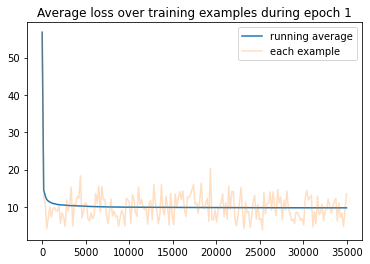

Epoch: 2/3............. Average Loss: 9.6629


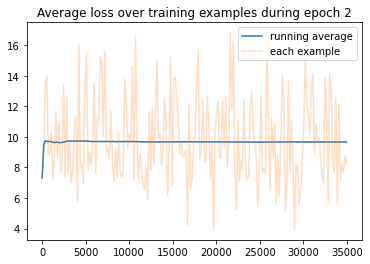

Epoch: 3/3............. Average Loss: 9.6504


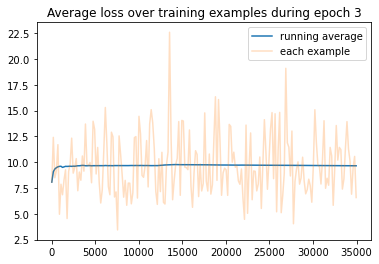

In [14]:
disp_graph_bool = True # Set to true to have graphs be displayed

# Create the RNN Model to be used (ReLU activation)
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining necessary hyperparameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # RNN Layer with ReLU
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True, nonlinearity = 'relu')   
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    # Forward prop function
    def forward(self, x):
        
        batch_size = x.size(0)

        # Use init_hidden to start this value
        hidden = self.init_hidden(batch_size)

        # Get output and hidden (last hidden) through RNN model
        out, hidden = self.rnn(x, hidden)
        
        # Put output of RNN into the full output layer to attain final output
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        #out = torch.zeros(out.size())
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden
    
# Instantiate the model with hyperparameters
model = Model(input_size=20, output_size=1, hidden_dim=20, n_layers=1)

# Define number of epochs and learning rate to be used
n_epochs = 3
lr=0.005

# Define Loss and Adam Optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Go through all the epochs and train
# Report both loss per example along with
# running average loss over epoch
for epoch in range(1, n_epochs + 1):
    total_epoch_loss = 0
    avg_epoch_loss = 0
    per_epoch_loss_arr = np.array([])
    example_epoch_loss_arr = np.array([])
    rand_order = np.random.permutation(len(list_in_seq))

    # Go through all the examples in a single_epoch
    for num, index in enumerate(rand_order):
        # Clears existing gradients from previous example
        optimizer.zero_grad()
        in_seq = list_in_seq[index]

        out_seq = list_out_seq[index]
        output, hidden = model(in_seq)

        # Utilize the loss to compute the gradient and use 
        # the optimizer to modify weights
        loss = criterion(output, out_seq.float())
        loss.backward() 
        optimizer.step() 
        
        # Add to the total_epoch_loss, avg_epoch_loss, and example's loss
        total_epoch_loss += loss.item()
        avg_epoch_loss = total_epoch_loss/(num + 1)
        per_epoch_loss_arr = np.append(per_epoch_loss_arr, avg_epoch_loss)
        example_epoch_loss_arr = np.append(example_epoch_loss_arr, loss.item())
        
        #if index%10000 == 0:
        #    print("10000 complete")
        
    # Compute the average epoch_loss overall for printing    
    avg_epoch_loss = total_epoch_loss/len(list_in_seq)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("Average Loss: {:.4f}".format(avg_epoch_loss))      
    
    # Create and display the graph for this epoch's loss
    if disp_graph_bool:
        # Prepare axis for smooth graph to avoid many variations
        x_amount = len(list_in_seq)
        x_axis = np.arange(len(list_in_seq))
        x_axis_new = np.linspace(x_axis.min(), x_axis.max(), 200) 
        
        spl = make_interp_spline(x_axis, per_epoch_loss_arr, k=1)
        loss_smooth = spl(x_axis_new)
        
        spl2 = make_interp_spline(x_axis, example_epoch_loss_arr, k=1)
        example_losses = spl2(x_axis_new)

        # Plot the loss over the training examples with smoothing
        plt.clf()
        plt.plot(x_axis_new, loss_smooth, label = "running average")
        plt.plot(x_axis_new, example_losses, label = "each example", alpha = 0.25)
        plt.legend(loc="upper right")
        plt.title("Average loss over training examples during epoch " + str(epoch))
        plt.show()
        

In [15]:
predictions = np.array([]) # Will hold the predictions for each test example
actual_vals = np.array([]) # Will hold the actual values for each test example

num_test_examples = len(test_list) # Total number of test examples

# Loop through every test example
for example in test_list:
    ######
    # To next comment is all pre-processing test data for output
    test_example = example[:]
    check1 = np.zeros((1, np.shape(example[:, :-1].T)[0], np.shape(example[:, :-1].T)[1]))
    check_hide = np.zeros((1, np.shape(example[:, :-1].T)[0], np.shape(example[:, :-1].T)[1]))
    check2 = np.zeros((1, 9, 1))
    
    check1[0] = example[:, :-1].T
    pre_score_arr = example[:, :-1].T
    post_score_arr = np.reshape(np.dot(pre_score_arr, fantasy_score_arr), (9,1))
    check2[0] = post_score_arr[:]
    
    test_input = torch.Tensor(check1)
    
    use_test_example = test_example[:-1]
    target_test_example = test_example[1:]
    
    target_final = post_score_arr[-1]
    
    output, hidden = model(test_input)
    
    output_final = output[-1]
    
    #Everything above is pre-processing the data and then forward prop on model
    #to get predictions
    #######
    
    # Forward prop to load the predicted and actual_vals arrays
    # to analyze test results
    predictions = np.append(predictions, output_final.item())
    actual_vals = np.append(actual_vals, target_final)

Average l1 loss: 7.683919785579018
Median l1 loss: 5.962127685546875
Average l2 loss: 103.70863571214198
Median l2 loss: 35.546966538764536


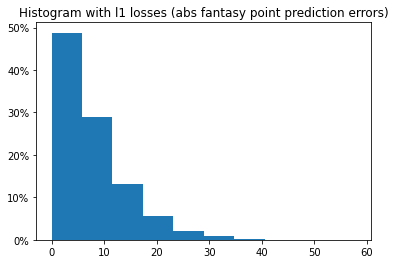

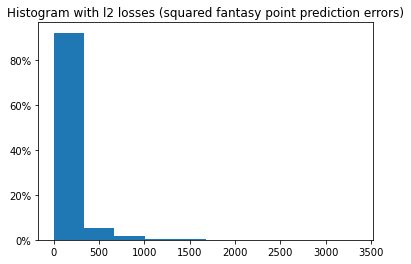

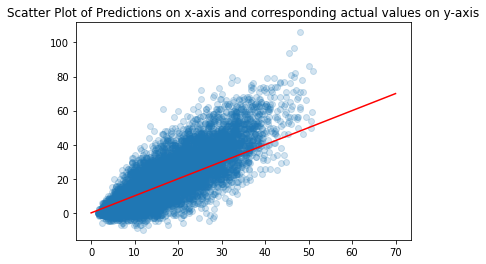

In [16]:
# Compute arrays representing l1 and l2 (MSE) losses per test example
l1_losses = np.abs(predictions - actual_vals)
l2_losses = np.square(predictions - actual_vals)
    
# Get total for l1 and l2 losses
total_l1_loss = np.sum(l1_losses)
total_l2_loss = np.sum(l2_losses)

# Get the average l1 and l2 loss per test example
avg_l1_loss = total_l1_loss/num_test_examples
avg_l2_loss = total_l2_loss/num_test_examples

# Get the median l1 and l2 losses over all test examples
median_l1_loss = np.median(np.abs(predictions - actual_vals))
median_l2_loss = np.median(np.square(predictions - actual_vals))

# Print out the found values above
print("Average l1 loss: " + str(avg_l1_loss))
print("Median l1 loss: " + str(median_l1_loss))
print("Average l2 loss: " + str(avg_l2_loss))
print("Median l2 loss: " + str(median_l2_loss))

# Graph histogram for l1 losses by percent in each category
plt.clf()
plt.hist(l1_losses, 10, weights=np.ones(len(l1_losses)) / len(l1_losses))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Histogram with l1 losses (abs fantasy point prediction errors)")
plt.show()

# Graph histogram for l2 losses by percent in each category
plt.clf()
plt.hist(l2_losses, 10, weights=np.ones(len(l2_losses)) / len(l2_losses))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Histogram with l2 losses (squared fantasy point prediction errors)")
plt.show()

# Graph histogram for l1 losses by percent in each category
plt.clf()
x = np.linspace(0,60,100)
y = 1*x+0
plt.plot(x, y, '-r', label='y=x (Perfect prediction line)')
plt.scatter(predictions, actual_vals, alpha = 0.2)
plt.title("Scatter Plot of Predictions on x-axis and corresponding actual values on y-axis")
plt.show()

# Use below for sanity check of predictions
#for i in range(100):
#    print("Predicted: " + str(predictions[i]) + " and actual: " + str(actual_vals[i]))

In [17]:
# Printing model parameters for further analysis if needed
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-4.5516e-01, -2.1992e-01, -6.6379e-02, -8.6011e-02,  8.4897e-02,
         -1.8271e-01,  4.8686e-02, -3.6054e-01,  4.7803e-03, -1.4292e-01,
         -2.0226e-01, -4.5270e-02, -4.4341e-01, -2.4313e-01, -2.2097e-01,
         -1.3673e-01, -1.5123e-01, -3.5699e-01, -2.4284e-01,  2.0939e-01],
        [-4.5902e-01, -2.2511e-01,  3.8163e-01, -3.7084e-01, -4.5906e-01,
         -3.3923e-01, -5.2818e-01, -3.8413e-01,  3.1163e-01,  1.5163e-01,
         -3.8964e-01, -5.6805e-01, -4.1288e-01, -4.5281e-01, -4.5201e-01,
          1.0155e-02, -6.6186e-01, -5.1020e-01, -1.8447e-01, -4.6242e-01],
        [-8.0750e-01, -5.3350e-02, -4.1769e-02, -3.2550e-01, -7.6127e-01,
         -5.9953e-01,  3.3176e-02, -9.6732e-02, -7.0637e-02, -4.2794e-01,
         -1.2186e-01, -4.1241e-01, -6.0630e-01,  3.0737e-02, -5.3298e-02,
         -6.1847e-01,  6.5554e-01, -7.1237e-02, -3.7601e-01, -3.8597e-01],
        [-3.7867e-01, -8.6468e-01,  1.1405e+00, -5.0600e-01,  6.1578e-01,
         -1.6